##import

In [1]:
%tensorflow_version 2.x
from keras.datasets import imdb
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
ADDRESS_PREDICT_SIZE = 1001
EMBEDDING_DIM = 256
RNN_UNITS = 1024
FIRST_OUTPUT_SIZE = 1001
BUFFER_SIZE = 10000
BATCH_SIZE = 64

##change hyperparameter to make best model

In [3]:
seq_length = 5 # length of sequence for a training example
epoch = 100
MAXLEN = 43
DENSE_HIDDEN_SIZE = 20

##open text file

In [4]:
f = open("473.astar-s0.txt", 'r')

##text file split

In [5]:
unique_instr_id = list()
cycle_count = list()
load_address = list()
instr_pointer_load = list()
llc_hit_miss = list()

f.seek(0, 0)
while True:
  line = f.readline()
  if not line: break
  split_line = line.split(', ')
  unique_instr_id.append(split_line[0])
  cycle_count.append(split_line[1])
  load_address.append(split_line[2])
  instr_pointer_load.append(split_line[3])
  llc_hit_miss.append(split_line[4][:-1])

for i in range(len(load_address)):
  load_address[i] = int(load_address[i], 16)//64

##make delta list(first input)

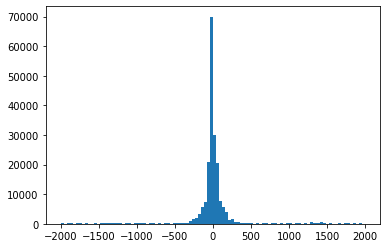

[687, 312, 445, 755, 611, 566, 515, 584, 334, 698, 576, 584, 544, 164, 903, 564, 582, 532, 1000, 0, 969, 436, 1000, 591, 564, 0, 1000, 0, 531, 1000, 586, 532, 510, 586, 0, 1000, 618, 564, 513, 532, 583, 516, 564, 564, 564, 597, 532, 532, 0, 1000, 751, 564, 602, 532, 532, 526, 564, 563, 0, 1000, 564, 602, 532, 532, 404, 622, 564, 0, 1000, 564, 597, 531, 437, 370, 768, 564, 589, 532, 571, 461, 603, 301, 763, 589, 0, 1000, 0, 1000, 1000, 0, 532, 347, 685, 1000, 0, 781, 0, 1000, 563, 501]
4363500794111
(120261, 6)
[[ 687  312  445  755  611  566]
 [ 515  584  334  698  576  584]
 [ 544  164  903  564  582  532]
 ...
 [   0 1000    0    0    0 1000]
 [1000 1000    0 1000    0  413]
 [1000  798 1000  499    0  554]]
[[ 687  312  445  755  611]
 [ 515  584  334  698  576]
 [ 544  164  903  564  582]
 ...
 [   0 1000    0    0    0]
 [1000 1000    0 1000    0]
 [1000  798 1000  499    0]]


In [6]:
delta = list()
for i in range(len(load_address)-1):
  delta.append(load_address[i+1] - load_address[i])

plot_this = list()
for i in range(len(load_address)-1):
  if delta[i] > 2000:
    continue
  if delta[i] < -2000:
    continue
  plot_this.append(delta[i])
plt.hist(plot_this, bins=100)
plt.show()

for i in range(len(delta)):
  if delta[i] > 500:
    delta[i] = 1000
    continue
  if delta[i] < -500:
    delta[i] = 0
    continue
  delta[i] += 500

print(delta[0:100])
print(max(load_address))

cut = len(delta)//(seq_length + 1) * (seq_length + 1)
delta = delta[:cut]
delta = np.reshape(delta,(-1,seq_length+1))
print(delta.shape)
print(delta)

rnn_data = delta[:,:-1]
rnn_data = np.array(rnn_data)
print(rnn_data)

##make address binary input(second input)

In [7]:
# 8 -> [0,0,0,1] change int to categorical value
def address_to_binary(a):
  binary_int = list()
  for i in range(MAXLEN):
    # /1000 -> scaling
    binary_int.append(a%2)
    a = a//2
  return binary_int

print(address_to_binary(8))

address_binary_input = list()
for i in range(len(load_address)-1):
  if i % (seq_length + 1) == seq_length:
    address_binary_input.append(address_to_binary(load_address[i]))

print(address_binary_input[0])
address_binary_input = np.array(address_binary_input)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


##make output data

In [8]:
delta_output = delta[:,-1:]
delta_output = delta_output.flatten()
delta_output

array([ 566,  584,  532, ..., 1000,  413,  554])

##kick dummy input and output

In [9]:
delete_list = list()
for i in range(len(delta_output)):
  if delta_output[i] == 0 or delta_output[i] == 1000:
    delete_list.append(i)

delta_output = np.delete(delta_output, delete_list)
rnn_data = np.delete(rnn_data, delete_list, 0)
address_binary_input = np.delete(address_binary_input, delete_list, 0)

##make model

In [10]:
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Model

def build_model(address_predict_size, first_output_size, embedding_dim, rnn_units, Batch_size):
  
  input_x = Input(shape=(seq_length,))
  x = Embedding(address_predict_size, embedding_dim)(input_x)
  x = LSTM(rnn_units, recurrent_initializer='glorot_uniform') (x)
  x = Dense(first_output_size, activation="sigmoid") (x)
  x = Model(inputs=input_x, outputs=x)

  input_y = Input(shape=(MAXLEN,))
  y = Dense(16, activation="relu")(input_y)
  y = Model(inputs=input_y, outputs=y)

  combined = tf.keras.layers.concatenate([x.output, y.output])

  z = Dense(128, activation="relu")(combined)
  z = Dense(address_predict_size, activation="sigmoid")(z)

  model = Model(inputs=[x.input, y.input], outputs=z)

  return model

model = build_model(ADDRESS_PREDICT_SIZE, FIRST_OUTPUT_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 256)       256256      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 1024)         5246976     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 43)]         0                                            
____________________________________________________________________________________________

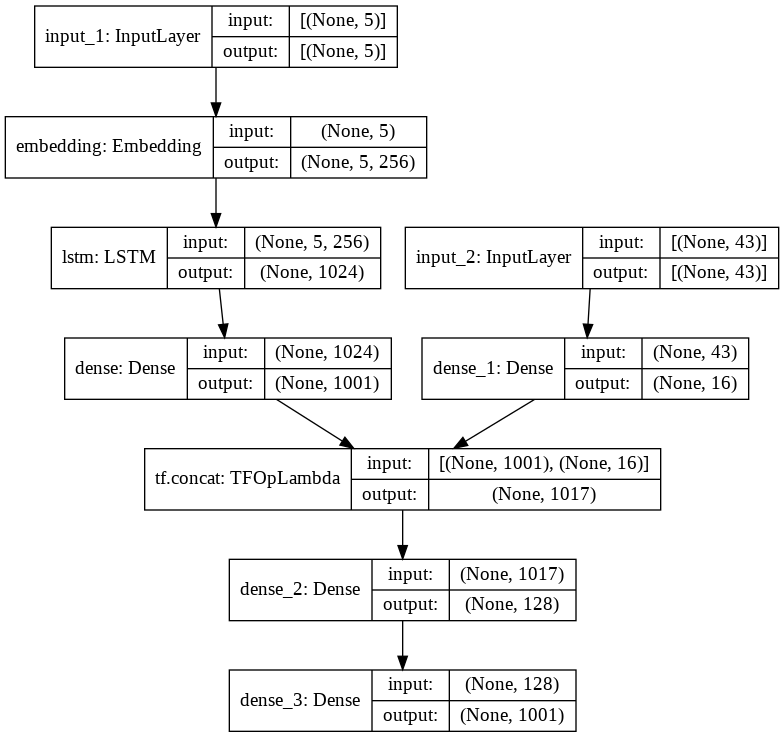

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

##create loss function

In [12]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [13]:
model.compile(optimizer='adam', loss=loss)

In [14]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [15]:
history = model.fit([rnn_data, address_binary_input], delta_output, batch_size=BATCH_SIZE, epochs=epoch, callbacks=[checkpoint_callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


484/484 [==============================] - 22s 10ms/step - loss: 3.9257
Epoch 2/100
484/484 [==============================] - 5s 11ms/step - loss: 3.2889
Epoch 3/100
484/484 [==============================] - 5s 10ms/step - loss: 3.1992
Epoch 4/100
484/484 [==============================] - 5s 11ms/step - loss: 3.1261
Epoch 5/100
484/484 [==============================] - 5s 11ms/step - loss: 3.0262
Epoch 6/100
484/484 [==============================] - 5s 11ms/step - loss: 2.9301
Epoch 7/100
484/484 [==============================] - 5s 11ms/step - loss: 2.8378
Epoch 8/100
484/484 [==============================] - 5s 11ms/step - loss: 2.7225
Epoch 9/100
484/484 [==============================] - 5s 11ms/step - loss: 2.5738
Epoch 10/100
484/484 [==============================] - 5s 11ms/step - loss: 2.4090
Epoch 11/100
484/484 [==============================] - 5s 10ms/step - loss: 2.2591
Epoch 12/100
484/484 [==============================] - 5s 10ms/step - loss: 2.0574
Epoch 13/100

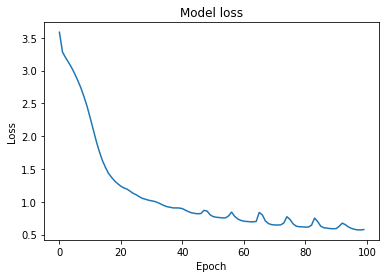

In [16]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
# expand_dims [10,10,3] -> [1,10,10,3]
input1 = tf.expand_dims([687, 312, 445, 755, 611], 0)
input2 = tf.expand_dims([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],0)

input_eval = [input1, input2]
temperature = 1.0
model.reset_states()

prediction = model(input_eval)
print(prediction)

prediction = prediction / temperature
print(prediction)

predicted_id = tf.random.categorical(prediction, num_samples=1)[-1,0].numpy()
print(predicted_id)

tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 1001), dtype=float32)
tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 1001), dtype=float32)
864


In [18]:
def generate_address(model, start_address):
  # Evaluation step (generating address using the learned model)

  # Number of characters to generate
  num_generate = 2

  input_eval = [tf.expand_dims(start_address[0], 0), tf.expand_dims(start_address[1], 0)]

  # Empty string to store our results
  generated = []

  # Low temperatures results in more predictable.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  
  predictions = model(input_eval)

  predictions = predictions / temperature

  # using probability
  '''
  generated = tf.random.categorical(predictions_np, num_samples=num_generate)[-1,0].numpy()  
  '''

  # using argmax
  predictions_np = predictions.numpy()
  predictions_np = np.squeeze(predictions_np,axis=0)
  predictions_np = np.argsort(predictions_np)
  generated = predictions_np [-num_generate:]

  return generated

In [19]:
inp = [[687, 312, 445, 755, 611],[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]]
print(generate_address(model, inp))

[575 566]


##accuracy 측정

In [21]:
total_num = len(load_address)//(seq_length + 1)
total_num_except_0_1000 = 0
correct = 0

for i in tqdm(range(len(delta_output)), desc='check accuracy..'):
  if delta_output[i] == 1000:
    continue
  if delta_output[i] == 0:
    continue
  total_num_except_0_1000 += 1
  inp = [rnn_data[i].tolist(), address_binary_input[i].tolist()]
  lstm_ans = generate_address(model, inp)
  print(lstm_ans, delta_output[i], sep=', ')
  if delta_output[i] in lstm_ans:
    correct += 1

print("accuracy")
print(correct/total_num)
print("accuracy except 0 and 1000")
print(correct/total_num_except_0_1000)

check accuracy..:   0%|          | 28/30952 [00:00<03:52, 133.24it/s]

[575 566], 566
[554 584], 584
[596 532], 532
[621 591], 591
[512 516], 516
[564 532], 532
[596 532], 532
[418 622], 622
[501 531], 531
[425 532], 532
[601 589], 589
[219 781], 781
[501 645], 645
[501 564], 564
[501 564], 564
[564 559], 559
[688 481], 481
[442 532], 532
[432 561], 561
[948 531], 531
[428 532], 532
[458 475], 475
[582 499], 499
[501 435], 435
[660 661], 661
[532 499], 499
[425 532], 532
[564 563], 563


check accuracy..:   0%|          | 56/30952 [00:00<03:50, 134.23it/s]

[402 501], 501
[469 532], 532
[516 534], 534
[738 570], 570
[501 564], 564
[628 564], 564
[501 596], 596
[688 580], 580
[425 532], 532
[564 532], 532
[625 563], 563
[501 468], 468
[468 501], 501
[568 532], 532
[628 584], 584
[442 499], 499
[564 559], 564
[622 635], 635
[628 584], 584
[434 561], 561
[560 574], 574
[198 544], 544
[463 610], 610
[692 564], 564
[407 568], 568
[532 438], 438
[532 581], 581
[564 549], 549


check accuracy..:   0%|          | 83/30952 [00:00<03:52, 132.54it/s]

[499 532], 532
[596 532], 532
[501 440], 440
[501 564], 564
[610 244], 244
[499 564], 564
[461 617], 617
[499 564], 564
[628 564], 564
[436 532], 532
[657 608], 608
[499 576], 576
[501 532], 532
[439 565], 565
[501 532], 532
[568 532], 532
[596 532], 532
[532 560], 560
[628 564], 564
[499 564], 564
[469 327], 327
[532 564], 564
[501 532], 532
[562 596], 596
[552 551], 551
[564 530], 530
[628 564], 564


check accuracy..:   0%|          | 111/30952 [00:00<03:51, 133.41it/s]

[470 726], 726
[573 566], 566
[499 527], 527
[536 564], 564
[328 520], 520
[628 948], 948
[450 447], 447
[499 501], 501
[564 501], 564
[442 532], 532
[340 532], 532
[815 644], 644
[568 612], 612
[596 532], 532
[501 556], 556
[546 511], 511
[ 69 575], 575
[402 529], 529
[417 543], 543
[608 489], 489
[574 575], 575
[553 543], 543
[276 321], 321
[400 703], 703
[566 575], 575
[566 575], 575
[501 436], 436
[532 499], 499


check accuracy..:   0%|          | 139/30952 [00:01<03:49, 134.25it/s]

[532 564], 564
[692 635], 635
[628 564], 564
[536 535], 535
[467 499], 499
[532 564], 564
[532 564], 564
[628 564], 564
[756 529], 529
[581 582], 582
[565 564], 564
[348 582], 582
[640 264], 264
[564 436], 436
[579 513], 513
[434 429], 429
[472 635], 635
[501 570], 570
[501 532], 532
[520 374], 564
[501 532], 617
[440 569], 569
[532 499], 499
[371 589], 589
[545 507], 507
[561 656], 656
[532 616], 616
[564 501], 501


check accuracy..:   0%|          | 153/30952 [00:01<03:59, 128.76it/s]

[371 530], 530
[462 777], 777
[595 533], 533
[148 240], 692
[436 499], 499
[501 532], 499
[539 582], 582
[416 550], 550
[515 386], 418
[756 521], 521
[406 266], 266
[343 998], 998
[372 501], 564
[617 564], 564
[628 461], 461
[532 564], 564
[424 411], 411
[532 499], 499
[628 562], 562
[564 565], 565
[455 611], 611
[339 643], 643
[499 501], 501
[564 501], 564
[428 564], 532
[532 499], 499


check accuracy..:   1%|          | 181/30952 [00:01<03:54, 131.47it/s]

[884 564], 564
[688 714], 714
[548 586], 586
[414 501], 501
[655 637], 637
[436 501], 501
[563 586], 586
[371 501], 501
[655 637], 637
[515 325], 325
[670 344], 344
[580 501], 501
[307 563], 563
[568 501], 501
[655 637], 637
[499 501], 501
[563 586], 563
[555 501], 501
[617 564], 564
[355 499], 499
[501 499], 499
[371 499], 499
[563 564], 564
[385 543], 543
[501 564], 564
[728 617], 617
[502 576], 576
[564 499], 499


check accuracy..:   1%|          | 209/30952 [00:01<03:53, 131.57it/s]

[501 565], 565
[501 508], 508
[565 567], 567
[424 757], 757
[336 822], 822
[595 881], 881
[501 499], 499
[437 564], 564
[396 457], 457
[416 553], 553
[591 595], 595
[501 499], 499
[532 499], 499
[627 499], 499
[501 532], 532
[532 570], 570
[501 499], 499
[627 499], 499
[501 428], 428
[564 501], 564
[676 612], 612
[689 644], 644
[322 516], 516
[564 559], 559
[597 579], 579
[563 548], 548


check accuracy..:   1%|          | 236/30952 [00:01<04:00, 127.67it/s]

[499 501], 501
[581 675], 675
[499 501], 501
[416 579], 579
[563 548], 548
[499 501], 501
[396 675], 675
[532 501], 501
[643 579], 579
[468 548], 548
[499 501], 501
[428 532], 532
[501 568], 568
[436 532], 532
[563 636], 636
[568 560], 560
[428 468], 468
[501 600], 600
[452 499], 499
[579 499], 499
[579 510], 510
[331 832], 832
[501 449], 449
[392 562], 424
[631 440], 427
[573 501], 564


check accuracy..:   1%|          | 262/30952 [00:02<03:59, 128.11it/s]

[693 578], 578
[533 596], 596
[459 594], 594
[372 499], 499
[501 499], 585
[643 539], 539
[499 382], 564
[642 422], 660
[929 481], 481
[382 551], 551
[673 641], 641
[244 609], 609
[499 423], 423
[447 641], 641
[499 532], 609
[541 538], 538
[636 573], 573
[564 405], 405
[681 363], 363
[879 716], 716
[391 968], 968
[565 401], 401
[554 526], 526
[501 471], 471
[442 499], 499


check accuracy..:   1%|          | 288/30952 [00:02<04:03, 125.91it/s]

[409 480], 480
[628 564], 564
[276 499], 499
[581 582], 582
[532 571], 571
[395 430], 430
[501 436], 436
[479 609], 609
[468 532], 532
[426 568], 568
[627 499], 499
[579 499], 499
[442 499], 499
[501 436], 436
[450 919], 919
[417 455], 455
[674 609], 609
[141 615], 615
[630 615], 615
[501 579], 439
[434 551], 551
[543 553], 553
[425 539], 539
[501 499], 499
[437 564], 564
[452 536], 536
[559 433], 433


check accuracy..:   1%|          | 314/30952 [00:02<04:00, 127.44it/s]

[496 408], 408
[501 499], 499
[610 316], 316
[566 438], 438
[501 432], 432
[499 501], 501
[501 499], 499
[532 499], 499
[454 560], 560
[501 499], 499
[467 391], 391
[499 501], 501
[448 573], 573
[501 381], 381
[450 382], 382
[501 563], 563
[384 413], 413
[499 501], 501
[425 501], 501
[407 619], 619
[576 499], 499
[568 501], 501
[499 501], 501
[579 484], 484
[501 564], 436
[640 648], 648
[510 512], 512


check accuracy..:   1%|          | 342/30952 [00:02<03:51, 132.30it/s]

[675 616], 616
[499 416], 416
[501 563], 563
[521 525], 525
[501 532], 609
[453 452], 452
[583 388], 388
[501 499], 499
[436 499], 499
[596 532], 532
[251 252], 252
[550 850], 850
[667 342], 342
[334 727], 727
[564 584], 584
[499 540], 540
[372 458], 458
[435 627], 627
[437 564], 564
[628 564], 564
[308 820], 820
[453 454], 454
[501 371], 371
[499 501], 499
[829 412], 412
[551 455], 455
[501 498], 498
[443 474], 474


check accuracy..:   1%|          | 371/30952 [00:02<03:47, 134.55it/s]

[499 501], 501
[532 499], 499
[532 499], 499
[499 532], 501
[532 499], 499
[499 501], 680
[440 560], 560
[423 518], 436
[499 501], 501
[287 479], 479
[564 501], 501
[469 327], 327
[501 564], 564
[532 499], 499
[569 597], 597
[501 359], 359
[501 436], 436
[756 664], 664
[502 576], 576
[499 512], 512
[416 548], 548
[436 372], 372
[485 290], 290
[393 468], 468
[372 422], 422
[423 418], 418
[948 607], 607
[564 499], 499
[535 566], 566


check accuracy..:   1%|▏         | 399/30952 [00:03<03:45, 135.38it/s]

[499 501], 532
[501 538], 538
[501 532], 532
[633 459], 459
[599 480], 480
[577 532], 628
[564 628], 628
[564 628], 628
[564 628], 628
[756 628], 628
[628 436], 564
[532 499], 499
[532 501], 564
[413 574], 574
[499 394], 394
[434 554], 554
[357 450], 450
[434 501], 568
[532 499], 499
[373 532], 340
[422 552], 425
[501 532], 609
[436 501], 501
[501 532], 532
[579 410], 410
[559 432], 432
[561 560], 560
[501 624], 624


check accuracy..:   1%|▏         | 427/30952 [00:03<04:00, 127.09it/s]

[419 330], 330
[436 499], 499
[499 552], 499
[606 384], 384
[245 564], 564
[584 616], 616
[866 512], 512
[596 532], 532
[499 501], 501
[501 641], 641
[533 556], 556
[371 531], 531
[756 628], 628
[501 499], 564
[501 499], 564
[501 568], 568
[532 499], 499
[501 499], 615
[501 532], 499
[532 564], 564
[532 499], 499
[499  56], 56
[501 551], 552
[568 420], 425


check accuracy..:   1%|▏         | 453/30952 [00:03<04:02, 125.63it/s]

[499 501], 501
[416 499], 499
[596 532], 532
[499 501], 501
[587 532], 532
[564 341], 341
[587 437], 437
[627 499], 499
[372 499], 499
[499 408], 408
[532 499], 499
[371 499], 499
[432 535], 535
[564 584], 584
[574 447], 447
[499 525], 525
[604 909], 909
[564 501], 564
[574 542], 542
[423 499], 499
[442 499], 499
[396 415], 415
[501 564], 564
[617 703], 703
[501 433], 433
[499 527], 527
[414 572], 572


check accuracy..:   2%|▏         | 481/30952 [00:03<03:55, 129.34it/s]

[436 499], 499
[564 532], 532
[564 642], 642
[501 519], 519
[501 561], 561
[501 468], 468
[407 376], 376
[472 622], 622
[501 499], 499
[532 499], 499
[434 593], 593
[501 499], 499
[416 499], 499
[820 808], 808
[581 425], 425
[583 584], 584
[559 432], 432
[627 499], 499
[499 532], 499
[499 501], 501
[384 416], 501
[343 532], 585
[944 499], 499
[452 484], 484
[501 564], 564
[640 294], 294
[577 499], 499


check accuracy..:   2%|▏         | 509/30952 [00:03<03:51, 131.43it/s]

[436 628], 628
[615 564], 564
[308 436], 436
[627 499], 499
[628 532], 532
[564 499], 499
[653 499], 499
[501 499], 499
[596 532], 532
[408 584], 584
[549 501], 444
[501 499], 499
[608 735], 735
[691 458], 458
[564 501], 501
[532 499], 499
[501 499], 499
[501 491], 491
[501 532], 532
[432 499], 499
[437 459], 459
[276 524], 524
[501 499], 499
[372 499], 499
[627 499], 499
[499 430], 501
[532 499], 499
[532 499], 499


check accuracy..:   2%|▏         | 537/30952 [00:04<03:46, 134.02it/s]

[499 528], 528
[501 499], 499
[422 499], 499
[564 571], 571
[501 565], 565
[499 266], 266
[532 501], 501
[501 555], 555
[501 499], 499
[532 436], 532
[619 366], 366
[501 602], 602
[396 499], 499
[501 532], 532
[559  23], 23
[621 689], 689
[568 532], 532
[345 535], 535
[757 721], 721
[586 499], 499
[602 401], 401
[430 499], 499
[596 545], 545
[543 418], 433
[416 425], 425
[575 564], 444
[710 891], 891


check accuracy..:   2%|▏         | 565/30952 [00:04<03:55, 129.07it/s]

[579 499], 499
[532 679], 679
[501 421], 421
[436 564], 564
[514 550], 550
[756 499], 499
[436 628], 628
[870 963], 963
[501 625], 625
[558 463], 463
[440 501], 501
[436 499], 499
[501 391], 391
[340 724], 724
[551 423], 423
[375 673], 673
[436 372], 372
[551 423], 423
[559 615], 615
[550 423], 423
[455 499], 499
[428 437], 437
[556 468], 468
[465 595], 595
[331 437], 437
[501 468], 468


check accuracy..:   2%|▏         | 591/30952 [00:04<03:57, 127.96it/s]

[453 499], 499
[581 361], 532
[593 594], 594
[782 315], 315
[561 567], 567
[501 499], 499
[501 551], 551
[430 499], 499
[501 499], 499
[564 499], 499
[532 402], 402
[499 530], 530
[372 532], 532
[501 499], 499
[557 432], 432
[499 468], 468
[416 499], 499
[515 860], 860
[499 973], 973
[532 499], 499
[576 601], 601
[436 501], 501
[440 537], 537
[558 560], 560
[499 559], 559
[499 501], 501
[434 573], 628


check accuracy..:   2%|▏         | 619/30952 [00:04<03:52, 130.49it/s]

[243 391], 391
[382 423], 423
[532 599], 599
[501 351], 351
[564 628], 564
[499 568], 568
[501 277], 277
[566 499], 499
[627 499], 499
[475 177], 177
[499  16], 16
[727 532], 553
[408 587], 587
[372 391], 391
[499 512], 512
[572 636], 636
[819 268], 268
[573 476], 476
[501 532], 532
[450 443], 443
[501 896], 896
[545 265], 265
[582 499], 499
[532 587], 388
[692 564], 564
[453 499], 499
[501 499], 499


check accuracy..:   2%|▏         | 647/30952 [00:04<03:49, 132.22it/s]

[564 627], 627
[532 499], 499
[562 316], 316
[627 499], 499
[464 145], 145
[597 379], 379
[468 660], 660
[660 788], 660
[660 788], 788
[724 788], 724
[212 532], 532
[148 596], 596
[532 499], 499
[468 388], 388
[439 532], 627
[944 499], 944
[501 499], 499
[656 605], 605
[655 303], 303
[601 655], 655
[581 559], 559
[499 396], 396
[692 223], 223
[429 543], 543
[453 592], 592
[586 738], 738
[499 532], 431


check accuracy..:   2%|▏         | 674/30952 [00:05<03:54, 129.18it/s]

[442 160], 160
[575 479], 479
[501 499], 499
[408 535], 535
[401 567], 567
[434 465], 465
[501 599], 599
[499 567], 567
[568 465], 465
[501 499], 499
[381 450], 450
[501 499], 499
[436 561], 425
[501 499], 532
[501 568], 568
[627 499], 499
[564 499], 499
[565 433], 433
[588 499], 499
[501 499], 499
[597 595], 595
[436 499], 499
[587 565], 565
[501 499], 499
[627 563], 563
[501 499], 499


check accuracy..:   2%|▏         | 700/30952 [00:05<04:01, 125.02it/s]

[727 397], 397
[499 724], 724
[289 738], 738
[407 563], 563
[501 532], 532
[545 372], 372
[501 499], 499
[308 244], 244
[532 499], 499
[501 499], 499
[532 478], 592
[501 499], 499
[532 501], 501
[499 501], 501
[564 692], 692
[756 628], 628
[564 628], 628
[564 628], 628
[564 628], 628
[627 628], 628
[436 628], 564
[628 564], 564
[499 299], 299
[425 512], 512
[334 727], 727


check accuracy..:   2%|▏         | 728/30952 [00:05<03:51, 130.44it/s]

[550 835], 835
[510 517], 517
[756 628], 628
[568 532], 532
[384 568], 568
[442 499], 499
[627 499], 499
[452 499], 499
[627 499], 499
[372 391], 391
[343 426], 426
[398 499], 499
[548 499], 499
[423 359], 359
[499 501], 499
[534 527], 527
[340 367], 367
[501 436], 436
[532 601], 601
[559 633], 633
[559 633], 633
[564 552], 552
[404 243], 243
[564 499], 499
[501 499], 499
[628 532], 436
[501 499], 499
[499 582], 582


check accuracy..:   2%|▏         | 756/30952 [00:05<03:47, 132.58it/s]

[499 315], 315
[499 501], 426
[243 298], 298
[499 512], 512
[397 597], 597
[501 537], 537
[536 448], 426
[180 869], 869
[677 840], 840
[396 499], 499
[501 499], 499
[564 501], 501
[501 499], 499
[605 478], 478
[454 468], 468
[396 522], 522
[759 266], 266
[600 456], 600
[447 449], 449
[532 499], 499
[543 327], 327
[499 564], 564
[425 419], 419
[501 499], 434
[513 710], 710
[569 123], 123
[423 501], 425
[436 394], 394


check accuracy..:   3%|▎         | 784/30952 [00:06<03:48, 132.18it/s]

[499 545], 545
[468 564], 564
[504 499], 504
[563 436], 436
[308 564], 564
[434 501], 499
[884 470], 470
[617 522], 522
[429 434], 557
[442 499], 499
[396 499], 499
[563 602], 602
[432 416], 416
[501 499], 499
[627 499], 499
[453 499], 499
[628 499], 499
[427 560], 560
[454 583], 583
[552 353], 353
[436 501], 501
[382 385], 385
[318 582], 582
[501 467], 467
[436 501], 501
[434 449], 449
[407 546], 546
[563 467], 467


check accuracy..:   3%|▎         | 812/30952 [00:06<03:48, 131.69it/s]

[578 501], 501
[457 978], 978
[418 582], 582
[418 417], 417
[468 467], 467
[372 501], 501
[554 430], 430
[425 499], 499
[501 499], 499
[663 584], 584
[499 501], 499
[564 499], 499
[663 499], 499
[627 499], 499
[499 532], 499
[499 405], 405
[499 501], 501
[499 566], 371
[695 435], 435
[515 838], 838
[627 499], 499
[532 501], 501
[212 391], 391
[499 542], 542
[464 601], 601
[334 554], 554
[501 499], 499
[436 499], 499


check accuracy..:   3%|▎         | 826/30952 [00:06<03:48, 131.61it/s]

[595 282], 282
[499 582], 499
[501 499], 499
[501 499], 468
[357 549], 549
[756 325], 325
[532 499], 499
[453 501], 452
[356 348], 348
[501 499], 499
[501 499], 499
[436 499], 499
[425 499], 499
[501 499], 499
[570 262], 262
[564 501], 372
[628 564], 564
[579 499], 499
[473 501], 501
[499 501], 501
[568 427], 427
[499 419], 419
[501 402], 402
[436 501], 501
[691 757], 757
[436 499], 499
[564 499], 499


check accuracy..:   3%|▎         | 854/30952 [00:06<03:50, 130.77it/s]

[372 436], 436
[627 499], 499
[532 499], 499
[244 499], 499
[532 499], 499
[573 413], 413
[692 564], 564
[543 499], 499
[501 499], 499
[532 499], 499
[607 499], 499
[499 507], 507
[525 862], 862
[467 499], 499
[501 564], 564
[512 499], 499
[660 270], 270
[390 393], 393
[501 564], 564
[627 499], 499
[564 628], 628
[627 499], 499
[501 499], 499
[579 499], 499
[308 372], 372
[532 499], 499
[436 372], 372
[501 499], 499


check accuracy..:   3%|▎         | 882/30952 [00:06<03:49, 131.27it/s]

[436 532], 532
[627 499], 499
[501 499], 499
[455 619], 619
[501 436], 436
[619 601], 601
[568 387], 387
[425 499], 499
[457 449], 449
[909 522], 522
[499 564], 564
[564 499], 499
[499 501], 499
[501 499], 532
[499 501], 468
[564 436], 436
[436 499], 499
[579 499], 499
[532 499], 499
[532 499], 499
[466 380], 380
[532 501], 501
[564 499], 499
[425 564], 532
[436 499], 499
[564 499], 499
[425 499], 499


check accuracy..:   3%|▎         | 910/30952 [00:06<03:45, 133.01it/s]

[436 499], 499
[501 580], 452
[549 499], 499
[499 532], 499
[268 377], 377
[464 481], 481
[551 423], 423
[589 585], 585
[372 499], 499
[657 244], 478
[501 499], 340
[499 307], 564
[499 502], 564
[436 499], 499
[532 259], 259
[474 670], 474
[343 430], 430
[443 474], 474
[501 474], 474
[631 625], 501
[436 501], 501
[562 434], 562
[434 727], 727
[529 567], 567
[276 566], 566
[501 532], 532
[628 564], 564
[435 499], 499


check accuracy..:   3%|▎         | 938/30952 [00:07<03:46, 132.43it/s]

[501 499], 400
[447 448], 448
[281 866], 866
[501 564], 564
[501 499], 499
[627 499], 499
[756 673], 673
[501 532], 532
[468 941], 941
[628 756], 756
[372 499], 499
[442 499], 499
[532 570], 570
[499 582], 582
[276 383], 468
[673 353], 353
[501 499], 499
[687 499], 687
[435 499], 499
[501 436], 436
[501 532], 590
[416  91], 91
[660 423], 423
[501 585], 585
[577 618], 618
[501 414], 414
[564 574], 574

check accuracy..:   3%|▎         | 966/30952 [00:07<03:46, 132.11it/s]


[493 473], 473
[440 536], 536
[501 499], 499
[579 499], 499
[436 615], 615
[501 504], 504
[545 870], 870
[627 499], 499
[501 433], 433
[501 499], 499
[525 499], 499
[503 601], 601
[467 499], 499
[433 499], 561
[417 574], 574
[499 386], 386
[579 499], 499
[499 281], 281
[501 499], 499
[254 603], 603
[436 532], 396
[501 532], 501
[519 511], 511
[455 414], 414
[501 499], 499
[416 499], 499
[503 499], 499


check accuracy..:   3%|▎         | 994/30952 [00:07<03:43, 133.77it/s]

[499 866], 866
[522 928], 928
[497 499], 499
[532 499], 499
[425 419], 419
[532 499], 499
[501 499], 499
[798 499], 499
[499 944], 499
[475 462], 462
[692 105], 105
[564 501], 372
[531 556], 556
[624 468], 468
[501 532], 532
[501 499], 499
[627 499], 499
[579 499], 499
[501 499], 499
[499 532], 501
[499 453], 453
[501 499], 499
[579 499], 499
[499 426], 499
[308 244], 244
[436 372], 501
[691 499], 499
[691 499], 499


check accuracy..:   3%|▎         | 1022/30952 [00:07<03:48, 130.74it/s]

[501 499], 499
[663 499], 499
[442 499], 499
[383 499], 499
[425 499], 499
[501 499], 499
[501 499], 499
[532 499], 499
[434 501], 501
[564 308], 308
[443 474], 474
[501 440], 440
[539 415], 415
[404 540], 540
[499 501], 501
[493 137], 137
[436 589], 692
[499 607], 499
[453 515], 515
[501 515], 515
[624 622], 622
[527 529], 529
[417 611], 611
[541 499], 499
[244 628], 628
[756 628], 628
[564 628], 628


check accuracy..:   3%|▎         | 1050/30952 [00:08<03:44, 133.18it/s]

[692 628], 628
[564 628], 564
[756 308], 756
[564 436], 436
[476 628], 628
[532 501], 501
[564 501], 501
[499 501], 501
[276 499], 499
[499 501], 499
[501 499], 558
[535 440], 440
[532 499], 499
[625 437], 437
[564 563], 563
[422 319], 319
[561 576], 576
[578 326], 326
[582 453], 453
[418 515], 515
[414 538], 538
[691 499], 499
[499 532], 532
[591 499], 499
[643 152], 152
[501 564], 564
[401 403], 403
[717 704], 704


check accuracy..:   3%|▎         | 1078/30952 [00:08<03:45, 132.57it/s]

[501 499], 499
[627 499], 499
[529 320], 320
[501 499], 499
[501 499], 499
[484 499], 499
[658 628], 628
[436 499], 499
[499 498], 498
[501 499], 499
[605 481], 481
[407 606], 606
[399 555], 555
[554 446], 446
[453 395], 395
[407 606], 606
[636 563], 563
[499 501], 501
[446 554], 554
[499 581], 581
[436 532], 532
[499 501], 532
[501 532], 532
[459 677], 677
[564 501], 501
[499 383], 383
[308 436], 436


check accuracy..:   4%|▎         | 1106/30952 [00:08<03:46, 131.86it/s]

[501 499], 499
[368 464], 464
[600 376], 376
[564 499], 499
[294 289], 289
[576 906], 906
[501 423], 423
[501 499], 499
[499 230], 230
[442 499], 499
[315 782], 782
[441 410], 410
[501 499], 501
[499 501], 501
[382 554], 554
[633 532], 532
[414 606], 606
[568 532], 532
[501 499], 499
[501 499], 499
[614 411], 411
[532 499], 499
[501 499], 499
[501 499], 499
[436 372], 372
[499 399], 399


check accuracy..:   4%|▎         | 1134/30952 [00:08<03:49, 129.83it/s]

[368 569], 569
[398 527], 527
[389 399], 399
[501 499], 499
[396 499], 499
[564 756], 756
[564 428], 428
[543 508], 508
[501 532], 501
[556 501], 501
[371 499], 499
[371 499], 499
[532 499], 499
[501 499], 499
[499 532], 532
[427 311], 311
[554 582], 582
[655 780], 780
[738 569], 569
[501 564], 564
[443 474], 474
[551 532], 532
[627 499], 499
[585 788], 788
[574 499], 499
[499 480], 480


check accuracy..:   4%|▍         | 1161/30952 [00:08<03:54, 127.04it/s]

[501 499], 499
[499 501], 499
[627 499], 499
[532 499], 499
[468 276], 276
[527 428], 428
[532 148], 148
[579 501], 501
[532 436], 473
[579 499], 499
[499 425], 425
[499 468], 468
[501 468], 468
[501 468], 468
[501 468], 468
[724 468], 468
[335 398], 398
[501 499], 499
[628 499], 499
[501 499], 499
[627 499], 499
[499 501], 501
[501 499], 499
[535 238], 238
[502 138], 138
[417 231], 231


check accuracy..:   4%|▍         | 1189/30952 [00:09<03:46, 131.50it/s]

[501 597], 597
[443 474], 474
[443 474], 474
[532 622], 622
[371 499], 499
[627 499], 499
[561 501], 501
[499 532], 884
[501 468], 468
[499 533], 533
[642 628], 628
[627 499], 499
[467  98], 98
[627 499], 499
[501 499], 499
[627 499], 499
[578 443], 443
[468 499], 499
[501 386], 386
[436 499], 499
[501 499], 499
[499 501], 501
[499 501], 499
[660 596], 596
[532 596], 596
[501 499], 499
[664 672], 672
[439 210], 210


check accuracy..:   4%|▍         | 1217/30952 [00:09<03:47, 130.58it/s]

[572 680], 539
[499 965], 965
[501 439], 439
[564 532], 532
[499 475], 475
[627 499], 499
[627 499], 499
[563 408], 408
[501 499], 501
[429 501], 499
[499 501], 501
[436 564], 564
[ 20 918], 918
[499 564], 564
[586 583], 583
[501 577], 577
[501 564], 564
[412 583], 583
[627 499], 499
[390 468], 468
[436 499], 499
[454 429], 429
[372 570], 570
[501 499], 588
[627 499], 499
[196 323], 323
[499 425], 425


check accuracy..:   4%|▍         | 1245/30952 [00:09<03:42, 133.49it/s]

[568 499], 499
[628 564], 564
[436 564], 564
[442 569], 569
[312 560], 560
[501 499], 499
[501 552], 552
[499 546], 546
[457 532], 532
[499 501], 501
[532 499], 499
[884 820], 820
[532 499], 499
[819 180], 180
[ 81 940], 940
[564 628], 628
[583 180], 180
[532 650], 650
[501 499], 499
[532 622], 622
[501 499], 499
[532 501], 436
[501 499], 499
[244 257], 257
[501 499], 567
[620 141], 141
[526 364], 364
[499 724], 724


check accuracy..:   4%|▍         | 1273/30952 [00:09<03:42, 133.34it/s]

[292 601], 601
[499 547], 547
[499 501], 499
[405 626], 468
[448 501], 448
[499 532], 532
[692 499], 499
[596 532], 532
[501 499], 499
[436 499], 499
[532 499], 244
[564 499], 564
[628 372], 372
[499 501], 501
[498 551], 551
[501 499], 499
[619 655], 655
[499 484], 484
[501 499], 499
[425 450], 425
[501 383], 383
[501 499], 499
[408 178], 178
[564 436], 436
[624 376], 376
[564 536], 536
[501 532], 532


check accuracy..:   4%|▍         | 1301/30952 [00:09<03:43, 132.87it/s]

[501 499], 499
[550 499], 499
[501 308], 308
[501 532], 532
[453 454], 454
[501 499], 436
[436 372], 372
[564 499], 499
[565 499], 499
[615 559], 559
[501 499], 499
[436 433], 417
[599 532], 532
[501 532], 461
[501 499], 499
[532 599], 599
[564 499], 499
[436 574], 564
[501 499], 551
[501 532], 532
[559  20], 20
[452 559], 559
[499 501], 499
[308 372], 620
[564 499], 499
[499 501], 564
[408 807], 807
[756 499], 499


check accuracy..:   4%|▍         | 1329/30952 [00:10<03:40, 134.45it/s]

[755 499], 499
[532 499], 499
[579 653], 653
[567 499], 499
[498 499], 499
[423 447], 447
[468 836], 836
[461 564], 564
[756 628], 628
[628 692], 692
[532 501], 501
[371 563], 563
[244 436], 436
[501 499], 502
[456 654], 654
[437 436], 436
[627 499], 499
[501 499], 499
[439 501], 556
[513 736], 736
[244 252], 252
[499 543], 543
[756 532], 532
[499 639], 639
[501 361], 361
[501 527], 527
[384 400], 400
[501 499], 499


check accuracy..:   4%|▍         | 1343/30952 [00:10<03:44, 132.14it/s]

[537 633], 633
[501 461], 461
[414  43], 43
[552 551], 551
[532 499], 499
[564 499], 499
[499 501], 499
[501 499], 499
[458 532], 691
[388 324], 324
[452 580], 580
[291 388], 388
[612 740], 740
[499 452], 452
[501 499], 499
[553 577], 551
[499 501], 499
[532 499], 499
[627 499], 499
[499 358], 358
[624 771], 771
[499 155], 155
[499  42], 42
[501 499], 499
[595 344], 344
[627 499], 499
[372 501], 501


check accuracy..:   4%|▍         | 1371/30952 [00:10<03:45, 131.24it/s]

[372 436], 436
[501 532], 532
[499 501], 532
[564 664], 664
[502 499], 499
[581  68], 68
[308 501], 308
[501 499], 499
[244 544], 756
[436 532], 532
[435  52], 52
[501 499], 499
[884 471], 471
[499 501], 499
[292 579], 579
[499 461], 461
[627 499], 499
[627 499], 499
[590 532], 532
[501 499], 499
[554 427], 427
[499 501], 499
[658 370], 320
[442 577], 473
[434 532], 532
[501 400], 400
[261 239], 239


check accuracy..:   5%|▍         | 1399/30952 [00:10<03:40, 133.76it/s]

[653 499], 499
[627 499], 499
[627 499], 499
[436 499], 499
[501 499], 499
[533 596], 596
[501 499], 499
[691 668], 668
[308 276], 276
[627 499], 499
[564 499], 499
[628 398], 398
[627 499], 499
[436 501], 501
[499 445], 444
[412 501], 396
[501 499], 499
[499 501], 564
[756 499], 499
[681 332], 332
[653 244], 244
[334 499], 499
[472 484], 484
[423 581], 581
[641 579], 579
[635 627], 627
[592 501], 501
[485 483], 483


check accuracy..:   5%|▍         | 1427/30952 [00:10<03:43, 132.30it/s]

[578 580], 580
[416 579], 579
[568 532], 532
[436 501], 501
[670 483], 483
[501 371], 371
[756 612], 612
[486 676], 676
[560 557], 557
[449 608], 608
[501 499], 499
[564 428], 428
[501 499], 499
[627 499], 499
[501 499], 499
[499 105], 105
[918  23], 23
[627 499], 499
[628 535], 535
[442 499], 499
[564 559], 559
[532 579], 579
[532 485], 568
[501 468], 468
[430 557], 557
[442 532], 442
[501 499], 499


check accuracy..:   5%|▍         | 1455/30952 [00:11<03:43, 131.75it/s]

[499 691], 691
[499 555], 555
[372 532], 532
[501 499], 499
[564 499], 499
[431 559], 559
[501 499], 501
[549 499], 499
[532 499], 499
[501 499], 499
[499 116], 116
[501  35], 35
[429 501], 429
[524 527], 527
[532 499], 532
[156 499], 499
[561 555], 443
[527 569], 569
[257 320], 320
[501 499], 499
[501 436], 555
[442 499], 499
[596 532], 532
[727 981], 981
[627 947], 947
[416 499], 499
[499 391], 391
[436 532], 532


check accuracy..:   5%|▍         | 1483/30952 [00:11<03:40, 133.65it/s]

[501 499], 499
[564 531], 531
[501 499], 501
[499 501], 501
[501 532], 532
[421 375], 375
[830 400], 587
[564 499], 499
[501 564], 564
[564 585], 585
[436 585], 585
[413 415], 415
[343 538], 538
[564 499], 499
[501 499], 568
[499 935], 935
[501 499], 499
[507 589], 589
[479 635], 635
[400 429], 429
[627 499], 499
[244 796], 796
[436 499], 499
[501 572], 572
[501 532], 372
[372 436], 436
[430 501], 501


check accuracy..:   5%|▍         | 1511/30952 [00:11<03:41, 132.93it/s]

[449 549], 549
[499 557], 557
[501 499], 499
[501 499], 499
[410 314], 408
[437 499], 532
[501 436], 436
[625 396], 396
[501 468], 468
[325 572], 572
[561 357], 533
[501 374], 374
[535 566], 566
[549 499], 499
[570 602], 602
[653 501], 653
[691 436], 436
[501 499], 499
[436 499], 499
[436 564], 564
[501 579], 244
[398 468], 501
[564 628], 628
[532 392], 392
[501 499], 499
[384 481], 481
[436 532], 604
[501 532], 532


check accuracy..:   5%|▍         | 1539/30952 [00:11<03:43, 131.80it/s]

[501 555], 555
[467 470], 470
[434 501], 501
[438 501], 438
[499 501], 501
[443 501], 501
[425 501], 501
[499 501], 501
[501 436], 436
[499 564], 564
[501 564], 564
[501 564], 564
[660 659], 659
[440 517], 517
[372 499], 499
[501 499], 499
[501 429], 429
[564 532], 532
[564 532], 532
[627 499], 499
[532 501], 501
[532 333], 333
[372 457], 457
[532 327], 327
[524 580], 501
[680 532], 532
[499 501], 499


check accuracy..:   5%|▌         | 1567/30952 [00:11<03:41, 132.75it/s]

[532 308], 609
[345 696], 696
[579 468], 468
[532 499], 564
[606 619], 619
[501 349], 349
[499 435], 435
[595 597], 597
[501 417], 417
[501 532], 532
[501 499], 499
[645 720], 720
[564 499], 499
[383 692], 590
[501 499], 499
[603 588], 588
[442 499], 499
[499 372], 372
[436 557], 557
[436 532], 436
[501 499], 499
[448 577], 577
[607 386], 421
[501 499], 555
[436 499], 499
[253 588], 588
[617 540], 540
[627 499], 499


check accuracy..:   5%|▌         | 1595/30952 [00:12<03:37, 134.67it/s]

[564 563], 563
[532 499], 499
[453 499], 499
[635 475], 475
[643 195], 195
[499 501], 532
[664 440], 664
[445 501], 577
[436 423], 423
[501 609], 609
[436 499], 499
[501 564], 564
[501 436], 568
[405 499], 499
[628 756], 756
[499 582], 582
[541 419], 419
[499 501], 501
[404 499], 501
[392 421], 421
[501 499], 499
[597 579], 579
[499 501], 501
[454 499], 436
[555 501], 501
[499 627], 499
[532 499], 499


check accuracy..:   5%|▌         | 1623/30952 [00:12<03:48, 128.46it/s]

[545 499], 499
[532 436], 532
[501 532], 532
[311 825], 825
[627 499], 499
[499 231], 231
[690 444], 444
[452 499], 499
[442 627], 627
[425 411], 411
[501 499], 499
[499 501], 499
[627 499], 499
[501 499], 499
[658 471], 471
[501 499], 499
[627 499], 499
[627 499], 499
[436 499], 499
[627 499], 499
[545 499], 499
[499 587], 587
[565 408], 408
[564 436], 436
[501 499], 501
[554 592], 592


check accuracy..:   5%|▌         | 1651/30952 [00:12<03:41, 132.27it/s]

[501 499], 499
[436 423], 423
[628 564], 564
[532 436], 436
[436 628], 628
[244 539], 539
[499 501], 501
[536 554], 549
[501 499], 499
[590 532], 442
[657 599], 599
[501 629], 629
[627 499], 499
[499 745], 745
[756 595], 595
[501 499], 499
[532 453], 453
[499 501], 394
[488 532], 471
[411 349], 349
[499 532], 501
[436 589], 589
[501 499], 499
[564 501], 501
[499 501], 564
[501 499], 499
[843 499], 843
[501 499], 564


check accuracy..:   5%|▌         | 1679/30952 [00:12<03:38, 134.08it/s]

[164 916], 916
[545 548], 548
[499 501], 421
[550 468], 468
[436 244], 244
[501 499], 499
[430 589], 589
[604 909], 909
[532 571], 571
[501 499], 499
[371 499], 499
[532 499], 499
[435 501], 501
[501 499], 499
[598 656], 598
[501 416], 436
[456 599], 599
[603 476], 476
[499 677], 677
[627 499], 499
[532 499], 499
[545 499], 499
[591 499], 499
[564 273], 273
[501 499], 499
[532 485], 485
[560 545], 545


check accuracy..:   6%|▌         | 1707/30952 [00:13<03:45, 129.52it/s]

[501 499], 499
[499 501], 501
[501 499], 499
[499 501], 501
[627 499], 499
[627 499], 499
[383 601], 601
[499 613], 613
[371 499], 499
[423 399], 399
[633 441], 441
[550 499], 499
[501 499], 499
[655 637], 637
[485 614], 614
[568 439], 439
[564 499], 499
[798 499], 499
[372 499], 499
[501 499], 499
[244 532], 532
[499 532], 532
[675 532], 532
[436 116], 116
[501 499], 499
[501 531], 531
[643 771], 771


check accuracy..:   6%|▌         | 1735/30952 [00:13<03:42, 131.53it/s]

[619 421], 421
[415 742], 742
[501 531], 531
[499 501], 501
[501 499], 499
[501 890], 890
[532 308], 308
[416 418], 418
[627 499], 499
[501 499], 499
[498 499], 499
[402 625], 569
[416 554], 554
[561 436], 436
[436 499], 499
[436 501], 501
[501 499], 499
[627 499], 499
[342 335], 335
[501 499], 499
[212 630], 630
[501 499], 499
[627 499], 499
[564 499], 499
[368 443], 368
[756 592], 592
[501 628], 276


check accuracy..:   6%|▌         | 1763/30952 [00:13<03:47, 128.44it/s]

[448 499], 448
[929 780], 780
[554 279], 279
[499 929], 929
[499 645], 468
[372 435], 435
[402 533], 533
[499 453], 453
[435 499], 499
[501 517], 517
[501 499], 438
[588 499], 499
[532 499], 499
[501 499], 499
[377 296], 296
[532 499], 499
[365 499], 499
[436 499], 499
[545 499], 499
[532 499], 499
[627 499], 499
[627 499], 499
[579 343], 343
[564 501], 501
[436 499], 499
[532 607], 607


check accuracy..:   6%|▌         | 1790/30952 [00:13<03:46, 128.98it/s]

[468 532], 532
[564 499], 499
[501 499], 499
[627 499], 499
[627 499], 499
[501 532], 532
[325 387], 387
[501 499], 467
[798 499], 499
[627 499], 499
[564 499], 499
[501 499], 499
[884 499], 499
[499 501], 499
[750 428], 428
[499 468], 468
[371 499], 499
[499 404], 372
[532 499], 499
[501 499], 499
[402 275], 275
[413 417], 417
[501 499], 499
[476 532], 532
[427 584], 584
[501 499], 499
[501 499], 499


check accuracy..:   6%|▌         | 1817/30952 [00:13<03:42, 131.03it/s]

[528 416], 561
[428 564], 564
[627 499], 499
[436 379], 379
[501 499], 501
[564 532], 532
[547 515], 515
[499 501], 499
[501 499], 569
[499 549], 549
[892 499], 499
[627 499], 499
[628 727], 727
[499 501], 501
[613 611], 611
[416 499], 499
[628 499], 499
[559 501], 501
[436 501], 436
[501 499], 572
[501 468], 468
[501 499], 468
[501 444], 444
[555 468], 468
[603 652], 652
[501 499], 499
[499 427], 532


check accuracy..:   6%|▌         | 1845/30952 [00:14<03:42, 130.56it/s]

[436 499], 499
[501 499], 499
[501 499], 499
[532 499], 499
[436 499], 499
[627 499], 499
[567 401], 401
[434 562], 562
[564 532], 532
[429 501], 501
[501 499], 499
[499 501], 499
[501 499], 499
[499 501], 501
[436 499], 436
[691 883], 883
[564 532], 532
[554   1], 1
[564 532], 532
[916 532], 532
[340 532], 532
[501 532], 532
[564 532], 532
[334 398], 372
[436 499], 499
[501 499], 372
[564 499], 532


check accuracy..:   6%|▌         | 1873/30952 [00:14<03:39, 132.69it/s]

[501 499], 499
[627 499], 499
[532 499], 532
[371 499], 499
[664 731], 731
[627 499], 499
[466 499], 466
[436 372], 372
[299 819], 819
[545 622], 622
[436 538], 538
[262 462], 462
[499 551], 535
[436 499], 499
[499 501], 501
[499 501], 501
[454 501], 565
[404 387], 387
[435 501], 501
[628 533], 628
[568 548], 548
[435 501], 628
[577 768], 768
[480 409], 409
[499 562], 562
[633 406], 406
[755 499], 499
[501 499]

check accuracy..:   6%|▌         | 1887/30952 [00:14<03:44, 129.21it/s]

, 499
[499 501], 548
[691 499], 499
[371 499], 499
[564 499], 499
[276 534], 534
[372 692], 692
[627 499], 499
[755 499], 499
[442 499], 499
[499 501], 564
[501 567], 567
[944 499], 499
[499 501], 501
[627 499], 499
[627 499], 499
[499 436], 436
[549 179], 179
[896 523], 523
[396 468], 468
[628 625], 625
[499 468], 468
[756 471], 471
[627 499], 499
[627 499], 499
[501 499], 499


check accuracy..:   6%|▌         | 1914/30952 [00:14<03:43, 129.75it/s]

[501 499], 499
[396 659], 659
[627 499], 499
[501 499], 499
[499 501], 532
[436 499], 499
[452 399], 399
[501 499], 436
[579 756], 756
[499 532], 564
[416 499], 499
[372 609], 609
[467 755], 755
[436 563], 563
[395 531], 531
[564 499], 564
[532 432], 432
[566 531], 531
[501 499], 499
[532 499], 499
[501 499], 499
[627 691], 691
[501 499], 499
[501 443], 443
[532 499], 499
[627 499], 499
[568 611], 611
[465 476], 476


check accuracy..:   6%|▋         | 1942/30952 [00:14<03:40, 131.32it/s]

[499 484], 484
[591 472], 472
[564 499], 499
[501 468], 438
[563 468], 468
[501 468], 468
[692 468], 468
[627 499], 499
[755 499], 499
[501 499], 499
[499 755], 755
[501 499], 499
[627 613], 613
[501 499], 499
[499 501], 499
[564 499], 499
[564 892], 892
[596 532], 532
[755 499], 499
[627 499], 499
[308 624], 624
[564 499], 499
[436 499], 499
[564 436], 564
[501 499], 499
[501 499], 499
[501 499], 499


check accuracy..:   6%|▋         | 1969/30952 [00:15<03:43, 129.62it/s]

[628 563], 563
[436 499], 499
[436 244], 244
[624 506], 506
[472 462], 462
[422 750], 750
[376 378], 378
[419 538], 538
[756 686], 686
[577 538], 538
[623  84], 84
[529 722], 722
[436 499], 499
[501 499], 499
[627 499], 499
[371 499], 499
[501 499], 499
[436 499], 499
[573 436], 609
[551 550], 550
[501 499], 569
[501 593], 593
[564 628], 628
[627 499], 499
[501 532], 532
[587 532], 532
[627 499], 499


check accuracy..:   6%|▋         | 1997/30952 [00:15<03:40, 131.43it/s]

[627 499], 499
[564 499], 499
[501 499], 499
[501 573], 532
[627 499], 499
[499 564], 564
[501 499], 499
[692 532], 532
[819 421], 819
[527 499], 527
[501 692], 692
[564 628], 628
[527 335], 335
[499 501], 499
[610 441], 441
[568 520], 520
[501 499], 499
[531 501], 501
[316 641], 641
[372 436], 436
[554 423], 423
[929 481], 481
[587 501], 564
[398 499], 499
[501 499], 499
[562 433], 433


check accuracy..:   7%|▋         | 2025/30952 [00:15<03:43, 129.47it/s]

[499 729], 729
[501 499], 499
[425 392], 392
[501 499], 499
[476 532], 501
[501 499], 499
[501 499], 499
[499 501], 501
[499 501], 501
[442 595], 595
[467 595], 595
[566 435], 435
[467 595], 467
[564 501], 400
[499 501], 499
[668 608], 608
[501 468], 468
[499 468], 468
[501 499], 499
[436 372], 372
[501 354], 354
[501 499], 499
[501 564], 532
[307 589], 589
[501 499], 499
[416 499], 499
[564 499], 499
[436 499], 499


check accuracy..:   7%|▋         | 2054/30952 [00:15<03:35, 133.96it/s]

[276 501], 436
[596 523], 523
[436 499], 499
[558 499], 499
[361 756], 756
[404 499], 524
[625 501], 501
[501 499], 499
[559 431], 431
[501 468], 468
[568 569], 569
[632 633], 633
[879 367], 367
[564 400], 400
[501 499], 499
[481 590], 590
[387 386], 435
[547 499], 547
[371 499], 499
[544 239], 239
[564 605], 605
[453 499], 499
[320 324], 324
[436 499], 420
[574 542], 542
[436 499], 499
[604 476], 476
[533 556], 556
[627 499], 499


check accuracy..:   7%|▋         | 2082/30952 [00:15<03:35, 133.99it/s]

[269 364], 364
[308 565], 565
[501 416], 432
[596 523], 523
[627 499], 499
[579 499], 499
[467 499], 524
[499 501], 499
[765 499], 499
[515 499], 499
[564 433], 371
[555 658], 658
[279 356], 356
[532 499], 499
[427 554], 554
[628 564], 564
[501 499], 435
[499 501], 501
[627 499], 499
[501 499], 499
[577 499], 499
[564 424], 424
[501 499], 499
[687 499], 499
[587 499], 499
[532 499], 499
[627 499], 499
[425 499], 499


check accuracy..:   7%|▋         | 2111/30952 [00:16<03:31, 136.10it/s]

[501 499], 499
[628 499], 499
[501 499], 499
[564 436], 532
[501 499], 499
[501 499], 499
[532 499], 499
[415 120], 120
[499 523], 523
[662 571], 571
[501 499], 499
[499 579], 436
[501 499], 499
[499 372], 372
[499 501], 564
[573 445], 445
[627 499], 499
[398 499], 499
[499 411], 411
[499 299], 299
[501 436], 436
[454 541], 541
[532 650], 532
[564 563], 563
[372 499], 499
[692 628], 628
[501 605], 605
[501 499], 499


check accuracy..:   7%|▋         | 2140/30952 [00:16<03:30, 137.05it/s]

[392 288], 288
[501 420], 420
[322 516], 516
[452 580], 580
[364 420], 420
[561 422], 422
[596 501], 596
[501 435], 435
[532 501], 532
[501 568], 568
[499 947], 947
[436 499], 499
[436 705], 705
[436 353], 353
[499 667], 667
[625 381], 381
[457 579], 524
[627 499], 499
[436 561], 436
[499 459], 459
[501 499], 499
[501 432], 432
[416 499], 499
[579 499], 499
[425 499], 499
[501 499], 499
[447 591], 591
[436 557], 557


check accuracy..:   7%|▋         | 2169/30952 [00:16<03:32, 135.62it/s]

[501 499], 499
[501 360], 360
[631 566], 566
[501 499], 499
[244 643], 643
[499 377], 377
[311 317], 317
[532 443], 443
[501 401], 401
[628 501], 501
[499 663], 663
[501 371], 371
[765 558], 558
[581 335], 335
[436 286], 286
[499 501], 501
[389 520], 520
[472 655], 655
[691 499], 499
[532 664], 664
[501 541], 541
[627 499], 499
[564 499], 499
[499 450], 450
[499 170], 170
[499 666], 666
[564 499], 499
[579 499], 499


check accuracy..:   7%|▋         | 2197/30952 [00:16<03:30, 136.34it/s]

[627 499], 499
[501 499], 499
[661 484], 484
[627 499], 499
[627 499], 499
[559 459], 459
[501 389], 389
[501 499], 499
[627 499], 499
[627 499], 499
[286 284], 284
[335 431], 542
[436 403], 403
[499 501], 532
[499 523], 523
[443 501], 501
[501 499], 499
[564 499], 499
[501 499], 499
[564 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[624 309], 309
[570 532], 532
[628 692], 692
[371 501], 501
[628 436], 436


check accuracy..:   7%|▋         | 2225/30952 [00:16<03:36, 132.67it/s]

[627 499], 499
[442 499], 499
[627 499], 499
[116 499], 499
[564 499], 499
[436 444], 444
[434 240], 724
[579 663], 663
[503 501], 501
[501 417], 417
[691 499], 499
[443 474], 474
[501 493], 493
[499 501], 501
[577 499], 442
[501 660], 660
[564 499], 499
[428 372], 627
[436 501], 501
[531 501], 501
[368  20], 20
[560 459], 459
[473 532], 601
[532 601], 569
[501 499], 501
[499 501], 501
[624 564], 564


check accuracy..:   7%|▋         | 2253/30952 [00:17<03:33, 134.17it/s]

[627 499], 499
[501 499], 499
[532 604], 604
[564 499], 499
[452 501], 501
[452 580], 580
[548 435], 435
[499 677], 677
[372 501], 501
[555 501], 501
[738 644], 644
[691 805], 805
[501 420], 420
[433 362], 362
[560 377], 377
[532 466], 466
[501 499], 499
[501 499], 499
[276 397], 397
[627 499], 499
[501 499], 499
[561 501], 501
[613 499], 555
[436 501], 436
[ 20 335], 335
[501 431], 431
[627 499], 499
[564 499], 499
[627 499], 499


check accuracy..:   7%|▋         | 2281/30952 [00:17<03:34, 133.97it/s]

[538 276], 440
[501 499], 499
[372 468], 468
[417 450], 450
[610 765], 765
[501 399], 501
[392 552], 552
[627 499], 499
[501 499], 499
[627 499], 499
[307 620], 620
[798 499], 499
[501 499], 499
[798 499], 499
[ 17 499], 499
[532 474], 474
[929 499], 499
[368 668], 668
[501 499], 620
[501 589], 589
[476 532], 476
[607 436], 436
[660 276], 276
[525 397], 397
[627 499], 499
[501 499], 499
[627 499], 499


check accuracy..:   7%|▋         | 2309/30952 [00:17<03:33, 134.08it/s]

[559 564], 564
[664 380], 664
[454 569], 569
[436 499], 499
[345 408], 408
[756 600], 600
[453 454], 454
[499 453], 453
[499 501], 501
[575 578], 578
[540 884], 884
[659 106], 106
[499 501], 501
[501 499], 499
[499 501], 501
[499 501], 501
[579 501], 501
[501 484], 484
[383 572], 572
[499 532], 604
[468 428], 428
[572 636], 636
[580 428], 428
[560 499], 499
[627 499], 499
[501 432], 432
[499 575], 575


check accuracy..:   8%|▊         | 2337/30952 [00:17<03:36, 132.19it/s]

[501 468], 468
[501 415], 415
[468 501], 501
[468 501], 501
[331 424], 424
[510 351], 351
[436 501], 501
[468 501], 501
[564 501], 501
[564 501], 501
[555 501], 501
[579 499], 499
[501 499], 499
[436 499], 499
[507 403], 403
[627 499], 499
[499 501], 501
[389 502], 502
[605 620], 620
[501 751], 751
[548 547], 501
[499 524], 524
[499 532], 563
[627 499], 499
[616 664], 664
[627 499], 499
[564 499], 499


check accuracy..:   8%|▊         | 2365/30952 [00:18<03:35, 132.53it/s]

[627 499], 499
[501 532], 501
[501 499], 532
[501 499], 527
[405 827], 827
[436 501], 501
[627 499], 499
[580 499], 532
[585 501], 367
[401 542], 542
[501 499], 499
[532 499], 436
[436 499], 499
[436 501], 501
[581 522], 522
[392 751], 751
[501 499], 499
[532 244], 244
[627 499], 499
[499 501], 501
[501 499], 382
[442 459], 459
[501 499], 499
[501 532], 450
[499 830], 830
[377 559], 377
[532 501], 532


check accuracy..:   8%|▊         | 2393/30952 [00:18<03:36, 131.72it/s]

[116 499], 499
[501 499], 499
[627 499], 499
[404 413], 413
[436 499], 499
[380 615], 615
[628 564], 564
[501 276], 276
[367 589], 589
[499 501], 501
[474 589], 589
[499 501], 501
[555 429], 429
[635 698], 698
[446 501], 501
[542 501], 501
[627 499], 499
[560 507], 507
[501 499], 499
[798 499], 499
[499 501], 499
[579 499], 499
[627 499], 499
[501 499], 499
[365  71], 71
[501 499], 564
[548 417], 418


check accuracy..:   8%|▊         | 2421/30952 [00:18<03:40, 129.22it/s]

[499 564], 564
[499 501], 501
[501 499], 499
[436 499], 499
[501 499], 499
[436 532], 614
[523  73], 73
[435 392], 392
[549 499], 499
[884 436], 436
[627 499], 499
[501 389], 389
[416 738], 738
[436 290], 290
[564 479], 479
[553 544], 544
[388 468], 468
[501 468], 468
[429 431], 431
[564 582], 582
[501 499], 499
[501 499], 436
[501 499], 499
[555 526], 526
[501 400], 532
[501 499], 499


check accuracy..:   8%|▊         | 2448/30952 [00:18<03:38, 130.69it/s]

[756 628], 628
[499 446], 446
[501 499], 499
[501 499], 436
[564 501], 501
[501 499], 501
[116 499], 499
[501 436], 436
[499 553], 553
[501 499], 501
[579 499], 499
[499 532], 532
[580 646], 646
[564 499], 499
[884 580], 580
[501 499], 499
[501 499], 499
[564 499], 499
[436 499], 499
[564 499], 499
[501 499], 499
[627 499], 499
[501 564], 564
[499 532], 587
[499 566], 566
[416 514], 514
[564 499], 499


check accuracy..:   8%|▊         | 2462/30952 [00:18<03:38, 130.28it/s]

[564 499], 499
[501 499], 499
[645 950], 950
[536 364], 364
[499 668], 668
[706 652], 652
[691 499], 499
[436 580], 436
[664 539], 539
[564 628], 589
[501 499], 499
[532 499], 564
[570 602], 602
[501 499], 499
[580 615], 615
[299 499], 299
[564 499], 499
[501 499], 501
[499 947], 947
[405 535], 535
[416 499], 499
[436 532], 532
[564 559], 559
[569 632], 569
[467 207], 207
[619 665], 665
[545 413], 413
[594 614], 614


check accuracy..:   8%|▊         | 2491/30952 [00:18<03:37, 131.13it/s]

[436 499], 499
[532 410], 410
[627 499], 499
[501 392], 392
[499 637], 637
[578 436], 436
[479 480], 480
[564 499], 499
[532 449], 449
[501 449], 449
[605 481], 481
[501 499], 499
[627 499], 499
[499 501], 501
[499 501], 501
[501 580], 580
[501 499], 499
[244 742], 742
[436 382], 436
[472 588], 588
[501 532], 532
[287 491], 491
[398 454], 454
[536 555], 555
[499 398], 501
[499 501], 501
[461 736], 736


check accuracy..:   8%|▊         | 2519/30952 [00:19<03:34, 132.77it/s]

[499 501], 501
[436 628], 436
[501 499], 499
[501 499], 563
[501 499], 501
[564 499], 499
[724 339], 339
[434 560], 560
[691 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[499 501], 501
[501 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[501 499], 425
[436 499], 499
[724 400], 572
[627 499], 499
[627 499], 499
[428 528], 528
[627 115], 115
[501 499], 499
[579 413], 413


check accuracy..:   8%|▊         | 2546/30952 [00:19<03:42, 127.73it/s]

[501 499], 499
[436 499], 499
[443 468], 468
[372 430], 430
[624 538], 538
[573 558], 558
[587 590], 590
[447 418], 418
[532 372], 372
[564 499], 499
[436 499], 499
[501 499], 499
[627 499], 499
[501 433], 433
[501 565], 565
[565 659], 659
[499 532], 435
[452 611], 611
[435 499], 499
[432 501], 501
[893 884], 884
[884 820], 820
[570 459], 459
[499 501], 501
[499 501], 501
[499 501], 501


check accuracy..:   8%|▊         | 2573/30952 [00:19<03:36, 131.35it/s]

[499 501], 501
[627 499], 499
[579 499], 499
[501 499], 499
[422 532], 532
[595 407], 407
[272 572], 572
[564 499], 499
[501 499], 499
[428 532], 532
[627 499], 499
[501 499], 499
[532 499], 499
[416 499], 499
[628 564], 564
[501 499], 499
[756 691], 691
[499 532], 532
[501 532], 532
[627 499], 819
[436 499], 499
[501 499], 432
[499 564], 564
[501 499], 499
[501 499], 499
[434 554], 554
[501 499], 499
[627 499], 499


check accuracy..:   8%|▊         | 2601/30952 [00:19<03:33, 132.81it/s]

[632 511], 511
[565 501], 501
[499 501], 501
[564 499], 499
[627 499], 499
[501 532], 532
[501 499], 499
[372 436], 436
[574 532], 642
[627 499], 499
[564 499], 499
[680 424], 424
[436 499], 499
[627 499], 499
[501 499], 499
[501 499], 501
[564 499], 499
[499 947], 947
[436 499], 499
[579 499], 499
[579 499], 499
[433 561], 436
[499 436], 436
[312 633], 633
[501 499], 499
[399 359], 435
[627 499], 499
[627 499], 499


check accuracy..:   8%|▊         | 2629/30952 [00:20<03:31, 133.84it/s]

[627 499], 499
[545 499], 499
[244 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[467 660], 660
[501 499], 499
[574 591], 591
[564 499], 499
[527 501], 564
[501 499], 499
[436 499], 499
[499 501], 501
[564 501], 501
[435 501], 563
[532 501], 501
[501 499], 499
[501 499], 499
[564 499], 499
[436 499], 499
[501 499], 499
[499 435], 435
[501 499], 499
[501 579], 579


check accuracy..:   9%|▊         | 2657/30952 [00:20<03:38, 129.48it/s]

[564 499], 499
[501 499], 499
[499 756], 756
[499 532], 532
[691 499], 499
[596 532], 532
[392 554], 554
[501 499], 499
[499 532], 501
[515 544], 544
[596 429], 340
[564 499], 499
[444 458], 458
[532 561], 532
[501 499], 499
[467 388], 388
[499 501], 501
[538 427], 427
[532 410], 410
[501 307], 501
[451 554], 451
[479 370], 370
[501 564], 564
[501 499], 499
[627 499], 499
[554 433], 433
[501 499], 499


check accuracy..:   9%|▊         | 2683/30952 [00:20<03:40, 128.01it/s]

[396 416], 372
[499 501], 501
[532 564], 564
[660 468], 468
[659 438], 438
[428 342], 342
[449 566], 566
[436 499], 499
[501 499], 499
[501 499], 436
[827 499], 499
[499 567], 567
[501 499], 499
[624 581], 581
[501 499], 499
[501 499], 499
[553 426], 426
[116 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[564 532], 532
[501 499], 499
[659 306], 306
[535 566], 566
[694 338], 338


check accuracy..:   9%|▉         | 2710/30952 [00:20<03:39, 128.87it/s]

[501 436], 436
[573 566], 566
[501 565], 438
[627 499], 499
[501 499], 499
[532 566], 566
[501 499], 499
[501 499], 499
[501 499], 419
[550 554], 548
[615 559], 559
[564 499], 499
[532 452], 452
[448 402], 402
[436 372], 372
[691 885], 885
[407 606], 606
[820 586], 586
[434 439], 439
[501 499], 499
[596 501], 596
[627 499], 499
[409 499], 499
[532 501], 532
[501 441], 441
[589 464], 464
[499 564], 564


check accuracy..:   9%|▉         | 2737/30952 [00:20<03:37, 129.88it/s]

[440 561], 561
[568 499], 499
[564 487], 487
[318 738], 738
[499 501], 436
[628 564], 564
[564 499], 499
[436 691], 691
[436 499], 499
[499 542], 542
[564 499], 499
[602 532], 532
[372 586], 586
[564 499], 499
[452 335], 335
[501 499], 499
[311 524], 524
[532 570], 570
[564 499], 468
[499 566], 566
[631 611], 611
[564 499], 499
[501 499], 499
[473 499], 473
[564 532], 532
[600 560], 560
[532 486], 501
[559 402], 402

check accuracy..:   9%|▉         | 2765/30952 [00:21<03:37, 129.72it/s]


[532 249], 249
[596 532], 532
[564 499], 499
[579 499], 499
[579 499], 499
[663 443], 443
[565 852], 852
[431 434], 434
[501 499], 499
[424 552], 552
[468 532], 532
[537 216], 216
[564 501], 501
[501 414], 414
[499 501], 501
[436 501], 501
[501 437], 437
[343 575], 575
[451 566], 566
[368 656], 656
[501 499], 499
[416 499], 499
[501 499], 501
[499 536], 567
[756 677], 677
[501 499], 499


check accuracy..:   9%|▉         | 2793/30952 [00:21<03:32, 132.65it/s]

[501 499], 499
[668 556], 556
[582 581], 581
[631 433], 444
[691 499], 499
[670 569], 569
[573 501], 501
[532 501], 501
[501 468], 468
[414 501], 501
[532 501], 501
[431 501], 501
[568 532], 568
[501 468], 468
[543 537], 537
[429 501], 501
[499 473], 473
[532 564], 532
[550 387], 387
[382 389], 389
[419 547], 547
[587 261], 261
[340 468], 468
[499 436], 436
[501 499], 501
[581 643], 643
[488 485], 485
[501 372], 581


check accuracy..:   9%|▉         | 2820/30952 [00:21<03:37, 129.09it/s]

[643 771], 771
[416 499], 499
[436 499], 499
[740 731], 731
[438 575], 575
[505 278], 278
[501 499], 499
[564 499], 499
[564 499], 499
[643 354], 354
[516 322], 322
[667 614], 614
[532 445], 445
[425 329], 329
[589 462], 462
[405 337], 337
[416 549], 549
[465 501], 372
[579 499], 499
[756 436], 436
[627 499], 499
[436 499], 499
[627 499], 499
[436 499], 499
[553 419], 419
[564 532], 556


check accuracy..:   9%|▉         | 2848/30952 [00:21<03:36, 129.70it/s]

[532 501], 501
[447 366], 366
[440 433], 433
[501 499], 499
[501 499], 499
[627 499], 499
[579 499], 499
[116 499], 499
[655 532], 532
[442 499], 499
[562 437], 437
[372 403], 403
[436 403], 403
[424 693], 693
[399 403], 403
[306 725], 725
[439 565], 565
[499 403], 403
[596 661], 661
[499 564], 564
[607 470], 470
[499 421], 421
[351 810], 810
[447 338], 338
[499 552], 552
[532 499], 532
[375 344], 344


check accuracy..:   9%|▉         | 2874/30952 [00:21<03:37, 129.18it/s]

[756 628], 628
[340 532], 532
[501 499], 499
[564 499], 499
[425 419], 419
[572 532], 532
[405 449], 434
[432 566], 566
[373 437], 437
[416 499], 499
[501 499], 499
[499 367], 367
[627 499], 627
[555 565], 555
[627 499], 499
[627 499], 499
[501 556], 556
[532 501], 501
[627 499], 499
[564 436], 436
[627 499], 499
[436 499], 499
[582 499], 499
[436 576], 441
[564 399], 399
[436 501], 501
[440 560], 560


check accuracy..:   9%|▉         | 2902/30952 [00:22<03:33, 131.64it/s]

[553 687], 687
[499 501], 501
[394 339], 339
[499 501], 501
[587 580], 580
[499 501], 501
[499 501], 501
[624 420], 420
[372 643], 643
[499 501], 501
[611 260], 260
[499 501], 501
[499 548], 548
[501 499], 414
[499 441], 441
[436 386], 527
[499 577], 577
[499 532], 532
[372 436], 436
[501 499], 501
[116 499], 499
[568 499], 499
[372 499], 499
[555 448], 448
[544 324], 324
[436 499], 499
[501 564], 564


check accuracy..:   9%|▉         | 2930/30952 [00:22<03:34, 130.46it/s]

[381 501], 501
[564 499], 499
[501 468], 609
[532 596], 596
[627 499], 499
[580 598], 598
[501 499], 499
[501 532], 532
[567 557], 557
[501 276], 276
[398 499], 499
[501 499], 501
[566 532], 566
[501 499], 499
[404 557], 557
[499 501], 501
[610 619], 619
[436 499], 499
[564 532], 560
[501 499], 499
[436 499], 499
[243 404], 404
[501 555], 555
[442 465], 465
[501 499], 499
[287 570], 570
[532 611], 452


check accuracy..:  10%|▉         | 2958/30952 [00:22<03:33, 131.16it/s]

[436 499], 499
[501 499], 499
[499 417], 417
[579 375], 375
[308 436], 436
[692 564], 564
[948 461], 461
[501 472], 472
[501 565], 564
[455 543], 543
[501 499], 499
[435 499], 499
[439 564], 564
[691 499], 499
[436 499], 499
[468 287], 287
[467 499], 499
[336 587], 602
[574 518], 518
[595 789], 789
[501 499], 499
[501 499], 441
[532 499], 499
[398 446], 446
[442 499], 499
[421 521], 521
[498 499], 499


check accuracy..:  10%|▉         | 2986/30952 [00:22<03:32, 131.59it/s]

[501 499], 501
[436 499], 499
[299 499], 499
[532 439], 415
[436 499], 499
[627 499], 499
[435 499], 499
[627 499], 499
[436 499], 499
[497 499], 499
[435 499], 499
[501 384], 384
[532 499], 532
[468 672], 672
[467 499], 499
[528 420], 420
[536 408], 408
[555 444], 444
[442 595], 595
[499 691], 691
[432 771], 771
[478 532], 461
[501 499], 499
[436 499], 499
[442 499], 499
[944 499], 499
[457 331], 331


check accuracy..:  10%|▉         | 3015/30952 [00:22<03:27, 134.74it/s]

[460 594], 594
[501 564], 564
[579 499], 499
[398 446], 446
[597 499], 499
[440 376], 376
[501 499], 499
[499 691], 691
[325 598], 325
[660 372], 372
[579 499], 499
[501 499], 499
[439 532], 532
[414 407], 407
[655 721], 655
[501 528], 528
[532 601], 581
[499 501], 394
[681 685], 685
[459 594], 594
[499 501], 559
[501 499], 499
[426 554], 554
[756 532], 532
[499 501], 574
[538 499], 436
[499 438], 438
[306 631], 631


check accuracy..:  10%|▉         | 3029/30952 [00:23<03:40, 126.65it/s]

[567 337], 337
[532 312], 312
[368 186], 186
[422 564], 564
[436 244], 244
[436 499], 499
[627 499], 499
[501 383], 383
[437 309], 309
[501 499], 499
[627 499], 499
[325 527], 527
[436 499], 499
[562 596], 596
[467 499], 499
[436 499], 499
[756 628], 628
[436 499], 499
[579 499], 499
[499 501], 501
[501 499], 501
[436 499], 499
[579 499], 499
[627 499], 499
[414 574], 574


check accuracy..:  10%|▉         | 3056/30952 [00:23<03:39, 127.03it/s]

[501 559], 559
[501 499], 499
[389 533], 533
[501 499], 499
[344 404], 427
[436 499], 499
[579 499], 499
[627 445], 445
[443 558], 558
[501 499], 499
[532 501], 532
[315 219], 219
[591 493], 493
[425 411], 411
[445 449], 449
[579 499], 499
[436 499], 499
[536 535], 535
[587 600], 600
[564 501], 501
[586 446], 446
[468 372], 468
[436 499], 499
[566 526], 526
[589 601], 601


check accuracy..:  10%|▉         | 3083/30952 [00:23<03:41, 125.61it/s]

[501 546], 546
[584 436], 436
[501 244], 244
[566 499], 499
[499 576], 576
[691 499], 499
[532 775], 775
[771 441], 441
[499 372], 372
[568 569], 569
[436 499], 499
[436 499], 499
[501 499], 180
[576 501], 576
[501 426], 426
[628 499], 499
[501 499], 499
[443 501], 501
[532 501], 436
[436 499], 499
[383 416], 417
[372 436], 436
[584 416], 416
[584 499], 559
[427 409], 409
[501 532], 532
[438 374], 452


check accuracy..:  10%|█         | 3111/30952 [00:23<03:33, 130.29it/s]

[399 332], 332
[372 436], 436
[501 499], 499
[436 499], 499
[565 438], 438
[564 499], 499
[436 499], 499
[501 499], 499
[550 574], 574
[608 575], 575
[501 564], 564
[501 564], 564
[691 499], 499
[501 663], 663
[501 568], 568
[627 499], 499
[386 820], 820
[436 468], 468
[501 499], 499
[532 426], 426
[436 564], 564
[501 559], 559
[501 564], 564
[588 601], 601
[653 532], 653
[427 276], 372
[402 660], 660
[427 445], 445


check accuracy..:  10%|█         | 3138/30952 [00:23<03:43, 124.42it/s]

[501 532], 566
[414 499], 499
[679 486], 486
[498 499], 499
[501 468], 468
[464 479], 479
[626 255], 255
[429 137], 137
[499 564], 501
[501 577], 577
[521 545], 545
[399 615], 615
[499 532], 592
[299 499], 499
[433 561], 432
[692 564], 564
[501 532], 532
[446 554], 446
[423 467], 467
[499 532], 532
[501 437], 437
[501 499], 499
[564 499], 499
[564 416], 416


check accuracy..:  10%|█         | 3165/30952 [00:24<03:39, 126.38it/s]

[436 499], 499
[532 574], 574
[398 499], 499
[501 553], 553
[501 480], 480
[501 499], 499
[436 560], 560
[501 499], 499
[604 446], 446
[501 499], 499
[560 582], 582
[425 499], 425
[467 535], 535
[394 499], 499
[436 499], 499
[436 499], 499
[499 608], 608
[501 499], 499
[579 499], 499
[499 425], 425
[501 547], 547
[532 601], 601
[627 499], 499
[436 499], 499
[436 499], 499
[627 499], 499
[499 430], 430
[564 340], 441


check accuracy..:  10%|█         | 3192/30952 [00:24<03:36, 127.98it/s]

[501 499], 628
[579 499], 499
[436 499], 499
[499 453], 453
[499 501], 501
[554 563], 563
[579 501], 501
[591 453], 453
[436 501], 501
[436 501], 501
[564 499], 499
[442 532], 532
[944 499], 499
[452 499], 499
[501 614], 614
[668 674], 674
[501 499], 499
[427 499], 572
[530 372], 372
[530 372], 372
[501 372], 372
[340 724], 724
[501 436], 436
[532 465], 465
[564 499], 499
[532 501], 414


check accuracy..:  10%|█         | 3218/30952 [00:24<03:39, 126.21it/s]

[436 499], 499
[579 499], 499
[501 499], 499
[499 623], 623
[601 655], 655
[436 499], 499
[276 437], 563
[377 701], 701
[436 532], 820
[436 499], 499
[434 501], 564
[501 499], 436
[574 545], 545
[564 499], 564
[499 436], 436
[564 628], 564
[563 501], 501
[564 628], 628
[436 564], 564
[308 564], 564
[499 501], 501
[501 564], 564
[692 436], 436
[436 564], 564
[501 499], 499
[372 436], 436
[884 436], 436


check accuracy..:  10%|█         | 3245/30952 [00:24<03:35, 128.65it/s]

[564 244], 244
[372 564], 564
[660 371], 371
[692 564], 564
[371 628], 371
[628 564], 564
[501 563], 563
[564 436], 436
[628 564], 564
[501 372], 372
[436 628], 436
[435 563], 563
[564 501], 564
[499 501], 501
[507 541], 541
[421 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[499 427], 501
[501 468], 468
[501 468], 468
[308 564], 564
[501 499], 499
[499 501], 501
[499 501], 501
[501 499], 501


check accuracy..:  11%|█         | 3271/30952 [00:25<03:42, 124.61it/s]

[499 501], 499
[499 501], 501
[499 501], 501
[551 501], 436
[501 499], 501
[563 501], 501
[436 564], 564
[499 502], 502
[555 501], 501
[501 564], 564
[549 499], 499
[427 501], 501
[501 499], 499
[499 468], 468
[340 468], 468
[501 499], 499
[478 532], 501
[501 564], 564
[628 564], 564
[628 564], 564
[501 499], 499
[501 415], 415
[436 501], 501
[554 427], 427
[413 415], 

check accuracy..:  11%|█         | 3297/30952 [00:25<03:44, 123.31it/s]

415
[499 501], 501
[499 427], 427
[568 415], 415
[499 501], 501
[587 427], 427
[568 415], 415
[499 501], 501
[568 427], 427
[568 415], 415
[499 501], 501
[436 427], 427
[432 416], 416
[499 501], 501
[554 427], 427
[413 415], 415
[593 559], 692
[501 499], 499
[501 499], 501
[627 499], 499
[436 501], 436
[499 501], 501
[501 499], 501
[628 884], 884
[596 532], 532
[599 532], 532

check accuracy..:  11%|█         | 3324/30952 [00:25<03:43, 123.84it/s]


[564 532], 532
[539 532], 532
[596 276], 276
[468 276], 276
[408 532], 532
[499 501], 501
[501 499], 499
[343 378], 378
[501 499], 499
[532 501], 308
[436 692], 692
[566 499], 499
[499 501], 501
[499 501], 499
[499 501], 501
[499 501], 499
[499 501], 501
[501 499], 499
[499 501], 501
[501 499], 499
[436 501], 436
[434 499], 499
[564 501], 501
[564 501], 564
[499 501], 501


check accuracy..:  11%|█         | 3352/30952 [00:25<03:36, 127.54it/s]

[499 501], 501
[564 501], 499
[499 501], 501
[564 501], 501
[435 501], 501
[756 564], 564
[372 436], 436
[501 564], 564
[371 499], 499
[467 468], 468
[468 499], 468
[499 468], 468
[628 308], 308
[564 244], 244
[501 436], 436
[756 436], 436
[372 436], 436
[553 369], 369
[564 501], 501
[501 564], 564
[564 436], 436
[756 436], 436
[564 501], 501
[499 501], 501
[425 501], 501
[340 536], 536
[501 564], 564


check accuracy..:  11%|█         | 3379/30952 [00:25<03:32, 130.03it/s]

[628 564], 564
[628 564], 564
[564 436], 436
[372 436], 436
[372 436], 436
[434 501], 501
[499 501], 501
[532 501], 501
[532 501], 501
[532 501], 501
[564 501], 501
[501 448], 448
[691 756], 756
[628 564], 564
[628 564], 564
[628 564], 564
[372 436], 436
[372 436], 436
[372 436], 436
[372 628], 628
[628 564], 564
[499 501], 276
[501 564], 499
[564 499], 499
[501 499], 563
[499 501], 501
[499 501], 501


check accuracy..:  11%|█         | 3407/30952 [00:26<03:27, 132.58it/s]

[499 501], 501
[564 436], 564
[532 499], 499
[501 381], 381
[501 427], 501
[580 501], 501
[499 501], 501
[446 501], 446
[564 501], 501
[563 564], 564
[501 564], 564
[692 628], 628
[501 564], 564
[628 564], 564
[563 564], 564
[372 436], 436
[372 436], 436
[372 628], 628
[564 628], 564
[564 501], 501
[435 501], 499
[499 501], 499
[567 532], 499
[564 501], 501
[660 596], 596
[148 596], 596
[434 276], 276


check accuracy..:  11%|█         | 3435/30952 [00:26<03:30, 130.92it/s]

[436 564], 564
[372 436], 436
[372 436], 436
[372 436], 436
[499 501], 499
[499 501], 436
[371 501], 501
[461 591], 499
[501 561], 561
[452 499], 499
[578 501], 501
[372 499], 499
[501 440], 440
[372 436], 436
[372 436], 436
[372 436], 436
[628 564], 564
[436 499], 499
[442 561], 561
[499 501], 501
[501 532], 532
[564 532], 532
[442 499], 499
[501 440], 440
[372 499], 499
[499 501], 501
[532 499], 499


check accuracy..:  11%|█         | 3463/30952 [00:26<03:36, 127.17it/s]

[499 501], 501
[499 501], 499
[532 499], 499
[532 501], 532
[436 501], 436
[372 436], 436
[372 628], 628
[696 576], 576
[436 372], 372
[501 307], 307
[584 586], 586
[431 567], 567
[244 407], 407
[499 501], 501
[579 534], 534
[532 630], 630
[499 501], 501
[532 466], 466
[564 468], 468
[389 820], 820
[564 628], 564
[244 308], 308
[406 566], 566
[436 501], 501
[529 534], 534
[436 372], 372


check accuracy..:  11%|█▏        | 3490/30952 [00:26<03:34, 128.06it/s]

[628 564], 564
[564 628], 628
[707 628], 628
[564 628], 564
[244 308], 308
[436 532], 499
[573 578], 499
[692 436], 436
[532 629], 468
[457 468], 468
[501 468], 468
[501 468], 468
[428 468], 468
[467 468], 468
[499 468], 468
[501 468], 468
[469 468], 468
[628 564], 564
[564 628], 628
[501 564], 564
[756 628], 628
[628 564], 564
[439 532], 501
[501 532], 499
[532 499], 436
[501 564], 564
[564 628], 628


check accuracy..:  11%|█▏        | 3518/30952 [00:26<03:28, 131.44it/s]

[628 564], 564
[756 628], 628
[628 564], 564
[532 436], 436
[692 436], 436
[501 681], 563
[436 499], 405
[692 564], 564
[628 564], 564
[628 564], 564
[628 564], 564
[628 564], 564
[628 564], 564
[628 564], 564
[532 436], 436
[756 628], 628
[501 437], 437
[499 436], 436
[756 436], 756
[564 628], 628
[564 628], 564
[628 564], 564
[564 628], 628
[628 564], 564
[628 564], 564
[308 564], 564
[532 436], 436
[756 628], 628


check accuracy..:  11%|█▏        | 3546/30952 [00:27<03:29, 130.99it/s]

[429 575], 367
[501 783], 783
[532 501], 499
[436 372], 372
[372 436], 436
[437 436], 436
[372 436], 436
[436 499], 499
[340 724], 724
[340 660], 660
[501 601], 601
[428 468], 468
[501 564], 564
[429 501], 501
[628 501], 501
[435 436], 436
[564 628], 564
[628 564], 564
[628 564], 564
[564 628], 564
[628 884], 884
[564 501], 501
[436 499], 499
[698 250], 250
[308 116], 116
[372 436], 436
[372 436], 436
[372 436], 372


check accuracy..:  12%|█▏        | 3573/30952 [00:27<03:33, 128.47it/s]

[436 564], 564
[501 180], 180
[372 436], 436
[501 499], 499
[501 499], 499
[439 532], 532
[564 532], 532
[686 532], 532
[564 532], 532
[564 532], 532
[564 532], 532
[596 532], 532
[499 501], 501
[501 181], 181
[501 499], 499
[501 443], 443
[501 499], 499
[436 499], 499
[244 180], 180
[436 372], 372
[436 372], 372
[564 244], 244
[750 436], 436
[499 532], 532
[532 499], 532
[579 499], 499
[564 501], 501


check accuracy..:  12%|█▏        | 3586/30952 [00:27<03:41, 123.45it/s]

[501 564], 564
[564 501], 435
[499 501], 501
[564 501], 564
[447 376], 376
[434 306], 306
[499 501], 501
[628 564], 564
[564 501], 564
[628 564], 564
[499 436], 436
[692 564], 564
[627 499], 499
[414 499], 499
[499 564], 564
[497 553], 553
[564 501], 501
[692 564], 564
[628 756], 756
[501 564], 564
[445 501], 532
[501 499], 499
[499 501], 501
[499 501], 501
[499 501], 501
[564 501], 501


check accuracy..:  12%|█▏        | 3613/30952 [00:27<03:37, 125.82it/s]

[501 555], 555
[499 501], 501
[484 501], 501
[580 501], 501
[501 383], 383
[499 501], 501
[501 499], 501
[499 501], 501
[414 501], 501
[499 501], 501
[532 501], 501
[549 499], 499
[579 499], 499
[501 564], 564
[499 532], 499
[501 499], 435
[308 501], 501
[532 499], 499
[532 564], 564
[564 501], 501
[468 499], 499
[244 532], 244
[628 564], 564
[628 564], 564
[628 564], 564
[454 468], 468


check accuracy..:  12%|█▏        | 3640/30952 [00:27<03:32, 128.62it/s]

[340 724], 724
[340 724], 724
[564 468], 468
[501 429], 501
[587 532], 532
[574 577], 404
[628 564], 564
[628 564], 564
[628 564], 564
[948 532], 532
[434 562], 562
[501 532], 532
[619 842], 842
[499 584], 584
[248 697], 532
[499 584], 584
[501 532], 532
[308 436], 436
[436 884], 564
[577 605], 564
[532 461], 501
[372 436], 436
[501 591], 591
[415 413], 413
[607 576], 576
[499 436], 436
[532 608], 608


check accuracy..:  12%|█▏        | 3667/30952 [00:28<03:29, 130.34it/s]

[532 554], 554
[501 499], 499
[501 457], 457
[501 499], 499
[608 501], 457
[436 499], 499
[593 704], 704
[501 499], 499
[312 457], 457
[501 499], 499
[501 499], 499
[536 360], 360
[565 439], 439
[499 501], 499
[593 532], 692
[565 501], 501
[564 628], 628
[564 628], 564
[435 499], 499
[456 407], 407
[468 788], 788
[960 724], 960
[499 371], 371
[372 436], 436
[501 499], 499
[439 456], 456
[538 148], 148


check accuracy..:  12%|█▏        | 3694/30952 [00:28<03:32, 127.99it/s]

[279 296], 296
[499 884], 884
[428 501], 501
[501 499], 499
[436 372], 372
[692 436], 436
[499 501], 501
[601 576], 576
[566 501], 501
[545 544], 544
[425 423], 423
[423 543], 543
[756 456], 456
[532 616], 628
[501 436], 436
[373 629], 629
[372 436], 436
[501 532], 499
[435 436], 436
[501 499], 499
[617 499], 617
[501 596], 596
[501 499], 499
[499 588], 588
[564 501], 501
[501 499], 499


check accuracy..:  12%|█▏        | 3720/30952 [00:28<03:34, 126.89it/s]

[579 499], 499
[756 436], 436
[436 499], 499
[564 499], 499
[414 499], 499
[372 436], 436
[501 436], 436
[501 532], 532
[499 884], 884
[627 499], 499
[501 436], 436
[435 499], 499
[532 681], 501
[499 501], 499
[501 499], 499
[499 501], 532
[692 788], 788
[340 367], 367
[435 499], 499
[501 499], 501
[627 499], 499
[501 436], 436
[499 501], 501
[736 328], 499
[501 499], 501
[532 249], 249


check accuracy..:  12%|█▏        | 3747/30952 [00:28<03:34, 127.01it/s]

[564 501], 435
[549 499], 499
[499 501], 436
[628 564], 564
[501 532], 532
[501 499], 499
[499 501], 436
[673 461], 461
[402 429], 429
[501 552], 552
[499 501], 501
[289 384], 384
[501 564], 499
[501 499], 499
[389 412], 412
[532 501], 501
[499 501], 501
[499 501], 501
[499 950], 501
[499 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[501 425], 499
[501 499], 499
[673 692], 692
[484 501], 501


check accuracy..:  12%|█▏        | 3774/30952 [00:28<03:29, 129.59it/s]

[501 468], 468
[499 501], 501
[501 444], 444
[468 499], 468
[467 532], 532
[499 551], 554
[499 501], 499
[499 532], 532
[756 628], 628
[564 532], 532
[582 532], 532
[596 532], 532
[660 532], 532
[564 532], 532
[436 499], 499
[372 436], 436
[564 532], 532
[468 681], 468
[499 501], 501
[372 456], 276
[319 625], 625
[532 564], 564
[372 436], 436
[372 436], 436
[499 439], 439
[564 532], 532
[532 501], 501


check accuracy..:  12%|█▏        | 3800/30952 [00:29<03:32, 127.96it/s]

[501 499], 501
[501 436], 436
[501 443], 443
[499 501], 596
[372 436], 436
[372 436], 436
[679 649], 649
[501 532], 532
[564 243], 243
[532 606], 436
[627 499], 499
[532 499], 499
[501 564], 564
[501 532], 532
[371 407], 407
[309 564], 564
[564 501], 501
[501 503], 503
[893 244], 244
[499 584], 584
[499 501], 501
[573 436], 573
[501 436], 564
[372 436], 436
[372 436], 436
[372 436], 436


check accuracy..:  12%|█▏        | 3827/30952 [00:29<03:29, 129.26it/s]

[372 436], 436
[499 436], 436
[499 501], 501
[870 777], 777
[501 436], 407
[501 499], 499
[372 436], 436
[501 307], 307
[532 212], 212
[499 532], 532
[564 532], 532
[564 532], 532
[916 532], 532
[468 532], 532
[311 532], 532
[529 567], 567
[593  54], 54
[501 499], 499
[499 564], 564
[436 501], 564
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[436 501], 436
[422 372], 372
[501 370], 370


check accuracy..:  12%|█▏        | 3854/30952 [00:29<03:35, 125.73it/s]

[649 148], 148
[430 370], 370
[501 532], 532
[501 532], 532
[295 298], 298
[468 577], 468
[501 436], 436
[499 501], 501
[626 360], 360
[692 436], 436
[416 359], 359
[468 501], 501
[564 628], 628
[416 401], 436
[501 499], 499
[501 499], 468
[372 436], 436
[372 436], 436
[372 436], 436
[501 425], 425
[628 456], 456
[532 466], 466
[421 609], 609
[564 501], 499
[501 371], 371


check accuracy..:  13%|█▎        | 3880/30952 [00:29<03:35, 125.44it/s]

[501 499], 499
[532 629], 629
[457 436], 436
[501 564], 564
[501 564], 564
[436 372], 372
[436 501], 501
[436 372], 372
[485 501], 499
[556 467], 467
[624 622], 622
[564 501], 501
[499 501], 499
[436 499], 499
[499 501], 501
[563 501], 501
[308 564], 564
[628 564], 564
[501 564], 564
[628 564], 564
[563 564], 564
[499 501], 499
[499 501], 501
[499 501], 501
[436 372], 372
[501 499], 499


check accuracy..:  13%|█▎        | 3908/30952 [00:30<03:28, 129.92it/s]

[643 532], 532
[501 499], 499
[499 501], 501
[499 532], 532
[311 532], 532
[287 532], 532
[501 499], 499
[499 501], 501
[532 501], 501
[499 468], 499
[628 564], 564
[499 564], 564
[628 564], 564
[564 501], 501
[627 499], 499
[468 501], 501
[564 499], 499
[501 499], 501
[499 501], 501
[436 501], 436
[627 499], 499
[567 565], 437
[436 501], 501
[501 499], 499
[627 501], 501
[501 499], 499


check accuracy..:  13%|█▎        | 3935/30952 [00:30<03:33, 126.25it/s]

[501 499], 499
[436 501], 501
[627 499], 499
[627 499], 499
[499 501], 501
[499 501], 499
[628 564], 564
[499 564], 564
[628 564], 564
[564 501], 501
[333 501], 499
[372 436], 436
[580 499], 499
[299 499], 499
[499 334], 499
[501 499], 499
[499 501], 501
[627 499], 499
[564 501], 564
[501 564], 435
[499 501], 501
[501 499], 499
[372 276], 276
[587 532], 532
[307 696], 696
[564 499], 499


check accuracy..:  13%|█▎        | 3962/30952 [00:30<03:30, 128.29it/s]

[532 633], 633
[499 501], 532
[501 532], 532
[499 532], 499
[499 501], 501
[629 692], 629
[649 216], 216
[603 501], 501
[499 501], 501
[501 499], 499
[436 660], 660
[499 565], 437
[433 501], 501
[627 499], 499
[371 331], 600
[613 501], 501
[436 499], 499
[436 499], 499
[564 501], 501
[499 501], 499
[564 499], 499
[436 499], 501
[564 499], 564
[436 499], 499
[660 625], 625
[499 501], 501
[439 375], 375


check accuracy..:  13%|█▎        | 3989/30952 [00:30<03:35, 125.03it/s]

[531 724], 724
[694 529], 529
[561 565], 561
[627 499], 499
[499 501], 501
[501 499], 499
[628 564], 564
[501 499], 499
[697 248], 248
[691 499], 499
[597 586], 532
[501 499], 499
[499 501], 501
[501 532], 532
[467 532], 532
[596 532], 532
[596 532], 532
[501 564], 564
[501 499], 501
[586 570], 570
[499 532], 532
[436 444], 590
[769 532], 532
[501 564], 564


check accuracy..:  13%|█▎        | 4016/30952 [00:30<03:31, 127.12it/s]

[449 430], 430
[436 499], 499
[501 499], 501
[436 372], 372
[532 499], 532
[628 462], 429
[501 372], 372
[579 499], 499
[564 501], 501
[501 499], 436
[372 884], 884
[244 564], 564
[428 363], 363
[499 595], 468
[532 439], 532
[691 499], 499
[436 501], 564
[532 468], 468
[435 499], 499
[467 499], 499
[465 429], 429
[563 564], 564
[501 499], 499
[300 237], 532
[436 692], 692
[308 564], 564
[628 564], 564


check accuracy..:  13%|█▎        | 4043/30952 [00:31<03:30, 127.59it/s]

[532 564], 564
[499 116], 116
[564 461], 461
[499 502], 502
[589 557], 557
[673 571], 571
[554 781], 781
[501 499], 501
[436 499], 499
[501 499], 499
[501 499], 501
[692 564], 564
[622 443], 443
[436 499], 499
[564 628], 499
[499 501], 501
[661 571], 571
[413 499], 499
[454 522], 522
[501 372], 372
[501 436], 436
[501 372], 372
[308 402], 308
[371 372], 372
[501 436], 436
[501 436], 436


check accuracy..:  13%|█▎        | 4070/30952 [00:31<03:27, 129.80it/s]

[308 436], 436
[436 501], 585
[455 552], 455
[501 564], 564
[489 439], 489
[627 499], 499
[691 499], 499
[400 499], 499
[501 532], 571
[436 628], 628
[627 499], 499
[436 499], 499
[501 499], 499
[692 436], 692
[501 499], 499
[425 499], 499
[430 499], 499
[436 244], 244
[564 436], 436
[756 692], 692
[501 436], 436
[543 436], 436
[564 372], 372
[423 436], 436
[372 436], 436
[499 501], 501
[544 540], 540


check accuracy..:  13%|█▎        | 4098/30952 [00:31<03:27, 129.32it/s]

[351 576], 576
[627 499], 499
[575 149], 149
[499 532], 532
[564 532], 532
[501 532], 532
[499 532], 499
[532 499], 499
[532 499], 499
[532 499], 499
[499 467], 499
[499 532], 499
[499 532], 499
[436 501], 501
[448 501], 501
[554 372], 554
[333 501], 499
[425 499], 499
[436 499], 499
[501 499], 436
[383 499], 501
[436 499], 499
[453 501], 499
[564 499], 499
[501 499], 499
[564 499], 499
[501 564], 564


check accuracy..:  13%|█▎        | 4111/30952 [00:31<03:37, 123.61it/s]

[579 416], 416
[499 507], 499
[499 501], 499
[501 499], 501
[501 499], 499
[531 744], 744
[436 501], 501
[501 499], 499
[627 499], 499
[501 532], 532
[532 459], 532
[499 532], 532
[596 532], 532
[596 532], 532
[564 532], 532
[564 532], 532
[311 532], 532
[499 532], 532
[582 532], 532
[596 532], 532
[564 532], 532
[501 532], 532
[660 596], 596
[488 532], 532
[499 532], 532
[436 582], 340

check accuracy..:  13%|█▎        | 4152/30952 [00:31<03:30, 127.57it/s]


[556 532], 532
[436 585], 585
[523 576], 576
[499 501], 585
[372 501], 308
[608 276], 628
[564 501], 501
[628 564], 564
[308 244], 244
[556 628], 628
[501 436], 436
[468 436], 436
[548 371], 371
[583 501], 501
[627 371], 371
[499 501], 501
[501 372], 372
[467 435], 435
[564 501], 501
[628 564], 564
[628 564], 564
[372 532], 532
[499 372], 372
[499 501], 501
[499 497], 497
[276 499], 499
[501 436], 436


check accuracy..:  14%|█▎        | 4179/30952 [00:32<03:29, 127.52it/s]

[627 499], 499
[501 436], 436
[501 436], 436
[501 499], 756
[547 436], 436
[436 501], 501
[501 499], 499
[587 554], 554
[556 436], 436
[308 648], 648
[564 309], 309
[425 532], 532
[499 501], 501
[572 541], 541
[501 468], 468
[501 468], 468
[501 468], 468
[499 468], 468
[499 384], 372
[276 499], 499
[499 501], 501
[499 501], 501
[308 436], 436
[564 501], 501
[308 436], 436
[499 436], 436
[692 436], 436


check accuracy..:  14%|█▎        | 4205/30952 [00:32<03:30, 127.07it/s]

[276 372], 276
[584 396], 396
[692 308], 308
[499 501], 436
[501 557], 557
[499 501], 564
[564 436], 436
[372 692], 692
[501 436], 436
[344 416], 372
[455 501], 501
[501 436], 436
[416 515], 372
[436 756], 756
[501 372], 501
[436 501], 501
[501 436], 436
[499 501], 501
[499 501], 501
[417 501], 501
[436 501], 501
[436 501], 501
[501 436], 436
[436 501], 501
[501 384], 384
[524 353], 353


check accuracy..:  14%|█▎        | 4218/30952 [00:32<03:31, 126.21it/s]

[501 392], 392
[564 436], 436
[529 501], 501
[261 353], 353
[428 308], 308
[478 702], 702
[501 499], 436
[564 532], 532
[428 308], 308
[501 411], 276
[501 499], 499
[499 501], 561
[501 499], 564
[389 385], 385
[499 501], 436
[692 436], 436
[428 456], 456
[692 308], 308
[756 948], 948
[501 499], 372
[501 436], 436
[443 558], 558
[583 616], 616
[499 501], 244
[564 692], 692
[468 372], 372


check accuracy..:  14%|█▍        | 4258/30952 [00:32<03:29, 127.32it/s]

[692 244], 244
[501 308], 308
[539 499], 436
[564 692], 692
[436 499], 499
[436 501], 436
[564 436], 436
[756 692], 692
[564 436], 436
[692 564], 564
[501 436], 436
[436 501], 501
[563 435], 435
[692 435], 435
[435 307], 307
[402 947], 947
[499 372], 372
[455 501], 501
[499 501], 501
[563 627], 627
[427 499], 499
[501 426], 426
[692 308], 308
[583 584], 584
[499 501], 436
[501 499], 244
[501 499], 499


check accuracy..:  14%|█▍        | 4286/30952 [00:32<03:24, 130.57it/s]

[501 167], 167
[532 499], 499
[437 499], 499
[499 501], 499
[501 499], 499
[581 456], 456
[501 499], 499
[531 501], 531
[499 564], 692
[372 501], 372
[501 499], 499
[308 244], 244
[499 501], 584
[501 564], 564
[501 393], 393
[564 244], 244
[364 598], 598
[499 416], 416
[564 499], 564
[439 532], 436
[404 573], 573
[501 499], 499
[308 244], 244
[308 436], 436
[468 372], 372
[308 436], 436
[692 308], 308
[501 499], 499


check accuracy..:  14%|█▍        | 4300/30952 [00:33<03:26, 128.96it/s]

[499 501], 501
[820 499], 499
[501 499], 499
[499 501], 499
[501 499], 499
[468 415], 415
[452 680], 680
[416 499], 499
[501 499], 499
[468 737], 737
[501 499], 499
[532 499], 499
[501 499], 499
[691 532], 532
[596 532], 532
[501 499], 499
[436 499], 499
[499 501], 501
[436 499], 499
[342 606], 606
[948 466], 466
[501 545], 545
[499 421], 421
[627 499], 499
[499 545], 545
[501 499], 499


check accuracy..:  14%|█▍        | 4327/30952 [00:33<03:27, 128.28it/s]

[435 499], 499
[442 234], 234
[499 798], 798
[499 826], 826
[501 499], 499
[627 499], 499
[374 756], 756
[501 499], 499
[340 454], 454
[442 499], 499
[413 545], 545
[692 586], 586
[660 276], 276
[628 564], 564
[468 499], 499
[501 694], 694
[302 640], 640
[536 423], 423
[564 501], 501
[407 456], 456
[501 499], 499
[577 641], 641
[564 501], 501
[499 615], 615
[501 499], 499
[435 499], 499
[627 499], 499


check accuracy..:  14%|█▍        | 4353/30952 [00:33<03:29, 126.79it/s]

[501 564], 501
[627 499], 499
[372 436], 436
[627 499], 499
[501 499], 499
[372 756], 756
[373 162], 162
[372 436], 372
[501 499], 499
[443 622], 622
[501 499], 499
[573 462], 462
[501 499], 499
[501 499], 499
[499 501], 501
[436 499], 436
[884 436], 436
[501 436], 436
[436 499], 501
[628 567], 567
[371 501], 501
[429 454], 454
[548 435], 435
[501 499], 499
[555 501], 501


check accuracy..:  14%|█▍        | 4380/30952 [00:33<03:29, 126.67it/s]

[628 564], 564
[499 368], 372
[423 501], 501
[501 499], 499
[435 501], 501
[532 499], 499
[579 499], 499
[501 499], 499
[561 532], 532
[501 499], 499
[498 501], 501
[627 499], 627
[309 501], 564
[501 499], 501
[501 436], 436
[501 436], 436
[244 436], 436
[501 436], 436
[948 436], 436
[372 436], 436
[435 501], 501
[498 373], 498
[499 436], 436
[501 499], 499
[148 532], 532
[321 212], 212
[212 276], 276


check accuracy..:  14%|█▍        | 4406/30952 [00:33<03:34, 123.72it/s]

[619 307], 307
[628 436], 436
[502 499], 499
[372 469], 469
[402 501], 501
[501 499], 501
[436 501], 501
[499 501], 501
[641 451], 451
[501 499], 499
[439 335], 437
[439 335], 405
[501 436], 436
[501 436], 436
[372 436], 436
[501 436], 436
[579 499], 499
[501 499], 499
[499 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[579 499], 499
[499 501], 501
[564 501], 564


check accuracy..:  14%|█▍        | 4433/30952 [00:34<03:26, 128.63it/s]

[501 499], 499
[467 499], 499
[436 501], 436
[564 532], 532
[692 436], 436
[501 436], 436
[501 499], 437
[440 537], 537
[564 501], 501
[436 499], 499
[499 884], 884
[499 501], 501
[436 499], 499
[436 499], 499
[436 499], 499
[627 499], 499
[501 499], 499
[594 209], 209
[436 499], 499
[425 499], 499
[435 499], 499
[501 499], 499
[374 771], 771
[564 436], 436
[627 499], 499
[499 501], 501


check accuracy..:  14%|█▍        | 4459/30952 [00:34<03:34, 123.69it/s]

[501 468], 468
[428 468], 468
[501 468], 468
[948 757], 757
[687 681], 499
[244 308], 308
[499 180], 180
[501 436], 436
[564 499], 499
[628 564], 564
[501 499], 499
[501 499], 499
[692 564], 564
[564 563], 563
[564 499], 499
[564 628], 628
[299 499], 499
[501 499], 499
[422 311], 311
[621 689], 689
[628 564], 564
[501 499], 501
[435 152], 152
[436 499], 499
[501 499], 499
[499 501], 564


check accuracy..:  14%|█▍        | 4486/30952 [00:34<03:27, 127.46it/s]

[501 499], 499
[435 499], 499
[501 499], 499
[501 499], 499
[535 563], 563
[628 692], 692
[692 564], 564
[501 564], 564
[501 436], 436
[501 499], 499
[564 501], 501
[467 499], 499
[549 499], 499
[564 436], 436
[501 499], 628
[628 564], 564
[564 532], 532
[564 532], 532
[564 532], 532
[564 532], 532
[564 532], 532
[596 532], 532
[499 501], 499
[436 372], 372
[627 499], 499
[563 501], 501


check accuracy..:  15%|█▍        | 4513/30952 [00:34<03:29, 126.06it/s]

[436 499], 499
[435 499], 499
[532 459], 571
[499 501], 501
[627 499], 499
[501 372], 372
[499 501], 501
[501 499], 499
[371 501], 501
[564 499], 499
[532 566], 532
[499 501], 501
[501 612], 501
[436 692], 692
[501 564], 564
[501 564], 564
[628 564], 564
[692 628], 628
[627 499], 499
[436 501], 501
[499 532], 532
[564 365], 365
[627 499], 499
[436 501], 436
[627 499], 499
[545 212], 212
[628 884], 884


check accuracy..:  15%|█▍        | 4540/30952 [00:35<03:29, 126.33it/s]

[499 501], 501
[423 603], 603
[501 115], 115
[499 501], 501
[564 501], 501
[469 532], 532
[449 392], 392
[501 499], 436
[436 501], 501
[276 499], 499
[501  52], 552
[436 501], 501
[499 501], 564
[416 501], 499
[433 648], 648
[307 501], 501
[501 532], 501
[627 499], 499
[501 499], 499
[541 499], 501
[499 501], 501
[628 564], 564
[501 436], 436
[692 564], 564
[620 499], 499
[501 499], 499


check accuracy..:  15%|█▍        | 4566/30952 [00:35<03:37, 121.31it/s]

[501 499], 499
[436 650], 501
[501 499], 499
[499 501], 501
[436 499], 499
[439 414], 552
[501 499], 499
[501 499], 499
[436 499], 499
[371 545], 545
[501 532], 501
[501 499], 499
[499 501], 501
[531 501], 501
[499 501], 499
[436 499], 499
[501 499], 499
[499 501], 501
[436 499], 499
[501 499], 499
[501 499], 499
[435 499], 499
[431 501], 501
[589 436], 589


check accuracy..:  15%|█▍        | 4592/30952 [00:35<03:34, 122.71it/s]

[564 499], 499
[579 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[628 692], 692
[585 564], 564
[435 564], 564
[468 501], 501
[501 499], 499
[436 501], 501
[167 499], 499
[563 501], 501
[443 499], 499
[355 499], 499
[383 501], 499
[501 446], 446
[532 499], 499
[532 499], 499
[501 532], 499
[501 468], 468
[499 501], 501
[499 501], 499
[436 499], 499
[499 501], 499
[436 499], 499


check accuracy..:  15%|█▍        | 4618/30952 [00:35<03:38, 120.33it/s]

[629 501], 501
[691 499], 499
[532 499], 499
[628 499], 499
[532 499], 499
[499 532], 499
[563 501], 501
[499 501], 499
[627 499], 499
[501 499], 499
[436 692], 372
[501 499], 501
[425 501], 564
[436 564], 564
[501 532], 532
[532 499], 499
[501 499], 499
[523 499], 499
[597 499], 499
[499 501], 499
[499 501], 501
[525 499], 499
[501 532], 532
[573 413], 413
[276 499], 499


check accuracy..:  15%|█▌        | 4644/30952 [00:35<03:39, 120.05it/s]

[501 499], 499
[502 499], 499
[436 501], 499
[532 499], 499
[691 499], 499
[501 436], 436
[498 501], 501
[627 499], 499
[436 435], 435
[501 499], 499
[501 499], 499
[522 501], 499
[629 501], 629
[499 532], 532
[564 436], 436
[559 501], 501
[499 501], 501
[566 501], 532
[448 499], 499
[501 559], 584
[357 544], 544
[552 648], 648
[549 360], 360
[499 139], 139
[608 501], 608


check accuracy..:  15%|█▌        | 4669/30952 [00:36<03:43, 117.63it/s]

[499 563], 563
[320 692], 692
[692 564], 564
[628 564], 564
[436 564], 564
[436 532], 532
[884 628], 884
[501 436], 436
[628 372], 372
[605 501], 444
[398 499], 499
[664 464], 384
[468 544], 544
[756 501], 563
[499 501], 501
[499 501], 501
[499 501], 501
[499 501], 499
[584 554], 554
[532 566], 499
[501 499], 499
[436 499], 499
[321 544], 544
[596 532], 532


check accuracy..:  15%|█▌        | 4694/30952 [00:36<03:41, 118.69it/s]

[564 532], 532
[596 532], 532
[499 501], 499
[436 244], 244
[437 436], 436
[660 372], 372
[692 564], 564
[564 628], 564
[501 499], 499
[501 532], 586
[384 385], 384
[564 501], 564
[501 532], 532
[308 628], 628
[371 499], 499
[545 499], 499
[563 436], 436
[415 413], 413
[582 746], 746
[501 372], 372
[555 427], 427
[446 592], 446
[501 573], 573
[469 390], 390
[502 501], 531


check accuracy..:  15%|█▌        | 4719/30952 [00:36<03:41, 118.45it/s]

[564 501], 501
[454 584], 454
[532 499], 499
[501 499], 499
[532 499], 499
[564 499], 499
[501 499], 499
[371 499], 499
[501 499], 499
[501 499], 499
[276 393], 393
[501 499], 499
[756 499], 756
[628 436], 436
[437 436], 436
[437 436], 436
[501 628], 628
[564 628], 564
[613 570], 308
[499 501], 501
[499 501], 584
[499 372], 372
[436 501], 436
[501 564], 564
[532 501], 308


check accuracy..:  15%|█▌        | 4743/30952 [00:36<03:43, 117.51it/s]

[501 427], 427
[418 515], 418
[453 454], 454
[564 436], 436
[485 614], 614
[370 638], 638
[441 532], 532
[499 501], 501
[548 578], 578
[581 582], 582
[501 581], 581
[501 547], 547
[499 501], 501
[499 501], 501
[453 581], 581
[579 453], 453
[548 546], 546
[499 501], 501
[624 582], 582
[424 437], 437
[389 515], 515
[501 499], 499
[425 501], 499
[457 532], 532


check accuracy..:  15%|█▌        | 4768/30952 [00:36<03:41, 118.33it/s]

[501 499], 499
[501 499], 499
[499 585], 585
[514 579], 579
[422 425], 425
[436 499], 499
[501 320], 320
[501 499], 499
[501 499], 499
[532 359], 359
[546 521], 521
[435 499], 499
[310 532], 532
[501 499], 499
[417 424], 424
[553 287], 287
[532 499], 499
[372 436], 436
[756 244], 244
[596 436], 436
[436 692], 692
[501 564], 564
[628 564], 564
[333 501], 501


check accuracy..:  15%|█▌        | 4793/30952 [00:37<03:42, 117.31it/s]

[371 499], 499
[532 499], 499
[501 499], 499
[436 628], 628
[501 532], 532
[550 521], 521
[501 499], 499
[660 532], 532
[596 532], 532
[468 532], 532
[501 532], 532
[596 532], 532
[499 532], 532
[916 532], 532
[564 532], 532
[639 520], 520
[660 631], 631
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[564 499], 499
[501 606], 606
[628 520], 520


check accuracy..:  16%|█▌        | 4817/30952 [00:37<03:44, 116.67it/s]

[365 499], 499
[501 499], 499
[435 501], 501
[564 479], 479
[501 532], 532
[180 298], 298
[553 606], 606
[643 417], 417
[532 359], 359
[892 499], 499
[501 499], 499
[116 385], 545
[447 448], 448
[564 499], 499
[479 607], 607
[501 499], 499
[499 501], 501
[501 499], 499
[372 436], 436
[436 692], 692
[501 564], 564
[244 308], 308
[688 501], 501
[501 499], 499


check accuracy..:  16%|█▌        | 4841/30952 [00:37<03:45, 115.70it/s]

[501 417], 417
[436 439], 436
[501 436], 436
[468 501], 501
[468 501], 501
[600 543], 543
[501 499], 499
[564 499], 499
[501 499], 499
[436 501], 501
[425 499], 499
[532 501], 501
[501 499], 499
[398 499], 499
[499 501], 436
[501 436], 436
[501 499], 499
[373 499], 499
[499 416], 416
[436 499], 499
[436 499], 499
[564 499], 499
[756 499], 499
[501 499], 499


check accuracy..:  16%|█▌        | 4866/30952 [00:37<03:41, 117.80it/s]

[564 244], 244
[628 564], 564
[436 743], 551
[564 436], 436
[629 616], 616
[660 371], 371
[501 257], 257
[501 499], 499
[436 774], 774
[499 584], 584
[499 627], 627
[465 532], 436
[400 622], 622
[583 467], 467
[436 462], 462
[501 436], 436
[501 499], 499
[564 499], 499
[501 499], 502
[499 501], 501
[501 564], 564
[436 820], 820
[323 387], 387
[499 501], 499
[372 436]

check accuracy..:  16%|█▌        | 4892/30952 [00:37<03:36, 120.41it/s]

, 372
[499 501], 501
[499 501], 501
[564 499], 499
[402 326], 501
[579 499], 499
[627 499], 499
[416 499], 499
[564 532], 532
[532 499], 532
[564 501], 501
[501 518], 518
[501 499], 499
[501 499], 499
[425 499], 499
[502 422], 422
[501 564], 564
[564 599], 599
[596 532], 532
[499 564], 564
[501 372], 372
[642 692], 692
[501 499], 499
[467 499], 499
[564 499], 499
[501 499], 499


check accuracy..:  16%|█▌        | 4918/30952 [00:38<03:35, 120.63it/s]

[627 499], 499
[564 499], 499
[564 499], 499
[501 499], 499
[436 499], 499
[627 499], 499
[436 499], 499
[627 499], 499
[424 501], 501
[564 499], 499
[372 436], 436
[569 388], 388
[501 499], 499
[436 499], 499
[501 499], 499
[499 116], 116
[579 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[532 148], 148
[564 501], 501
[501 499], 372
[501 610], 610
[299 499], 499


check accuracy..:  16%|█▌        | 4931/30952 [00:38<03:38, 118.99it/s]

[499 532], 532
[582 499], 499
[582 499], 499
[501 499], 499
[501 628], 628
[499 372], 372
[436 564], 564
[564 628], 564
[499 501], 501
[565 501], 501
[564 501], 501
[467 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[468 340], 340
[627 499], 499
[580 499], 499
[436 499], 499
[579 499], 499
[501 499], 499
[580 499], 499
[116 594], 594
[335 594], 594


check accuracy..:  16%|█▌        | 4957/30952 [00:38<03:37, 119.40it/s]

[501 628], 628
[408 567], 567
[691 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[565 567], 567
[627 499], 499
[564 501], 564
[436 501], 436
[436 499], 499
[ 52 499], 52
[501 499], 499
[627 499], 499
[628 244], 244
[692 564], 564
[312 625], 625
[628 599], 599
[694 529], 529
[561 565], 561
[628 599], 599
[501 499], 499
[436 499], 499
[391 276], 276
[564 499], 499


check accuracy..:  16%|█▌        | 4983/30952 [00:38<03:32, 122.03it/s]

[532 501], 532
[501 499], 501
[532 501], 501
[579 501], 501
[501 499], 499
[501 499], 499
[436 499], 499
[499 532], 532
[580 499], 580
[579 499], 499
[641 577], 559
[627 499], 499
[436 499], 499
[564 501], 564
[244 372], 372
[501 499], 499
[627 499], 499
[467 499], 499
[570 821], 821
[501 499], 499
[591 461], 461
[501 499], 499
[627 499], 499
[413 499], 499
[435 499], 499


check accuracy..:  16%|█▌        | 5009/30952 [00:38<03:33, 121.32it/s]

[501 499], 499
[501 564], 564
[498 499], 499
[501 499], 499
[465 532], 532
[436 499], 499
[436 499], 499
[691 499], 499
[436 499], 499
[627 372], 627
[436 628], 436
[499 579], 499
[501 499], 499
[435 436], 436
[501 499], 499
[628 564], 564
[692 436], 436
[468 499], 499
[468 501], 411
[436 499], 499
[499 501], 501
[436 532], 571
[692 564], 564
[501 564], 564
[383 501], 499


check accuracy..:  16%|█▋        | 5035/30952 [00:39<03:34, 120.98it/s]

[732 820], 820
[499 501], 501
[627 755], 755
[499 501], 501
[371 501], 501
[564 501], 501
[563 627], 627
[501 499], 499
[765 499], 499
[501 435], 435
[627 499], 499
[501 347], 347
[501 499], 499
[501 499], 499
[501 362], 362
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[579 499], 499
[501 499], 499
[501 499], 564
[501 499], 499
[501 499], 499


check accuracy..:  16%|█▋        | 5061/30952 [00:39<03:30, 122.88it/s]

[436 499], 499
[564 499], 499
[499 501], 501
[564 499], 499
[501 467], 467
[627 499], 499
[501 499], 499
[532 501], 501
[564 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[909 551], 551
[691 499], 499
[436 499], 499
[416 499], 499
[501 499], 499
[435 499], 499
[692 499], 499
[501 499], 499
[449 750], 750
[532 697], 532
[436 501], 501
[501 499], 499
[627 499], 499


check accuracy..:  16%|█▋        | 5087/30952 [00:39<03:35, 119.78it/s]

[627 499], 499
[501 499], 499
[436 499], 499
[398 499], 499
[564 499], 499
[501 553], 553
[501 499], 435
[501 564], 564
[564 499], 499
[501 436], 436
[501 499], 436
[501 499], 552
[568 532], 532
[627 499], 499
[372 499], 499
[467 499], 499
[501 499], 499
[501 554], 554
[532 499], 499
[532 613], 499
[501 552], 499
[499 501], 564
[501 499], 499
[371 499], 499


check accuracy..:  17%|█▋        | 5112/30952 [00:39<03:37, 118.75it/s]

[501 499], 499
[532 499], 499
[436 499], 499
[501 532], 499
[627 499], 499
[416 499], 499
[276 499], 499
[627 499], 499
[501 369], 369
[628 436], 436
[499 436], 436
[564 499], 564
[499 501], 436
[532 499], 499
[798 499], 499
[501 499], 499
[635 465], 532
[564 756], 756
[532 499], 499
[529 564], 564
[436 564], 564
[501 499], 499
[564 501], 532
[601 532], 499
[564 501], 436


check accuracy..:  17%|█▋        | 5136/30952 [00:40<03:41, 116.68it/s]

[499 501], 564
[501 499], 499
[465 564], 436
[691 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[488 532], 532
[502 499], 499
[532 499], 499
[501 499], 499
[554 445], 445
[499 501], 499
[499 501], 501
[501 499], 468
[452 584], 584
[545 499], 499
[306 587], 587
[501 543], 543
[468 501], 640
[499 501], 564
[436 499], 499
[499 501], 499
[501 499], 499


check accuracy..:  17%|█▋        | 5161/30952 [00:40<03:38, 117.78it/s]

[564 501], 372
[532 602], 602
[501 499], 499
[532 499], 499
[436 499], 499
[564 499], 499
[501 499], 499
[499 501], 501
[501 499], 499
[596 405], 405
[627 499], 499
[567 565], 565
[501 499], 499
[435 499], 499
[501 587], 434
[627 712], 712
[501 532], 561
[594 578], 594
[436 499], 499
[654 318], 318
[499 501], 499
[617 564], 564
[616 532], 532
[501 566], 566
[499 596], 532


check accuracy..:  17%|█▋        | 5185/30952 [00:40<03:40, 116.86it/s]

[499 501], 436
[318 657], 657
[393 499], 414
[546 393], 501
[499 567], 567
[502 499], 499
[439 532], 532
[499 434], 434
[408 499], 499
[436 372], 372
[627 499], 499
[499 501], 436
[501 499], 499
[501 424], 424
[499 501], 499
[440 566], 566
[501 499], 499
[501 499], 486
[501 499], 499
[499  17], 17
[501 413], 413
[436 596], 596
[340 501], 501
[596 413], 413


check accuracy..:  17%|█▋        | 5209/30952 [00:40<03:44, 114.82it/s]

[501 499], 499
[499 427], 427
[501 499], 499
[371 499], 499
[501 438], 438
[401 582], 582
[499 436], 436
[372 436], 436
[501 499], 436
[499 501], 499
[511 416], 436
[499 584], 584
[499 501], 499
[535 406], 406
[564 436], 436
[543 436], 436
[436 532], 532
[501 499], 499
[577 501], 501
[244 532], 501
[436 427], 427
[501 499], 499
[372 436], 435


check accuracy..:  17%|█▋        | 5233/30952 [00:40<03:47, 113.25it/s]

[532 501], 425
[371 499], 499
[499 501], 499
[431 593], 593
[404 573], 573
[555 501], 501
[581 643], 581
[501 499], 499
[563 564], 564
[554 427], 427
[398 499], 499
[424 425], 425
[499 501], 501
[532 501], 613
[453 581], 581
[613 485], 485
[581 453], 453
[416 677], 677
[501 499], 499
[501 532], 532
[501 532], 532
[499 501], 435
[501 532], 532
[499 613], 613


check accuracy..:  17%|█▋        | 5258/30952 [00:41<03:41, 116.20it/s]

[627 499], 499
[404 435], 564
[501 499], 499
[454 453], 453
[343 408], 408
[501 499], 499
[627 499], 499
[501 499], 499
[756 400], 593
[422 564], 471
[501 499], 499
[501 521], 521
[627 499], 499
[499 501], 499
[568 501], 501
[436 244], 408
[501 499], 499
[501 499], 499
[562 671], 671
[436 501], 501
[627 499], 499
[467 501], 501
[116 499], 499
[692 436], 436
[447 501], 501


check accuracy..:  17%|█▋        | 5283/30952 [00:41<03:37, 117.80it/s]

[501 499], 499
[501 499], 499
[468 243], 243
[499 501], 501
[254 384], 254
[501 499], 501
[467 499], 499
[436 499], 499
[435 501], 501
[532 631], 631
[499 501], 499
[501 563], 563
[573 566], 566
[564 628], 628
[501 545], 545
[436 501], 501
[499 520], 520
[501 532], 435
[436 499], 501
[564 499], 499
[416 542], 542
[501 615], 615
[425 276], 276
[609 607], 607
[436 501], 499


check accuracy..:  17%|█▋        | 5308/30952 [00:41<03:37, 118.02it/s]

[579 499], 499
[501 499], 499
[414 552], 552
[498 501], 501
[563 435], 435
[562 391], 391
[501 499], 499
[468 443], 443
[435 501], 501
[628 564], 564
[479 607], 607
[564 501], 501
[486 501], 501
[457 501], 501
[501 468], 468
[539 458], 458
[308 564], 564
[441 641], 641
[501 499], 436
[469 362], 362
[501 532], 532
[627 499], 499
[691 499], 499
[499 501], 499
[379 456], 456


check accuracy..:  17%|█▋        | 5333/30952 [00:41<03:35, 119.02it/s]

[627 499], 499
[501 360], 360
[499 501], 499
[316 577], 577
[564 499], 499
[308 436], 436
[572 468], 468
[501 440], 440
[532 440], 564
[532 499], 499
[318 738], 738
[501 436], 436
[428 372], 372
[501 436], 436
[501 499], 436
[627 499], 499
[499 501], 501
[501 577], 577
[501 499], 499
[501 499], 499
[582 499], 501
[501 499], 499
[501 679], 679


check accuracy..:  17%|█▋        | 5358/30952 [00:41<03:38, 116.99it/s]

[468 630], 630
[416 499], 499
[532 501], 501
[388 468], 468
[501 499], 564
[521 497], 497
[564 436], 436
[468 501], 501
[501 499], 499
[436 499], 499
[435 501], 501
[416 499], 499
[564 628], 628
[542 501], 501
[499 468], 468
[428 468], 468
[449 462], 462
[499 501], 436
[501 499], 499
[499 627], 627
[501 436], 436
[425 499], 499
[566 535], 535
[564 501], 501
[628 564], 564


check accuracy..:  17%|█▋        | 5382/30952 [00:42<03:38, 116.89it/s]

[501 436], 436
[756 564], 564
[605 590], 590
[436 499], 499
[436 501], 501
[579 499], 499
[440 535], 535
[499 430], 430
[501 416], 383
[387 386], 386
[372 501], 501
[501 499], 499
[501 499], 499
[499 599], 599
[628 436], 628
[529 567], 567
[322 454], 454
[579 499], 499
[501 821], 821
[532 499], 499
[398 534], 534
[501 499], 499
[447 562], 562
[420 580], 420


check accuracy..:  17%|█▋        | 5407/30952 [00:42<03:38, 116.92it/s]

[564 499], 499
[501 499], 499
[564 499], 499
[562 534], 534
[436 372], 372
[563 564], 564
[436 308], 308
[529 567], 567
[627 499], 499
[295 214], 214
[371 499], 499
[529 311], 311
[442 499], 499
[371 499], 499
[478 465], 465
[501 499], 499
[340 724], 724
[340 724], 724
[540 468], 468
[501 468], 468
[468 501], 501
[501 499], 499
[436 532], 532
[628 564], 564


check accuracy..:  18%|█▊        | 5432/30952 [00:42<03:34, 119.04it/s]

[564 628], 628
[549 589], 589
[432 499], 499
[610 499], 499
[532 499], 532
[539 499], 499
[574 499], 499
[429 366], 366
[436 499], 499
[549 499], 499
[436 372], 372
[499 571], 571
[436 501], 501
[536 344], 344
[499 501], 436
[343 499], 499
[428 571], 571
[384 501], 501
[501 499], 499
[532 469], 469
[628 532], 628
[691 499], 499
[499 691], 691
[501 499], 499
[628 756], 756


check accuracy..:  18%|█▊        | 5456/30952 [00:42<03:37, 117.21it/s]

[499 501], 501
[501 499], 499
[564 532], 449
[436 499], 499
[578 577], 577
[627 499], 499
[756 436], 436
[436 499], 499
[501 499], 499
[691 499], 499
[552 499], 499
[436 499], 499
[627 499], 499
[405 523], 523
[299 499], 499
[425 532], 532
[691 499], 499
[532 478], 478
[501 499], 501
[658 756], 756
[501 532], 372
[532 628], 532
[627 499], 499


check accuracy..:  18%|█▊        | 5480/30952 [00:42<03:41, 115.05it/s]

[501 499], 499
[627 499], 499
[371 499], 499
[501 499], 499
[564 501], 436
[628 587], 564
[564 445], 445
[501 564], 564
[440 532], 532
[627 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[591 436], 436
[622 372], 372
[436 372], 372
[501 499], 499
[436 499], 499
[619 632], 632
[627 499], 627
[532 501], 532
[436 499], 499
[436 499], 499
[564 499], 499


check accuracy..:  18%|█▊        | 5505/30952 [00:43<03:37, 117.20it/s]

[436 499], 499
[499 532], 564
[501 499], 499
[311 532], 532
[564 532], 532
[499 501], 565
[564 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[499 501], 501
[501 499], 501
[499 501], 501
[501 276], 501
[499 502], 502
[453 499], 499
[564 499], 499
[501 499], 499
[299 499], 499
[501 499], 499
[514 331], 331
[428 658], 658
[453 499], 499
[499 564], 564


check accuracy..:  18%|█▊        | 5529/30952 [00:43<03:40, 115.45it/s]

[442 499], 499
[308 564], 564
[627 499], 499
[660 434], 434
[244 499], 499
[467 499], 499
[685 501], 501
[691 499], 499
[436 532], 372
[691 499], 499
[616 605], 605
[424 499], 499
[593 340], 593
[501 532], 501
[564 499], 564
[564 501], 501
[593 529], 593
[501 625], 625
[372 436], 436
[631 436], 436
[564 244], 244
[372 436], 436
[501 499], 436
[499 501], 501


check accuracy..:  18%|█▊        | 5553/30952 [00:43<03:38, 116.06it/s]

[436 499], 499
[627 499], 499
[501 499], 499
[468 501], 564
[756 627], 627
[501 499], 501
[421 344], 344
[564 532], 532
[628 564], 564
[436 499], 499
[299 499], 499
[372 276], 276
[561 625], 625
[428 471], 471
[661 625], 625
[563 407], 407
[499 501], 501
[438 499], 433
[532 587], 499
[778 543], 543
[391 276], 276
[436 499], 499
[499 501], 499
[436 180], 180


check accuracy..:  18%|█▊        | 5577/30952 [00:43<03:40, 114.91it/s]

[531 501], 501
[568 563], 563
[499 501], 501
[372 436], 436
[564 499], 499
[499 501], 501
[561 400], 561
[579 499], 499
[564 499], 499
[656 380], 380
[436 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[501 532], 532
[484 488], 532
[585 269], 269
[372 436], 436
[372 436], 436
[372 436], 436
[501 564], 564
[692 628], 628
[372 436], 436
[436 499], 499


check accuracy..:  18%|█▊        | 5589/30952 [00:43<03:46, 111.79it/s]

[436 499], 499
[499 532], 499
[436 501], 501
[498 499], 499
[627 499], 499
[501 499], 276
[307 564], 564
[604 602], 604
[499 501], 501
[436 499], 499
[436 499], 499
[564 501], 501
[501 436], 436
[499 501], 564
[372 589], 589
[372 436], 436
[501 499], 564
[436 499], 499
[499 501], 501
[501 499], 499
[467 499], 499
[372 589], 589
[587 532], 532
[564 461], 461


check accuracy..:  18%|█▊        | 5614/30952 [00:44<03:45, 112.21it/s]

[340 436], 627
[501 436], 436
[564 372], 372
[436 372], 436
[436 372], 372
[436 372], 372
[628 244], 244
[750 436], 436
[501 499], 532
[468 436], 545
[501 499], 499
[436 501], 436
[501 436], 436
[584 499], 584
[501 609], 609
[566 532], 532
[501 499], 499
[948 413], 385
[468 660], 468
[564 501], 436
[501 436], 436
[579 499], 499
[367 365], 365


check accuracy..:  18%|█▊        | 5639/30952 [00:44<03:37, 116.48it/s]

[436 499], 499
[499 505], 505
[485 572], 572
[564 532], 532
[756 532], 444
[596 532], 532
[501 499], 499
[579 499], 499
[499 505], 505
[421 501], 501
[399 585], 585
[564 499], 499
[501 532], 442
[501 564], 564
[499 436], 436
[180 436], 436
[501 499], 499
[631 820], 820
[436 372], 372
[436 372], 372
[436 372], 436
[436 372], 372
[586 436], 436
[628 564], 564
[564 501], 501


check accuracy..:  18%|█▊        | 5663/30952 [00:44<03:44, 112.65it/s]

[501 423], 501
[436 499], 499
[436 499], 499
[501 499], 499
[299 499], 499
[501 436], 436
[436 499], 499
[501 552], 552
[501 499], 499
[501 499], 499
[436 564], 564
[564 499], 499
[499 532], 564
[596 532], 532
[372 436], 436
[372 499], 499
[501 499], 499
[564 499], 499
[564 499], 499
[502 499], 499
[308 513], 308
[519 502], 502
[372 468], 468


check accuracy..:  18%|█▊        | 5687/30952 [00:44<03:44, 112.46it/s]

[404 788], 788
[501 499], 499
[425 499], 499
[501 564], 564
[180 436], 436
[436 501], 501
[564 499], 499
[579 499], 499
[513 553], 553
[579 499], 499
[436 499], 499
[461 602], 602
[436 499], 499
[577 501], 501
[467 499], 499
[468 501], 501
[564 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[691 499], 499
[532 436], 436
[436 442], 442
[884 436], 436


check accuracy..:  18%|█▊        | 5711/30952 [00:45<03:41, 113.83it/s]

[564 372], 372
[436 372], 436
[436 372], 372
[512 321], 321
[372 436], 436
[628 564], 564
[499 501], 501
[584 499], 499
[282 602], 282
[756 532], 532
[948 499], 499
[445 447], 447
[452 680], 680
[501 564], 564
[282 602], 602
[501 499], 499
[436 628], 628
[499 501], 501
[501 499], 499
[628 499], 501
[627 499], 499
[568 577], 577
[501 553], 553
[396 499], 499


check accuracy..:  19%|█▊        | 5736/30952 [00:45<03:37, 116.13it/s]

[724 372], 724
[609 564], 564
[468 499], 499
[442 499], 442
[501 499], 499
[423 390], 499
[575 391], 499
[756 501], 501
[564 532], 532
[499 627], 627
[756 628], 628
[628 564], 564
[501 499], 436
[399 501], 501
[436 501], 372
[499 436], 436
[180 436], 180
[499 501], 501
[452 499], 499
[532 499], 499
[398 499], 499
[499 501], 501
[413 558], 558
[501 456], 456
[501 499], 499
[501 499], 499


check accuracy..:  19%|█▊        | 5760/30952 [00:45<03:40, 114.10it/s]

[532 757], 757
[499 501], 499
[582 499], 499
[416 499], 499
[371 416], 501
[439 532], 499
[555 499], 499
[422 499], 499
[499 501], 499
[599 532], 532
[452 456], 456
[532 499], 499
[501 499], 499
[627 499], 499
[501 390], 415
[262 603], 603
[499 456], 501
[499 501], 501
[372 436], 436
[372 436], 436
[499 579], 499
[435 501], 436


check accuracy..:  19%|█▊        | 5785/30952 [00:45<03:35, 116.58it/s]

[372 499], 499
[396 499], 499
[424 426], 501
[499 501], 499
[660 499], 499
[501 499], 499
[679 744], 744
[532 499], 499
[691 499], 499
[502 501], 372
[501 499], 499
[501 499], 499
[627 499], 499
[425 499], 499
[501 499], 564
[564 436], 436
[499 361], 361
[499 532], 532
[499 436], 436
[180 436], 436
[442 499], 499
[501 499], 499
[573 686], 457
[499 372], 532
[499 584], 584


check accuracy..:  19%|█▉        | 5809/30952 [00:45<03:38, 115.04it/s]

[501 499], 499
[501 499], 499
[501 532], 499
[582 499], 499
[400 429], 429
[440 499], 499
[436 501], 436
[501 499], 499
[532 499], 428
[501 499], 499
[532 572], 572
[532 501], 499
[244 564], 564
[549 499], 499
[499 579], 499
[788 616], 616
[499 436], 596
[497 499], 499
[501 564], 436
[499 501], 564
[448 593], 593
[501 499], 499
[559 429], 429
[583 398], 398
[436 499], 499


check accuracy..:  19%|█▉        | 5833/30952 [00:46<03:38, 115.19it/s]

[627 499], 499
[501 565], 565
[456 428], 428
[501 628], 628
[436 372], 372
[628 564], 564
[501 499], 499
[398 499], 499
[532 595], 595
[501 499], 499
[400 499], 499
[307 501], 501
[501 499], 499
[436 499], 499
[501 499], 499
[499 436], 436
[180 436], 180
[501 499], 499
[627 499], 499
[532 499], 499
[564 436], 436
[499 501], 501
[424 525], 525
[532 499], 499


check accuracy..:  19%|█▉        | 5857/30952 [00:46<03:34, 116.82it/s]

[582 499], 499
[532 439], 439
[372 456], 456
[501 436], 436
[884 564], 564
[628 501], 501
[499 501], 501
[501 499], 499
[501 499], 499
[501 436], 436
[532 499], 499
[430 532], 499
[501 499], 566
[371 501], 501
[615 532], 615
[711 594], 594
[532 499], 499
[436 372], 372
[627 501], 501
[501 577], 577
[501 499], 499
[458 742], 742
[564 499], 499
[372 544], 544


check accuracy..:  19%|█▉        | 5881/30952 [00:46<03:36, 115.83it/s]

[564 436], 564
[427 499], 499
[454 417], 417
[501 587], 587
[501 499], 499
[501 532], 532
[532 593], 593
[501 564], 564
[501 468], 468
[486 468], 468
[340 660], 660
[404 724], 724
[402 496], 496
[414 499], 590
[568 501], 501
[501 532], 532
[579 407], 407
[461 501], 501
[499 468], 468
[413 532], 532
[499 427], 427
[441 640], 640
[659 532], 532
[442 532], 532
[436 372], 372


check accuracy..:  19%|█▉        | 5905/30952 [00:46<03:35, 115.96it/s]

[501 564], 564
[627 499], 499
[501 499], 499
[499 501], 499
[499 564], 564
[501 499], 501
[532 561], 561
[499 501], 501
[499 501], 499
[436 308], 308
[436 564], 437
[436 501], 501
[627 499], 499
[607 576], 576
[564 499], 499
[499 501], 501
[501 427], 427
[499 562], 593
[564 436], 499
[436 499], 499
[436 501], 501
[501 427], 427
[430 436], 499


check accuracy..:  19%|█▉        | 5929/30952 [00:46<03:38, 114.37it/s]

[756 293], 293
[436 501], 501
[501 499], 499
[501 499], 499
[435 501], 501
[436 564], 564
[501 499], 499
[625 631], 631
[499 427], 427
[519 131], 131
[468 581], 581
[688 515], 515
[501 387], 387
[450 357], 357
[499 501], 499
[756 611], 611
[436 501], 499
[499 532], 436
[372 499], 499
[373 325], 325
[436 501], 501
[501 499], 499
[591 592], 592
[627 499], 499


check accuracy..:  19%|█▉        | 5954/30952 [00:47<03:32, 117.49it/s]

[627 499], 499
[404 547], 547
[627 499], 499
[419 650], 650
[561 567], 567
[499 677], 677
[501 499], 581
[501 499], 499
[436 499], 499
[436 499], 499
[798 499], 499
[564 372], 372
[627 499], 499
[435 501], 501
[501 499], 499
[501 499], 499
[559 584], 584
[479 607], 607
[501 499], 499
[501 405], 405
[368 501], 368
[424 520], 520
[501 499], 499
[691 499], 499
[501 532], 532


check accuracy..:  19%|█▉        | 5978/30952 [00:47<03:39, 113.98it/s]

[547 499], 499
[577 286], 286
[501 499], 499
[564 628], 628
[447 576], 576
[565 501], 501
[437 565], 565
[501 499], 499
[499 501], 499
[621 465], 465
[564 499], 499
[436 499], 499
[491 592], 592
[568 600], 600
[407 568], 568
[499 691], 499
[308 501], 501
[501 499], 499
[436 499], 499
[545 499], 499
[501 628], 564
[519 545], 545
[434 447], 447
[499 156], 156


check accuracy..:  19%|█▉        | 6003/30952 [00:47<03:32, 117.44it/s]

[348 542], 542
[499 691], 691
[383 607], 607
[892 499], 499
[499 501], 501
[244 468], 244
[499 564], 564
[499 501], 532
[563 564], 564
[564 532], 532
[564 499], 499
[501 499], 392
[566 501], 564
[480 269], 269
[340 532], 532
[501 499], 499
[501 468], 520
[372 499], 499
[436 360], 360
[624 545], 545
[564 499], 499
[579 499], 499
[499 501], 468
[499 468], 468
[428 456], 456


check accuracy..:  19%|█▉        | 6028/30952 [00:47<03:29, 118.78it/s]

[499 501], 499
[501 499], 499
[501 499], 499
[425 501], 563
[501 499], 499
[501 499], 499
[501 532], 564
[532 501], 372
[372 564], 564
[361 665], 361
[501 499], 499
[422 458], 458
[563 499], 499
[498 499], 499
[501 499], 501
[536 398], 436
[755 499], 499
[563 499], 499
[436 501], 436
[436 532], 532
[884 308], 308
[610 501], 501
[501 499], 499
[408 556], 440


check accuracy..:  20%|█▉        | 6052/30952 [00:47<03:35, 115.80it/s]

[425 499], 499
[484 436], 436
[501 499], 501
[627 499], 499
[562 501], 436
[468 499], 565
[501 499], 435
[499 409], 409
[436 499], 499
[414 226], 226
[624 628], 628
[501 499], 499
[342 306], 306
[627 499], 499
[501 499], 499
[578 532], 532
[243 564], 564
[627 499], 499
[499 501], 501
[536 409], 409
[564 499], 499
[436 743], 743
[417 384], 384
[415 594], 594


check accuracy..:  20%|█▉        | 6076/30952 [00:48<03:35, 115.56it/s]

[439 629], 629
[692 436], 436
[501 499], 499
[564 501], 501
[564 499], 499
[627 499], 499
[425 423], 501
[439 591], 591
[564 436], 436
[756 628], 628
[692 436], 436
[372 436], 436
[501 499], 499
[501 664], 501
[501 499], 434
[436 462], 462
[469 294], 294
[466 472], 466
[537 398], 398
[468 724], 724
[724 852], 852
[404 340], 340
[340 468], 468
[340 724], 724


check accuracy..:  20%|█▉        | 6101/30952 [00:48<03:30, 118.19it/s]

[532 442], 442
[189 890], 890
[564 499], 499
[437 565], 565
[501 499], 499
[501 499], 499
[499 627], 627
[436 499], 499
[501 532], 532
[527 534], 534
[499 501], 499
[436 499], 436
[501 499], 499
[819 499], 499
[372 436], 436
[501 499], 499
[564 499], 499
[568 499], 499
[389 372], 372
[564 501], 564
[405 532], 532
[436 499], 499
[593 465], 465
[581 584], 584
[436 372], 372
[501 564], 564


check accuracy..:  20%|█▉        | 6125/30952 [00:48<03:33, 116.22it/s]

[564 436], 436
[372 436], 436
[437 436], 436
[564 628], 628
[501 564], 628
[501 499], 499
[501 465], 465
[309 308], 308
[501 818], 818
[501 499], 499
[436 499], 499
[786 785], 785
[501 499], 499
[501 499], 499
[499 501], 501
[510 534], 534
[501 499], 499
[499 502], 532
[661 532], 532
[501 499], 499
[501 503], 503
[998 137], 137
[436 532], 724


check accuracy..:  20%|█▉        | 6149/30952 [00:48<03:34, 115.54it/s]

[600 554], 554
[501 499], 499
[501 499], 499
[627 499], 499
[480 634], 634
[501 499], 499
[437 308], 308
[501 499], 499
[501 436], 590
[421 518], 518
[436 788], 788
[116 499], 499
[501 499], 499
[436 464], 464
[276 449], 276
[724 340], 340
[442 499], 499
[501 499], 564
[501 564], 501
[628 462], 462
[499 501], 501
[501 499], 499
[564 499], 499
[499 501], 501
[436 372], 372


check accuracy..:  20%|█▉        | 6173/30952 [00:48<03:32, 116.39it/s]

[628 564], 564
[501 436], 436
[691 436], 436
[437 436], 436
[564 628], 628
[501 499], 499
[534 499], 499
[501 372], 372
[501 564], 501
[627 499], 499
[564 499], 499
[501 589], 589
[549 401], 550
[467 595], 595
[499 501], 501
[449 532], 449
[501 372], 372
[501 499], 499
[499 502], 502
[564 499], 499
[691 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[501 499], 499


check accuracy..:  20%|██        | 6198/30952 [00:49<03:30, 117.45it/s]

[499 501], 501
[499 501], 498
[501 499], 442
[628 564], 564
[501 499], 501
[627 499], 499
[467 499], 499
[607 436], 436
[436 564], 564
[564 499], 499
[947 499], 499
[564 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[461 570], 570
[501 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[445 318], 318
[384 522], 522
[501 527], 527


check accuracy..:  20%|██        | 6222/30952 [00:49<03:31, 116.90it/s]

[532 596], 596
[499 501], 501
[501 564], 564
[501 436], 436
[501 564], 564
[372 436], 436
[691 436], 436
[499 501], 501
[501 564], 564
[499 498], 498
[501 499], 501
[499 501], 501
[501 441], 441
[499 501], 501
[402 400], 400
[372 499], 499
[501 499], 499
[581 428], 428
[606 572], 572
[501 564], 564
[372 628], 628
[441 501], 441
[627 499], 499
[480 499], 499
[299 499], 499


check accuracy..:  20%|██        | 6247/30952 [00:49<03:27, 118.83it/s]

[627 499], 499
[501 499], 499
[501 499], 468
[573 413], 413
[620 559], 559
[436 499], 499
[501 499], 499
[442 601], 601
[432 501], 501
[453 398], 398
[501 499], 499
[501 499], 499
[372 501], 372
[436 564], 564
[372 436], 436
[436 564], 564
[244 436], 436
[533 596], 596
[501 532], 532
[532 499], 499
[436 499], 499
[436 499], 499
[501 307], 307
[532 501], 532
[568 501], 501


check accuracy..:  20%|██        | 6271/30952 [00:49<03:31, 116.81it/s]

[563 501], 501
[431 372], 436
[628 756], 756
[436 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[499 501], 501
[589 663], 663
[388 260], 260
[499 627], 627
[452 501], 420
[501 499], 499
[371 499], 499
[501 499], 499
[501 499], 499
[565 501], 499
[564 501], 501
[501 532], 532
[501 499], 501
[564 501], 564
[627 628], 628
[501 436], 436


check accuracy..:  20%|██        | 6296/30952 [00:50<03:31, 116.58it/s]

[499 564], 564
[372 436], 436
[691 436], 436
[564 308], 308
[501 564], 564
[579 499], 499
[436 499], 499
[376 426], 426
[501 499], 499
[480 664], 441
[436 499], 499
[436 499], 499
[564 499], 499
[501 499], 436
[586 570], 570
[473 501], 501
[692 436], 692
[579 499], 499
[627 499], 499
[536 537], 537
[436 372], 372
[501 499], 499
[499 501], 501
[628 662], 662
[453 334], 334


check accuracy..:  20%|██        | 6321/30952 [00:50<03:29, 117.63it/s]

[499 436], 436
[436 499], 499
[428 631], 631
[580 499], 499
[244 564], 435
[499 501], 501
[501 564], 564
[372 628], 628
[436 372], 372
[436 372], 436
[343 502], 502
[691 695], 695
[532 468], 468
[501 468], 468
[428 468], 468
[564 468], 468
[499 468], 468
[499 468], 468
[643 468], 468
[627 499], 499
[499 342], 342
[501 345], 345
[501 499], 499
[566 526], 526
[691 499], 499


check accuracy..:  20%|██        | 6345/30952 [00:50<03:30, 116.67it/s]

[436 499], 499
[499 501], 501
[616 485], 501
[579 499], 499
[501 532], 532
[436 501], 436
[501 499], 501
[436 501], 501
[436 564], 564
[884 436], 436
[436 499], 499
[383 409], 409
[501 499], 499
[527 528], 528
[631 625], 625
[628 599], 628
[625 529], 529
[561 565], 561
[628 599], 599
[628 529], 529
[445 372], 372
[501 276], 276
[564 499], 499
[564 639], 639
[501 499], 499


check accuracy..:  21%|██        | 6370/30952 [00:50<03:27, 118.75it/s]

[564 692], 692
[628 564], 564
[308 436], 436
[308 436], 436
[564 628], 628
[499 695], 695
[501 499], 499
[384 340], 340
[341 524], 524
[564 532], 532
[436 499], 499
[564 436], 564
[564 499], 499
[501 499], 499
[602 476], 476
[579 180], 180
[436 501], 501
[501 440], 440
[501 499], 499
[499 501], 501
[537 501], 537
[299 499], 499
[691 499], 499
[467 499], 499
[501 499], 499


check accuracy..:  21%|██        | 6395/30952 [00:50<03:29, 117.40it/s]

[627 436], 436
[688 499], 499
[436 499], 499
[436 499], 499
[501 564], 564
[436 372], 372
[436 499], 499
[501 499], 564
[627 499], 499
[501 532], 532
[436 499], 499
[401 532], 532
[501 499], 499
[501 436], 436
[436 628], 628
[436 499], 499
[501 499], 499
[390 499], 499
[308 564], 564
[436 499], 499
[436 499], 499
[564 379], 379
[436 499], 499
[564 607], 756
[691 499], 499


check accuracy..:  21%|██        | 6420/30952 [00:51<03:26, 118.81it/s]

[692 308], 308
[628 372], 627
[640 467], 467
[501 468], 501
[568 501], 501
[435 499], 499
[436 499], 499
[372 499], 372
[501 499], 499
[501 564], 501
[499 564], 564
[436 649], 468
[501 436], 436
[499 532], 609
[567 565], 565
[442 570], 570
[436 532], 532
[756 501], 501
[501 391], 391
[566 405], 405
[372 436], 436
[564 364], 364
[501 436], 436
[564 501], 501


check accuracy..:  21%|██        | 6444/30952 [00:51<03:30, 116.54it/s]

[501 499], 499
[501 212], 498
[501 499], 499
[691 499], 499
[564 501], 412
[521 639], 639
[596 276], 276
[501 436], 436
[628 436], 436
[501 564], 564
[212 316], 316
[396 460], 460
[445 564], 564
[548 660], 660
[357 737], 737
[436 499], 499
[435  41], 41
[436 564], 564
[499 501], 501
[691 499], 499
[436 501], 501
[499 501], 501
[499 501], 501
[501 499], 499


check accuracy..:  21%|██        | 6469/30952 [00:51<03:29, 116.74it/s]

[436 449], 558
[501 532], 445
[499 501], 501
[501 499], 436
[501 499], 564
[501 564], 564
[372 436], 436
[407 606], 606
[436 501], 501
[501 545], 501
[501 532], 532
[501 499], 499
[320 800], 800
[501 499], 499
[501 499], 499
[436 499], 499
[501 499], 564
[564 499], 499
[501 499], 501
[564 499], 499
[498 499], 499
[501 564], 564
[564 499], 499
[627 499], 499
[468 501], 501


check accuracy..:  21%|██        | 6494/30952 [00:51<03:29, 116.56it/s]

[436 499], 499
[501 499], 436
[499 467], 467
[436 499], 499
[416 436], 436
[503 499], 499
[436 499], 499
[579 499], 499
[436 499], 499
[372 436], 436
[564 563], 563
[532 564], 564
[436 372], 372
[501 564], 564
[628 564], 564
[532 501], 501
[628 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[422 651], 651
[564 575], 430
[564 499], 499


check accuracy..:  21%|██        | 6518/30952 [00:51<03:33, 114.47it/s]

[467 499], 499
[436 499], 499
[628 564], 564
[501 564], 564
[372 436], 436
[564 308], 308
[501 532], 532
[468 501], 501
[660 468], 468
[468 788], 788
[340 468], 468
[340 724], 724
[337 724], 724
[468 467], 467
[944 499], 499
[564 499], 499
[372 499], 499
[564 499], 499
[501 499], 501
[501 499], 499
[627 499], 499
[436 499], 499
[467 499], 499
[589 717], 717


check accuracy..:  21%|██        | 6543/30952 [00:52<03:31, 115.19it/s]

[564 501], 564
[532 436], 564
[579 499], 499
[627 499], 499
[436 499], 499
[436 501], 436
[319 532], 532
[436 501], 501
[436 499], 499
[551 499], 499
[501 532], 372
[501 499], 501
[436 499], 499
[540 499], 499
[404 212], 212
[578 649], 649
[469 473], 473
[562 501], 499
[501 499], 499
[501 361], 596
[371 499], 499
[436 432], 499
[501 499], 499
[436 532], 499


check accuracy..:  21%|██        | 6567/30952 [00:52<03:31, 115.37it/s]

[308 244], 244
[501 564], 564
[501 564], 564
[628 564], 564
[628 564], 564
[501 564], 564
[365 468], 468
[468 499], 499
[499 564], 564
[372 468], 499
[499 579], 499
[501 499], 499
[579 501], 501
[394 499], 499
[570 377], 377
[372 436], 436
[499 501], 501
[499 532], 499
[473 623], 623
[436 532], 436
[572 546], 546
[499 565], 501
[501 499], 501
[371 499], 499
[551 354], 354


check accuracy..:  21%|██▏       | 6591/30952 [00:52<03:28, 116.67it/s]

[548 582], 582
[421 392], 499
[501 499], 557
[501 431], 555
[372 499], 499
[555 499], 499
[564 501], 564
[371 499], 499
[564 532], 532
[532 499], 499
[436 501], 436
[564 379], 379
[453 454], 454
[501 499], 499
[499 501], 499
[371 596], 596
[564 532], 532
[499 583], 583
[532 501], 499
[501 436], 436
[532 499], 499
[532 499], 499
[551 499], 499
[564 436], 564


check accuracy..:  21%|██▏       | 6616/30952 [00:52<03:26, 117.79it/s]

[627 436], 436
[564 563], 563
[501 372], 372
[499 501], 501
[532 501], 501
[532 501], 501
[628 564], 564
[532 499], 499
[501 499], 499
[501 414], 414
[691 499], 499
[627 499], 499
[573 883], 883
[564 436], 436
[501 499], 499
[244 820], 820
[436 660], 436
[564 501], 435
[499 501], 499
[501 436], 436
[501 499], 499
[501 499], 499
[436 499], 499
[499 501], 564


check accuracy..:  21%|██▏       | 6640/30952 [00:53<03:29, 115.86it/s]

[501 564], 564
[501 372], 372
[532 499], 499
[501 532], 532
[501 499], 499
[501 499], 499
[499 501], 499
[501 619], 619
[501 499], 499
[436 564], 564
[416 499], 499
[501 499], 499
[371 499], 499
[564 398], 398
[584 456], 456
[502 499], 499
[501 499], 499
[308 884], 884
[434 605], 444
[756 436], 436
[502 436], 436
[467 499], 499
[499 501], 501
[532 501], 532


check accuracy..:  22%|██▏       | 6665/30952 [00:53<03:28, 116.58it/s]

[501 532], 532
[424 489], 489
[485 499], 499
[398 499], 398
[697 310], 532
[532 439], 439
[501 485], 499
[628 564], 564
[756 628], 628
[627 499], 499
[564 499], 499
[499 501], 501
[437 565], 565
[439 398], 439
[442 501], 501
[499 501], 501
[596 532], 532
[564 532], 532
[660 532], 532
[501 532], 532
[564 532], 532
[564 532], 532
[564 532], 532
[501 499], 564


check accuracy..:  22%|██▏       | 6690/30952 [00:53<03:31, 114.71it/s]

[436 501], 501
[436 501], 501
[501 564], 564
[501 564], 564
[499 501], 501
[501 405], 405
[501 499], 499
[501 499], 499
[299 499], 499
[499 501], 499
[564 628], 628
[628 584], 584
[563 501], 501
[436 501], 436
[501 820], 820
[627 499], 499
[385 384], 384
[532 499], 499
[501 594], 594
[532 499], 499
[564 499], 499
[566 575], 575
[564 434], 434
[564 532], 532


check accuracy..:  22%|██▏       | 6715/30952 [00:53<03:29, 115.47it/s]

[499 532], 499
[468 372], 372
[501 499], 499
[499 532], 499
[499 586], 586
[499 564], 564
[564 501], 501
[499 501], 501
[594 820], 820
[619 842], 842
[435 499], 499
[532 499], 499
[501 499], 499
[371 499], 499
[499 436], 436
[499 501], 499
[501 499], 499
[501 499], 499
[390 544], 544
[627 499], 499
[372 422], 372
[501 583], 583
[532 587], 587
[564 499], 499
[501 308], 308


check accuracy..:  22%|██▏       | 6739/30952 [00:53<03:30, 115.17it/s]

[501 499], 499
[576 532], 575
[628 564], 564
[564 501], 501
[454 587], 587
[502 174], 174
[499 501], 411
[692 532], 501
[501 594], 593
[501 583], 583
[465 532], 532
[501 436], 436
[501 564], 564
[499 501], 501
[501 532], 532
[564 499], 499
[501 499], 501
[501 564], 564
[372 628], 628
[501 628], 628
[499 405], 499
[532 499], 499
[627 499], 499
[413 417], 417


check accuracy..:  22%|██▏       | 6764/30952 [00:54<03:26, 117.09it/s]

[425 532], 532
[532 660], 660
[340 276], 276
[340 276], 340
[501 499], 499
[798 499], 499
[499 398], 398
[436 649], 563
[501 499], 499
[443 417], 417
[564 501], 501
[499 501], 501
[499 501], 501
[564 499], 499
[564 499], 499
[501 499], 499
[424 584], 584
[501 427], 427
[628 499], 499
[501 499], 499
[564 628], 628
[499 515], 515
[501 692], 692
[499 501], 501


check accuracy..:  22%|██▏       | 6789/30952 [00:54<03:26, 117.28it/s]

[501 499], 499
[564 499], 499
[501 499], 499
[435 501], 501
[499 515], 515
[276 456], 276
[543 499], 499
[499 501], 501
[371 499], 499
[501 499], 499
[418 362], 362
[372 468], 468
[499 613], 613
[501 613], 613
[582 453], 453
[579 389], 389
[453 581], 581
[532 293], 293
[613 501], 501
[501 567], 567
[499 566], 566
[532 501], 501
[628 564], 564
[564 499], 499
[551 485], 485


check accuracy..:  22%|██▏       | 6813/30952 [00:54<03:28, 115.67it/s]

[623 547], 547
[499 501], 499
[756 499], 499
[371 499], 499
[532 350], 350
[501 499], 499
[501 499], 501
[436 501], 436
[319 640], 640
[592 453], 453
[574 499], 499
[501 736], 736
[627 499], 499
[499 501], 501
[418 416], 436
[564 372], 372
[116 436], 308
[501 499], 499
[501 499], 499
[436 499], 499
[564 756], 416
[436 429], 436
[651 499], 499
[564 501], 564


check accuracy..:  22%|██▏       | 6838/30952 [00:54<03:28, 115.73it/s]

[564 499], 564
[546 427], 546
[469 401], 401
[501 499], 499
[287 607], 607
[756 361], 361
[549 499], 499
[502 499], 499
[501 499], 499
[372 436], 436
[429 499], 564
[501 499], 499
[628 564], 564
[548 546], 546
[488 691], 691
[499 437], 437
[501 583], 583
[436 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[564 499], 499
[627 499], 499
[501 499], 499


check accuracy..:  22%|██▏       | 6862/30952 [00:54<03:33, 112.64it/s]

[578 501], 432
[501 499], 628
[499 520], 520
[501 499], 499
[400 499], 499
[501 546], 546
[308 372], 372
[423 436], 436
[649 454], 454
[564 499], 501
[416 545], 545
[564 499], 499
[399 453], 453
[372 532], 532
[501 499], 499
[574 638], 638
[436 499], 499
[519 308], 308
[435 499], 435
[501 499], 499
[436 499], 499
[619 577], 577


check accuracy..:  22%|██▏       | 6887/30952 [00:55<03:28, 115.64it/s]

[436 612], 612
[499 501], 499
[669 608], 608
[499 501], 501
[655 463], 463
[501 499], 499
[521 545], 545
[435 499], 499
[436 501], 499
[532 677], 677
[312 628], 640
[501 499], 499
[501 499], 499
[632 376], 455
[501 384], 384
[312 362], 362
[499 883], 883
[756 692], 692
[756 479], 479
[414 499], 499
[499 883], 883
[627 499], 499
[425 499], 499
[501 499], 499


check accuracy..:  22%|██▏       | 6911/30952 [00:55<03:33, 112.37it/s]

[501 499], 499
[579 499], 499
[587 362], 362
[501 499], 499
[627 499], 499
[596 532], 532
[596 532], 532
[596 532], 532
[564 532], 532
[212 532], 532
[276 409], 409
[564 499], 499
[464 577], 577
[522 415], 371
[501 499], 499
[434 501], 432
[501 499], 499
[468 553], 468
[501 436], 436
[372 436], 436
[374 436], 436
[501 436], 436
[262 591], 591


check accuracy..:  22%|██▏       | 6936/30952 [00:55<03:27, 115.80it/s]

[564 499], 564
[564 501], 436
[501 499], 499
[501 499], 499
[499 501], 564
[501 499], 499
[391 372], 372
[398 499], 499
[244 607], 607
[450 866], 866
[564 501], 501
[499 501], 501
[582 566], 501
[436 532], 532
[499 409], 409
[414 501], 501
[501 499], 499
[436 499], 499
[501 345], 345
[532 564], 564
[627 499], 499
[628 564], 564
[499 409], 409
[501 499], 499
[627 499], 499


check accuracy..:  22%|██▏       | 6961/30952 [00:55<03:26, 115.91it/s]

[564 402], 402
[436 499], 499
[501 569], 569
[572 594], 594
[308 436], 436
[501 499], 499
[593 466], 466
[564 499], 499
[627 499], 499
[501 532], 532
[468 161], 161
[564 499], 499
[569 499], 569
[627 499], 499
[501 441], 441
[408 409], 409
[756 608], 608
[547 499], 499
[688 655], 655
[467 499], 499
[467 566], 467
[501 499], 499
[564 501], 501
[628 462], 462
[501 499], 499


check accuracy..:  23%|██▎       | 6973/30952 [00:55<03:29, 114.22it/s]

[579 534], 534
[568 442], 442
[501 499], 499
[373 372], 372
[499 501], 501
[501 340], 340
[436 501], 436
[435 501], 501
[501 499], 499
[564 499], 499
[564 499], 499
[627 499], 499
[469 293], 293
[501 499], 499
[501 499], 499
[627 499], 499
[501 499], 564
[436 430], 430
[436 499], 499
[501 499], 564
[372 436], 436
[567 499], 499
[436 499], 499


check accuracy..:  23%|██▎       | 6998/30952 [00:56<03:28, 115.10it/s]

[564 499], 499
[564 436], 436
[501 692], 692
[436 499], 499
[501 499], 501
[501 499], 499
[499 372], 372
[435 499], 499
[436 501], 564
[501 499], 499
[501 600], 600
[564 499], 499
[532 564], 564
[464 177], 177
[567 499], 499
[501 499], 499
[371 499], 499
[564 499], 499
[532 499], 532
[392 389], 879
[564 499], 499
[501 499], 499
[501 499], 499
[446 532], 564
[370 714], 714


check accuracy..:  23%|██▎       | 7022/30952 [00:56<03:32, 112.35it/s]

[624 564], 564
[436 499], 499
[499 501], 501
[436 499], 499
[647 394], 394
[436 499], 499
[564 884], 884
[575 499], 499
[501 578], 578
[436 372], 372
[436 372], 372
[501 499], 499
[499 501], 599
[547 499], 499
[436 372], 372
[499 436], 436
[539 501], 501
[535 563], 563
[501 499], 499
[501 499], 499
[501 563], 563
[583 503], 503
[405 596], 596
[627 499], 499
[627 499], 499


check accuracy..:  23%|██▎       | 7047/30952 [00:56<03:26, 115.50it/s]

[499 563], 563
[501 499], 499
[627 499], 499
[499 501], 501
[627 499], 499
[564 499], 499
[582 405], 405
[501 499], 499
[501 499], 499
[628 436], 628
[499 501], 563
[501 569], 569
[570 436], 436
[501 467], 501
[436 499], 499
[436 499], 499
[436 499], 499
[499 501], 501
[501 499], 499
[564 499], 499
[501 499], 499
[116 499], 499
[884 499], 499
[485 397], 397
[627 499], 499


check accuracy..:  23%|██▎       | 7073/30952 [00:56<03:21, 118.33it/s]

[532 382], 382
[501 499], 499
[442 499], 499
[605 436], 564
[ 20 498], 498
[499 501], 557
[372 436], 436
[692 436], 436
[436 372], 372
[605 499], 499
[564 499], 499
[501 532], 532
[645 515], 645
[499 501], 501
[564 499], 499
[388 451], 451
[429 499], 499
[499 501], 501
[628 372], 372
[436 499], 499
[501 531], 531
[501 468], 468
[469 468], 468
[724 340], 340
[404 340], 340


check accuracy..:  23%|██▎       | 7097/30952 [00:56<03:23, 117.26it/s]

[564 499], 499
[436 302], 302
[501 499], 501
[442 410], 410
[627 588], 588
[501 675], 675
[116 244], 244
[661 719], 532
[501 499], 499
[499 663], 663
[627 499], 499
[691 499], 499
[579 499], 499
[691 499], 499
[416 554], 554
[499 436], 436
[628 564], 564
[627 499], 499
[688 499], 688
[627 499], 499
[580 419], 419
[501 499], 499
[499 501], 501
[402 800], 800
[436 499], 499


check accuracy..:  23%|██▎       | 7122/30952 [00:57<03:22, 117.41it/s]

[436 499], 436
[390 499], 499
[436 499], 499
[467 216], 216
[499 501], 501
[499 501], 501
[499 501], 501
[564 501], 501
[694 315], 315
[628 436], 436
[372 436], 436
[308 436], 436
[564 499], 499
[564 499], 436
[593 260], 260
[429 499], 499
[584 499], 499
[501 499], 499
[436 499], 499
[657 461], 461
[628 372], 372
[436 499], 499
[501 497], 497
[428 529], 529
[436 435], 435


check accuracy..:  23%|██▎       | 7147/30952 [00:57<03:23, 116.84it/s]

[692 436], 436
[499 501], 501
[499 501], 501
[532 564], 532
[436 499], 499
[501 499], 499
[627 499], 499
[398 499], 499
[435 436], 436
[564 532], 471
[584 499], 499
[501 499], 499
[470 759], 759
[529 593], 593
[436 499], 499
[499 501], 471
[425 532], 532
[431 501], 431
[501 499], 499
[372 499], 372
[436 499], 499
[627 499], 499
[756 471], 471
[625 440], 440


check accuracy..:  23%|██▎       | 7172/30952 [00:57<03:27, 114.67it/s]

[579 499], 499
[501 564], 564
[579 499], 499
[436 499], 499
[421 344], 344
[434 625], 625
[627 499], 499
[615 564], 564
[436 499], 499
[627 499], 499
[501 499], 499
[596 532], 532
[627 499], 499
[570 745], 745
[439 625], 439
[561 625], 625
[564 499], 499
[536 524], 524
[616 531], 531
[404 468], 468
[501 499], 499
[627 499], 499
[362 305], 305
[692 564], 564
[501 499], 499


check accuracy..:  23%|██▎       | 7196/30952 [00:57<03:24, 116.01it/s]

[564 532], 532
[619 501], 501
[427 599], 599
[692 436], 436
[467 499], 499
[501 499], 499
[501 564], 564
[727 397], 397
[406 379], 379
[465 476], 476
[499 532], 439
[501 499], 499
[501 499], 499
[501 436], 436
[756 628], 628
[564 499], 499
[261 361], 361
[501 499], 884
[499 532], 440
[673 598], 598
[627 499], 499
[392 532], 532
[499 501], 501
[627 499], 499


check accuracy..:  23%|██▎       | 7220/30952 [00:58<03:26, 115.05it/s]

[660 564], 660
[436 499], 499
[501 499], 499
[501 371], 371
[499 501], 501
[436 499], 499
[499 564], 564
[566 662], 662
[627 499], 499
[489 598], 598
[276 530], 530
[435 499], 499
[551 499], 499
[599 532], 532
[479 693], 693
[930 594], 594
[452 438], 438
[331 457], 457
[414 499], 499
[372 628], 444
[582 499], 467
[628 564], 564
[436 499], 499
[399 585], 585


check accuracy..:  23%|██▎       | 7244/30952 [00:58<03:25, 115.59it/s]

[436 372], 372
[499 436], 436
[627 499], 499
[428 584], 584
[372 436], 436
[436 499], 499
[436 499], 499
[532 499], 244
[501 499], 499
[372 436], 436
[564 532], 532
[627 499], 499
[436 499], 499
[436 499], 499
[499 501], 501
[559 452], 468
[532 564], 532
[372 589], 589
[501 436], 436
[602 532], 602
[756 532], 532
[467 499], 499
[436 499], 499
[501 499], 499


check accuracy..:  23%|██▎       | 7268/30952 [00:58<03:25, 115.05it/s]

[310 206], 206
[436 499], 499
[501 532], 532
[501 411], 411
[436 499], 499
[434 542], 542
[501 499], 499
[584 499], 499
[416 544], 544
[532 499], 499
[442 532], 532
[434 625], 625
[436 499], 499
[564 501], 501
[564 436], 436
[436 499], 499
[501 532], 501
[501 468], 468
[499 416], 416
[564 364], 564
[497 499], 499
[436 499], 499
[532 501], 447
[499 436], 436


check accuracy..:  24%|██▎       | 7293/30952 [00:58<03:22, 116.97it/s]

[589 316], 316
[414 604], 604
[478 348], 348
[499 501], 501
[501 427], 427
[564 501], 564
[579 499], 499
[371 532], 442
[501 499], 436
[388 312], 312
[564 436], 455
[545 574], 574
[308 640], 563
[532 425], 425
[627 499], 499
[501 499], 244
[501 452], 436
[501 499], 499
[501 499], 499
[501 499], 499
[501 573], 573
[564 501], 501
[417 318], 318
[501 499], 499
[501 499], 499


check accuracy..:  24%|██▎       | 7318/30952 [00:58<03:20, 117.64it/s]

[501 568], 568
[628 756], 756
[436 499], 499
[372 532], 532
[501 499], 563
[499 501], 501
[501 436], 436
[501 568], 568
[371 499], 499
[436 499], 499
[499 532], 664
[564 405], 405
[401 458], 458
[366 378], 378
[501 564], 564
[499 436], 436
[501 499], 499
[425 499], 499
[501 499], 499
[501 499], 436
[499 501], 501
[540 758], 758
[628  54], 54


check accuracy..:  24%|██▎       | 7344/30952 [00:59<03:20, 117.73it/s]

[478 750], 750
[442 499], 499
[579 499], 499
[564 499], 499
[564 499], 499
[501 499], 499
[436 564], 590
[532 436], 436
[501 426], 458
[499 501], 501
[398 499], 499
[584 499], 499
[436 532], 532
[434 552], 552
[537 270], 270
[436 499], 499
[579 499], 499
[499 777], 777
[565 501], 501
[296 567], 567
[468 501], 468
[436 499], 499
[436 499], 499
[499 501], 501
[692 223], 223
[884 499], 884
[244 436], 436


check accuracy..:  24%|██▍       | 7370/30952 [00:59<03:14, 121.09it/s]

[564 532], 532
[523 499], 499
[436 499], 499
[627 499], 499
[596 532], 532
[565 690], 690
[442 499], 499
[616 554], 499
[436 499], 499
[499 503], 503
[499 501], 501
[564 628], 628
[371 442], 442
[499 501], 501
[413 415], 415
[499 429], 499
[436 756], 756
[501 499], 499
[499 562], 447
[461 532], 532
[740 852], 852
[342 468], 468
[436 404], 501
[436 499], 499
[579 499], 499
[436 499], 499


check accuracy..:  24%|██▍       | 7396/30952 [00:59<03:12, 122.22it/s]

[501 499], 499
[626 501], 501
[431 374], 499
[594 431], 499
[532 501], 501
[627 499], 499
[549 499], 499
[413 384], 384
[590 658], 658
[501 372], 372
[756 628], 628
[660 501], 501
[628 564], 564
[499 501], 501
[499 442], 442
[442 499], 532
[436 499], 499
[756 436], 436
[756 628], 628
[564 628], 564
[499 532], 499
[532 501], 501
[501 499], 499
[499 436], 436
[559 400], 400


check accuracy..:  24%|██▍       | 7423/30952 [00:59<03:08, 124.93it/s]

[499 425], 425
[457 532], 532
[425 499], 499
[276 499], 499
[501 471], 471
[532 660], 660
[501 623], 623
[688 441], 441
[532 499], 499
[501 436], 436
[501 532], 532
[501 499], 499
[414 501], 415
[498 546], 498
[756 674], 674
[485 678], 678
[499 501], 499
[456 297], 297
[582 501], 499
[499 532], 499
[416 499], 499
[499 501], 501
[501 499], 501
[579 499], 499
[532 501], 436
[566 434], 434
[443 244], 244


check accuracy..:  24%|██▍       | 7449/30952 [00:59<03:10, 123.38it/s]

[628 564], 564
[631 568], 564
[628 564], 564
[501 425], 425
[564 628], 564
[436 499], 436
[603 532], 425
[593 481], 499
[578 501], 501
[532 499], 499
[501 499], 532
[434 501], 532
[501 532], 532
[436 499], 499
[416 415], 415
[468 501], 501
[501 499], 499
[499 436], 436
[308 436], 455
[691 499], 499
[501 532], 499
[436 501], 501
[627 499], 499
[501 436], 436
[532 499], 499
[501 499], 499


check accuracy..:  24%|██▍       | 7475/30952 [01:00<03:10, 123.03it/s]

[628 564], 564
[627 499], 499
[259 372], 372
[756 628], 628
[499 436], 436
[499 501], 501
[501 564], 564
[501 564], 564
[436 499], 499
[442 499], 499
[550 626], 626
[501 499], 499
[371 499], 499
[628 436], 436
[691 499], 499
[203 499], 499
[579 499], 499
[335 453], 592
[501 564], 564
[628 564], 564
[532 499], 499
[467 499], 499
[499 501], 499
[501 499], 499
[845 499], 499
[372 499], 499


check accuracy..:  24%|██▍       | 7501/30952 [01:00<03:12, 122.13it/s]

[501 384], 384
[467 499], 499
[396 499], 499
[501 499], 499
[499 436], 436
[468 427], 372
[436 499], 499
[501 499], 499
[502 499], 499
[501 499], 499
[431 499], 555
[499 383], 499
[499 501], 501
[501 440], 499
[436 499], 499
[532 499], 499
[564 532], 532
[532 499], 499
[396 499], 499
[627 532], 627
[501 499], 499
[372 499], 499
[501 564], 564
[413 501], 436
[501 564], 564
[578 545], 545


check accuracy..:  24%|██▍       | 7527/30952 [01:00<03:09, 123.85it/s]

[564 501], 501
[499 501], 501
[307 563], 563
[499 501], 501
[691 721], 721
[499 602], 602
[501 499], 499
[439 818], 818
[499 532], 499
[532 439], 439
[501 565], 565
[501 499], 499
[499 501], 499
[501 499], 499
[438 439], 439
[466 499], 499
[691 499], 499
[532 499], 499
[532 501], 499
[594 288], 288
[499 564], 564
[501 468], 468
[499 501], 436
[436 499], 499
[501 499], 499
[564 499], 564


check accuracy..:  24%|██▍       | 7553/30952 [01:00<03:14, 120.30it/s]

[436 501], 501
[557 403], 403
[501 499], 499
[507 400], 416
[602 565], 565
[501 499], 499
[372 501], 436
[657 608], 608
[501 499], 499
[501 499], 499
[467 499], 499
[436 629], 629
[548 384], 384
[501 426], 426
[501 499], 499
[564 373], 373
[627 499], 499
[385 436], 436
[499 501], 501
[564 436], 436
[532 499], 499
[406 439], 439
[532 564], 433
[501 499], 499


check accuracy..:  24%|██▍       | 7579/30952 [01:01<03:10, 122.73it/s]

[501 564], 564
[628 425], 425
[501 499], 499
[501 564], 501
[528 456], 456
[501 384], 512
[564 499], 499
[627 691], 564
[499 244], 244
[545 608], 608
[499 501], 403
[501 477], 477
[547 499], 499
[756 692], 692
[501 434], 434
[532 501], 499
[501 564], 564
[556 756], 756
[692 436], 436
[372 436], 436
[501 499], 499
[532 650], 650
[501 499], 499
[501 499], 499
[543 513], 577
[501 499], 499


check accuracy..:  25%|██▍       | 7605/30952 [01:01<03:10, 122.52it/s]

[564 628], 628
[501 425], 425
[443 583], 583
[396 391], 391
[628 614], 614
[627 499], 499
[436 756], 756
[501 499], 499
[501 436], 436
[532 244], 244
[501 499], 499
[501 499], 499
[435 468], 562
[532 572], 572
[501 499], 499
[501 499], 499
[372 436], 436
[501 386], 386
[501 564], 564
[501 499], 499
[501 499], 499
[499 501], 501
[881 499], 499
[499 501], 501
[422 532], 532


check accuracy..:  25%|██▍       | 7631/30952 [01:01<03:13, 120.35it/s]

[501 427], 426
[501 468], 468
[564 499], 499
[436 499], 499
[627 499], 499
[568 583], 583
[514 414], 414
[499 501], 499
[584 499], 499
[307 501], 501
[501 371], 371
[499 116], 116
[499 501], 501
[501 468], 468
[474 501], 474
[627 499], 499
[564 411], 411
[553 468], 468
[554 584], 584
[394 501], 418
[501 499], 499
[501 756], 577
[499 501], 499
[501 499], 499
[442 499], 499


check accuracy..:  25%|██▍       | 7658/30952 [01:01<03:09, 122.69it/s]

[499 501], 501
[372 501], 501
[181 501], 501
[554 427], 427
[407 606], 606
[501 499], 499
[499 532], 532
[564 501], 501
[564 692], 692
[393 501], 564
[413 470], 470
[501 532], 532
[499 532], 532
[564 532], 532
[442 532], 532
[564 532], 532
[596 532], 532
[564 532], 532
[625 340], 340
[435 436], 436
[501 499], 499
[501 499], 499
[416 418], 372
[579 501], 276
[568 501], 501
[565 468], 564
[372 436], 436


check accuracy..:  25%|██▍       | 7684/30952 [01:01<03:10, 121.93it/s]

[372 436], 436
[427 299], 299
[426 427], 427
[402 501], 501
[499 531], 531
[564 501], 501
[532 468], 468
[627 499], 499
[485 453], 485
[655 679], 679
[564 499], 499
[501 498], 498
[308 244], 244
[307 435], 435
[564 501], 501
[436 501], 501
[501 121], 121
[248 501], 248
[627 563], 563
[481 606], 606
[499 501], 499
[532 679], 679
[521 422], 422
[564 501], 501
[371 499], 499


check accuracy..:  25%|██▍       | 7711/30952 [01:02<03:07, 123.75it/s]

[413 628], 628
[756 532], 532
[418 515], 515
[501 387], 387
[450 357], 357
[288 342], 342
[501 650], 650
[501 433], 433
[427 501], 501
[532 499], 532
[322 387], 387
[559 456], 456
[501 421], 421
[499 501], 499
[245 323], 323
[595 662], 662
[499 501], 499
[499 677], 677
[453 675], 675
[594 736], 736
[434 501], 434
[627 499], 499
[449 575], 575
[499 501], 501
[587 820], 820
[436 499], 499
[501 499], 499
[385 417], 417


check accuracy..:  25%|██▌       | 7738/30952 [01:02<03:05, 124.91it/s]

[628 372], 372
[436 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[596 631], 631
[434 501], 501
[627 499], 499
[567 407], 407
[798 499], 499
[430 499], 499
[532 425], 425
[501 499], 499
[627 499], 499
[501 499], 499
[564 499], 499
[660 436], 436
[501 499], 499
[724 468], 468
[564 305], 564
[501 499], 499
[501 499], 436
[756 501], 545
[536 276], 276
[532 679], 679
[435 564], 564


check accuracy..:  25%|██▌       | 7765/30952 [01:02<03:03, 126.64it/s]

[372 276], 276
[565 501], 564
[564 628], 564
[436 501], 436
[372 436], 436
[372 436], 372
[425 422], 422
[436 372], 372
[243 276], 276
[501 499], 499
[501 499], 499
[501 499], 499
[564 499], 499
[372 544], 544
[501 499], 435
[564 499], 499
[678 532], 678
[499 422], 422
[501 499], 499
[417 418], 418
[453 501], 660
[564 244], 244
[436 501], 501
[468 501], 501
[372 499], 499
[499 501], 499


check accuracy..:  25%|██▌       | 7792/30952 [01:02<03:01, 127.57it/s]

[564 499], 499
[547 499], 499
[442 465], 465
[372 501], 501
[418 322], 322
[628 499], 499
[501 499], 645
[425 499], 520
[555 468], 468
[636 432], 432
[501 436], 436
[627 499], 499
[692 436], 436
[501 499], 499
[465 830], 830
[661 486], 486
[499 501], 564
[627 499], 499
[501 499], 499
[501 453], 390
[501 499], 499
[532 608], 608
[499 501], 499
[564 499], 499
[352 564], 564
[501 499], 499


check accuracy..:  25%|██▌       | 7818/30952 [01:02<03:05, 124.84it/s]

[499 436], 436
[342 468], 468
[348 362], 362
[573 702], 702
[499 355], 355
[627 499], 499
[564 308], 564
[501 499], 499
[501 499], 499
[423 436], 436
[501 226], 226
[383 340], 340
[675 614], 614
[564 499], 499
[489 480], 480
[501 499], 436
[798 499], 499
[559 646], 646
[564 756], 244
[372 436], 436
[372 436], 436
[372 436], 436
[628 436], 436
[423 372], 372
[628 564], 563


check accuracy..:  25%|██▌       | 7844/30952 [01:03<03:08, 122.50it/s]

[564 501], 501
[272 667], 667
[501 532], 532
[501 499], 499
[442 499], 499
[501 420], 420
[374 371], 371
[499 523], 523
[501 499], 499
[550 423], 360
[501 532], 532
[610 455], 455
[501 499], 499
[425 422], 422
[436 745], 745
[501 499], 499
[499 468], 468
[501 499], 499
[436 244], 244
[627 499], 499
[627 499], 499
[499 883], 883
[501 499], 499
[532 568], 568
[566 532], 532


check accuracy..:  25%|██▌       | 7870/30952 [01:03<03:07, 123.31it/s]

[468 404], 404
[724 340], 340
[404 340], 340
[545 468], 468
[443 468], 468
[435 468], 468
[501 468], 468
[502 499], 499
[627 499], 499
[498 580], 580
[435 501], 435
[372 398], 408
[691 997], 997
[308 884], 884
[627 499], 499
[499 821], 821
[468 610], 610
[447 591], 591
[501 499], 499
[624 581], 581
[374 401], 401
[468 276], 276
[501 499], 499
[436 576], 576
[436 577], 577
[425 499], 499


check accuracy..:  26%|██▌       | 7896/30952 [01:03<03:05, 124.47it/s]

[564 501], 501
[448 802], 802
[532 372], 372
[501 568], 568
[582 499], 499
[434 424], 424
[501 499], 499
[396 499], 499
[431 501], 501
[736 598], 598
[436 372], 372
[625 501], 449
[564 501], 564
[564 501], 501
[429 435], 435
[436 501], 502
[530 257], 257
[501 499], 499
[501 499], 499
[424 549], 549
[564 499], 499
[756 242], 242
[627 499], 499
[627 499], 499
[628 470], 470
[692 564], 564


check accuracy..:  26%|██▌       | 7922/30952 [01:03<03:02, 125.95it/s]

[612 422], 422
[372 436], 436
[372 436], 436
[308 436], 436
[372 436], 436
[501 436], 436
[501 564], 564
[628 564], 564
[628 627], 627
[628 564], 564
[371 499], 499
[564 532], 532
[429 343], 343
[692 409], 409
[501 499], 499
[452 501], 501
[468 501], 501
[499 501], 501
[501 499], 384
[628 372], 372
[372 373], 373
[436 499], 499
[433 501], 501
[501 499], 499
[660 608], 608
[656 429], 656


check accuracy..:  26%|██▌       | 7948/30952 [01:04<03:03, 125.48it/s]

[552 420], 501
[615 645], 645
[439 434], 434
[501 499], 499
[436 499], 499
[591 466], 466
[499 615], 532
[605 499], 499
[600 355], 355
[643 323], 323
[579 499], 499
[564 499], 499
[612 676], 676
[499 501], 501
[677 580], 580
[435 355], 355
[468 501], 501
[501 676], 676
[501 499], 499
[501 499], 499
[436 499], 499
[371 501], 501
[501 499], 499
[498 216], 216
[501 499], 499
[436 499], 499


check accuracy..:  26%|██▌       | 7975/30952 [01:04<02:59, 128.31it/s]

[382 501], 501
[588 627], 627
[436 692], 692
[564 499], 499
[532 613], 613
[620 536], 536
[372 436], 436
[564 309], 564
[501 499], 502
[116 499], 499
[627 499], 499
[501 532], 532
[468 276], 276
[468 276], 276
[501 499], 499
[562 434], 434
[564 501], 564
[308 436], 436
[372 436], 436
[501 436], 436
[501 564], 564
[564 501], 501
[308 436], 436
[628 436], 436
[499 368], 368
[501 499], 499
[536 438], 438


check accuracy..:  26%|██▌       | 7988/30952 [01:04<03:08, 121.99it/s]

[501 499], 499
[501 499], 499
[501 499], 499
[436 372], 372
[373 372], 372
[501 499], 499
[501 499], 499
[562 434], 562
[501 499], 499
[592 501], 501
[442 532], 442
[627 499], 499
[244 259], 259
[627 499], 499
[501 499], 501
[501 499], 499
[627 499], 499
[501 499], 499
[320 754], 754
[442 499], 499
[429 465], 465
[438 433], 436
[627 499], 499
[429 532], 532
[501 396], 396


check accuracy..:  26%|██▌       | 8014/30952 [01:04<03:08, 121.42it/s]

[499 501], 501
[501 499], 499
[499 501], 501
[404 596], 596
[564 414], 414
[400 593], 593
[501 426], 426
[454 432], 432
[435 501], 501
[564 499], 499
[692 436], 436
[436 499], 499
[436 532], 532
[501 499], 499
[569 501], 501
[501 564], 564
[436 499], 499
[501 499], 499
[532 499], 499
[501 564], 308
[372 478], 478
[501 499], 501
[538 499], 538
[564 499], 499
[501 436], 436
[564 436], 436
[436 756], 756


check accuracy..:  26%|██▌       | 8041/30952 [01:04<03:03, 125.12it/s]

[436 884], 884
[564 499], 499
[499 501], 501
[501 499], 499
[627 499], 499
[572 532], 532
[499 564], 564
[691 499], 499
[501 499], 499
[568 428], 568
[436 372], 372
[436 372], 372
[628 564], 564
[436 308], 308
[628 564], 564
[501 465], 465
[564 433], 499
[501 499], 499
[499 532], 532
[501 499], 430
[499 501], 501
[501 499], 499
[501 436], 628
[499 525], 525
[591 499], 499
[467 499], 499


check accuracy..:  26%|██▌       | 8067/30952 [01:04<03:05, 123.10it/s]

[499 564], 564
[501 499], 499
[499 501], 383
[564 499], 499
[595 603], 603
[564 499], 499
[615 564], 564
[532 449], 449
[499 539], 539
[798 499], 499
[501 532], 532
[619 458], 499
[595 468], 595
[501 437], 437
[501 499], 499
[501 499], 499
[499 501], 436
[564 628], 628
[527 383], 383
[691 499], 499
[400 499], 499
[565 532], 532
[564 532], 532
[916 532], 532


check accuracy..:  26%|██▌       | 8093/30952 [01:05<03:14, 117.68it/s]

[596 532], 532
[148 532], 532
[564 532], 532
[564 532], 532
[564 532], 532
[308 532], 532
[499 568], 568
[499 906], 906
[380 821], 821
[501 499], 499
[501 499], 499
[478 532], 464
[607 499], 499
[501 499], 499
[436 499], 499
[565 308], 308
[501 436], 436
[372 436], 436
[436 499], 499
[564 435], 435
[627 499], 499
[564 499], 499
[884 499], 499
[578 580], 580


check accuracy..:  26%|██▌       | 8118/30952 [01:05<03:12, 118.46it/s]

[564 244], 244
[627 499], 499
[501 499], 499
[627 499], 499
[116 499], 499
[501 499], 499
[435 501], 501
[564 569], 569
[501 499], 499
[499 501], 501
[599 298], 298
[499 501], 501
[536 697], 697
[564 501], 501
[756 410], 410
[436 692], 692
[436 244], 244
[436 468], 468
[501 754], 754
[501 499], 499
[467 499], 499
[627 499], 499
[501 499], 499
[501 428], 428
[468 540], 540
[499 691], 691


check accuracy..:  26%|██▋       | 8144/30952 [01:05<03:05, 122.72it/s]

[564 499], 499
[501 499], 499
[436 499], 499
[436 501], 563
[501 499], 501
[499 436], 436
[499 501], 501
[499 501], 501
[501 559], 559
[440 532], 532
[944 499], 499
[532 625], 244
[627 499], 499
[501 499], 499
[501 499], 501
[522 252], 437
[501 499], 499
[579 499], 499
[564 499], 499
[628 564], 564
[564 436], 436
[436 372], 372
[436 372], 372
[116 308], 308
[436 499], 499
[452 499], 499
[501 559], 559


check accuracy..:  26%|██▋       | 8170/30952 [01:05<03:05, 122.92it/s]

[532 501], 501
[499 501], 501
[564 501], 501
[628 436], 628
[532 501], 532
[691 499], 499
[436 499], 499
[501 559], 559
[418 436], 436
[308 436], 436
[436 499], 499
[467 499], 499
[436 499], 499
[656 592], 592
[436 499], 499
[436 499], 499
[436 499], 499
[501 532], 532
[532 468], 468
[443 468], 468
[627 499], 499
[244 324], 324
[692 436], 436
[564 180], 180
[499 397], 397


check accuracy..:  26%|██▋       | 8196/30952 [01:06<03:04, 123.49it/s]

[501 436], 436
[436 499], 499
[436 501], 564
[633 377], 377
[633 377], 633
[474 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[435 499], 499
[564 501], 501
[501 499], 499
[501 499], 429
[631 276], 276
[436 499], 499
[501 499], 116
[435 499], 499
[436 499], 499
[467 499], 499
[436 499], 499
[944 499], 499
[501 565], 564
[436 499], 499
[436 499], 499
[372 266], 266


check accuracy..:  27%|██▋       | 8222/30952 [01:06<03:03, 124.07it/s]

[572 432], 432
[436 499], 499
[436 499], 499
[595 344], 344
[564 499], 499
[734 830], 830
[499 501], 501
[499 501], 501
[501 468], 468
[436 499], 499
[436 499], 499
[561 501], 569
[564 499], 499
[593 501], 593
[592 753], 753
[421 115], 436
[501 436], 436
[436 308], 308
[628 564], 564
[501 532], 532
[501 499], 499
[691 499], 499
[425 419], 419
[628 547], 547
[501 499], 499
[501 564], 564


check accuracy..:  27%|██▋       | 8249/30952 [01:06<02:58, 127.36it/s]

[564 499], 436
[579 499], 499
[469 379], 379
[394 564], 564
[627 499], 499
[628 564], 564
[398 499], 499
[501 499], 499
[436 499], 499
[691 499], 499
[501 473], 473
[430 372], 372
[435 499], 499
[501 499], 499
[627 499], 499
[628 564], 564
[579 499], 499
[433 529], 529
[779 625], 625
[501 401], 401
[370 625], 625
[436 499], 499
[564 499], 499
[501 499], 499
[627 499], 499
[436 499], 499


check accuracy..:  27%|██▋       | 8276/30952 [01:06<03:00, 125.76it/s]

[436 499], 499
[436 499], 499
[501 756], 756
[442 499], 499
[627 499], 499
[501 564], 564
[436 499], 499
[436 393], 393
[427 557], 557
[436 501], 501
[501 499], 499
[501 554], 436
[499 436], 436
[501 564], 564
[532 564], 564
[430 563], 563
[452 501], 501
[698 603], 603
[563 501], 501
[436 499], 499
[501 564], 564
[501 499], 499
[436 499], 499
[501 499], 499
[499 545], 564
[501 532], 532
[501 499], 499


check accuracy..:  27%|██▋       | 8303/30952 [01:06<02:59, 126.40it/s]

[501 499], 499
[399 585], 585
[501 499], 499
[501 436], 532
[413 442], 442
[579 499], 499
[532 501], 501
[415 276], 276
[564 499], 499
[501 499], 499
[436 564], 372
[592 308], 308
[501 564], 564
[436 884], 884
[436 419], 436
[372 436], 436
[501 564], 564
[499 501], 501
[499 501], 499
[499 501], 501
[436 654], 654
[467 499], 499
[436 499], 499
[564 499], 499
[564 499], 499
[450 598], 598
[433 501], 436


check accuracy..:  27%|██▋       | 8330/30952 [01:07<03:00, 125.47it/s]

[564 371], 371
[615 620], 620
[628 532], 532
[532 499], 499
[499 501], 276
[564 223], 223
[627 499], 499
[435 499], 499
[532 499], 499
[627 499], 499
[590 617], 617
[372 436], 436
[691 499], 499
[436 499], 499
[577 415], 415
[435 499], 499
[499 501], 501
[564 501], 564
[532 499], 499
[532 380], 380
[442 499], 499
[501 524], 524
[467 499], 499
[436 501], 501
[627 499], 499
[579 499], 499


check accuracy..:  27%|██▋       | 8357/30952 [01:07<02:59, 125.99it/s]

[501 564], 564
[532 499], 499
[501 499], 499
[436 501], 532
[436 499], 499
[501 499], 499
[627 499], 499
[436 499], 499
[501 436], 436
[501 499], 499
[660 532], 532
[532 660], 660
[499 501], 501
[616 372], 372
[584 499], 499
[384 349], 349
[564 436], 563
[530 468], 468
[435 499], 499
[659 661], 661
[532 501], 501
[467 499], 499
[436 884], 884
[425 419], 436
[372 436], 436
[501 564], 564


check accuracy..:  27%|██▋       | 8383/30952 [01:07<03:00, 125.15it/s]

[436 499], 499
[564 501], 564
[425 499], 499
[436 499], 499
[617 436], 436
[584 556], 556
[501 436], 436
[436 501], 436
[436 499], 499
[501 499], 499
[501 532], 319
[467 499], 499
[499 501], 564
[501 564], 564
[436 499], 499
[244 263], 263
[436 499], 499
[436 499], 499
[501 414], 628
[501 499], 499
[501 499], 499
[499 936], 936
[436 499], 499
[631 437], 437
[501 468], 468
[501 780], 780
[468 668], 668


check accuracy..:  27%|██▋       | 8410/30952 [01:07<02:58, 126.58it/s]

[563 636], 636
[501 499], 499
[536 398], 536
[670 440], 440
[565 501], 501
[627 499], 499
[436 499], 499
[564 499], 499
[425 501], 414
[244 179], 179
[661 484], 499
[627 499], 499
[501 499], 501
[564 501], 427
[564 499], 499
[499 532], 532
[501 499], 499
[433 755], 755
[566 432], 432
[308 501], 501
[368 446], 446
[501 499], 564
[464 499], 501
[628 575], 575
[436 499], 628


check accuracy..:  27%|██▋       | 8436/30952 [01:07<03:09, 118.96it/s]

[501 448], 448
[501 499], 499
[564 499], 499
[404 586], 586
[464 241], 241
[572 532], 572
[501 499], 499
[501 499], 499
[552 544], 544
[948 361], 361
[564 499], 499
[552 549], 565
[439 432], 432
[416 499], 499
[499 501], 501
[501 298], 570
[436 499], 499
[501 499], 499
[501 432], 432
[627 499], 499
[501 499], 499
[477 314], 314
[627 499], 499


check accuracy..:  27%|██▋       | 8462/30952 [01:08<03:03, 122.39it/s]

[501 499], 499
[436 499], 499
[436 499], 499
[501 422], 501
[564 394], 394
[436 499], 499
[579 499], 499
[554 426], 426
[499 501], 501
[627 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[363 410], 410
[481 686], 686
[584 499], 499
[564 499], 499
[501 442], 442
[559 432], 432
[501 532], 532
[501 499], 499
[526 399], 468
[579 499], 499
[ 52 499], 499
[616 622], 622


check accuracy..:  27%|██▋       | 8488/30952 [01:08<03:07, 119.99it/s]

[564 499], 499
[115 304], 304
[587 410], 410
[605 499], 499
[436 499], 499
[884 499], 884
[436 499], 499
[501 592], 592
[627 499], 499
[798 499], 499
[564 499], 499
[372 499], 499
[627 499], 499
[570 442], 570
[582 688], 688
[570 116], 116
[501 499], 499
[564 499], 499
[436 499], 499
[582 558], 558
[501 656], 414
[627 436], 436
[501 499], 499
[501 499], 499
[691 499], 499


check accuracy..:  28%|██▊       | 8514/30952 [01:08<03:03, 122.03it/s]

[501 499], 499
[963 499], 499
[299 499], 499
[501 499], 499
[501 499], 499
[499 342], 342
[691 669], 669
[309 564], 564
[545 540], 540
[501 499], 468
[501 499], 499
[587 499], 499
[575 499], 499
[627 499], 499
[436 564], 564
[660 627], 627
[432 499], 499
[501 499], 692
[436 180], 180
[756 628], 628
[553 767], 767
[371 372], 372
[529 439], 439
[579 499], 499
[624 548], 499


check accuracy..:  28%|██▊       | 8540/30952 [01:08<03:04, 121.78it/s]

[499 582], 499
[499 564], 499
[400 499], 499
[501 756], 532
[287 863], 863
[467 499], 499
[501 499], 499
[501 499], 532
[436 742], 692
[499 501], 499
[317 399], 399
[543 377], 377
[351 436], 436
[501 442], 442
[501 499], 499
[556 501], 556
[501 436], 436
[532 499], 499
[501 454], 454
[501 499], 499
[486 678], 678
[369 326], 326
[401 434], 434
[435 758], 758
[501 499], 499
[501 499], 499


check accuracy..:  28%|██▊       | 8553/30952 [01:08<03:10, 117.36it/s]

[371 499], 499
[205 630], 630
[501 425], 425
[627 499], 499
[445 310], 310
[598 406], 406
[565 532], 501
[680 499], 499
[499 501], 501
[501 499], 499
[499 501], 499
[499 501], 499
[628 436], 436
[501 499], 499
[501 692], 692
[586 499], 499
[501 499], 499
[501 499], 499
[532 501], 501
[499 501], 499
[276 501], 436
[532 499], 499
[442 499], 499
[425 499], 499


check accuracy..:  28%|██▊       | 8578/30952 [01:09<03:06, 119.90it/s]

[501 562], 562
[501 499], 499
[532 499], 499
[564 501], 564
[501 436], 436
[276 499], 499
[564 501], 564
[414 499], 499
[532 499], 499
[532 425], 425
[532 499], 499
[376 499], 499
[532 499], 499
[501 564], 564
[581 499], 499
[372 499], 499
[590 884], 884
[581 499], 499
[436 499], 499
[564 499], 499
[396 499], 499
[581 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[424 440], 424


check accuracy..:  28%|██▊       | 8604/30952 [01:09<03:03, 121.52it/s]

[501 564], 564
[692 436], 436
[587 499], 499
[565 501], 501
[436 558], 558
[501 532], 532
[501 559], 501
[306 587], 587
[501 499], 499
[501 499], 499
[579 499], 499
[436 384], 384
[430 577], 384
[436 499], 499
[372 499], 499
[532 499], 499
[501 499], 499
[413 545], 545
[501 499], 499
[552 551], 551
[545 648], 648
[308 564], 564
[789 359], 359
[653 499], 499
[384 583], 583
[499 501], 501


check accuracy..:  28%|██▊       | 8630/30952 [01:09<03:01, 123.16it/s]

[501 435], 435
[499 501], 499
[499 501], 501
[499 532], 532
[501 499], 499
[501 499], 499
[424 501], 501
[564 501], 501
[532 499], 499
[501 499], 501
[692 564], 564
[434 562], 562
[414 501], 435
[499 501], 501
[499 501], 501
[501 564], 564
[563 550], 550
[532 455], 455
[436 243], 243
[532 276], 276
[436 501], 501
[427 501], 499
[501 499], 499
[467 499], 499
[501 499], 499
[554 551], 551
[532 567], 567


check accuracy..:  28%|██▊       | 8657/30952 [01:09<02:57, 125.40it/s]

[443 501], 501
[501 499], 499
[372 501], 372
[436 499], 499
[499 501], 563
[544 308], 546
[501 564], 564
[884 617], 617
[435 499], 499
[579 499], 499
[501 456], 456
[501 435], 435
[452 456], 456
[501 562], 562
[436 499], 499
[399 499], 392
[501 499], 499
[501 499], 499
[532 499], 499
[501 499], 499
[438 575], 575
[499 501], 501
[499 371], 371
[501 499], 499
[499 594], 594
[532 501], 501
[398 499], 499


check accuracy..:  28%|██▊       | 8685/30952 [01:10<02:53, 128.66it/s]

[564 532], 532
[501 436], 436
[532 501], 501
[565 501], 501
[532 436], 499
[532 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[467 499], 499
[436 499], 499
[245 488], 488
[673 532], 532
[436 499], 499
[501 499], 499
[501 499], 436
[627 499], 499
[501 532], 564
[501 499], 499
[501 403], 403
[244 564], 564
[501 499], 499
[532 423], 423
[529 468], 468
[501 558], 558


check accuracy..:  28%|██▊       | 8711/30952 [01:10<02:57, 125.63it/s]

[425 501], 532
[501 499], 499
[691 499], 499
[372 573], 573
[425 501], 425
[403 431], 403
[340 468], 468
[501 499], 499
[371 499], 499
[545 737], 737
[433 413], 413
[564 436], 564
[573 434], 573
[501 499], 499
[599 436], 436
[436 501], 501
[556 617], 617
[628 635], 628
[501 457], 457
[628 499], 499
[501 499], 531
[673 479], 479
[596 532], 532
[501 499], 499
[501 499], 499
[599 532], 532


check accuracy..:  28%|██▊       | 8737/30952 [01:10<02:58, 124.59it/s]

[499 532], 532
[501 499], 499
[499 501], 501
[501 423], 423
[501 499], 499
[436 501], 583
[628 564], 564
[596 532], 532
[499 501], 501
[640 393], 393
[532 276], 276
[434 606], 606
[499 501], 501
[115 304], 304
[627 499], 499
[564 499], 499
[532 499], 499
[501 499], 499
[553 330], 553
[564 499], 499
[532 501], 564
[501 499], 499
[627 499], 499
[501 499], 437
[501 436], 436


check accuracy..:  28%|██▊       | 8764/30952 [01:10<02:57, 125.08it/s]

[436 628], 628
[564 499], 499
[564 499], 499
[583 586], 586
[501 499], 532
[501 499], 501
[425 393], 393
[555 501], 501
[501 499], 499
[564 532], 532
[468 530], 530
[499 501], 501
[532 499], 499
[564 692], 692
[533 532], 533
[321 322], 321
[564 499], 499
[410 427], 427
[501 564], 564
[628 564], 564
[501 530], 530
[532 499], 499
[501 499], 499
[501 499], 499
[468 530], 501
[461 703], 703
[501 499], 499


check accuracy..:  28%|██▊       | 8791/30952 [01:10<02:56, 125.70it/s]

[564 713], 713
[608 389], 417
[501 499], 499
[628 436], 436
[246 426], 426
[532 501], 501
[436 501], 563
[564 501], 501
[499 501], 501
[435 499], 499
[499 532], 532
[452 453], 453
[582 581], 581
[501 499], 499
[627 499], 499
[659 339], 339
[501 532], 501
[501 499], 628
[372 468], 468
[501 547], 547
[673 501], 501
[421 425], 425
[450 565], 434
[501 437], 437
[418 323], 323
[371 499], 499


check accuracy..:  28%|██▊       | 8817/30952 [01:11<03:02, 121.55it/s]

[416 499], 499
[532 499], 501
[499 419], 419
[627 499], 499
[501 499], 499
[434 566], 566
[532 499], 499
[501 497], 497
[501 499], 499
[244 180], 180
[627 499], 499
[439 532], 434
[627 499], 499
[436 499], 499
[501 499], 499
[596 631], 631
[692 383], 692
[501 567], 567
[627 499], 499
[529 406], 406
[499 501], 499
[553 425], 425
[627 499], 499
[416 499], 499
[564 499], 499


check accuracy..:  29%|██▊       | 8843/30952 [01:11<02:59, 123.47it/s]

[501 499], 499
[499 501], 499
[501 532], 532
[555 468], 468
[499 501], 499
[438 565], 565
[405 403], 403
[596 405], 405
[501 499], 499
[598 501], 501
[501 578], 578
[564 116], 116
[371 499], 499
[438 631], 631
[578 501], 501
[501 499], 651
[436 499], 499
[462 889], 889
[501 499], 499
[501 499], 499
[499 501], 501
[501 499], 499
[499 501], 501
[501 499], 499
[627 499], 499
[428 631], 631


check accuracy..:  29%|██▊       | 8869/30952 [01:11<03:02, 120.92it/s]

[501 499], 499
[653 499], 499
[501 499], 499
[436 465], 465
[627 499], 499
[404 417], 417
[627 499], 501
[431 368], 368
[568 440], 440
[536 407], 407
[501 499], 501
[499 501], 501
[578 319], 319
[564 499], 499
[532 499], 499
[501 499], 499
[499 414], 414
[501 499], 499
[628 244], 244
[592 830], 830
[501 499], 499
[501 499], 499
[379 390], 390
[756 436], 436
[628 328], 328


check accuracy..:  29%|██▊       | 8895/30952 [01:11<03:04, 119.80it/s]

[501 532], 532
[371 542], 542
[680 542], 542
[501 499], 499
[499 501], 564
[692 501], 501
[499 501], 501
[501 563], 563
[499 331], 331
[501 499], 499
[627 816], 816
[372 499], 499
[389 425], 425
[467 499], 499
[564 628], 628
[533 519], 519
[436 499], 499
[501 499], 499
[429 501], 501
[447 569], 569
[501 499], 499
[554 362], 362
[564 499], 499
[532 763], 763


check accuracy..:  29%|██▉       | 8919/30952 [01:11<03:08, 116.81it/s]

[564 499], 564
[371 446], 589
[501 499], 499
[330 419], 419
[458 532], 458
[382 641], 641
[563 628], 628
[116 499], 499
[605 627], 627
[453 499], 499
[532 499], 501
[436 499], 499
[532 501], 532
[798 499], 499
[436 607], 607
[884 499], 499
[322 611], 611
[574 591], 591
[499 691], 691
[564 499], 499
[501 499], 499
[499 447], 447
[501 499], 499
[501 499], 499
[436 499], 499


check accuracy..:  29%|██▉       | 8944/30952 [01:12<03:04, 119.36it/s]

[756 499], 499
[564 499], 499
[501 499], 499
[116 499], 499
[436 499], 499
[499 553], 553
[416 499], 499
[501 564], 501
[501 499], 499
[499 564], 564
[627 499], 499
[501 499], 499
[499 436], 436
[308 436], 436
[499 408], 408
[372 436], 436
[501 468], 468
[499 343], 343
[480 479], 479
[436 499], 436
[501 454], 454
[436 499], 499
[499 501], 532
[501 445], 445
[467 501], 501
[532 499], 499


check accuracy..:  29%|██▉       | 8969/30952 [01:12<03:05, 118.66it/s]

[627 499], 499
[532 568], 568
[499 501], 501
[501 308], 244
[501 648], 648
[401 631], 631
[468 212], 212
[384 564], 384
[371 499], 499
[532 499], 499
[584 579], 584
[501 564], 564
[501 564], 564
[499 501], 501
[499 501], 501
[563 435], 435
[435 499], 499
[532 819], 819
[371 499], 499
[422 419], 419
[501 499], 499
[597 501], 436
[501 422], 422
[501 499], 499


check accuracy..:  29%|██▉       | 8994/30952 [01:12<03:02, 120.60it/s]

[532 466], 466
[564 499], 499
[452 580], 580
[436 523], 436
[395 325], 325
[499 566], 566
[501 532], 532
[392 391], 417
[436 499], 499
[501 499], 499
[564 499], 499
[501 499], 499
[480 698], 698
[499 751], 751
[501 564], 564
[501 499], 499
[501 499], 499
[434 439], 439
[550 553], 553
[116 499], 499
[532 442], 442
[537 440], 440
[532 336], 336
[501 499], 499
[501 565], 502
[389 420], 420


check accuracy..:  29%|██▉       | 9021/30952 [01:12<02:57, 123.65it/s]

[389 501], 501
[539 676], 676
[728 195], 195
[468 501], 501
[582 643], 643
[692 436], 436
[421 375], 375
[436 692], 692
[572 644], 644
[499 501], 501
[499 501], 501
[418 547], 547
[499 501], 501
[711 676], 676
[372 462], 462
[501 532], 532
[564 499], 499
[501 311], 311
[579 534], 534
[244 499], 244
[436 499], 499
[501 499], 499
[501 569], 569
[501 463], 463
[436 501], 590
[564 499], 499
[436 499], 499


check accuracy..:  29%|██▉       | 9047/30952 [01:13<02:56, 124.22it/s]

[501 499], 499
[756 707], 707
[501 499], 499
[501 564], 564
[436 499], 499
[501 499], 564
[564 430], 430
[454 453], 453
[416 499], 499
[501 499], 499
[436 444], 436
[308 116], 116
[501 499], 499
[660 499], 499
[501 435], 435
[628 564], 564
[416 499], 499
[501 499], 501
[501 499], 499
[436 628], 628
[627 499], 499
[501 442], 436
[364 192], 192
[649 195], 195
[501 499], 499
[436 499], 499


check accuracy..:  29%|██▉       | 9073/30952 [01:13<03:02, 120.01it/s]

[499 501], 501
[771 697], 697
[627 499], 499
[497 521], 521
[436 499], 499
[564 499], 499
[564 532], 532
[468 499], 499
[501 439], 501
[501 499], 499
[543 499], 499
[579 499], 499
[499 399], 556
[436 116], 116
[756 436], 244
[501 499], 499
[501 499], 499
[564 499], 499
[442 499], 499
[532 359], 532
[532 501], 501
[425 499], 499
[570 436], 436
[499 501], 501


check accuracy..:  29%|██▉       | 9099/30952 [01:13<02:57, 122.90it/s]

[501 499], 501
[627 499], 499
[501 499], 499
[501 499], 579
[443 465], 465
[380 532], 564
[436 499], 499
[501 499], 499
[577 501], 425
[569 394], 394
[501 618], 618
[501 499], 499
[499 532], 532
[564 430], 564
[501 309], 309
[577 578], 578
[501 499], 499
[280 536], 536
[501 436], 436
[468 532], 532
[499 668], 668
[467 499], 499
[586 570], 570
[369 372], 372
[501 436], 436
[431 501], 419


check accuracy..:  29%|██▉       | 9126/30952 [01:13<02:53, 125.93it/s]

[338 535], 535
[532 501], 501
[501 499], 499
[499 501], 501
[552 742], 742
[556 578], 578
[501 499], 504
[342 468], 468
[568 376], 376
[627 499], 499
[425 419], 419
[443 501], 501
[596 371], 371
[501 499], 499
[244 431], 564
[432 430], 430
[627 499], 499
[418 628], 418
[534 584], 584
[501 499], 499
[532 499], 499
[436 532], 532
[627 499], 499
[691 499], 499
[564 499], 499
[386 454], 454
[437 499], 437


check accuracy..:  30%|██▉       | 9152/30952 [01:13<02:58, 122.41it/s]

[564 499], 499
[436 499], 499
[435 499], 499
[501 579], 564
[501 499], 499
[501 499], 499
[430 499], 499
[532 501], 501
[436 635], 635
[501 499], 499
[433 554], 554
[627 499], 499
[564 499], 499
[531 884], 884
[499 501], 501
[501 499], 499
[501 499], 499
[499 376], 376
[564 499], 499
[435 499], 499
[579 499], 499
[627 499], 499
[501 499], 499
[409 576], 576
[307 431], 522


check accuracy..:  30%|██▉       | 9178/30952 [01:14<02:59, 121.07it/s]

[499 568], 568
[627 499], 499
[532 382], 382
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[425 550], 550
[564 628], 628
[627 499], 499
[436 499], 499
[116 499], 499
[691 499], 499
[501 499], 499
[467 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[443 292], 292
[501 499], 499
[372 501], 372
[584 420], 420
[499 691], 691


check accuracy..:  30%|██▉       | 9204/30952 [01:14<02:58, 121.78it/s]

[553 390], 390
[498 499], 499
[501 564], 501
[443 452], 452
[436 501], 436
[501 499], 499
[688 333], 333
[244 436], 436
[501 499], 499
[536 409], 409
[501 588], 588
[436 499], 499
[553 438], 438
[452 653], 653
[564 499], 499
[436 499], 499
[465 564], 564
[579 499], 499
[499 501], 436
[334 413], 579
[564 499], 499
[436 499], 436
[436 501], 501
[627 499], 499
[771 532], 532


check accuracy..:  30%|██▉       | 9230/30952 [01:14<03:00, 120.59it/s]

[501 499], 499
[691 499], 499
[627 499], 627
[636 572], 572
[499 532], 532
[627 499], 499
[556 757], 757
[436 308], 308
[501 436], 436
[372 436], 436
[627 499], 499
[691 499], 499
[308 501], 501
[501 499], 499
[499 501], 501
[627 499], 499
[527 276], 276
[691 499], 499
[501 436], 436
[544 608], 645
[627 499], 499
[564 501], 501
[436 499], 499
[499 501], 501


check accuracy..:  30%|██▉       | 9256/30952 [01:14<02:57, 122.23it/s]

[627 499], 499
[382 579], 579
[501 499], 564
[532 501], 532
[564 532], 532
[596 532], 532
[501 532], 532
[596 532], 532
[442 532], 532
[344 216], 216
[299 499], 499
[564 628], 628
[467 499], 499
[579 499], 499
[433 755], 755
[501 499], 499
[436 499], 499
[276 536], 536
[568 501], 501
[436 499], 499
[434 577], 532
[564 499], 499
[501 499], 499
[627 499], 499
[436 499], 499
[560 600], 600


check accuracy..:  30%|██▉       | 9282/30952 [01:14<02:59, 120.97it/s]

[691 499], 499
[627 499], 499
[499 501], 499
[628 243], 243
[436 499], 499
[579 499], 499
[499 501], 564
[501 563], 563
[436 499], 499
[436 499], 499
[691 635], 635
[501 532], 564
[435 499], 499
[577 578], 578
[436 692], 692
[436 564], 564
[501 499], 667
[436 499], 499
[436 499], 499
[499 579], 579
[467 499], 499
[627 499], 499
[116 499], 499
[627 499], 499
[501 499], 499
[436 499], 499


check accuracy..:  30%|███       | 9308/30952 [01:15<02:59, 120.62it/s]

[584 499], 499
[564 499], 499
[499 436], 436
[372 436], 436
[436 499], 499
[436 499], 499
[457 381], 381
[372 436], 372
[435 499], 499
[501 499], 499
[272 442], 442
[441 674], 674
[421 499], 499
[299 499], 499
[436 499], 499
[499 577], 577
[306 830], 830
[501 499], 499
[436 499], 499
[501 499], 499
[308 209], 209
[467 499], 499
[501 499], 499
[727 589], 589
[501 499], 564
[267 674], 674


check accuracy..:  30%|███       | 9334/30952 [01:15<02:55, 122.90it/s]

[501 499], 499
[501 628], 276
[691 499], 499
[756 563], 563
[465 442], 442
[499 501], 501
[436 501], 564
[292 599], 599
[375 248], 248
[499 501], 501
[563 546], 563
[499 501], 501
[440 501], 419
[501 499], 499
[436 499], 499
[501 499], 499
[532 449], 449
[501 499], 436
[501 499], 499
[371 152], 152
[436 499], 499
[627 499], 499
[532 564], 564
[627 499], 499
[564 501], 564
[568 560], 560


check accuracy..:  30%|███       | 9360/30952 [01:15<02:54, 123.54it/s]

[498 499], 499
[673 674], 674
[315 532], 315
[532 599], 599
[501 564], 564
[627 499], 499
[564 501], 501
[406 529], 529
[545 372], 372
[429 561], 561
[406 529], 529
[276 247], 247
[524 625], 625
[569 442], 442
[372 436], 436
[501 499], 436
[436 499], 436
[436 499], 499
[691 499], 499
[501 499], 499
[727 589], 678
[544 412], 412
[564 501], 564
[501 628], 532
[543 418], 418
[532 499], 471


check accuracy..:  30%|███       | 9373/30952 [01:15<02:59, 119.93it/s]

[436 499], 499
[499 501], 436
[501 499], 499
[499 436], 436
[371 372], 372
[308 436], 436
[436 692], 692
[532 244], 244
[559 499], 499
[499 501], 501
[501 564], 564
[628 692], 692
[668 604], 604
[669 610], 610
[452 675], 675
[501 499], 499
[564 499], 499
[635 668], 668
[564 501], 501
[616 501], 501
[727 589], 589
[499 950], 950
[344 407], 407
[564 439], 439
[532 499], 499
[501 499], 499


check accuracy..:  30%|███       | 9401/30952 [01:15<02:53, 124.20it/s]

[499 501], 501
[501 499], 499
[499 501], 501
[627 499], 499
[372 436], 436
[564 499], 499
[501 499], 499
[501 660], 660
[502 549], 549
[429 326], 326
[596 276], 276
[532 148], 148
[532 212], 212
[434 361], 361
[501 662], 662
[417 425], 425
[372 589], 430
[532 501], 501
[564 499], 499
[501 499], 499
[756 620], 620
[563 582], 582
[501 564], 564
[627 499], 499
[501 532], 501
[501 499], 499
[628 501], 501


check accuracy..:  30%|███       | 9428/30952 [01:16<02:52, 124.67it/s]

[436 499], 499
[627 499], 499
[399 372], 372
[499 501], 501
[691 499], 499
[627 499], 499
[501 445], 468
[467 499], 499
[501 499], 499
[501 499], 499
[436 372], 372
[691 499], 499
[619 670], 670
[436 499], 499
[436 499], 499
[532 380], 444
[501 562], 562
[436 499], 499
[691 499], 499
[564 499], 499
[436 499], 499
[436 564], 436
[584 499], 499
[501 436], 436
[308 692], 692


check accuracy..:  31%|███       | 9455/30952 [01:16<02:51, 125.57it/s]

[568 435], 435
[499 501], 501
[499 541], 541
[501 532], 501
[501 499], 499
[436 499], 499
[618 380], 380
[577 532], 532
[501 499], 499
[467 499], 499
[373 372], 372
[308 244], 244
[501 436], 436
[244 436], 436
[628 564], 564
[524 564], 564
[437 564], 564
[501 436], 436
[627 499], 499
[628 532], 436
[564 446], 564
[436 499], 499
[499 501], 501
[501 499], 499
[519 331], 331
[511 710], 710


check accuracy..:  31%|███       | 9481/30952 [01:16<02:55, 122.40it/s]

[501 499], 499
[433 573], 573
[691 499], 499
[501 499], 499
[532 499], 499
[627 499], 499
[437 628], 437
[431 806], 806
[577 384], 384
[398 499], 499
[501 372], 557
[276 499], 499
[436 499], 499
[501 532], 532
[532 499], 499
[467 499], 499
[628 756], 756
[501 499], 499
[532 616], 616
[436 499], 499
[501 499], 499
[501 499], 499
[688 413], 413
[564 499], 499
[609 474], 609
[627 499], 499


check accuracy..:  31%|███       | 9508/30952 [01:16<02:51, 125.36it/s]

[627 499], 499
[564 499], 499
[571 532], 565
[501 549], 549
[691 499], 499
[501 499], 499
[404 532], 532
[374 860], 860
[436 499], 499
[579 499], 499
[564 692], 692
[501 412], 412
[501 499], 436
[436 499], 499
[499 501], 501
[436 499], 499
[467 499], 501
[436 499], 499
[501 436], 436
[501 499], 499
[372 436], 372
[436 499], 499
[527 416], 416
[436 499], 499
[501 499], 499
[501 499], 499
[436 499], 499


check accuracy..:  31%|███       | 9535/30952 [01:16<02:50, 125.76it/s]

[420 245], 568
[568 501], 501
[486 684], 684
[471 604], 604
[416 348], 348
[582 499], 499
[423 436], 568
[501 436], 436
[628 564], 564
[524 564], 564
[437 564], 564
[499 501], 501
[564 499], 499
[607 499], 499
[499 532], 628
[628 435], 435
[572 573], 573
[467 499], 499
[560 240], 240
[371 660], 660
[436 499], 499
[499 336], 336
[501 573], 573
[501 499], 499
[436 499], 499
[445 573], 573


check accuracy..:  31%|███       | 9561/30952 [01:17<02:53, 123.52it/s]

[543 116], 372
[416 499], 499
[564 499], 499
[501 499], 499
[627 757], 757
[499 501], 501
[582 339], 339
[501 499], 499
[884 820], 820
[532 605], 605
[461 570], 570
[692 308], 308
[499 501], 501
[436 499], 499
[501 499], 499
[434 573], 573
[573 574], 574
[416 499], 499
[532 578], 501
[436 499], 499
[564 499], 499
[564 559], 559
[299 499], 499
[299 499], 499
[436 499], 499
[501 563], 563


check accuracy..:  31%|███       | 9587/30952 [01:17<02:53, 123.48it/s]

[564 499], 499
[501 468], 468
[340 468], 468
[501 468], 468
[331 459], 459
[499 501], 499
[299 499], 499
[436 499], 499
[564 499], 499
[501 756], 756
[627 499], 499
[501 499], 629
[573 606], 606
[628 372], 372
[627 499], 499
[467 499], 499
[501 499], 499
[691 499], 499
[597 499], 499
[554 756], 756
[673 814], 814
[627 499], 499
[436 499], 499
[579 499], 499
[635 532], 590
[501 372], 308


check accuracy..:  31%|███       | 9613/30952 [01:17<02:52, 123.84it/s]

[501 499], 499
[445 573], 573
[372 499], 499
[425 499], 499
[568 552], 552
[564 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[458 391], 458
[501 499], 499
[691 499], 499
[394 499], 499
[436 499], 499
[550 499], 499
[467 499], 499
[436 499], 499
[436 499], 499
[499 501], 501
[552 410], 410
[636 372], 372
[436 244], 244
[276 499], 499
[564 501], 501
[372 436], 436
[532 425], 425


check accuracy..:  31%|███       | 9639/30952 [01:17<02:54, 122.01it/s]

[564 499], 499
[499 501], 499
[499 532], 476
[548 592], 592
[564 499], 499
[565 501], 501
[564 499], 499
[436 499], 499
[948 522], 522
[499 410], 410
[436 499], 499
[562 499], 447
[501 499], 499
[564 499], 499
[564 499], 499
[564 499], 499
[627 499], 499
[308 564], 564
[627 499], 499
[299 499], 499
[564 499], 499
[565 442], 442
[579 499], 499
[299 499], 499
[587 769], 769


check accuracy..:  31%|███       | 9665/30952 [01:18<02:53, 122.42it/s]

[501 398], 398
[552 671], 671
[467 499], 499
[416 499], 499
[691 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[436 445], 445
[501 564], 564
[436 499], 499
[628 372], 372
[501 499], 553
[416 499], 499
[584 372], 372
[468 148], 148
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[501 499], 468


check accuracy..:  31%|███▏      | 9692/30952 [01:18<02:50, 124.43it/s]

[607 662], 662
[436 499], 499
[501 499], 499
[354 664], 435
[371 499], 499
[244 499], 499
[486 532], 532
[532 436], 499
[371 499], 499
[532 501], 532
[565 564], 564
[599 628], 628
[537 527], 527
[383 499], 499
[532 499], 499
[499 566], 499
[501 499], 499
[468 499], 499
[624 443], 443
[501 468], 468
[532 499], 499
[532 470], 470
[570 378], 378
[501 499], 499
[562 434], 434


check accuracy..:  31%|███▏      | 9719/30952 [01:18<02:51, 123.46it/s]

[566 694], 694
[564 499], 499
[564 499], 499
[468 372], 372
[436 499], 499
[501 532], 499
[499 532], 628
[501 499], 499
[501 468], 436
[532 598], 598
[457 586], 586
[564 499], 499
[607 499], 499
[260 193], 193
[532 499], 499
[439 617], 617
[501 499], 564
[501 499], 499
[468 501], 501
[501 499], 499
[499 501], 564
[501 499], 499
[340 440], 440
[467 499], 499
[553 544], 544
[501 499], 499

check accuracy..:  31%|███▏      | 9746/30952 [01:18<02:49, 124.99it/s]


[436 499], 499
[501 276], 276
[276 499], 499
[434 501], 434
[566 499], 499
[501 499], 499
[501 532], 532
[499 501], 499
[691 499], 499
[501 499], 499
[578 574], 575
[501 499], 499
[499 501], 436
[532 499], 499
[564 436], 436
[627 499], 499
[627 499], 499
[243 499], 499
[501 499], 499
[425 499], 499
[501 499], 499
[436 692], 692
[629 616], 616
[532 499], 499
[501 499], 276


check accuracy..:  32%|███▏      | 9772/30952 [01:18<02:48, 125.57it/s]

[627 499], 499
[416 499], 499
[501 499], 499
[436 499], 499
[532 499], 499
[501 499], 499
[532 499], 499
[398 499], 499
[501 499], 499
[531 501], 501
[532 499], 499
[507 499], 499
[532 499], 499
[499 501], 499
[398 499], 499
[532 499], 499
[629 616], 616
[628 532], 532
[468 383], 383
[532 499], 499
[501 499], 499
[627 499], 499
[532 434], 628
[717 401], 401
[551 499], 551
[501 499], 499


check accuracy..:  32%|███▏      | 9798/30952 [01:19<02:51, 122.99it/s]

[501 564], 372
[501 499], 499
[501 499], 499
[436 511], 511
[499 455], 455
[499 501], 501
[499 501], 501
[501 532], 499
[430 602], 602
[501 532], 532
[499 501], 501
[628 564], 564
[556 532], 556
[468 499], 468
[660 499], 499
[532 499], 499
[404 602], 602
[532 501], 501
[499 501], 501
[501 499], 499
[499 501], 501
[276 212], 212
[532 499], 499
[465 501], 501


check accuracy..:  32%|███▏      | 9824/30952 [01:19<02:50, 123.93it/s]

[368 534], 534
[563 501], 501
[499 438], 438
[501 920], 920
[532 499], 499
[308 564], 564
[574 418], 418
[372 628], 628
[501 532], 532
[501 602], 602
[627 499], 499
[532 499], 499
[467 499], 499
[402 499], 499
[501 564], 564
[499 532], 532
[501 499], 499
[501 499], 499
[436 501], 553
[501 499], 499
[501 532], 532
[501 499], 499
[501 499], 499
[427 499], 499
[561 501], 574
[436 499], 499


check accuracy..:  32%|███▏      | 9851/30952 [01:19<02:48, 125.56it/s]

[631 276], 575
[501 552], 552
[501 499], 532
[373 532], 532
[502 499], 499
[501 499], 499
[692 501], 501
[425 499], 499
[404 398], 372
[398 499], 398
[866 499], 499
[566 405], 405
[426 401], 401
[436 501], 501
[532 501], 501
[501 499], 499
[499 501], 499
[543 576], 576
[627 499], 499
[532 499], 499
[501 564], 564
[501 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[627 499], 499
[532 501], 501


check accuracy..:  32%|███▏      | 9877/30952 [01:19<02:50, 123.27it/s]

[542 843], 843
[501 499], 499
[276 406], 406
[501 499], 499
[403 434], 403
[436 499], 499
[501 499], 499
[260 501], 501
[436 501], 501
[564 501], 501
[756 489], 489
[372 499], 499
[501 499], 564
[499 501], 499
[512 418], 512
[405 406], 406
[545 499], 499
[530 596], 436
[499 532], 555
[830 505], 505
[532 434], 434
[532 340], 561
[532 499], 499
[586 532], 532
[564 499], 499
[555 587], 587


check accuracy..:  32%|███▏      | 9903/30952 [01:19<02:51, 122.97it/s]

[691 499], 499
[691 499], 499
[501 499], 499
[501 532], 532
[501 499], 499
[499 501], 501
[501 499], 501
[532 501], 501
[549 584], 584
[382 583], 583
[372 499], 499
[244 658], 658
[436 416], 436
[564 499], 499
[502 499], 499
[812 617], 617
[499 427], 427
[579 343], 343
[436 532], 436
[452 532], 501
[501 436], 436
[499 501], 501
[627 499], 499
[501 434], 434
[501 499], 499
[587 427], 426


check accuracy..:  32%|███▏      | 9929/30952 [01:20<02:51, 122.88it/s]

[499 501], 501
[581 582], 582
[501 564], 501
[501 649], 649
[501 499], 499
[499 501], 501
[582 499], 276
[468 372], 372
[756 501], 501
[499 501], 501
[628 564], 532
[555 553], 553
[371 499], 499
[564 499], 499
[488 486], 486
[501 432], 553
[564 499], 499
[431 501], 501
[526 395], 395
[499 583], 499
[442 499], 499
[499 501], 499
[579 578], 578
[393 468], 393
[501 532], 532
[606 553], 553


check accuracy..:  32%|███▏      | 9942/30952 [01:20<02:56, 119.29it/s]

[564 884], 884
[499 930], 930
[427 499], 499
[501 499], 499
[501 499], 499
[297 501], 468
[583 586], 586
[499 640], 640
[393 553], 553
[692 436], 436
[501 577], 577
[452 607], 607
[501 499], 499
[436 499], 499
[583 586], 586
[756 436], 436
[501 453], 453
[501 499], 499
[499 564], 564
[372 564], 372
[499 501], 499
[416 501], 501
[771 416], 416
[499 530], 530


check accuracy..:  32%|███▏      | 9967/30952 [01:20<02:54, 120.21it/s]

[501 499], 499
[501 238], 238
[499 501], 499
[501 499], 499
[564 501], 501
[564 436], 436
[660 530], 530
[474 501], 501
[501 499], 485
[578 609], 609
[499 501], 565
[589 371], 371
[499 515], 515
[543 499], 499
[499 501], 499
[436 501], 564
[532 478], 478
[468 501], 574
[532 293], 293
[501 499], 499
[501 499], 499
[605 578], 578
[501 499], 499
[354 547], 547
[568 611], 611
[501 613], 613
[499 501], 419


check accuracy..:  32%|███▏      | 9994/30952 [01:20<02:57, 118.10it/s]

[442 478], 478
[499 501], 501
[558 581], 581
[499 501], 499
[446 565], 446
[440 501], 501
[798 499], 499
[501 499], 578
[499 501], 501
[499 501], 501
[501 485], 485
[582 739], 739
[884 308], 308
[499 501], 501
[501 433], 433
[692 436], 436
[499 613], 613
[581 453], 453
[436 575], 575
[501 499], 499
[501 499], 499
[756 598], 598
[501 755], 755
[627 499], 499


check accuracy..:  32%|███▏      | 10019/30952 [01:20<02:57, 117.65it/s]

[532 630], 630
[532 499], 499
[628 499], 499
[384 417], 385
[577 310], 310
[499 501], 501
[436 499], 499
[628 499], 499
[692 436], 436
[627 499], 499
[436 501], 563
[444 372], 372
[501 499], 499
[501 454], 454
[480 627], 627
[532 499], 499
[532 499], 499
[371 499], 499
[372 628], 628
[436 501], 501
[501 499], 499
[564 544], 436
[383 499], 499
[384 417], 417
[499 595], 595


check accuracy..:  32%|███▏      | 10044/30952 [01:21<02:55, 119.27it/s]

[501 499], 437
[406 339], 339
[884 533], 533
[564 499], 499
[466 499], 499
[501 499], 499
[501 499], 499
[691 499], 499
[436 564], 564
[627 499], 499
[499 627], 499
[548 371], 371
[436 499], 499
[400 499], 499
[454 742], 742
[532 628], 433
[501 499], 499
[499 501], 501
[501 499], 499
[501 499], 499
[501 499], 499
[361 368], 368
[426 432], 432
[627 499], 499
[435 499], 499


check accuracy..:  33%|███▎      | 10069/30952 [01:21<02:57, 117.74it/s]

[501 499], 499
[499 436], 436
[570 637], 637
[404 243], 243
[501 499], 499
[424 733], 733
[501 499], 499
[435 499], 499
[501 532], 532
[574 542], 542
[549 542], 542
[565 438], 438
[499 501], 436
[499 501], 501
[499 501], 501
[276 542], 542
[564 499], 499
[499 436], 436
[428 820], 820
[564 499], 499
[244 446], 501
[436 499], 499
[501 499], 499
[501 564], 564
[627 499], 499
[582 501], 582

check accuracy..:  33%|███▎      | 10094/30952 [01:21<02:54, 119.78it/s]


[501 499], 499
[756 479], 479
[340 449], 449
[469 638], 638
[436 499], 499
[436 499], 499
[531 501], 501
[499 445], 445
[435 499], 499
[371 408], 539
[400 429], 429
[436 499], 499
[579 499], 499
[499 550], 548
[425 580], 580
[436 499], 499
[372 359], 359
[372 436], 436
[545 404], 404
[501 453], 453
[308 629], 629
[627 499], 499
[499 501], 499
[384 631], 631


check accuracy..:  33%|███▎      | 10121/30952 [01:21<02:50, 122.15it/s]

[576 607], 607
[501 499], 499
[501 499], 499
[627 499], 499
[501 436], 436
[564 499], 499
[436 499], 499
[501 372], 372
[627 499], 499
[691 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[404 788], 404
[499 501], 501
[579 499], 499
[615 586], 586
[499 501], 501
[364 645], 645
[653 499], 499
[501 499], 499
[501 499], 499
[576 424], 424
[564 501], 501
[501 532], 532


check accuracy..:  33%|███▎      | 10148/30952 [01:22<02:47, 124.36it/s]

[436 499], 499
[501 468], 468
[673 532], 531
[501 499], 499
[425 393], 393
[532 568], 568
[499 501], 532
[501 628], 628
[501 499], 477
[536 424], 424
[501 499], 499
[627 499], 499
[436 756], 756
[564 501], 501
[436 501], 564
[532 499], 532
[499 436], 436
[501 499], 499
[372 501], 384
[442 499], 499
[435 501], 435
[499 518], 518
[499 501], 565
[627 499], 499
[501 499], 499


check accuracy..:  33%|███▎      | 10174/30952 [01:22<02:52, 120.40it/s]

[562 628], 628
[310 294], 439
[467 499], 499
[501 499], 499
[276 499], 499
[372 499], 499
[501 499], 499
[532 499], 499
[433 501], 501
[501 499], 499
[501 532], 532
[464 795], 795
[501 532], 532
[436 162], 162
[425 422], 422
[436 372], 372
[413 553], 553
[372 436], 436
[662 789], 789
[436 532], 602
[315 379], 379
[277 265], 265
[627 115], 115
[297 539], 539


check accuracy..:  33%|███▎      | 10200/30952 [01:22<02:52, 120.43it/s]

[501 499], 569
[545 499], 499
[560 499], 499
[563 401], 401
[501 499], 499
[501 499], 499
[501 499], 499
[564 499], 436
[468 553], 553
[631 534], 534
[677 485], 485
[501 499], 499
[537 440], 440
[559 432], 432
[501 499], 499
[501 564], 564
[436 406], 406
[116 499], 499
[436 499], 499
[501 355], 532
[499 501], 501
[563 355], 355
[615 452], 452
[372 436], 436
[564 532], 532
[450 501], 

check accuracy..:  33%|███▎      | 10227/30952 [01:22<02:47, 123.73it/s]

450
[627 499], 499
[180 244], 244
[532 501], 569
[399 580], 580
[260 196], 260
[644 676], 676
[597 784], 784
[468 424], 499
[501 499], 499
[418 466], 466
[564 499], 499
[564 499], 499
[628 564], 564
[320 351], 351
[675 485], 485
[501 532], 532
[573 433], 433
[501 499], 499
[372 436], 436
[627 499], 499
[423 551], 568
[436 532], 372
[501 499], 499
[501 438], 438
[501 499], 499
[408 308], 436


check accuracy..:  33%|███▎      | 10254/30952 [01:22<02:43, 126.68it/s]

[404 713], 713
[501 499], 499
[501 499], 499
[432 584], 501
[436 499], 499
[501 499], 499
[501 499], 499
[532 442], 436
[588 499], 499
[564 499], 499
[501 499], 499
[564 532], 532
[627 499], 499
[691 499], 499
[374 594], 244
[372 436], 372
[501 593], 593
[501 532], 532
[501 499], 499
[532 437], 596
[499 396], 396
[297 809], 809
[499 501], 453
[532 499], 564
[479 464], 464
[532 464], 464


check accuracy..:  33%|███▎      | 10280/30952 [01:23<02:45, 125.01it/s]

[627 499], 499
[564 499], 499
[501 464], 464
[416 499], 499
[501 561], 561
[532 446], 446
[564 532], 532
[618 784], 784
[692 309], 309
[627 499], 499
[436 499], 499
[596 532], 532
[436 499], 499
[436 499], 499
[564 499], 499
[501 499], 499
[532 276], 276
[499 501], 501
[563 536], 536
[501 499], 499
[501 499], 499
[532 501], 501
[501 499], 499
[436 740], 435
[499 408], 564


check accuracy..:  33%|███▎      | 10306/30952 [01:23<02:49, 122.09it/s]

[501 499], 499
[532 596], 563
[501 499], 499
[501 688], 688
[501 499], 499
[798 499], 499
[564 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[468 499], 372
[425 358], 358
[569 376], 376
[205 337], 337
[628 756], 756
[396 524], 524
[371 416], 416
[452 404], 564
[414 429], 429
[754 449], 449
[499 501], 501
[582 390], 390
[601 678], 678
[436 499], 499
[450 549]

check accuracy..:  33%|███▎      | 10319/30952 [01:23<02:54, 118.56it/s]

, 436
[116 499], 499
[116 499], 499
[768 481], 481
[501 631], 631
[627 499], 499
[501 499], 436
[756 499], 499
[692 372], 436
[501 499], 499
[499 614], 614
[501 599], 599
[499 501], 501
[627 499], 499
[422 600], 423
[436 564], 564
[501 564], 564
[436 432], 432
[434 625], 625
[468 432], 468
[501 564], 564
[564 532], 532
[532 599], 599
[501 499], 499
[442 499], 499


check accuracy..:  33%|███▎      | 10345/30952 [01:23<02:50, 120.81it/s]

[581 454], 454
[499 501], 501
[564 499], 499
[501 499], 499
[756 628], 628
[532 499], 499
[169 499], 499
[442 499], 499
[372 308], 308
[620 501], 501
[501 536], 536
[501 564], 564
[425 411], 411
[544 391], 391
[442 499], 499
[627 499], 499
[436 499], 564
[564 424], 424
[436 560], 436
[579 499], 499
[568 499], 499
[244 499], 499
[501 499], 499
[563 407], 407
[564 501], 564
[501 499], 499
[627 499], 499


check accuracy..:  34%|███▎      | 10372/30952 [01:23<02:47, 122.81it/s]

[501 499], 499
[436 499], 499
[756 499], 435
[501 499], 499
[532 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[536 727], 727
[564 499], 499
[627 499], 499
[324 420], 420
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[599 532], 532
[532 501], 501
[499 501], 499
[501 499], 499
[499 501], 501
[436 499], 436
[276 468], 468


check accuracy..:  34%|███▎      | 10398/30952 [01:24<02:47, 122.67it/s]

[469 468], 468
[724 340], 340
[660 340], 340
[340 468], 468
[340 724], 724
[340 724], 724
[691 499], 499
[501 499], 499
[628 588], 588
[627 499], 499
[501 499], 499
[501 246], 246
[501 499], 499
[436 499], 499
[535 467], 538
[501 385], 385
[597 339], 339
[627 499], 499
[501 499], 499
[501 564], 564
[413 499], 499
[756 436], 756
[448 415], 415
[436 564], 564
[501 564], 564
[501 436], 436


check accuracy..:  34%|███▎      | 10424/30952 [01:24<02:50, 120.44it/s]

[501 566], 501
[501 499], 499
[623 501], 501
[688 499], 499
[501 499], 499
[691 588], 588
[564 428], 428
[563 564], 563
[501 499], 499
[692 436], 436
[691 499], 499
[436 499], 499
[627 499], 499
[532 468], 468
[627 499], 499
[501 499], 499
[579 499], 499
[435 499], 499
[501 436], 436
[537 564], 564
[501 499], 499
[564 499], 499
[501 499], 499
[501 564], 564


check accuracy..:  34%|███▍      | 10450/30952 [01:24<02:49, 120.91it/s]

[900 740], 740
[414 499], 499
[ 23 397], 397
[436 499], 499
[501 564], 564
[501 499], 499
[400 499], 499
[613 655], 613
[627 499], 499
[627 499], 499
[590 692], 436
[756 436], 436
[436 499], 499
[436 499], 499
[564 501], 564
[582 577], 582
[579 499], 499
[501 436], 436
[627 499], 499
[479 464], 464
[436 499], 499
[564 499], 499
[501 499], 499
[691 499], 499
[558 600], 600


check accuracy..:  34%|███▍      | 10476/30952 [01:24<02:48, 121.20it/s]

[435 436], 436
[609 501], 501
[578 436], 566
[276 537], 537
[499 436], 436
[564 499], 499
[499 532], 532
[501 443], 443
[452 646], 646
[594 664], 664
[398 499], 499
[299 499], 499
[501 263], 263
[345 560], 560
[436 499], 499
[436 532], 532
[439 532], 532
[499 532], 532
[501 499], 593
[564 499], 499
[436 499], 499
[501 436], 436
[501 499], 562
[398 499], 499
[499 579], 579
[501 564], 564
[501 436], 436


check accuracy..:  34%|███▍      | 10502/30952 [01:24<02:47, 122.42it/s]

[632 439], 439
[436 499], 499
[691 499], 499
[627 499], 499
[628 564], 564
[627 499], 499
[501 499], 499
[398 499], 499
[436 499], 499
[436 499], 499
[501 527], 527
[418 550], 550
[640 577], 577
[596 448], 448
[691 499], 499
[579 499], 499
[435 436], 436
[501 436], 436
[436 435], 435
[436 499], 499
[439 567], 567
[566 524], 524
[501 499], 499
[595 368], 368
[436 499], 499
[564 499], 499


check accuracy..:  34%|███▍      | 10528/30952 [01:25<02:45, 123.75it/s]

[578 389], 389
[501 499], 499
[692 436], 436
[442 561], 561
[499 372], 372
[501 499], 499
[436 499], 499
[436 499], 499
[631 306], 306
[734 830], 734
[499 501], 569
[344 424], 567
[372 622], 622
[688 655], 655
[471 563], 563
[436 499], 499
[244 248], 248
[467 499], 499
[564 499], 499
[501 425], 423
[628 436], 436
[566 526], 526
[499 501], 501
[501 468], 468
[546 418], 418
[468 501], 501


check accuracy..:  34%|███▍      | 10553/30952 [01:25<02:57, 114.61it/s]

[499 501], 501
[501 468], 468
[435 501], 435
[372 436], 436
[501 499], 499
[435 499], 499
[627 499], 499
[454 560], 560
[627 499], 499
[436 564], 436
[627 499], 499
[501 499], 499
[299 499], 499
[435 499], 499
[501 499], 499
[691 499], 499
[628 564], 564
[691 499], 499
[559 219], 219
[536 399], 399
[532 372], 372
[579 499], 499
[276 439], 439


check accuracy..:  34%|███▍      | 10578/30952 [01:25<02:50, 119.54it/s]

[631 625], 625
[439 567], 567
[428 625], 625
[501 499], 499
[440 432], 432
[436 499], 499
[627 499], 499
[436 499], 499
[436 499], 499
[299 499], 499
[533 372], 372
[411 201], 585
[501 499], 499
[499 436], 436
[627 499], 499
[627 883], 883
[436 499], 499
[501 529], 529
[229 297], 297
[501 499], 499
[574 560], 560
[398 499], 499
[501 499], 499
[579 499], 499
[501 499], 499


check accuracy..:  34%|███▍      | 10604/30952 [01:25<02:49, 120.22it/s]

[436 372], 372
[501 566], 436
[662 668], 668
[442 499], 499
[564 532], 532
[501 372], 372
[501 593], 593
[627 499], 499
[452 428], 428
[436 499], 499
[501 499], 499
[435 501], 501
[499 501], 501
[468 501], 501
[501 499], 501
[501 499], 499
[501 499], 499
[461 476], 476
[499 549], 549
[467 499], 499
[673 306], 306
[501 499], 499
[501 499], 499
[756 361], 361
[436 745], 745


check accuracy..:  34%|███▍      | 10631/30952 [01:26<02:43, 124.64it/s]

[501 499], 499
[436 499], 499
[398 499], 524
[501 564], 564
[499 501], 501
[436 628], 628
[501 499], 499
[548 527], 548
[692 436], 436
[340 436], 436
[340 501], 501
[564 499], 499
[501 532], 564
[564 499], 499
[501 499], 564
[501 499], 499
[372 436], 436
[501 499], 499
[501 628], 628
[501 436], 436
[436 499], 499
[436 499], 499
[627 499], 499
[501 499], 499
[427 501], 501
[436 499], 499
[501 578], 578

check accuracy..:  34%|███▍      | 10657/30952 [01:26<02:43, 124.23it/s]


[436 499], 499
[436 499], 499
[620 427], 620
[660 531], 531
[564 499], 499
[555 501], 501
[436 499], 499
[501 564], 564
[564 499], 499
[237 483], 483
[364 708], 708
[579 499], 499
[467 499], 499
[627 499], 499
[564 499], 499
[532 380], 380
[678 610], 610
[627 499], 499
[476 532], 476
[436 499], 499
[436 499], 499
[436 499], 499
[436 692], 692
[501 499], 499
[501 499], 499


check accuracy..:  35%|███▍      | 10683/30952 [01:26<02:46, 121.63it/s]

[436 532], 572
[564 499], 499
[445 430], 564
[691 499], 499
[692 628], 628
[501 499], 499
[436 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[592 805], 805
[467 499], 499
[564 499], 499
[421 499], 501
[421 532], 532
[627 499], 499
[565 653], 653
[439 532], 532
[579 549], 549
[539 483], 483
[564 563], 563
[499 436], 436
[628 564], 564
[501 416], 436
[564 501], 501
[501 581], 581


check accuracy..:  35%|███▍      | 10710/30952 [01:26<02:41, 125.16it/s]

[584 499], 499
[501 499], 499
[563 501], 501
[499 501], 501
[436 372], 372
[564 499], 499
[501 421], 421
[499 501], 501
[467 499], 499
[587 457], 457
[501 499], 499
[501 541], 541
[581 468], 468
[564 499], 564
[501 499], 501
[287 201], 201
[595 483], 483
[546 501], 501
[564 499], 499
[436 476], 609
[691 499], 499
[501 564], 499
[501 593], 501
[308 501], 501
[501 564], 564
[512 499], 499
[499 436], 436


check accuracy..:  35%|███▍      | 10737/30952 [01:26<02:41, 125.42it/s]

[532 436], 436
[467 499], 499
[446 948], 948
[499 501], 468
[573 501], 573
[501 499], 499
[660 340], 340
[425 499], 499
[501 564], 372
[416 499], 499
[244 308], 484
[436 499], 499
[499 501], 501
[453 592], 592
[501 421], 421
[513 499], 501
[436 499], 499
[436 499], 499
[499 156], 156
[544 412], 412
[564 396], 396
[564 468], 468
[468 540], 540
[436 468], 468
[501 499], 499
[306 445], 445
[756 611], 611


check accuracy..:  35%|███▍      | 10764/30952 [01:27<02:37, 128.04it/s]

[564 436], 436
[600 240], 240
[436 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[579 499], 499
[516 324], 324
[546 324], 324
[545 372], 501
[501 568], 568
[560 240], 240
[501 499], 499
[439 532], 563
[499 501], 501
[532 501], 573
[499 501], 501
[318 416], 416
[299 499], 499
[442 532], 436
[499 542], 542
[656 574], 574
[501 436], 436
[499 276], 276
[501 499], 499
[580 501], 501
[627 499], 499


check accuracy..:  35%|███▍      | 10790/30952 [01:27<02:42, 124.33it/s]

[501 499], 499
[564 499], 499
[627 499], 499
[414 499], 499
[574 573], 573
[501 499], 499
[436 501], 532
[581 336], 336
[501 683], 683
[515 389], 389
[568 499], 499
[473 501], 501
[692 501], 499
[501 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[499 501], 501
[339 564], 442
[532 459], 459
[627 499], 499
[564  53], 53
[499 501], 499
[501 532], 532


check accuracy..:  35%|███▍      | 10816/30952 [01:27<02:45, 121.42it/s]

[501 405], 405
[579 499], 499
[628 499], 499
[549 501], 501
[399 371], 371
[371 501], 501
[429 431], 431
[282 755], 755
[436 499], 499
[579 499], 499
[560 542], 542
[606 532], 532
[442 532], 532
[436 499], 499
[564 501], 468
[501 586], 586
[564 501], 501
[564 499], 499
[489 669], 669
[501 453], 453
[616 499], 371
[573 574], 574
[607 669], 669
[592 485], 485
[577 590], 590


check accuracy..:  35%|███▌      | 10842/30952 [01:27<02:45, 121.64it/s]

[691 499], 499
[501 499], 499
[514 427], 427
[532 469], 469
[579 552], 552
[435 499], 499
[532 499], 499
[691 622], 622
[488 293], 293
[579 499], 499
[499 565], 499
[501 499], 499
[501 499], 499
[501 445], 445
[501 372], 372
[710 291], 291
[756 501], 501
[627 499], 499
[465 448], 448
[499 532], 532
[532 442], 442
[436 499], 499
[372 436], 372
[756 700], 700
[584 410], 410


check accuracy..:  35%|███▌      | 10868/30952 [01:27<02:43, 122.80it/s]

[627 499], 499
[564 413], 555
[372 499], 499
[442 499], 499
[564 499], 499
[627 499], 499
[501 499], 499
[628 692], 692
[501 499], 499
[501 499], 499
[501 499], 499
[628 447], 447
[499 410], 410
[501 308], 308
[501 499], 499
[627 499], 499
[436 499], 499
[436 499], 499
[442 601], 601
[157 353], 414
[537 396], 396
[499 501], 501
[436 499], 499
[627 499], 499
[436 564], 564


check accuracy..:  35%|███▌      | 10894/30952 [01:28<02:41, 123.86it/s]

[627 499], 499
[501 499], 499
[501 499], 499
[436 286], 586
[499 501], 501
[501 499], 499
[499 501], 499
[371 499], 499
[497 499], 499
[564 499], 499
[244 308], 308
[398 499], 499
[499 501], 501
[435 499], 499
[627 499], 499
[501 499], 499
[559 526], 526
[428 558], 558
[686 461], 461
[447 501], 447
[627 499], 499
[627 499], 499
[501 499], 499
[582 499], 499
[436 428], 501
[299 499], 499


check accuracy..:  35%|███▌      | 10907/30952 [01:28<02:43, 122.32it/s]

[436 499], 499
[501 499], 499
[501 499], 499
[501 253], 253
[435 499], 499
[180 532], 180
[628 564], 564
[544 540], 540
[499 532], 532
[628 499], 499
[501 499], 499
[436 499], 499
[532 499], 499
[590 532], 436
[436 499], 499
[501 499], 499
[564 499], 499
[501 499], 447
[436 499], 499
[416 372], 372
[532 499], 499
[627 499], 499
[501 499], 499
[536 396], 372
[436 372], 372


check accuracy..:  35%|███▌      | 10934/30952 [01:28<02:41, 123.67it/s]

[499 383], 499
[545 540], 540
[499 501], 501
[499 501], 499
[564 501], 499
[468 852], 852
[308 436], 436
[499 568], 499
[442 499], 499
[760 386], 585
[577 532], 499
[628 564], 564
[532 501], 435
[436 501], 501
[601 473], 473
[501 371], 371
[560 624], 624
[436 501], 501
[436 501], 501
[501 473], 473
[378 408], 408
[616 376], 376
[382 688], 688
[296 442], 442
[501 499], 499
[425 428], 428
[371 532], 532


check accuracy..:  35%|███▌      | 10960/30952 [01:28<02:41, 123.42it/s]

[532 486], 486
[468 418], 418
[763 532], 422
[499 454], 454
[436 499], 499
[532 501], 501
[564 501], 499
[442 499], 499
[499 501], 532
[501 731], 731
[568 499], 499
[598 562], 562
[499 532], 575
[774 685], 685
[501 532], 499
[409 383], 383
[416 499], 499
[205 630], 630
[501  82], 82
[311 406], 406
[564 626], 626
[436 499], 499
[564 499], 499
[593  61], 61
[436 499], 499
[371 499], 499


check accuracy..:  35%|███▌      | 10986/30952 [01:28<02:42, 122.58it/s]

[398 499], 499
[564 596], 564
[466 444], 444
[501 499], 499
[501 499], 499
[532 499], 499
[532 499], 499
[564 499], 499
[532 454], 454
[499 501], 499
[436 499], 499
[614 499], 499
[501 468], 468
[468 469], 469
[501 532], 499
[692 245], 245
[564 541], 585
[570 470], 470
[499 501], 501
[501 532], 499
[499 501], 501
[564 499], 499
[579 499], 499
[436 372], 372
[660 330], 330
[428 409], 409


check accuracy..:  36%|███▌      | 11012/30952 [01:29<02:43, 122.00it/s]

[501 499], 499
[619 588], 588
[436 608], 608
[372 564], 372
[578 499], 499
[425 499], 499
[501 560], 560
[607 499], 499
[414 425], 425
[561 429], 429
[501 564], 564
[691 499], 499
[501 499], 499
[467 499], 499
[436 499], 499
[499 468], 499
[436 499], 499
[627 499], 499
[436 501], 499
[501 544], 544
[436 564], 564
[501 564], 564
[501 436], 436
[501 499], 499
[532 501], 499
[501 499], 499


check accuracy..:  36%|███▌      | 11038/30952 [01:29<02:45, 120.50it/s]

[501 421], 499
[519 692], 692
[372 308], 308
[532 499], 499
[532 499], 499
[436 563], 563
[501 468], 468
[584 647], 647
[442 172], 172
[616 619], 619
[627 499], 499
[513 499], 499
[395 499], 395
[499 501], 445
[573 445], 445
[628 436], 436
[467 499], 499
[501 499], 499
[422 539], 539
[436 320], 320
[415 384], 384
[499 501], 501
[436 499], 499
[555 501], 501
[398 499], 499


check accuracy..:  36%|███▌      | 11064/30952 [01:29<02:44, 120.83it/s]

[691 628], 628
[532 499], 499
[396 499], 499
[627 499], 499
[467 499], 499
[547 499], 499
[497 499], 499
[501 455], 455
[555 501], 501
[499 501], 501
[501 499], 499
[554 551], 372
[456 527], 527
[501 499], 499
[474 605], 474
[501 499], 499
[798 499], 499
[501 499], 499
[339 280], 280
[499 501], 501
[499 405], 405
[467 501], 501
[532 499], 499
[564 501], 436
[501 499], 499
[532 667], 571


check accuracy..:  36%|███▌      | 11090/30952 [01:29<02:41, 122.79it/s]

[532 499], 532
[532 499], 499
[555 501], 501
[532 435], 435
[564 501], 436
[340 449], 449
[532 499], 499
[436 499], 499
[532 430], 532
[501 499], 501
[501 555], 555
[501 499], 468
[468 499], 468
[501 499], 499
[499 518], 499
[501 454], 499
[468 501], 501
[524 438], 438
[627 499], 499
[564 532], 532
[724 340], 340
[724 340], 340
[625 340], 340
[340 468], 468
[340 724], 724
[501 468], 468


check accuracy..:  36%|███▌      | 11116/30952 [01:29<02:41, 123.00it/s]

[423 447], 447
[564 372], 372
[532 499], 499
[501 499], 499
[564 436], 501
[382 386], 386
[658 564], 501
[589 436], 605
[532 499], 499
[436 372], 372
[565 431], 431
[532 578], 578
[709 774], 774
[501 499], 499
[499 501], 499
[467 499], 499
[429 501], 501
[564 628], 628
[457 587], 587
[501 499], 499
[553 518], 518
[501 436], 436
[588 692], 692
[372 564], 564
[501 608], 608
[372 531], 372


check accuracy..:  36%|███▌      | 11142/30952 [01:30<02:38, 124.62it/s]

[436 372], 372
[501 499], 499
[425 499], 499
[555 383], 383
[501 424], 424
[499 371], 371
[501 499], 499
[628 564], 564
[436 692], 692
[756 628], 628
[436 564], 564
[564 436], 436
[372 436], 436
[436 372], 372
[499 532], 532
[515 456], 456
[501 499], 499
[438 212], 555
[436 499], 499
[499 501], 501
[497 499], 499
[501 436], 436
[627 499], 499
[532 375], 375
[628 564], 564
[532 499], 499
[501 499], 499


check accuracy..:  36%|███▌      | 11168/30952 [01:30<02:43, 120.84it/s]

[499 501], 501
[501 532], 499
[501 532], 532
[532 499], 499
[620 501], 501
[443 499], 501
[524 276], 276
[564 501], 501
[436 532], 563
[502 499], 499
[501 434], 434
[660 608], 608
[501 445], 445
[501 532], 532
[432 499], 499
[446 653], 653
[436 625], 625
[499 501], 501
[501 499], 499
[398 579], 398
[564 372], 372
[499 523], 523
[433 555], 555
[515 499], 499
[436 499], 499


check accuracy..:  36%|███▌      | 11194/30952 [01:30<02:40, 123.37it/s]

[501 459], 459
[586 332], 332
[501 532], 532
[501 564], 564
[501 499], 499
[555 587], 555
[501 532], 532
[501 236], 236
[564 372], 372
[276 499], 499
[414 499], 499
[532 448], 448
[499 532], 532
[395 587], 587
[501 499], 499
[372 499], 499
[440 658], 658
[501 499], 501
[415 553], 553
[564 401], 401
[418 640], 640
[532 499], 499
[599 532], 532
[499 552], 532
[340 660], 660
[340 532], 340
[596 532], 532


check accuracy..:  36%|███▋      | 11221/30952 [01:30<02:35, 126.90it/s]

[501 532], 532
[428 532], 532
[452 588], 588
[530 564], 437
[422 372], 372
[499 501], 499
[499 398], 398
[308 692], 692
[564 501], 564
[884 436], 436
[884 436], 436
[255 383], 383
[415 413], 413
[436 564], 564
[564 501], 501
[607 576], 607
[435 552], 552
[564 532], 532
[501 499], 499
[501 532], 501
[692 564], 564
[501 436], 436
[444 479], 372
[436 756], 756
[436 532], 436
[501 436], 436
[948 436], 436


check accuracy..:  36%|███▋      | 11247/30952 [01:31<02:39, 123.43it/s]

[572 428], 428
[436 532], 532
[501 555], 555
[433 690], 690
[405 499], 499
[370 447], 447
[501 532], 532
[499 436], 436
[627 499], 499
[532 499], 499
[443 499], 499
[476 458], 458
[565 532], 532
[565 374], 374
[532 415], 415
[442 499], 499
[416 582], 582
[564 499], 499
[426 586], 586
[532 499], 499
[564 501], 501
[436 499], 499
[499 436], 436
[564 499], 499
[499 532], 499


check accuracy..:  36%|███▋      | 11273/30952 [01:31<02:39, 123.43it/s]

[499 501], 564
[564 499], 499
[487 744], 744
[579 389], 389
[570 586], 586
[769 532], 532
[502 499], 499
[413 423], 554
[501 564], 564
[564 431], 436
[627 499], 499
[564 532], 532
[499 434], 434
[501 499], 499
[501 308], 308
[436 501], 501
[276 575], 575
[501 499], 501
[501 499], 499
[499 436], 436
[501 499], 499
[436 430], 553
[276 372], 372
[566 455], 455
[805 532], 805


check accuracy..:  37%|███▋      | 11299/30952 [01:31<02:41, 122.03it/s]

[574 573], 574
[499 501], 501
[468 501], 499
[499 501], 501
[255 297], 297
[564 692], 692
[613 499], 532
[599 628], 628
[501 417], 417
[532 570], 433
[425 393], 393
[628 821], 821
[501 499], 499
[501 499], 499
[501 499], 499
[501 426], 426
[388 583], 583
[499 501], 499
[501 499], 532
[532 593], 593
[436 499], 499
[562 501], 562
[501 577], 577
[481 606], 606
[532 679], 679
[501 532], 532


check accuracy..:  37%|███▋      | 11325/30952 [01:31<02:40, 122.38it/s]

[499 501], 499
[499 501], 499
[501 499], 499
[501 499], 372
[756 554], 554
[592 273], 593
[501 499], 628
[501 298], 298
[499 574], 574
[308 468], 468
[499 501], 562
[501 499], 499
[532 577], 501
[564 499], 499
[461 478], 478
[501 499], 499
[532 501], 532
[452 453], 453
[582 581], 581
[425 499], 416
[501 653], 446
[212 276], 276
[501 499], 499
[501 564], 564
[501  52], 52
[436 419], 419


check accuracy..:  37%|███▋      | 11351/30952 [01:31<02:37, 124.62it/s]

[322 389], 389
[504 547], 547
[627 499], 499
[501 499], 499
[499 501], 499
[436 564], 564
[564 501], 564
[499 478], 478
[499 501], 499
[592 453], 453
[453 613], 613
[308 244], 244
[501 499], 499
[530 468], 373
[756 628], 628
[436 564], 564
[564 436], 436
[628 436], 436
[692 372], 372
[499 501], 499
[501 499], 499
[372 499], 499
[627 499], 499
[501 433], 433
[501 499], 499
[598 389], 598


check accuracy..:  37%|███▋      | 11377/30952 [01:32<02:44, 119.19it/s]

[565 501], 501
[499 501], 501
[627 499], 499
[468 499], 436
[627 499], 499
[627 499], 499
[436 499], 499
[628 434], 434
[657 690], 690
[375 501], 501
[501 499], 499
[442 532], 532
[499 501], 499
[532 469], 469
[499 501], 501
[610 532], 244
[436 501], 499
[627 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[384 499], 499
[382 501], 501


check accuracy..:  37%|███▋      | 11403/30952 [01:32<02:42, 120.31it/s]

[501 499], 499
[499 501], 501
[501 499], 499
[499 468], 468
[501 499], 499
[532 501], 532
[564 499], 499
[501 499], 499
[548 417], 417
[627 499], 499
[436 629], 629
[436 499], 499
[587 427], 427
[115 116], 116
[501 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[458 465], 465
[501 499], 499
[501 499], 499
[499 390], 390
[545 321], 321
[422 532], 499
[582 372], 582


check accuracy..:  37%|███▋      | 11429/30952 [01:32<02:43, 119.28it/s]

[499 501], 501
[594 308], 564
[372 436], 436
[501 499], 499
[501 499], 499
[322 640], 640
[499 501], 499
[501 499], 499
[572 372], 372
[436 372], 372
[501 499], 499
[564 368], 368
[524 501], 660
[436 499], 499
[579 416], 416
[436 692], 692
[501 564], 564
[501 436], 436
[345 609], 372
[501 756], 756
[436 532], 436
[501 436], 436
[501 436], 436
[769 363], 363
[436 499], 499


check accuracy..:  37%|███▋      | 11455/30952 [01:32<02:39, 121.96it/s]

[532 501], 501
[499 501], 501
[481 198], 198
[674 669], 669
[432 501], 468
[498 414], 414
[422 586], 586
[627 499], 499
[392 501], 564
[577 291], 291
[548 435], 435
[327 638], 638
[532 501], 501
[371 501], 501
[624 637], 637
[442 234], 234
[372 501], 501
[473 501], 501
[655 637], 637
[442 234], 234
[372 501], 372
[501 499], 532
[501 499], 499
[529 267], 267
[577 499], 499
[564 499], 499
[498 499], 499


check accuracy..:  37%|███▋      | 11481/30952 [01:32<02:37, 123.29it/s]

[564 501], 501
[501 499], 499
[577 641], 641
[501 532], 308
[501 449], 449
[501 499], 499
[411 425], 542
[436 564], 564
[497 499], 499
[340 724], 724
[592 591], 591
[532 641], 641
[462 589], 589
[499 501], 564
[308 244], 244
[440 535], 535
[515 386], 386
[463 591], 591
[532 687], 499
[299 769], 769
[533 455], 455
[116 499], 499
[220 501], 501
[499 568], 568
[564 501], 532


check accuracy..:  37%|███▋      | 11507/30952 [01:33<02:38, 122.40it/s]

[499 501], 499
[467 499], 499
[372 607], 607
[659 660], 660
[564 501], 501
[627 499], 499
[501 436], 436
[501 433], 564
[501 499], 499
[501 499], 499
[501 532], 436
[564 532], 564
[308 501], 501
[627 499], 499
[691 499], 499
[501 499], 499
[436 499], 499
[532 499], 499
[550 419], 419
[499 431], 499
[244 436], 436
[501 416], 416
[428 532], 532
[498 501], 501
[382 468], 681
[501 499], 499
[501 499], 499


check accuracy..:  37%|███▋      | 11533/30952 [01:33<02:45, 117.60it/s]

[564 499], 499
[627 499], 499
[499 343], 343
[564 499], 499
[501 565], 565
[499 645], 645
[179 243], 243
[574 276], 276
[434 562], 562
[501 499], 499
[501 499], 499
[564 436], 436
[436 501], 436
[372 436], 436
[501 564], 564
[501 372], 372
[372 436], 436
[498 501], 501
[501 408], 408
[499 519], 519
[501 655], 655
[501 499], 499
[564 734], 734
[627 499], 499


check accuracy..:  37%|███▋      | 11558/30952 [01:33<02:42, 119.52it/s]

[532 574], 574
[436 532], 532
[499 501], 408
[316 578], 578
[436 499], 499
[628 564], 564
[499 501], 501
[578 501], 501
[501 387], 387
[501 499], 499
[501 568], 568
[501 532], 532
[585 436], 585
[501 372], 532
[499 498], 498
[501 499], 499
[499 501], 452
[624 446], 446
[595 483], 483
[430 408], 408
[546 418], 418
[564 501], 501
[389 692], 692
[532 499], 499
[627 499], 499
[579 453], 579


check accuracy..:  37%|███▋      | 11585/30952 [01:33<02:35, 124.26it/s]

[532 499], 499
[398 263], 263
[244 650], 650
[443 633], 633
[499 501], 416
[584 439], 439
[454 420], 420
[499 372], 372
[567 408], 408
[501 499], 499
[501 402], 402
[604 795], 795
[389 578], 578
[340 660], 660
[372 499], 499
[389 544], 544
[372 499], 499
[521 518], 518
[499 751], 751
[458 621], 621
[467 501], 501
[532 657], 657
[628 265], 265
[545 329], 329
[501 499], 499
[431 335], 335
[340 532], 532


check accuracy..:  38%|███▊      | 11612/30952 [01:34<02:35, 124.66it/s]

[627 499], 499
[308 436], 436
[593 501], 501
[568 409], 409
[501 499], 499
[545 628], 628
[413 628], 628
[563 564], 563
[627 499], 499
[407 375], 375
[532 212], 212
[212 532], 532
[586 564], 564
[372 436], 436
[564 532], 564
[308 564], 564
[564 499], 499
[499 450], 450
[501 499], 499
[501 499], 499
[449 549], 549
[501 499], 499
[501 756], 371
[308 436], 436
[579 375], 375
[574 560], 560


check accuracy..:  38%|███▊      | 11638/30952 [01:34<02:34, 124.68it/s]

[598 656], 656
[532 501], 501
[416 499], 436
[436 237], 488
[575 501], 436
[333 532], 532
[596 532], 532
[501 499], 499
[501 452], 452
[501 499], 399
[308 436], 436
[948 884], 948
[428 372], 372
[326 390], 390
[436 499], 499
[564 499], 499
[456 644], 644
[484 676], 676
[428 612], 612
[555 580], 580
[612 676], 676
[501 499], 499
[416 261], 261
[465 532], 532
[658 657], 657
[501 499], 499


check accuracy..:  38%|███▊      | 11664/30952 [01:34<02:39, 120.66it/s]

[501 436], 436
[562 438], 468
[436 501], 501
[637 611], 611
[501 568], 568
[436 501], 564
[499 501], 501
[429 501], 371
[501 564], 564
[372 499], 499
[564 501], 501
[627 499], 499
[564 501], 501
[601 611], 611
[501 499], 499
[367 434], 434
[627 436], 436
[416 499], 499
[391 660], 660
[501 499], 499
[468 499], 499
[478 532], 532
[416 357], 357


check accuracy..:  38%|███▊      | 11691/30952 [01:34<02:34, 124.34it/s]

[425 499], 499
[499 532], 532
[468 501], 501
[601 611], 611
[416 424], 424
[627 499], 499
[627 499], 499
[485 642], 642
[566 499], 499
[564 499], 499
[501 499], 499
[436 567], 567
[501 499], 724
[436 499], 499
[392 351], 351
[501 499], 499
[411 501], 372
[436 499], 499
[436 499], 499
[564 499], 499
[501 574], 574
[452 501], 501
[588 499], 499
[501 499], 499
[501 468], 468
[372 436], 436


check accuracy..:  38%|███▊      | 11717/30952 [01:34<02:35, 123.43it/s]

[372 436], 436
[116 499], 499
[501 499], 499
[442 499], 499
[564 499], 499
[442 499], 499
[501 499], 499
[499 669], 669
[501 436], 436
[501 499], 499
[501 499], 501
[436 499], 499
[351 501], 501
[473 611], 611
[660 404], 404
[416 499], 499
[501 499], 499
[499 501], 501
[501 499], 499
[501 499], 436
[436 499], 499
[498 501], 501
[393 425], 501
[244 746], 746
[501 499], 499
[518 425], 422


check accuracy..:  38%|███▊      | 11743/30952 [01:35<02:35, 123.47it/s]

[501 499], 499
[425 499], 499
[501 499], 499
[549 499], 499
[440 600], 600
[501 499], 499
[499 501], 501
[501 499], 499
[436 499], 499
[501 499], 499
[532 566], 569
[656 414], 414
[564 819], 819
[429 499], 499
[590 532], 499
[502 499], 499
[467 247], 247
[464 656], 656
[501 555], 555
[501 443], 443
[431 634], 634
[627 499], 499
[564 499], 499
[501 468], 468
[624 560], 560
[628 499], 499


check accuracy..:  38%|███▊      | 11756/30952 [01:35<02:39, 119.98it/s]

[299 717], 717
[501 499], 499
[538 468], 538
[556 243], 243
[579 427], 427
[472 547], 547
[532 440], 440
[263 731], 731
[501 499], 499
[564 499], 499
[532 574], 574
[308 436], 436
[447 449], 449
[564 372], 372
[435 499], 499
[536 344], 536
[627 499], 499
[402 625], 625
[658 386], 617
[248 599], 440
[501 431], 431
[772 519], 519
[425 358], 358
[501 532], 532
[501 499], 499


check accuracy..:  38%|███▊      | 11782/30952 [01:35<02:36, 122.19it/s]

[476 464], 464
[435 499], 499
[564 499], 499
[501 499], 499
[613 501], 613
[564 499], 499
[499 501], 501
[501 372], 372
[578 450], 450
[551 632], 632
[372 436], 436
[372 436], 436
[559 432], 432
[532 499], 437
[670 589], 589
[501 499], 499
[323 544], 544
[579 499], 499
[501 499], 499
[436 499], 499
[564 499], 499
[465 400], 400
[501 499], 499
[628 532], 436
[589 501], 589


check accuracy..:  38%|███▊      | 11808/30952 [01:35<02:36, 122.32it/s]

[564 436], 436
[627 499], 499
[436 499], 499
[382 578], 578
[641 888], 888
[392 501], 392
[691 499], 499
[436 499], 589
[627 499], 499
[721 282], 282
[630 212], 212
[627 499], 499
[579 499], 499
[440 501], 440
[532 446], 446
[692 628], 436
[627 499], 499
[627 499], 499
[619 523], 523
[580 501], 501
[501 499], 499
[521 778], 778
[375 449], 449
[548 499], 548
[501 499], 499
[627 499], 499


check accuracy..:  38%|███▊      | 11834/30952 [01:35<02:35, 122.76it/s]

[468 499], 468
[501 532], 501
[564 499], 499
[436 499], 436
[436 499], 499
[420 501], 501
[578 449], 449
[499 446], 446
[499 355], 355
[564 263], 563
[501 499], 499
[499 532], 532
[407 408], 408
[501 499], 499
[579 499], 499
[501 499], 499
[627 499], 499
[436 577], 432
[564 499], 499
[691 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[398 468], 499
[579 499], 499
[564 499], 499


check accuracy..:  38%|███▊      | 11860/30952 [01:36<02:38, 120.27it/s]

[579 499], 499
[627 499], 499
[501 499], 499
[551 824], 824
[559 276], 276
[443 609], 609
[308 444], 444
[436 499], 436
[646 388], 388
[372 394], 394
[499 501], 501
[436 501], 436
[532 564], 564
[499 501], 563
[435 499], 499
[212 404], 404
[724 340], 340
[404 340], 340
[691 499], 499
[501 499], 499
[564 499], 499
[564 499], 499
[436 499], 499
[468 421], 501
[169 499], 499


check accuracy..:  38%|███▊      | 11887/30952 [01:36<02:35, 122.73it/s]

[501 499], 499
[499 436], 436
[499 436], 436
[501 582], 582
[368 499], 499
[436 499], 499
[627 499], 499
[581 428], 428
[436 499], 499
[564 501], 501
[436 499], 499
[501 499], 499
[627 499], 499
[436 499], 499
[519 518], 518
[372 436], 436
[582 645], 645
[564 499], 499
[579 499], 499
[299 499], 499
[372 501], 501
[436 499], 499
[436 499], 499
[501 499], 499
[308 564], 564


check accuracy..:  38%|███▊      | 11913/30952 [01:36<02:37, 121.12it/s]

[627 499], 499
[564 499], 564
[499 564], 564
[436 499], 499
[421 501], 436
[501 499], 499
[627 499], 499
[584 499], 499
[501 499], 499
[501 365], 365
[416 499], 499
[436 628], 628
[580 499], 499
[532 499], 499
[116 691], 471
[944 499], 499
[523 499], 499
[579 499], 499
[554 564], 568
[564 499], 499
[501 499], 499
[425 499], 499
[455 600], 600
[564 499], 499
[501 499], 499


check accuracy..:  39%|███▊      | 11939/30952 [01:36<02:36, 121.39it/s]

[532 568], 568
[341 276], 276
[499 501], 564
[499 532], 568
[533 515], 515
[499 436], 436
[627 499], 499
[501 450], 450
[501 499], 499
[436 499], 499
[499 532], 532
[545 499], 499
[579 499], 499
[416 499], 499
[501 468], 468
[501 499], 468
[343 632], 632
[501 499], 564
[436 499], 499
[564 499], 499
[501 532], 532
[564 532], 532
[436 499], 499
[501 505], 505
[584 499], 499
[564 499], 499


check accuracy..:  39%|███▊      | 11965/30952 [01:36<02:33, 123.86it/s]

[691 499], 499
[532 590], 532
[436 499], 499
[529 499], 529
[559 499], 501
[501 452], 431
[244 692], 692
[382 389], 389
[378 366], 366
[436 499], 499
[627 499], 499
[398 499], 499
[436 499], 499
[564 499], 499
[436 564], 564
[559 581], 581
[299 499], 499
[436 499], 499
[436 499], 499
[433 401], 401
[405 576], 575
[564 501], 501
[501 499], 501
[627 499], 499
[434 566], 566
[563 552], 563


check accuracy..:  39%|███▊      | 11991/30952 [01:37<02:34, 122.57it/s]

[499 577], 577
[501 499], 499
[662 368], 368
[564 499], 499
[501 436], 436
[372 499], 499
[532 248], 248
[298 589], 589
[579 499], 499
[372 499], 499
[564 499], 499
[371 152], 152
[499 501], 501
[430 532], 532
[436 430], 430
[814 314], 314
[366 526], 526
[660 499], 499
[486 676], 676
[501 499], 499
[501 499], 564
[419 582], 582
[436 501], 532
[532 442], 442
[501 499], 499
[501 499], 501


check accuracy..:  39%|███▉      | 12017/30952 [01:37<02:33, 123.16it/s]

[287 772], 772
[425 327], 327
[564 315], 315
[467 499], 499
[372 408], 408
[340 625], 625
[308 564], 564
[627 499], 499
[581 485], 581
[564 499], 499
[436 499], 499
[436 564], 564
[436 501], 566
[499 536], 536
[499 501], 501
[593 532], 572
[471 532], 471
[499 436], 436
[691 499], 499
[499 423], 501
[501 585], 585
[561 625], 561
[561 625], 625
[499 501], 442
[564 499], 499


check accuracy..:  39%|███▉      | 12043/30952 [01:37<02:33, 123.59it/s]

[501 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[501 499], 499
[501 420], 420
[501 756], 756
[501 499], 499
[568 499], 499
[425 499], 499
[549 325], 325
[577 316], 316
[499 440], 440
[304 228], 228
[499 436], 436
[564 436], 436
[564 482], 482
[399 372], 372
[501 499], 564
[501 502], 627
[501 499], 499
[408 428], 428


check accuracy..:  39%|███▉      | 12069/30952 [01:37<02:35, 121.19it/s]

[436 499], 499
[501 593], 593
[467 499], 499
[344 280], 280
[577 501], 501
[499 501], 501
[499 501], 501
[244 308], 308
[884 436], 436
[534 501], 372
[436 564], 564
[372 501], 501
[396 133], 133
[501 499], 499
[499 501], 564
[501 499], 499
[691 499], 499
[564 499], 499
[441 450], 450
[624 436], 436
[499 564], 564
[499 532], 532
[501 499], 499
[501 499], 499
[627 499], 499
[627 499], 499

check accuracy..:  39%|███▉      | 12095/30952 [01:38<02:34, 122.31it/s]


[501 499], 499
[802 502], 502
[563 549], 549
[691 499], 499
[436 457], 457
[501 499], 499
[437 308], 308
[564 499], 499
[425 501], 425
[433 451], 451
[501 499], 499
[564 501], 564
[499 564], 564
[532 306], 306
[532 756], 756
[501 436], 436
[519 324], 324
[454 260], 260
[582 540], 540
[501 532], 532
[414 353], 353
[501 499], 564
[501 499], 564
[436 499], 499


check accuracy..:  39%|███▉      | 12121/30952 [01:38<02:34, 121.61it/s]

[532 180], 180
[449 549], 549
[645 579], 578
[497 499], 499
[501 532], 532
[429 384], 429
[499 501], 501
[565 501], 501
[660 467], 467
[565 501], 501
[399 467], 467
[499 501], 501
[532 501], 501
[587 532], 532
[452 580], 580
[501 353], 353
[436 499], 499
[436 499], 499
[436 499], 499
[691 499], 499
[436 499], 499
[499 501], 501
[545 541], 541
[436 499], 499
[691 499], 499


check accuracy..:  39%|███▉      | 12147/30952 [01:38<02:35, 121.02it/s]

[501 620], 620
[533 563], 563
[436 499], 499
[357 450], 450
[564 628], 628
[342 756], 756
[532 380], 380
[499 501], 564
[499 501], 501
[434 562], 562
[564 244], 244
[501 581], 581
[501 499], 499
[580 584], 584
[436 499], 499
[467 499], 499
[627 499], 499
[501 499], 499
[532 499], 499
[499 564], 564
[625 599], 599
[436 499], 499
[396 660], 660
[436 499], 499


check accuracy..:  39%|███▉      | 12173/30952 [01:38<02:35, 120.39it/s]

[532 499], 372
[501 426], 426
[416 499], 499
[422 532], 532
[467 499], 499
[627 499], 499
[584 516], 516
[501 421], 421
[436 499], 499
[501 436], 436
[374 725], 725
[564 628], 564
[453 499], 501
[368 599], 599
[436 692], 692
[579 499], 499
[436 499], 499
[501 499], 499
[435 499], 499
[564 436], 436
[501 421], 421
[501 499], 499
[691 499], 499
[501 499], 499
[592 436], 436
[501 499], 499


check accuracy..:  39%|███▉      | 12199/30952 [01:38<02:33, 121.84it/s]

[501 499], 499
[260  51], 51
[564 628], 628
[628 564], 564
[372 436], 436
[372 756], 756
[564 628], 628
[468 501], 501
[628 564], 564
[628 564], 564
[436 372], 372
[628 564], 628
[561 645], 645
[436 499], 499
[501 499], 499
[436 532], 444
[627 499], 499
[627 499], 499
[436 577], 532
[400 430], 372
[299 499], 499
[532 499], 532
[501 437], 437
[626 501], 626
[628 436], 436
[884 436], 436


check accuracy..:  39%|███▉      | 12225/30952 [01:39<02:31, 123.86it/s]

[884 436], 436
[499 501], 501
[501 372], 372
[447 562], 565
[372 436], 436
[501 609], 609
[579 501], 501
[691 499], 499
[627 499], 499
[436 499], 499
[629 820], 820
[616 436], 436
[558 501], 501
[563 501], 564
[564 501], 501
[628 501], 501
[436 501], 564
[501 499], 499
[430 474], 474
[532 369], 562
[334 557], 557
[756 564], 564
[565 532], 532
[462 616], 616
[436 499], 501
[501 368], 884


check accuracy..:  40%|███▉      | 12251/30952 [01:39<02:29, 125.37it/s]

[564 501], 501
[744 931], 931
[688 499], 499
[565 501], 501
[307 563], 563
[455 532], 532
[308 499], 564
[499 501], 501
[564 501], 501
[499 501], 501
[414 501], 501
[501 499], 499
[577 579], 579
[564 628], 628
[501 499], 564
[501 640], 640
[501 532], 532
[564 499], 499
[643 676], 676
[436 499], 499
[627 499], 499
[627 499], 499
[884 564], 564
[564  67], 67
[501 499], 499
[692 436], 436
[628 564], 564


check accuracy..:  40%|███▉      | 12277/30952 [01:39<02:34, 121.19it/s]

[627 719], 719
[340 412], 412
[439 561], 561
[501 564], 564
[501 372], 501
[627 499], 499
[371 331], 331
[542 416], 416
[436 499], 499
[499 501], 501
[501 532], 532
[628 564], 564
[435 501], 435
[564 501], 501
[580 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[436 499], 499
[595 724], 724
[340 468], 468
[428 468], 468
[501 564], 564
[501 468], 468
[724 340], 340


check accuracy..:  40%|███▉      | 12303/30952 [01:39<02:32, 122.56it/s]

[501 468], 468
[501 468], 468
[340 468], 468
[564 324], 324
[536 440], 440
[532 465], 504
[499 501], 501
[499 564], 564
[501 499], 499
[554 460], 460
[589 316], 316
[627 532], 532
[584 396], 396
[499 578], 532
[315 348], 348
[503 499], 499
[501 499], 499
[691 499], 499
[372 501], 372
[691 499], 499
[501 386], 499
[501 499], 499
[294 441], 564
[435 499], 499
[533 499], 564
[372 436], 436


check accuracy..:  40%|███▉      | 12329/30952 [01:39<02:32, 121.78it/s]

[628 564], 564
[468 372], 372
[436 499], 499
[396 341], 341
[501 276], 276
[436 499], 499
[656 336], 336
[559 432], 432
[559 501], 501
[948 436], 436
[884 436], 436
[499 501], 501
[501 564], 564
[499 501], 501
[563 501], 501
[501 436], 436
[434 432], 432
[501 499], 499
[660 436], 436
[501 436], 436
[372 436], 436
[628 564], 564
[436 372], 372
[436 499], 499
[307 444], 444
[501 432], 432


check accuracy..:  40%|███▉      | 12356/30952 [01:40<02:29, 124.62it/s]

[661 532], 532
[299 499], 499
[501 499], 532
[501 499], 499
[436 276], 276
[501 458], 458
[579 499], 499
[563 564], 563
[501 499], 499
[499 501], 501
[616 501], 501
[501 628], 628
[564 499], 499
[564 499], 499
[501 628], 545
[573 599], 573
[501 499], 499
[501 499], 532
[499 541], 541
[436 573], 573
[501 499], 499
[449 501], 501
[436 499], 499
[756 501], 435
[499 396], 396
[564 499], 499
[501 499], 501


check accuracy..:  40%|████      | 12383/30952 [01:40<02:28, 124.71it/s]

[499 765], 765
[569 697], 697
[340 660], 660
[501 499], 499
[583 499], 499
[501 499], 499
[436 532], 501
[692 404], 569
[372 499], 499
[501 499], 501
[501 542], 501
[436 499], 499
[499 564], 564
[564 499], 499
[442 499], 532
[299 499], 499
[322 453], 453
[434 573], 573
[564 499], 499
[501 499], 501
[501 499], 499
[457 485], 485
[402 484], 484
[579 501], 501
[371 501], 501
[717 796], 796
[453 395], 395


check accuracy..:  40%|████      | 12396/30952 [01:40<02:33, 120.52it/s]

[661 501], 501
[443 572], 572
[628 564], 564
[578 541], 541
[501 632], 632
[607 552], 552
[852 689], 852
[627 499], 499
[499 587], 587
[340 276], 276
[501 499], 499
[148 532], 532
[596 660], 660
[372 532], 532
[564 532], 532
[596 532], 532
[340 276], 276
[416 499], 499
[446 655], 445
[627 499], 499
[579 499], 499
[627 499], 499
[501 499], 499
[628 532], 590
[655 294], 294
[300 293], 293


check accuracy..:  40%|████      | 12423/30952 [01:40<02:29, 123.59it/s]

[436 948], 948
[499 501], 501
[425 499], 499
[552 567], 552
[577 499], 499
[236 709], 709
[498 418], 418
[308 436], 436
[579 499], 499
[499 445], 445
[564 307], 307
[884 436], 436
[692 308], 308
[501 564], 564
[436 372], 372
[564 372], 372
[627 501], 501
[276 222], 222
[436 499], 499
[579 499], 499
[501 436], 436
[436 582], 582
[564 436], 436
[436 628], 372
[627 436], 436


check accuracy..:  40%|████      | 12449/30952 [01:40<02:32, 121.64it/s]

[628 564], 564
[692 436], 436
[501 563], 435
[532 499], 499
[425 310], 310
[501 499], 532
[501 499], 499
[499 501], 501
[499 501], 564
[436 564], 564
[596 532], 532
[564 499], 499
[499 501], 501
[579 499], 499
[501 499], 499
[765 499], 499
[628 564], 564
[501 499], 428
[756 658], 658
[532 499], 499
[501 499], 499
[627 499], 499
[244 564], 564
[627 499], 499


check accuracy..:  40%|████      | 12475/30952 [01:41<02:34, 119.76it/s]

[628 564], 564
[436 499], 499
[691 499], 499
[628 499], 499
[442 532], 441
[372 499], 499
[501 499], 499
[584 499], 499
[436 499], 499
[435 499], 499
[580 532], 559
[559 398], 398
[501 499], 499
[579 499], 499
[501 499], 499
[564 499], 499
[564 499], 499
[436 499], 499
[501 499], 499
[627 499], 499
[545 499], 499
[668 589], 589
[503 501], 501
[532 499], 436
[564 499], 499


check accuracy..:  40%|████      | 12500/30952 [01:41<02:35, 118.77it/s]

[691 499], 499
[501 404], 499
[436 499], 499
[628 564], 564
[532 499], 499
[593 501], 499
[501 499], 499
[627 499], 499
[499 564], 564
[499 441], 441
[383 575], 575
[499 501], 501
[579 501], 501
[244 436], 436
[499 436], 436
[371 499], 499
[564 444], 444
[692 436], 436
[372 436], 436
[628 564], 564
[436 501], 501
[501 564], 564
[627 436], 436
[532 499], 499


check accuracy..:  40%|████      | 12524/30952 [01:41<02:40, 114.52it/s]

[501 499], 499
[798 499], 499
[499 627], 499
[653 499], 499
[501 436], 436
[501 436], 436
[611 815], 815
[501 376], 376
[499 501], 501
[564 501], 501
[444 627], 627
[376 624], 624
[537 623], 623
[499 501], 499
[624 548], 499
[501 553], 499
[430 575], 575
[532 501], 532
[499 501], 501
[501 499], 499
[484 454], 454
[324 546], 546
[402 499], 499
[564 501], 436


check accuracy..:  41%|████      | 12549/30952 [01:41<02:34, 118.84it/s]

[532 476], 532
[372 555], 499
[436 381], 381
[501 499], 499
[423 532], 499
[308 730], 730
[595 662], 662
[450 499], 499
[501 882], 882
[320 384], 384
[501 532], 532
[532 499], 499
[499 501], 499
[501 522], 522
[499 495], 495
[532 470], 470
[673 406], 406
[579 499], 499
[499 501], 499
[478 499], 499
[501 499], 499
[501 532], 499
[532 499], 499
[501 499], 499


check accuracy..:  41%|████      | 12573/30952 [01:42<02:43, 112.36it/s]

[499 501], 499
[465 442], 442
[499 438], 438
[442 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[436 180], 180
[501 499], 499
[691 499], 499
[473 570], 570
[691 499], 499
[532 499], 499
[436 499], 499
[535 523], 523
[501 422], 422
[436 501], 501
[349 541], 541
[436 499], 499
[579 453], 308
[416 499], 499
[499 501], 564
[501 499], 499


check accuracy..:  41%|████      | 12598/30952 [01:42<02:40, 114.27it/s]

[532 499], 499
[512 244], 436
[564 499], 499
[499 421], 421
[245 308], 308
[692 499], 692
[437 436], 436
[404 692], 692
[627 499], 499
[499 573], 436
[384 457], 384
[645 385], 385
[501 499], 499
[501 499], 499
[436 501], 436
[627 499], 499
[691 499], 499
[642 499], 499
[627 499], 499
[467 499], 499
[539 411], 411
[371 499], 499
[436 820], 820
[372 436], 436
[551 499], 499


check accuracy..:  41%|████      | 12622/30952 [01:42<02:44, 111.76it/s]

[436 532], 532
[501 499], 499
[398 499], 499
[372 436], 436
[372 436], 436
[372 501], 501
[501 532], 532
[532 499], 499
[499 436], 436
[499 501], 501
[532 499], 499
[501 436], 436
[561 660], 660
[631 225], 225
[653 499], 499
[423 499], 499
[532 499], 499
[499 413], 413
[499 445], 445
[460 427], 427
[499 501], 501
[422 539], 539
[542 649], 649

check accuracy..:  41%|████      | 12646/30952 [01:42<02:45, 110.87it/s]


[724 436], 724
[501 499], 501
[582 456], 456
[532 501], 566
[527 324], 324
[501 499], 499
[532 499], 499
[501 499], 499
[564 436], 564
[627 499], 499
[532 499], 499
[437 289], 289
[564 628], 628
[501 580], 580
[501 436], 436
[626 561], 436
[415 551], 551
[501 512], 512
[589 476], 476
[727 552], 727
[501 499], 499
[564 499], 499


check accuracy..:  41%|████      | 12670/30952 [01:42<02:44, 111.22it/s]

[628 436], 436
[564 704], 704
[499 501], 501
[564 436], 436
[449 433], 449
[501 436], 436
[564 499], 501
[499 501], 564
[418 468], 468
[452 501], 501
[499 501], 501
[532 501], 501
[468 499], 499
[501 564], 564
[349 667], 667
[414 674], 674
[501 499], 564
[548 422], 422
[468 501], 501
[564 565], 565
[564 501], 564
[499 564], 499


check accuracy..:  41%|████      | 12682/30952 [01:43<02:51, 106.65it/s]

[501 438], 438
[499 596], 596
[501 468], 561
[501 418], 418
[461 756], 756
[436 499], 499
[627 499], 499
[579 499], 499
[499 564], 499
[564 563], 563
[469 468], 468
[501 468], 468
[332 468], 468
[501 468], 468
[443 468], 468
[499 468], 468
[499 468], 468
[501 468], 468
[499 468], 468
[501 468], 468
[660 340], 340
[501 468], 468
[515 454], 454


check accuracy..:  41%|████      | 12706/30952 [01:43<02:47, 109.01it/s]

[532 499], 499
[467 405], 405
[499 436], 436
[501 499], 499
[493 499], 499
[532 501], 501
[580 436], 436
[501 448], 424
[501 499], 436
[564 501], 573
[436 596], 436
[628 564], 564
[564 628], 564
[501 564], 564
[276 660], 660
[501 499], 499
[499 532], 438
[322 587], 457
[582 499], 499
[501 499], 499
[501 461], 413
[501 436], 436
[372 436], 436


check accuracy..:  41%|████      | 12729/30952 [01:43<02:46, 109.53it/s]

[372 436], 436
[436 564], 564
[372 501], 372
[564 501], 501
[564 484], 484
[430 436], 436
[564 436], 436
[499 501], 501
[502 499], 499
[501 499], 499
[499 436], 436
[501 372], 372
[596 566], 566
[501 499], 499
[436 499], 499
[501 212], 212
[501 499], 499
[756 628], 628
[467 499], 499
[501 499], 499
[353 649], 649
[501 564], 564


check accuracy..:  41%|████      | 12752/30952 [01:43<02:44, 110.57it/s]

[545 384], 384
[499 501], 567
[563  52], 52
[564 532], 532
[684 532], 532
[596 532], 532
[564 532], 532
[468 628], 628
[563 501], 563
[244 642], 642
[372 544], 544
[573 434], 434
[499 512], 512
[564 501], 444
[436 421], 421
[579 499], 499
[692 436], 436
[501 555], 555
[627 499], 499
[423 512], 512
[436 499], 499
[501 532], 532
[311 437], 437
[532 499], 499
[372 608], 608


check accuracy..:  41%|████▏     | 12776/30952 [01:43<02:43, 111.15it/s]

[535 566], 566
[436 499], 499
[501 372], 372
[561 433], 468
[501 499], 499
[378 347], 347
[501 499], 499
[438 403], 403
[471 532], 532
[499 468], 468
[499 531], 531
[573 445], 445
[501 614], 501
[532 569], 569
[532 499], 499
[416 439], 439
[501 499], 499
[501 499], 499
[501 499], 535
[501 552], 552
[640 499], 499
[691 667], 667
[308 657], 657


check accuracy..:  41%|████▏     | 12800/30952 [01:44<02:43, 111.16it/s]

[501 532], 532
[430 427], 628
[436 404], 436
[416 542], 542
[442 499], 499
[532 499], 532
[501 499], 499
[582 499], 499
[501 499], 499
[499 423], 564
[576 424], 424
[501 499], 499
[435 501], 501
[586 499], 499
[628 564], 564
[436 372], 372
[531 564], 564
[321 501], 416
[308 628], 628
[401 532], 532
[501 613], 613
[499 501], 566
[501 436], 532
[454 427], 427
[501 564], 564


check accuracy..:  41%|████▏     | 12824/30952 [01:44<02:37, 114.74it/s]

[579 499], 499
[568 436], 372
[501 564], 564
[564 628], 564
[499 501], 501
[430 587], 587
[436 501], 436
[756 501], 501
[532 612], 612
[501 427], 427
[581 582], 582
[469 532], 532
[543 393], 393
[564 499], 499
[564 628], 564
[656 587], 587
[425 501], 532
[567 426], 426
[608 383], 383
[501 499], 499
[501 564], 501
[501 564], 564
[711 658], 658
[564 499], 499


check accuracy..:  42%|████▏     | 12848/30952 [01:44<02:41, 111.87it/s]

[499 501], 499
[587 501], 501
[501 499], 436
[436 499], 499
[627 499], 499
[443 414], 414
[501 499], 532
[393 745], 745
[340 553], 553
[468 394], 468
[532 407], 532
[468 642], 562
[371 499], 499
[559 499], 499
[627 499], 499
[501 499], 499
[430 427], 427
[425 499], 499
[439 532], 422
[579 416], 416
[353 649], 649
[564 532], 532
[436 372], 372


check accuracy..:  42%|████▏     | 12873/30952 [01:44<02:37, 114.61it/s]

[564 499], 499
[532 499], 499
[436 499], 499
[501 461], 461
[443 414], 414
[586 757], 757
[479 595], 595
[532 458], 458
[501 468], 468
[578 574], 574
[499 501], 501
[499 535], 535
[501 532], 532
[372 607], 607
[499 501], 501
[436 499], 499
[292 579], 579
[564 499], 499
[501 499], 499
[372 564], 564
[435 583], 583
[499 532], 532
[371 372], 372
[450 325], 325


check accuracy..:  42%|████▏     | 12897/30952 [01:44<02:37, 114.46it/s]

[564 501], 564
[754 501], 436
[948 573], 499
[501 532], 451
[389 501], 501
[404 243], 243
[627 499], 499
[564 499], 499
[372 436], 436
[569 586], 586
[501 436], 436
[501 499], 499
[501 395], 395
[564 499], 499
[501 423], 423
[532 485], 485
[660 427], 427
[416 548], 548
[660 596], 596
[499 501], 499
[596 276], 276
[371 501], 501
[568 394], 394
[499 398], 501
[499 501], 501


check accuracy..:  42%|████▏     | 12921/30952 [01:45<02:40, 112.23it/s]

[393 521], 521
[499 501], 501
[407 338], 338
[276 438], 438
[564 501], 436
[577 574], 574
[669 350], 350
[554 586], 586
[532 613], 613
[442 499], 499
[501 499], 499
[531 428], 556
[436 499], 436
[499 501], 501
[434 501], 434
[436 499], 499
[532 499], 499
[499 547], 547
[325 389], 389
[582 453], 453
[532 499], 613
[499 501], 581
[582 771], 771


check accuracy..:  42%|████▏     | 12945/30952 [01:45<02:38, 113.28it/s]

[501 499], 499
[501 499], 499
[501 436], 436
[564 628], 628
[564 628], 628
[499 501], 499
[532 568], 567
[616 584], 584
[564 499], 499
[256  69], 69
[562 429], 429
[798 499], 499
[468 501], 468
[412 643], 643
[728 741], 741
[499 419], 419
[499 613], 613
[452 584], 454
[501 499], 499
[436 501], 501
[628 692], 692
[501 499], 501


check accuracy..:  42%|████▏     | 12969/30952 [01:45<02:43, 110.26it/s]

[568 402], 402
[499 501], 501
[578 501], 501
[555 501], 501
[501 454], 454
[802 485], 485
[501 614], 614
[499 532], 531
[499 501], 501
[627 499], 499
[584 436], 436
[593 532], 593
[499 501], 499
[436 499], 499
[497 499], 499
[568 675], 499
[628 564], 564
[628 564], 564
[756 627], 627
[276 566], 566
[564 499], 499
[499 501], 501
[499 564], 499
[628 499], 499


check accuracy..:  42%|████▏     | 12993/30952 [01:45<02:39, 112.28it/s]

[501 499], 468
[417 321], 321
[499 501], 499
[532 499], 499
[308 564], 564
[501 499], 499
[501 434], 276
[532 499], 499
[798 499], 499
[564 499], 499
[798 499], 499
[436 499], 499
[499 501], 499
[385 321], 321
[628 585], 585
[578 383], 383
[564 501], 501
[596 532], 532
[440 501], 440
[564 501], 501
[499 390], 390
[566 631], 631
[692 436], 436
[360 554], 436


check accuracy..:  42%|████▏     | 13017/30952 [01:45<02:37, 114.17it/s]

[501 436], 436
[532 499], 499
[564 499], 499
[499 501], 501
[532 501], 564
[559 433], 433
[501 532], 532
[501 499], 499
[276 405], 405
[501 499], 437
[627 499], 499
[501 499], 501
[501 499], 499
[418 417], 417
[499 326], 326
[501 499], 499
[449 369], 369
[627 499], 499
[436 884], 884
[564 499], 499
[501 499], 308
[499 947], 947
[501 499], 499
[674 668], 668


check accuracy..:  42%|████▏     | 13042/30952 [01:46<02:33, 116.77it/s]

[499 501], 501
[627 499], 499
[501 499], 499
[501 499], 499
[468 499], 499
[501 499], 499
[564 499], 499
[417 321], 321
[499 564], 564
[372 499], 499
[565 337], 337
[330 550], 550
[308 546], 546
[501 564], 564
[628 564], 564
[564 628], 564
[501 564], 564
[536 440], 440
[512 520], 520
[116 501], 116
[501 499], 499
[499 468], 542
[499 501], 501
[499 501], 499
[532 499], 499


check accuracy..:  42%|████▏     | 13066/30952 [01:46<02:37, 113.55it/s]

[425 499], 499
[499 501], 501
[436 435], 435
[501 499], 499
[499 501], 437
[564 532], 432
[499 432], 432
[499 564], 564
[501 499], 499
[569 560], 560
[501 756], 756
[501 499], 501
[416 554], 554
[501 499], 499
[820 436], 436
[388 499], 388
[442 499], 499
[563 499], 499
[499 501], 501
[627 499], 499
[501 499], 499


check accuracy..:  42%|████▏     | 13090/30952 [01:46<02:46, 107.30it/s]

[499 450], 450
[501 550], 550
[476 564], 564
[499 436], 436
[436 501], 499
[532 595], 440
[498 499], 499
[501 499], 499
[418 612], 612
[501 499], 499
[627 499], 499
[551 536], 536
[445 436], 402
[501 499], 501
[436 499], 499
[623 371], 371
[570 459], 459
[622 683], 683
[628 540], 540
[660 575], 575
[442 499], 499
[563 501], 501
[501 499], 499


check accuracy..:  42%|████▏     | 13114/30952 [01:46<02:41, 110.65it/s]

[564 436], 436
[574 542], 542
[472 459], 459
[435 627], 627
[532 638], 638
[376 501], 501
[580 501], 501
[568 586], 586
[499 501], 501
[655 637], 637
[499 501], 499
[244 308], 308
[499 501], 436
[636 339], 636
[653 707], 707
[501 499], 501
[583 388], 388
[521 553], 553
[436 692], 692
[501 692], 692
[532 756], 532
[499 568], 568
[501 499], 499


check accuracy..:  42%|████▏     | 13138/30952 [01:47<02:38, 112.25it/s]

[396 485], 532
[564 405], 405
[501 564], 564
[372 586], 586
[501 196], 196
[596 306], 306
[501 640], 640
[604 455], 455
[499 501], 501
[736 450], 450
[532 499], 499
[668 684], 684
[377 440], 440
[499 501], 501
[564 499], 499
[445 577], 445
[480 482], 482
[457 383], 381
[442 499], 499
[501 307], 307
[501 372], 372
[514 413], 413
[499 501], 501
[501 532], 532


check accuracy..:  43%|████▎     | 13162/30952 [01:47<02:40, 110.69it/s]

[442 621], 621
[499 501], 436
[594 589], 589
[579 499], 564
[501 448], 448
[468 353], 353
[501 591], 591
[499 501], 501
[452 579], 579
[568 440], 440
[555 501], 501
[479 607], 607
[501 499], 499
[604 705], 705
[388 391], 391
[610 455], 455
[436 499], 499
[501 499], 499
[555 501], 555
[596 499], 499
[465 656], 656
[510 517], 517


check accuracy..:  43%|████▎     | 13174/30952 [01:47<02:43, 108.56it/s]

[436 501], 578
[501 629], 629
[501 499], 499
[501 499], 499
[501 499], 499
[568 422], 422
[555 441], 441
[501 499], 499
[467 499], 499
[383 499], 499
[276 467], 344
[386 387], 387
[574 608], 608
[469 916], 916
[501 427], 427
[501 499], 499
[581 468], 468
[443 468], 468
[486 468], 468
[501 468], 468
[496 343], 343
[579 499], 499
[499 501], 501


check accuracy..:  43%|████▎     | 13198/30952 [01:47<02:39, 111.54it/s]

[436 372], 372
[627 499], 499
[561 416], 416
[372 499], 499
[691 499], 499
[532 499], 499
[307 501], 501
[425 329], 329
[385 501], 501
[404 788], 788
[409 408], 408
[582 645], 645
[532 501], 501
[577 672], 672
[414 574], 574
[435 499], 499
[473 501], 501
[627 499], 499
[579 499], 499
[532 501], 501
[647 645], 645
[467 499], 499
[499 501], 501
[564 501], 501


check accuracy..:  43%|████▎     | 13223/30952 [01:47<02:36, 112.97it/s]

[308 756], 756
[372 371], 371
[501 499], 499
[575 657], 657
[607 576], 576
[692 404], 564
[501 532], 532
[501 423], 423
[423 563], 563
[436 532], 436
[ 54 628], 628
[424 342], 342
[499 484], 484
[484 369], 369
[568 548], 548
[501 499], 499
[116 499], 499
[499 532], 532
[454 584], 578
[532 564], 564
[563 564], 564
[536 440], 440
[436 499], 499
[501 499], 499
[501 499], 499


check accuracy..:  43%|████▎     | 13247/30952 [01:48<02:36, 113.16it/s]

[436 499], 499
[513 553], 553
[499 798], 499
[578 385], 385
[436 532], 532
[724 468], 468
[340 468], 468
[340 468], 468
[660 499], 499
[499 501], 499
[798 499], 499
[501 499], 499
[448 595], 595
[692 564], 564
[501 440], 551
[447 568], 568
[212 276], 276
[437 501], 501
[501 564], 564
[501 564], 564
[276 372], 372
[447 550], 436
[501 436], 436
[499 468], 468


check accuracy..:  43%|████▎     | 13271/30952 [01:48<02:32, 115.91it/s]

[501 468], 468
[656 592], 592
[501 499], 499
[564 499], 499
[628 499], 499
[445 425], 425
[436 501], 499
[501 499], 499
[627 499], 499
[436 499], 499
[691 499], 499
[499 501], 499
[447 568], 568
[180 499], 499
[501 499], 499
[501 579], 579
[501 559], 559
[499 819], 819
[473 501], 501
[499 501], 501
[442 279], 279
[458 428], 458
[308 244], 244
[532 439], 439


check accuracy..:  43%|████▎     | 13295/30952 [01:48<02:35, 113.78it/s]

[436 499], 499
[501 499], 499
[421 552], 532
[148 532], 532
[468 499], 499
[465 603], 603
[501 499], 499
[578 427], 427
[457 479], 457
[395 499], 499
[371 499], 499
[501 499], 499
[366 560], 560
[430 499], 499
[532 499], 499
[499 343], 343
[579 499], 499
[467 499], 499
[501 499], 499
[345 409], 409
[433 553], 553
[436 372], 372
[436 373], 373


check accuracy..:  43%|████▎     | 13319/30952 [01:48<02:40, 110.17it/s]

[371 553], 553
[567 343], 343
[485 457], 457
[564 499], 499
[344 467], 467
[453 584], 584
[244 512], 512
[398 499], 499
[556 628], 628
[580 617], 617
[561 440], 440
[501 499], 499
[499 279], 279
[627 499], 499
[501 532], 532
[501 499], 499
[498 499], 499
[419 404], 419
[501 564], 564
[396 501], 501
[944 499], 499
[372 406], 406
[627 499], 499
[532 577], 577


check accuracy..:  43%|████▎     | 13343/30952 [01:48<02:37, 112.11it/s]

[276 212], 212
[276 212], 212
[555 501], 501
[501 499], 499
[574 532], 532
[558 311], 311
[501 324], 324
[499 501], 372
[501 421], 421
[402 407], 407
[468 432], 432
[534 503], 534
[532 596], 596
[481 578], 578
[393 365], 365
[543 632], 632
[501 244], 244
[308 756], 756
[372 371], 372
[436 372], 372
[423 436], 436
[627 499], 499
[564 499], 499


check accuracy..:  43%|████▎     | 13367/30952 [01:49<02:37, 111.59it/s]

[528 708], 708
[501 499], 499
[531 501], 501
[319 372], 372
[628 564], 564
[692 564], 564
[501 563], 563
[423 565], 561
[442 532], 532
[501 499], 499
[568 569], 569
[399 580], 580
[260 196], 196
[582 676], 676
[399 580], 580
[501 499], 499
[628 564], 564
[563 564], 564
[465 618], 618
[499 501], 501
[501 499], 499
[499 501], 568
[372 436], 436


check accuracy..:  43%|████▎     | 13391/30952 [01:49<02:40, 109.62it/s]

[501 499], 501
[499 501], 564
[499 501], 501
[550 326], 326
[378 594], 594
[543 511], 511
[499 409], 409
[501 600], 600
[372 642], 642
[628 564], 564
[431 433], 433
[501 499], 499
[627 499], 499
[372 436], 372
[499 501], 499
[568 501], 501
[564 499], 499
[501 502], 502
[568 428], 428
[467 499], 499
[501 499], 499
[447 562], 562
[629 372], 372


check accuracy..:  43%|████▎     | 13414/30952 [01:49<02:37, 111.43it/s]

[532 501], 436
[436 564], 564
[564 499], 499
[579 499], 499
[657 466], 466
[564 499], 499
[585 809], 585
[501 499], 499
[468 247], 247
[564 499], 499
[436 501], 501
[501 499], 499
[564 499], 499
[436 499], 499
[340 499], 499
[499 551], 551
[499 501], 628
[440 536], 536
[309 693], 693
[501 499], 499
[564 499], 499
[371 501], 501


check accuracy..:  43%|████▎     | 13439/30952 [01:49<02:36, 111.70it/s]

[392 351], 351
[436 499], 499
[532 244], 244
[627 499], 499
[692 756], 756
[532 446], 446
[424 360], 360
[372 391], 391
[567 499], 499
[499 501], 501
[564 499], 499
[386 389], 389
[402 564], 564
[627 499], 499
[499 501], 627
[425 532], 532
[436 244], 244
[501 499], 499
[416 499], 499
[299 499], 499
[691 499], 499
[628 756], 756
[308 436], 436
[436 435], 435
[436 499], 499


check accuracy..:  43%|████▎     | 13463/30952 [01:50<02:37, 111.05it/s]

[579 499], 499
[499 501], 501
[501 436], 436
[436 518], 518
[577 501], 501
[756 408], 499
[499 501], 501
[244 468], 468
[501 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[561 440], 440
[501 499], 499
[564 309], 309
[559 746], 746
[340 660], 660
[564 499], 499
[549 499], 499
[501 441], 441
[501 753], 753
[564 501], 436
[501 499], 628


check accuracy..:  44%|████▎     | 13487/30952 [01:50<02:36, 111.64it/s]

[255 383], 255
[501 499], 499
[527 537], 537
[501 499], 499
[433 426], 426
[407 570], 476
[592 662], 662
[499 501], 501
[596 532], 532
[436 499], 499
[560 436], 560
[468 501], 468
[920 344], 344
[628 564], 564
[627 499], 499
[532 724], 564
[501 499], 499
[501 499], 499
[627 499], 499
[532 430], 430
[756 628], 628
[501 564], 564
[439 403], 403
[442 439], 439


check accuracy..:  44%|████▎     | 13511/30952 [01:50<02:34, 112.83it/s]

[564 499], 499
[660 532], 532
[371 499], 499
[711 244], 244
[499 501], 501
[452 404], 404
[501 532], 532
[628 372], 372
[431 499], 431
[501 499], 499
[395 524], 524
[116 499], 499
[376 439], 426
[627 499], 499
[710 388], 388
[473 268], 268
[382 554], 568
[390 358], 358
[569 376], 376
[588 614], 614
[436 501], 501
[532 481], 481
[276 499], 562
[568 501], 501
[425 568], 568


check accuracy..:  44%|████▎     | 13535/30952 [01:50<02:33, 113.79it/s]

[627 499], 499
[502 499], 499
[415 353], 353
[499 532], 532
[501 499], 499
[684 612], 612
[501 499], 499
[414 501], 566
[550 521], 550
[596 532], 532
[195 322], 322
[501 532], 532
[498 499], 499
[756 499], 499
[577 449], 577
[499 453], 453
[564 499], 499
[501 499], 499
[555 565], 555
[501 499], 499
[372 436], 436
[627 499], 499
[481 464], 464
[501 499], 501


check accuracy..:  44%|████▍     | 13559/30952 [01:50<02:32, 114.25it/s]

[627 499], 499
[692 372], 372
[627 499], 499
[371 115], 115
[499 501], 501
[436 429], 429
[568 394], 394
[458 578], 578
[588 532], 532
[260 387], 387
[499 501], 501
[501 499], 499
[371 433], 561
[502 499], 499
[564 589], 589
[405 631], 577
[493 591], 591
[568 440], 440
[627 499], 499
[501 499], 499
[439 565], 565
[532 568], 568
[532 578], 578


check accuracy..:  44%|████▍     | 13584/30952 [01:51<02:30, 115.04it/s]

[436 555], 555
[501 499], 499
[501 499], 499
[595 477], 477
[501 499], 499
[501 499], 436
[627 499], 499
[884 436], 436
[627 499], 499
[501 499], 499
[530 401], 449
[501 778], 778
[549 501], 564
[399 308], 308
[564 499], 499
[499 501], 501
[436 276], 276
[564 499], 499
[436 499], 499
[499 501], 499
[501 499], 499
[778 325], 325
[553 402], 402
[628 564], 564


check accuracy..:  44%|████▍     | 13609/30952 [01:51<02:29, 115.62it/s]

[501 499], 499
[436 499], 564
[552 424], 424
[729 588], 588
[564 628], 628
[532 592], 592
[579 499], 499
[499 827], 827
[564 501], 501
[436 499], 499
[501 499], 499
[334 645], 645
[499 623], 623
[501 499], 499
[564 499], 499
[404 501], 501
[431 707], 707
[436 499], 499
[501 499], 499
[627 691], 691
[559 554], 554
[501 564], 564
[372 436], 436
[436 564], 564
[501 564]

check accuracy..:  44%|████▍     | 13633/30952 [01:51<02:30, 114.94it/s]

, 564
[501 532], 564
[501 564], 564
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[579 499], 499
[436 371], 371
[564 499], 499
[436 534], 436
[501 499], 499
[501 499], 499
[498 499], 499
[382 350], 350
[308 501], 501
[597 339], 339
[452 468], 468
[472 484], 484
[564 501], 564
[564 499], 499


check accuracy..:  44%|████▍     | 13657/30952 [01:51<02:35, 111.10it/s]

[408 675], 675
[499 501], 501
[579 501], 501
[501 499], 501
[545 711], 711
[436 499], 499
[501 499], 628
[501 499], 499
[501 499], 499
[501 243], 243
[501 499], 499
[627 499], 499
[615 537], 537
[547 499], 499
[532 739], 739
[499 501], 499
[501 499], 499
[443 452], 452
[436 547], 547
[499 342], 342
[627 499], 499
[564 499], 499
[501 499]

check accuracy..:  44%|████▍     | 13669/30952 [01:51<02:35, 111.39it/s]

, 499
[501 499], 499
[532 465], 436
[342 409], 409
[501 499], 499
[499 564], 564
[564 499], 499
[627 499], 499
[328 564], 564
[564 501], 436
[244 581], 581
[501 499], 499
[398 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[627 499], 499
[627 499], 499
[545 540], 540
[636 572], 572
[625 353], 353


check accuracy..:  44%|████▍     | 13693/30952 [01:52<02:39, 108.14it/s]

[619 739], 739
[501 435], 435
[436 499], 499
[501 499], 499
[442 499], 499
[449 577], 577
[564 537], 537
[499 501], 501
[549 499], 499
[564 499], 499
[436 499], 436
[501 499], 499
[442 499], 499
[532 501], 501
[499 501], 501
[372 501], 501
[564 499], 499
[501 499], 499
[532 769], 769
[579 597], 428
[564 532], 532
[501 499], 499


check accuracy..:  44%|████▍     | 13717/30952 [01:52<02:35, 110.75it/s]

[308 564], 564
[499 495], 495
[435 499], 499
[692 564], 564
[501 436], 436
[628 564], 564
[564 628], 628
[532 501], 501
[501 499], 499
[498 499], 499
[577 418], 418
[499 501], 501
[499 579], 579
[383 623], 623
[501 499], 499
[564 499], 499
[579 499], 499
[436 499], 499
[501 499], 499
[439 532], 532
[532 499], 499
[501 499], 499
[383 501], 501


check accuracy..:  44%|████▍     | 13741/30952 [01:52<02:36, 109.89it/s]

[635 628], 628
[476 532], 532
[244 564], 564
[675 471], 471
[499 563], 436
[501 499], 532
[436 499], 499
[655 347], 347
[501 499], 499
[307 564], 564
[631 632], 632
[564 501], 564
[436 499], 436
[564 427], 427
[467 499], 499
[564 499], 499
[662 571], 571
[501 499], 499
[501 499], 499
[529 536], 536
[499 436], 436
[627 499], 499
[564 336], 336


check accuracy..:  44%|████▍     | 13765/30952 [01:52<02:36, 109.94it/s]

[627 499], 499
[532 579], 501
[501 635], 635
[501 499], 499
[582 432], 432
[532 501], 564
[631 276], 276
[501 532], 532
[501 499], 499
[564 501], 501
[501 436], 436
[579 499], 499
[564 628], 628
[501 433], 433
[532 587], 344
[616 592], 592
[564 499], 499
[436 499], 499
[627 499], 499
[452 633], 633
[532 499], 532
[435 499], 499
[564 532], 673


check accuracy..:  45%|████▍     | 13788/30952 [01:52<02:41, 106.18it/s]

[501 468], 468
[673 410], 410
[564 499], 499
[501 499], 436
[299 499], 499
[471 587], 564
[436 499], 499
[564 499], 499
[385 334], 591
[564 501], 501
[479 345], 345
[436 499], 499
[414 635], 635
[634 501], 569
[631 673], 673
[501 613], 613
[532 410], 410
[501 499], 499
[564 501], 564
[564 501], 436
[436 499], 499


check accuracy..:  45%|████▍     | 13811/30952 [01:53<02:39, 107.16it/s]

[436 499], 499
[436 499], 499
[627 499], 499
[436 499], 499
[435 499], 499
[627 499], 499
[436 499], 499
[406 529], 529
[756 436], 436
[436 499], 499
[532 335], 335
[501 610], 610
[499 423], 423
[501 499], 499
[555 501], 501
[435 499], 499
[691 499], 499
[564 499], 499
[555 431], 431
[501 559], 559
[436 499], 499
[501 499], 564
[435 499], 499


check accuracy..:  45%|████▍     | 13835/30952 [01:53<02:35, 109.87it/s]

[436 499], 499
[564 499], 499
[412 529], 529
[536 280], 280
[568 440], 568
[564 499], 499
[564 499], 499
[578 635], 532
[819 499], 499
[436 756], 756
[499 501], 499
[561 560], 560
[372 436], 436
[436 564], 564
[539 468], 468
[501 499], 499
[462 532], 436
[501 499], 499
[299 499], 499
[423 750], 750
[372 373], 373
[299 499], 499


check accuracy..:  45%|████▍     | 13860/30952 [01:53<02:32, 112.05it/s]

[441 601], 601
[582 499], 499
[469 532], 532
[501 436], 436
[548 418], 418
[564 628], 628
[501 499], 499
[827 578], 578
[501 499], 440
[501 564], 564
[501 499], 308
[564 501], 501
[501 499], 499
[372 623], 442
[501 499], 499
[501 499], 499
[627 499], 499
[691 499], 499
[564 244], 244
[627 499], 499
[627 499], 499
[417 676], 676
[568 501], 501


check accuracy..:  45%|████▍     | 13885/30952 [01:53<02:30, 113.49it/s]

[499 537], 537
[390 499], 499
[435 499], 499
[501 499], 499
[499 881], 881
[578 590], 590
[436 499], 499
[498 499], 499
[611 612], 612
[691 499], 499
[436 499], 499
[499 501], 432
[501 499], 499
[436 501], 371
[501 499], 499
[447 501], 501
[501 499], 499
[624 376], 376
[428 468], 468
[577 501], 501
[580 501], 501
[376 624], 624
[428 439], 439
[431 501], 501
[499 501], 501


check accuracy..:  45%|████▍     | 13897/30952 [01:53<02:33, 111.41it/s]

[376 624], 624
[428 439], 439
[559 501], 501
[436 499], 499
[564 499], 499
[432 394], 432
[444 401], 401
[564 501], 564
[627 499], 499
[436 499], 499
[627 499], 499
[499 501], 501
[308 244], 244
[442 467], 467
[212 501], 564
[564 499], 499
[564 532], 532
[499 501], 501
[555 626], 626
[627 499], 499
[627 499], 499
[579 499], 499
[579 499], 499


check accuracy..:  45%|████▍     | 13921/30952 [01:54<02:32, 111.32it/s]

[436 499], 499
[499 501], 501
[549 450], 450
[384 501], 501
[499 501], 501
[353 236], 236
[436 499], 499
[416 548], 548
[485 675], 675
[501 560], 560
[507 499], 499
[499 448], 448
[596 501], 434
[573 433], 433
[563 407], 407
[627 499], 499
[627 499], 499
[625 340], 340
[561 501], 561
[565 468], 468
[501 468], 468
[501 468], 468
[332 468], 468


check accuracy..:  45%|████▌     | 13945/30952 [01:54<02:32, 111.78it/s]

[501 468], 468
[436 499], 499
[501 530], 530
[436 499], 499
[627 499], 499
[627 499], 499
[554 418], 418
[627 499], 499
[434 501], 501
[442 499], 499
[436 601], 601
[436 499], 564
[436 499], 499
[389 501], 501
[499 564], 564
[499 501], 501
[436 756], 756
[436 501], 436
[501 616], 532
[436 501], 501
[499 501], 501
[501 499], 499
[605 585], 585
[402 575], 575


check accuracy..:  45%|████▌     | 13969/30952 [01:54<02:29, 113.42it/s]

[579 499], 499
[579 343], 343
[499 501], 501
[579 499], 499
[501 499], 499
[436 499], 499
[681 582], 486
[473 501], 501
[532 245], 245
[756 628], 628
[501 499], 499
[372 436], 436
[501 499], 499
[436 499], 499
[939 304], 304
[627 656], 656
[442 499], 499
[501 499], 499
[436 499], 499
[532 477], 477
[435 436], 435
[691 499], 499
[532 604], 604
[569 664], 664


check accuracy..:  45%|████▌     | 13993/30952 [01:54<02:31, 112.04it/s]

[501 532], 440
[439 532], 501
[436 499], 499
[436 499], 436
[467 499], 499
[564 501], 501
[627 499], 499
[564 499], 499
[564 628], 628
[501 563], 563
[380 659], 659
[338 435], 435
[436 499], 499
[584 499], 499
[501 433], 613
[366 671], 671
[501 353], 385
[676 728], 728
[536 440], 440
[564 501], 501
[501 499], 501
[501 499], 499
[499 501], 501
[501 661], 661


check accuracy..:  45%|████▌     | 14017/30952 [01:54<02:29, 113.38it/s]

[244 436], 436
[564 574], 574
[501 499], 499
[438 431], 431
[627 656], 656
[436 499], 499
[499 501], 436
[436 499], 499
[499 532], 620
[501 532], 532
[435 499], 499
[436 499], 499
[564 499], 499
[376 440], 440
[467 501], 501
[436 499], 499
[501 450], 450
[691 499], 499
[439 499], 499
[627 499], 499
[467 499], 499
[436 499], 499
[436 499], 499


check accuracy..:  45%|████▌     | 14041/30952 [01:55<02:29, 113.22it/s]

[501 499], 499
[390 455], 501
[501 561], 561
[499 501], 501
[436 499], 499
[501 499], 499
[501 499], 499
[436 308], 308
[436 499], 499
[339 516], 516
[433 401], 401
[436 372], 372
[499 372], 372
[436 372], 372
[372 436], 436
[436 499], 499
[436 499], 499
[436 435], 435
[503 499], 499
[627 499], 499
[564 421], 421
[568 425], 568
[436 501], 501
[499 501], 501


check accuracy..:  45%|████▌     | 14065/30952 [01:55<02:33, 110.28it/s]

[564 499], 499
[559 315], 315
[436 499], 499
[628 372], 372
[532 564], 564
[398 499], 499
[627 499], 499
[501 499], 499
[320 421], 421
[499 564], 564
[436 564], 564
[501 499], 499
[501 499], 499
[900 561], 565
[501 499], 501
[564 499], 499
[574 499], 499
[587 436], 436
[436 499], 499
[436 499], 499
[414 628], 628
[436 499], 499
[596 372], 372


check accuracy..:  46%|████▌     | 14089/30952 [01:55<02:31, 111.10it/s]

[400 416], 399
[559 561], 561
[501 754], 754
[499 757], 757
[435 501], 435
[627 499], 499
[627 499], 499
[564 499], 499
[501 467], 467
[596 532], 532
[596 532], 532
[311 532], 532
[436 499], 499
[501 416], 336
[559 433], 433
[435 501], 501
[627 243], 243
[628 564], 564
[438 566], 566
[501 499], 499
[436 499], 499
[467 499], 499
[372 499], 499


check accuracy..:  46%|████▌     | 14114/30952 [01:55<02:33, 109.89it/s]

[383 276], 276
[621 720], 720
[372 436], 436
[372 436], 436
[436 692], 692
[436 499], 499
[501 499], 501
[536 440], 440
[622 179], 179
[627 501], 501
[308 692], 564
[628 564], 564
[501 499], 499
[436 499], 499
[455 600], 532
[564 692], 692
[627 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[372 432], 432
[436 499], 499
[473 480], 609
[501 756], 756


check accuracy..:  46%|████▌     | 14138/30952 [01:56<02:32, 109.94it/s]

[564 499], 499
[564 499], 499
[501 499], 427
[592 501], 592
[501 499], 499
[501 499], 499
[599 771], 771
[436 564], 564
[692 436], 436
[499 554], 436
[501 499], 499
[627 499], 499
[468 439], 439
[501 532], 436
[564 501], 501
[457 399], 399
[436 564], 564
[628 307], 307
[501 499], 499
[774 304], 304
[628 275], 275
[691 499], 499
[692 752], 752


check accuracy..:  46%|████▌     | 14162/30952 [01:56<02:33, 109.10it/s]

[631 625], 501
[446 566], 432
[499 501], 501
[501 499], 499
[564 499], 499
[499 532], 532
[433 501], 565
[467 499], 499
[468 276], 276
[425 441], 441
[436 499], 499
[436 499], 499
[501 564], 564
[499 501], 501
[423 501], 501
[499 501], 501
[580 501], 501
[564 501], 501
[336 400], 400
[371 501], 501
[499 501], 501
[627 531], 531
[501 532], 532


check accuracy..:  46%|████▌     | 14185/30952 [01:56<02:31, 110.49it/s]

[692 564], 564
[499 501], 564
[532 499], 499
[392 404], 404
[628 756], 756
[308 372], 372
[436 372], 372
[579 499], 499
[436 499], 499
[579 499], 499
[219 348], 348
[501 468], 468
[367 396], 396
[386 468], 468
[641 316], 316
[556 460], 460
[564 468], 468
[499 532], 532
[501 436], 436
[468 501], 501
[436 499], 499
[724 573], 573
[738 568], 568


check accuracy..:  46%|████▌     | 14209/30952 [01:56<02:36, 107.04it/s]

[578 648], 648
[564 501], 501
[436 499], 499
[501 656], 656
[691 499], 499
[501 499], 499
[436 499], 499
[546 324], 324
[624 804], 804
[615 420], 420
[565 501], 501
[501 415], 415
[336 432], 432
[532 423], 499
[328 761], 761
[656 240], 240
[447 536], 536
[501 499], 499
[501 499], 116
[452 459], 459
[568 560], 560
[436 564], 564


check accuracy..:  46%|████▌     | 14233/30952 [01:56<02:31, 110.20it/s]

[821 501], 501
[501 499], 499
[501 499], 499
[402 501], 501
[628 564], 564
[501 499], 501
[499 501], 501
[501 564], 564
[452 655], 655
[416 499], 499
[436 499], 499
[433 432], 432
[627 499], 499
[501 399], 399
[499 501], 501
[501 499], 499
[436 499], 499
[276 255], 255
[501 531], 531
[436 501], 501
[532 425], 425
[469 489], 489


check accuracy..:  46%|████▌     | 14256/30952 [01:57<02:34, 107.78it/s]

[455 532], 532
[756 719], 719
[372 436], 436
[372 436], 372
[599 532], 532
[436 499], 499
[564 532], 532
[436 499], 499
[404 413], 413
[624 501], 501
[423 436], 436
[499 501], 501
[532 501], 501
[501 499], 455
[501 499], 499
[501 499], 499
[439 442], 442
[435 559], 559
[501 499], 499
[453 499], 499
[569 501], 501
[596 532], 532
[564 532], 532


check accuracy..:  46%|████▌     | 14278/30952 [01:57<02:36, 106.24it/s]

[442 532], 532
[501 532], 532
[564 532], 532
[564 405], 405
[461 564], 458
[628 436], 436
[442 499], 499
[467 595], 595
[501 499], 499
[299 499], 499
[499 501], 501
[532 679], 679
[499 501], 501
[501 532], 532
[501 499], 499
[501 499], 499
[436 499], 499
[457 665], 665
[439 567], 567
[627 499], 499
[579 499], 499
[467 499], 499


check accuracy..:  46%|████▌     | 14301/30952 [01:57<02:32, 109.30it/s]

[948 477], 477
[501 499], 499
[501 499], 499
[565 501], 569
[309 501], 501
[692 436], 436
[501 499], 499
[501 532], 501
[244 116], 116
[627 499], 499
[369 665], 665
[739 499], 499
[501 499], 499
[244 436], 436
[435 499], 499
[436 499], 499
[564 499], 499
[425 436], 436
[402 564], 564
[501 499], 499
[629 501], 501
[532 294], 294
[501 499], 499


check accuracy..:  46%|████▋     | 14323/30952 [01:57<02:37, 105.78it/s]

[372 436], 436
[596 276], 276
[436 499], 499
[436 532], 570
[501 499], 499
[436 499], 499
[645 385], 385
[341 276], 276
[468 501], 501
[407 572], 572
[527 501], 501
[180 412], 412
[499 501], 501
[624 444], 444
[428 532], 532
[308 436], 436
[628 372], 372
[436 372], 372
[372 436], 436
[308 436], 436
[540 291], 291
[501 499], 499


check accuracy..:  46%|████▋     | 14346/30952 [01:58<02:33, 108.10it/s]

[371 499], 499
[579 499], 499
[436 499], 499
[372 499], 499
[413 459], 459
[499 246], 246
[550 569], 569
[371 501], 501
[501 499], 501
[564 499], 499
[564 499], 499
[532 499], 499
[616 499], 499
[582 499], 499
[501 499], 499
[564 587], 587
[592 464], 464
[501 499], 499
[501 436], 436
[501 499], 499
[627 499], 499
[501 321], 321
[499 501], 501


check accuracy..:  46%|████▋     | 14369/30952 [01:58<02:31, 109.61it/s]

[501 499], 499
[436 575], 575
[627 499], 499
[436 499], 499
[501 499], 499
[501 658], 658
[628 564], 564
[501 499], 499
[532 499], 499
[501 499], 499
[393 581], 581
[467 499], 499
[499 443], 443
[436 499], 499
[627 499], 499
[627 499], 499
[549 499], 499
[564 499], 499
[485 678], 678
[613 591], 591
[499 532], 564
[501 532], 532
[442 499], 499


check accuracy..:  46%|████▋     | 14380/30952 [01:58<02:37, 105.39it/s]

[429 501], 501
[464 628], 628
[501 499], 499
[499 501], 501
[532 442], 442
[584 587], 587
[501 499], 499
[501 532], 501
[501 499], 499
[564 501], 499
[372 499], 499
[532 539], 501
[532 756], 756
[565 433], 433
[579 499], 499
[499 501], 501
[436 499], 499
[501 499], 499
[436 499], 499
[499 501], 501
[532 441], 441
[515 244], 244


check accuracy..:  47%|████▋     | 14404/30952 [01:58<02:30, 109.74it/s]

[299 499], 499
[627 499], 499
[372 499], 499
[501 499], 499
[501 499], 499
[564 499], 499
[430 499], 499
[400 499], 499
[422 436], 436
[627 499], 499
[468 501], 501
[501 499], 499
[598 658], 628
[299 499], 499
[436 499], 499
[436 499], 499
[499 501], 501
[691 499], 499
[436 499], 499
[442 499], 499
[519 499], 501
[564 499], 499
[691 499], 499
[299 499], 499


check accuracy..:  47%|████▋     | 14429/30952 [01:58<02:26, 112.42it/s]

[645 416], 436
[564 532], 499
[436 540], 436
[499 501], 501
[467 499], 499
[627 499], 499
[467 499], 499
[532 443], 443
[566 401], 401
[564 499], 499
[501 562], 562
[371 501], 501
[276 501], 499
[416 499], 499
[501 532], 532
[501 499], 499
[627 499], 499
[499 501], 501
[473 501], 501
[564 499], 499
[422 529], 529
[501 499], 499
[501 532], 501


check accuracy..:  47%|████▋     | 14453/30952 [01:59<02:29, 110.59it/s]

[501 564], 564
[596 532], 532
[692 564], 564
[556 617], 617
[585 134], 134
[568 409], 409
[675 473], 473
[436 501], 501
[556 402], 402
[501 374], 374
[564 499], 499
[501 478], 478
[627 499], 499
[501 499], 499
[501 499], 499
[499 567], 567
[400 429], 429
[501 499], 499
[501 499], 499
[353 472], 472
[532 564], 564
[561 499], 499
[244 702], 702


check accuracy..:  47%|████▋     | 14477/30952 [01:59<02:28, 111.27it/s]

[499 421], 501
[624 472], 472
[756 501], 501
[578 454], 501
[415 499], 499
[532 499], 499
[532 499], 499
[532 499], 499
[501 440], 440
[564 501], 501
[501 402], 402
[740 852], 852
[212 340], 340
[501 499], 499
[372 628], 628
[560 580], 624
[601 472], 472
[501 532], 436
[601 472], 472
[501 568], 568
[627 499], 499
[501 411], 411
[388 501], 499


check accuracy..:  47%|████▋     | 14501/30952 [01:59<02:28, 110.93it/s]

[596 566], 566
[501 499], 499
[501 499], 501
[499 678], 678
[550 354], 354
[484 422], 422
[501 499], 438
[532 472], 472
[436 501], 501
[573 434], 434
[473 501], 501
[436 501], 501
[501 532], 532
[499 501], 501
[436 628], 436
[499 501], 435
[739 499], 499
[501 499], 554
[356 587], 587
[550 499], 499
[499 501], 422
[617 578], 434
[756 628], 628
[532 499], 499


check accuracy..:  47%|████▋     | 14525/30952 [01:59<02:28, 110.91it/s]

[501 527], 527
[499 501], 501
[562 690], 690
[501 499], 499
[532 499], 499
[566 694], 694
[464 598], 598
[632 562], 562
[973 797], 797
[287 726], 726
[436 564], 564
[501 564], 564
[532 499], 499
[499 435], 435
[501 499], 499
[564 617], 617
[501 499], 564
[627 499], 499
[532 499], 499
[501 499], 499
[564 501], 501
[532 570], 570
[428 532], 499


check accuracy..:  47%|████▋     | 14549/30952 [01:59<02:30, 109.24it/s]

[499 501], 499
[627 499], 499
[499 501], 499
[582 501], 499
[552 426], 426
[402 501], 501
[308 501], 501
[597 533], 533
[370 669], 574
[501 564], 499
[501 499], 499
[499 532], 499
[499 501], 501
[499 468], 468
[499 468], 468
[436 468], 468
[532 468], 468
[469 468], 468
[501 468], 468
[532 499], 499
[564 429], 499
[579 569], 569
[756 499], 499


check accuracy..:  47%|████▋     | 14572/30952 [02:00<02:27, 111.36it/s]

[276 372], 372
[501 499], 499
[371 499], 499
[501 502], 499
[501 532], 532
[499 527], 527
[391 501], 501
[533 597], 597
[564 308], 308
[532 501], 501
[582 499], 499
[501 499], 499
[532 564], 436
[532 499], 499
[583 579], 583
[501 499], 499
[560 660], 660
[501 499], 499
[499 468], 468
[501 499], 499
[948 884], 884
[436 532], 436
[436 501], 501


check accuracy..:  47%|████▋     | 14596/30952 [02:00<02:27, 110.79it/s]

[436 499], 499
[501 499], 499
[372 512], 512
[320 436], 436
[627 499], 499
[501 499], 499
[499 553], 499
[436 244], 244
[691 499], 499
[564 692], 692
[539 346], 346
[499 564], 564
[546 572], 572
[628 499], 435
[554 427], 427
[499 602], 499
[627 499], 499
[329 499], 499
[425 499], 499
[425 499], 499
[499 564], 499
[436 564], 436
[501 499], 499
[499 501]

check accuracy..:  47%|████▋     | 14620/30952 [02:00<02:26, 111.14it/s]

, 499
[440 499], 499
[580 647], 647
[334 654], 654
[425 499], 499
[564 499], 499
[627 499], 499
[501 499], 499
[436 501], 436
[435 499], 499
[449 501], 501
[443 532], 532
[447 381], 381
[398 395], 395
[442 499], 499
[436 501], 436
[308 501], 501
[436 501], 501
[501 436], 436
[308 436], 436
[532 499], 499
[619 572], 572


check accuracy..:  47%|████▋     | 14645/30952 [02:00<02:22, 114.06it/s]

[501 499], 436
[532 499], 499
[765 499], 499
[629 501], 501
[499 501], 501
[398 395], 395
[376 445], 445
[416 511], 511
[501 499], 499
[400 692], 400
[501 499], 499
[179 642], 179
[501 499], 499
[ 17 395], 395
[436 501], 501
[501 499], 499
[308 372], 372
[436 501], 501
[442 532], 470
[604 590], 590
[501 499], 501
[661 724], 724
[307 435], 435
[385 608], 608


check accuracy..:  47%|████▋     | 14670/30952 [02:00<02:19, 116.49it/s]

[532 499], 436
[436 499], 499
[501 499], 499
[935 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[435 499], 499
[468 287], 287
[501 455], 455
[594 308], 308
[436 372], 372
[628 564], 564
[564 372], 372
[499 435], 435
[563 244], 244
[501 432], 432
[663 499], 499
[564 445], 445
[436 564], 564
[276 596], 596
[315 410], 410
[542 501], 501
[501 595], 595


check accuracy..:  47%|████▋     | 14682/30952 [02:01<02:26, 111.05it/s]

[532 148], 148
[310 501], 427
[597 499], 499
[501 499], 499
[564 501], 501
[436 449], 449
[501 608], 608
[501 499], 436
[557 436], 436
[436 564], 564
[756 308], 308
[372 436], 436
[484 499], 499
[499 501], 276
[564 499], 499
[436 532], 532
[327 512], 512
[700 532], 700
[501 602], 602
[499 532], 532
[437 532], 532
[628 593], 563
[404 435], 435


check accuracy..:  48%|████▊     | 14706/30952 [02:01<02:24, 112.52it/s]

[372 680], 680
[371 499], 499
[532 499], 499
[532 372], 372
[499 423], 423
[501 499], 501
[577 456], 456
[501 499], 499
[499 567], 567
[400 429], 429
[681 532], 532
[501 499], 499
[592 446], 446
[501 468], 468
[320 384], 384
[532 499], 499
[223 692], 692
[564 501], 564
[660 532], 532
[436 532], 395
[372 499], 499
[501 499], 499
[532 438], 438


check accuracy..:  48%|████▊     | 14729/30952 [02:01<02:29, 108.32it/s]

[371 406], 406
[532 438], 438
[532 501], 564
[564 501], 564
[591 570], 570
[372 501], 499
[591 637], 637
[392 405], 405
[501 636], 636
[501 499], 499
[436 499], 499
[532 499], 499
[501 468], 468
[564 377], 377
[620 704], 704
[425 499], 499
[499 501], 501
[653 501], 501
[499 422], 436
[425 393], 501
[499 532], 499
[499 532], 499
[440 499], 371


check accuracy..:  48%|████▊     | 14752/30952 [02:01<02:27, 110.04it/s]

[559 591], 591
[501 431], 431
[501 418], 418
[447 550], 550
[501 532], 372
[398 499], 499
[468 501], 499
[499 501], 501
[416 499], 499
[501 383], 383
[577 499], 499
[501 772], 772
[332 654], 654
[499 371], 371
[501 436], 436
[308 436], 436
[628 564], 564
[598 489], 489
[579 401], 401
[383 608], 608
[628 564], 564
[627 499], 499


check accuracy..:  48%|████▊     | 14776/30952 [02:01<02:28, 108.59it/s]

[501 499], 563
[436 564], 564
[627 499], 499
[383 499], 499
[499 436], 436
[884 501], 884
[413 244], 371
[456 501], 456
[501 499], 499
[627 499], 499
[567 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[579 499], 499
[436 692], 692
[499 501], 501
[386 320], 436
[423 436], 436
[436 756], 436
[499 501], 567
[400 429], 429


check accuracy..:  48%|████▊     | 14799/30952 [02:02<02:28, 108.54it/s]

[501 436], 445
[568 501], 501
[384 391], 383
[564 532], 532
[631 483], 483
[501 436], 436
[436 532], 948
[501 499], 501
[628 564], 564
[584 488], 488
[594 593], 434
[416 501], 692
[257 276], 276
[564 501], 564
[627 499], 499
[628 564], 564
[656 501], 501
[501 405], 433
[756 563], 563
[499 442], 442
[501 499], 499
[436 499], 499
[628 499], 499
[556 501], 501


check accuracy..:  48%|████▊     | 14823/30952 [02:02<02:25, 111.00it/s]

[499 501], 499
[532 499], 499
[449 501], 756
[499 427], 436
[507 499], 499
[499 442], 442
[499 501], 501
[524 276], 276
[415 501], 501
[501 499], 499
[499 501], 436
[501 499], 499
[499 501], 499
[499 532], 532
[532 501], 501
[499 532], 459
[436 532], 593
[627 499], 499
[501 499], 564
[436 499], 499
[453 499], 499
[568 501], 501
[454 560], 560
[499 501], 499


check accuracy..:  48%|████▊     | 14847/30952 [02:02<02:24, 111.36it/s]

[484 667], 667
[468 562], 447
[532 501], 563
[499 501], 501
[299 243], 243
[407 440], 440
[628 564], 564
[468 501], 468
[561 524], 524
[402 556], 556
[501 499], 499
[501 499], 499
[399 499], 499
[756 617], 617
[501 499], 499
[532 499], 532
[501 499], 499
[501 499], 499
[469 532], 532
[499 607], 607
[568 431], 431
[532 479], 479
[501 499], 499


check accuracy..:  48%|████▊     | 14871/30952 [02:02<02:23, 112.11it/s]

[436 499], 499
[627 499], 499
[308 628], 628
[501 499], 499
[501 577], 564
[532 564], 564
[628 436], 436
[436 564], 564
[501 433], 433
[436 372], 372
[467 501], 501
[308 564], 436
[501 584], 584
[219 424], 424
[501 532], 532
[564 532], 532
[532 599], 599
[372 484], 484
[605 499], 532
[501 499], 499
[501 499], 501
[499 501], 501


check accuracy..:  48%|████▊     | 14896/30952 [02:03<02:21, 113.60it/s]

[564 501], 501
[501 499], 499
[501 499], 499
[596 532], 532
[501 593], 593
[564 499], 499
[595 532], 436
[501 499], 436
[372 319], 319
[593 501], 593
[532 501], 532
[589 501], 501
[501 499], 499
[625 375], 375
[372 388], 388
[532 370], 370
[499 501], 501
[499 501], 501
[501 499], 499
[423 436], 436
[499 501], 501
[499 501], 499
[499 588], 588
[532 499], 499


check accuracy..:  48%|████▊     | 14921/30952 [02:03<02:19, 115.01it/s]

[532 499], 499
[499 501], 499
[564 532], 532
[692 820], 820
[498 501], 501
[501 429], 429
[564 587], 587
[452 612], 612
[502 499], 499
[499 501], 499
[771 668], 668
[308 479], 479
[462 607], 607
[501 504], 504
[564 501], 501
[372 555], 395
[468 530], 530
[499 501], 501
[660 324], 324
[499 501], 501
[599 237], 237
[571 553], 553
[416 499], 499
[501 499], 501


check accuracy..:  48%|████▊     | 14946/30952 [02:03<02:21, 112.92it/s]

[550 414], 414
[485 499], 499
[499 398], 398
[501 499], 438
[532 681], 681
[501 568], 568
[636 532], 372
[532 499], 436
[532 501], 436
[436 692], 692
[501 499], 499
[499 574], 574
[555 501], 501
[499 501], 501
[401 383], 383
[372 436], 436
[626 401], 447
[501 532], 532
[564 499], 499
[442 499], 499
[627 499], 499
[605 564], 564
[404 435], 435
[501 532], 532


check accuracy..:  48%|████▊     | 14970/30952 [02:03<02:21, 113.34it/s]

[437 501], 438
[756 282], 282
[353 556], 556
[564 499], 499
[520 256], 256
[421 447], 447
[501 499], 501
[499 553], 553
[501 499], 499
[499 501], 436
[499 501], 501
[372 501], 436
[564 584], 584
[501 499], 499
[499 501], 436
[501 499], 499
[532 499], 499
[468 530], 530
[499 501], 499
[429 543], 543
[446 478], 478
[564 499], 499
[607 499], 574


check accuracy..:  48%|████▊     | 14995/30952 [02:03<02:18, 115.00it/s]

[499 501], 501
[422 449], 446
[308 372], 372
[389 515], 515
[501 428], 428
[436 501], 436
[573 589], 589
[564 499], 499
[436 501], 435
[532 499], 499
[564 594], 594
[501 499], 499
[244 564], 564
[501 499], 499
[416 499], 499
[692 428], 428
[532 653], 396
[501 564], 501
[501 577], 577
[501 499], 499
[564 499], 499
[556 628], 628
[501 630], 630
[501 532], 532


check accuracy..:  49%|████▊     | 15019/30952 [02:04<02:19, 113.99it/s]

[501 563], 563
[559 397], 397
[436 499], 499
[434 530], 530
[328 534], 534
[499 501], 501
[501 563], 563
[502 499], 502
[428 581], 581
[499 583], 583
[501 532], 532
[394 501], 394
[421 499], 499
[436 499], 499
[372 287], 287
[372 499], 499
[499 501], 499
[532 499], 499
[297 347], 347
[501 532], 532
[564 499], 499
[428 532], 532
[501 339], 339
[501 548], 548


check accuracy..:  49%|████▊     | 15043/30952 [02:04<02:19, 113.98it/s]

[627 499], 499
[407 572], 572
[501 499], 394
[607 479], 479
[256 512], 640
[551 552], 552
[532 499], 499
[501 474], 564
[427 299], 427
[592 334], 334
[499 501], 501
[501 499], 499
[499 532], 532
[578 501], 501
[436 372], 372
[499 416], 416
[501 499], 499
[501 499], 499
[564 501], 499
[442 760], 760
[413 532], 532
[439 298], 298
[371 499], 499
[756 532], 532


check accuracy..:  49%|████▊     | 15055/30952 [02:04<02:23, 110.60it/s]

[681 273], 273
[619 606], 606
[501 564], 564
[474 532], 532
[499 501], 501
[532 485], 485
[501 581], 581
[501 613], 613
[371 499], 499
[627 499], 499
[436 499], 499
[561 559], 559
[499 532], 532
[539 468], 468
[583 499], 499
[501 499], 499
[212 370], 370
[436 501], 501
[564 436], 436
[499 501], 501
[572 501], 501
[582 454], 454
[485 614], 614


check accuracy..:  49%|████▊     | 15079/30952 [02:04<02:21, 112.27it/s]

[501 532], 532
[501 532], 532
[436 582], 582
[501 675], 675
[532 501], 531
[756 501], 501
[532 501], 532
[624 486], 486
[436 531], 531
[423 291], 291
[399 501], 501
[627 499], 499
[501 499], 499
[624 452], 452
[452 555], 555
[499 501], 499
[532 499], 499
[501 499], 499
[499 501], 501
[501 532], 532
[501 499], 499
[589 610], 610
[485 614], 614
[551 418], 418


check accuracy..:  49%|████▉     | 15103/30952 [02:04<02:24, 109.64it/s]

[501 499], 499
[501 499], 499
[499 501], 436
[499 501], 501
[501 499], 499
[470 589], 589
[501 499], 499
[501 499], 499
[501 499], 499
[532 499], 499
[499 439], 434
[499 501], 501
[499 428], 428
[628 436], 436
[333 532], 372
[501 436], 436
[501 564], 435
[532 350], 350
[394 454], 454
[564 499], 499
[564 499], 499
[501 564], 564


check accuracy..:  49%|████▉     | 15126/30952 [02:05<02:23, 109.91it/s]

[627 499], 499
[479 370], 370
[436 501], 501
[564 499], 499
[501 499], 499
[416 321], 321
[501 499], 499
[501 499], 499
[371 499], 499
[533 522], 522
[532 499], 499
[436 617], 617
[383 479], 479
[518 745], 745
[321 417], 417
[502 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[627 499], 499
[564 499], 499
[436 564], 564
[688 501], 501
[390 550], 390


check accuracy..:  49%|████▉     | 15151/30952 [02:05<02:19, 113.56it/s]

[361 948], 948
[499 501], 501
[436 501], 436
[501 499], 560
[564 532], 948
[442 499], 499
[444 501], 501
[368 501], 501
[436 501], 501
[435 501], 501
[660 442], 442
[396 468], 468
[276 321], 321
[578 501], 436
[564 499], 499
[580 631], 631
[564 499], 499
[499 501], 432
[436 629], 629
[436 499], 499
[499 501], 501
[630 617], 617
[436 564], 564


check accuracy..:  49%|████▉     | 15175/30952 [02:05<02:22, 110.84it/s]

[711 322], 322
[333 685], 685
[371 499], 499
[542 501], 501
[442 499], 499
[351 501], 501
[501 499], 501
[372 616], 616
[499 501], 499
[499 501], 499
[627 499], 499
[499 436], 501
[501 416], 499
[532 373], 373
[501 468], 468
[501 499], 499
[627 499], 499
[501 499], 499
[345 415], 415
[501 499], 501
[499 501], 501
[501 499], 499
[501 499], 499
[691 180], 180

check accuracy..:  49%|████▉     | 15199/30952 [02:05<02:18, 113.82it/s]


[532 501], 499
[501 499], 499
[453 468], 212
[501 532], 532
[447 448], 448
[307 501], 501
[388 499], 388
[564 628], 628
[499 501], 501
[564 499], 499
[499 501], 499
[501 499], 499
[564 499], 499
[371 436], 436
[554 427], 427
[688 317], 317
[532 468], 468
[564 372], 372
[436 244], 244
[501 436], 436
[605 436], 436
[549 498], 498
[446 456], 456


check accuracy..:  49%|████▉     | 15223/30952 [02:05<02:20, 112.12it/s]

[501 499], 499
[625 501], 501
[455 609], 609
[466 532], 501
[499 501], 501
[436 501], 501
[568 596], 596
[164 532], 532
[628 212], 212
[462 426], 426
[499 501], 501
[627 499], 499
[501 499], 499
[430 627], 627
[405 501], 405
[564 542], 542
[501 564], 564
[501 628], 628
[638 532], 638
[501 532], 532
[560 541], 541
[414 541], 541
[499 501], 564
[308 692], 692


check accuracy..:  49%|████▉     | 15248/30952 [02:06<02:14, 116.38it/s]

[442 344], 344
[499 532], 532
[311 532], 532
[501 532], 532
[596 532], 532
[311 532], 532
[311 532], 532
[293 532], 532
[499 532], 532
[311 532], 532
[564 532], 532
[468 532], 532
[499 532], 532
[596 532], 532
[564 532], 532
[564 532], 532
[599 532], 532
[501 532], 532
[564 532], 532
[501 499], 499
[480 845], 845
[532 499], 575
[543 499], 499
[446 591], 591
[501 499], 499


check accuracy..:  49%|████▉     | 15273/30952 [02:06<02:13, 117.12it/s]

[564 692], 692
[231 360], 360
[357 670], 670
[532 501], 501
[563 501], 501
[542 501], 501
[467 391], 391
[559 535], 535
[436 748], 748
[416 499], 499
[501 234], 234
[436 501], 501
[568 408], 408
[501 499], 499
[501 499], 499
[555 501], 501
[372 212], 212
[428 372], 372
[564 801], 801
[499 513], 513
[564 501], 501
[532 501], 501
[462 589], 589
[499 501], 564
[308 244], 244


check accuracy..:  49%|████▉     | 15298/30952 [02:06<02:10, 119.61it/s]

[454 582], 582
[565 734], 734
[756 501], 501
[436 532], 499
[564 607], 607
[628 436], 436
[501 499], 499
[422 656], 656
[116 499], 499
[564 628], 628
[532 455], 455
[499 468], 468
[447 401], 447
[765 499], 499
[501 499], 499
[532 280], 280
[335 532], 501
[386 387], 387
[428 612], 612
[501 499], 499
[798 499], 499
[501 499], 499
[501 532], 609
[501 628], 628
[596 532], 532


check accuracy..:  50%|████▉     | 15325/30952 [02:06<02:08, 121.66it/s]

[606 180], 180
[845 532], 244
[633 532], 532
[579 499], 499
[400 417], 417
[501 499], 499
[498 499], 499
[499 342], 342
[553 550], 550
[401 573], 573
[499 532], 532
[443 532], 532
[632 345], 345
[192 103], 103
[554 551], 551
[411 667], 667
[501 531], 501
[501 532], 564
[618 501], 618
[532 499], 499
[574 577], 577
[692 436], 436
[501 499], 393
[627 499], 499
[499 501], 499
[436 499], 499


check accuracy..:  50%|████▉     | 15350/30952 [02:07<02:14, 115.76it/s]

[380 227], 227
[371 499], 499
[501 499], 499
[766 380], 380
[501 499], 499
[564 499], 499
[344 569], 569
[428 409], 409
[491 655], 655
[589 441], 441
[619 523], 523
[692 436], 436
[501 609], 609
[501 499], 499
[566 596], 596
[566 438], 438
[501 499], 442
[501 499], 499
[436 573], 573
[410 532], 436
[501 499], 499
[691 499], 499
[501 532], 532
[436 372], 372


check accuracy..:  50%|████▉     | 15376/30952 [02:07<02:10, 119.18it/s]

[501 499], 499
[501 532], 532
[629 372], 372
[568 618], 618
[501 499], 499
[436 308], 436
[498 499], 499
[754 352], 352
[501 736], 736
[594 675], 675
[501 499], 499
[627 499], 499
[501 499], 499
[413 558], 558
[501 443], 443
[501 443], 443
[499 501], 501
[499 501], 501
[462 655], 655
[436 499], 499
[523 394], 394
[512 576], 576
[532 628], 628
[627 499], 499
[627 499], 499


check accuracy..:  50%|████▉     | 15401/30952 [02:07<02:14, 115.42it/s]

[564 499], 499
[564 372], 372
[563 692], 692
[371 755], 755
[573 501], 501
[499 501], 501
[532 370], 370
[605 703], 703
[501 532], 532
[772 393], 393
[546 160], 160
[501 499], 499
[501 499], 499
[625 631], 631
[628 549], 549
[501 655], 655
[620 653], 653
[532 501], 501
[564 501], 501
[532 501], 501
[564 501], 501
[499 501], 501
[499 501], 501


check accuracy..:  50%|████▉     | 15426/30952 [02:07<02:15, 114.85it/s]

[288 327], 327
[499 408], 408
[501 503], 503
[501 499], 627
[501 499], 499
[501 499], 499
[532 499], 499
[501 532], 532
[499 501], 501
[593 605], 499
[501 499], 499
[413 591], 591
[501 499], 499
[501 532], 532
[564 532], 532
[501 499], 499
[501 499], 499
[499 501], 501
[442 231], 231
[436 553], 553
[627 499], 499
[627 499], 499
[532 468], 532


check accuracy..:  50%|████▉     | 15450/30952 [02:07<02:14, 114.85it/s]

[499 501], 501
[554 343], 343
[501 499], 499
[371 499], 499
[574 501], 574
[562 521], 521
[436 499], 499
[501 532], 300
[627 499], 499
[499 501], 501
[499 501], 501
[383 499], 499
[501 499], 499
[564 408], 408
[501 499], 499
[564 244], 244
[627 499], 499
[501 499], 499
[452 343], 343
[337 559], 559
[559 419], 419
[497 499], 499
[532 607], 607
[501 532], 532


check accuracy..:  50%|████▉     | 15475/30952 [02:08<02:13, 115.70it/s]

[501 468], 468
[532 372], 372
[756 372], 372
[532 372], 372
[501 532], 609
[499 511], 511
[579 643], 643
[501 532], 563
[501 499], 499
[501 499], 499
[501 499], 499
[454 453], 453
[501 499], 499
[468 405], 405
[628 614], 614
[501 532], 436
[596 532], 532
[501 499], 499
[446 463], 463
[568 467], 467
[458 466], 466
[276 499], 499
[596 532], 532
[436 692], 692
[501 618], 618


check accuracy..:  50%|█████     | 15500/30952 [02:08<02:10, 118.57it/s]

[691 499], 499
[431 501], 431
[653 499], 499
[501 499], 499
[579 499], 499
[501 618], 618
[501 372], 372
[564 501], 564
[564 436], 436
[564 501], 372
[691 499], 499
[691 499], 499
[564 501], 564
[659 375], 375
[536 375], 375
[501 499], 436
[442 532], 532
[607 532], 532
[627 499], 499
[372 436], 436
[571 244], 532
[399 692], 692
[499 116], 116
[380 532], 471
[499 543], 543


check accuracy..:  50%|█████     | 15525/30952 [02:08<02:07, 120.76it/s]

[501 532], 673
[561 501], 501
[281 358], 358
[560 643], 643
[548 499], 499
[584 395], 584
[501 499], 499
[499 576], 576
[501 567], 567
[678 675], 675
[322 356], 356
[499 580], 580
[551 536], 536
[501 499], 501
[628 564], 564
[457 244], 244
[371 501], 501
[691 499], 499
[627 499], 499
[532 568], 568
[452 580], 580
[501 468], 468
[356 612], 612
[452 580], 580
[709 388], 388


check accuracy..:  50%|█████     | 15550/30952 [02:08<02:09, 118.65it/s]

[499 409], 409
[499 564], 564
[627 499], 499
[501 436], 433
[640 771], 308
[501 618], 618
[553 649], 649
[308 244], 244
[564 501], 501
[372 436], 436
[756 532], 564
[628 756], 756
[550 357], 357
[441 642], 642
[501 499], 499
[501 499], 578
[436 695], 695
[499 501], 501
[564 624], 501
[436 501], 501
[382 389], 389
[627 499], 499
[399 434], 434
[499 532], 532
[627 499], 499


check accuracy..:  50%|█████     | 15574/30952 [02:08<02:12, 115.69it/s]

[498 376], 376
[416 499], 499
[627 499], 499
[501 357], 357
[372 436], 436
[501 499], 499
[564 532], 532
[371 499], 499
[499 551], 499
[564 501], 501
[532 425], 425
[501 389], 389
[501 425], 425
[501 532], 532
[501 419], 419
[501 453], 453
[501 499], 499
[501 499], 499
[566 305], 305
[499 501], 501
[576 642], 642
[382 551], 551
[423 551], 568
[536 411], 411


check accuracy..:  50%|█████     | 15600/30952 [02:09<02:09, 118.26it/s]

[499 501], 501
[245 647], 647
[628 562], 562
[627 499], 499
[501 499], 372
[371 499], 499
[564 499], 499
[416 372], 372
[501 436], 436
[436 564], 564
[627 564], 564
[414 498], 498
[501 532], 564
[425 411], 411
[116 499], 499
[436 499], 499
[567 439], 439
[577 672], 672
[552 426], 426
[532 571], 571
[383 607], 607
[431 334], 334
[579 499], 499
[501 498], 498
[499 532], 532
[116 499], 499


check accuracy..:  50%|█████     | 15625/30952 [02:09<02:10, 117.88it/s]

[440 532], 532
[501 499], 499
[605 656], 656
[692 428], 428
[564 501], 501
[566 438], 438
[579 499], 499
[568 501], 426
[276 539], 276
[564 499], 499
[532 498], 532
[501 532], 532
[366 434], 434
[401 566], 566
[501 920], 920
[501 499], 436
[212 468], 438
[501 468], 468
[568 501], 501
[116 499], 499
[627 499], 499
[340 401], 501
[499 627], 627
[579 499], 499
[532 501], 536


check accuracy..:  51%|█████     | 15650/30952 [02:09<02:08, 118.64it/s]

[585 532], 399
[536 372], 499
[436 564], 564
[501 436], 436
[501 499], 499
[800 402], 800
[389 552], 552
[564 499], 499
[436 499], 499
[501 436], 436
[499 501], 501
[416 499], 499
[564 499], 499
[436 499], 499
[564 499], 499
[501 532], 631
[501 499], 499
[627 499], 499
[501 536], 536
[501 374], 374
[550 449], 449
[627 499], 499
[501 499], 499
[436 482], 482
[564 501], 501


check accuracy..:  51%|█████     | 15675/30952 [02:09<02:07, 119.85it/s]

[501 499], 499
[453 501], 564
[501 499], 499
[564 499], 499
[402 553], 501
[501 551], 551
[501 423], 423
[542 501], 501
[519 406], 406
[519 533], 519
[438 659], 659
[501 421], 550
[568 501], 501
[501 431], 431
[436 532], 426
[403 532], 403
[564 499], 499
[499 501], 563
[501 499], 423
[501 499], 499
[416 524], 524
[372 436], 436
[480 664], 372
[501 564], 564
[569 440], 440


check accuracy..:  51%|█████     | 15688/30952 [02:09<02:15, 112.75it/s]

[501 499], 499
[653 499], 499
[564 628], 628
[440 600], 600
[501 499], 499
[436 499], 499
[497 499], 499
[440 536], 536
[436 499], 499
[497 501], 501
[627 499], 499
[501 532], 564
[479 464], 464
[499 559], 559
[501 499], 499
[449 382], 382
[436 499], 499
[501 499], 499
[565 308], 567
[499 426], 440
[384 628], 628
[501 441], 441
[725 519], 519
[398 524], 524
[501 431], 431


check accuracy..:  51%|█████     | 15713/30952 [02:10<02:12, 114.63it/s]

[588 478], 478
[436 499], 499
[627 499], 499
[579 499], 499
[416 276], 276
[771 344], 344
[217 376], 376
[568 560], 560
[436 499], 499
[459 605], 605
[371 499], 499
[524 600], 600
[501 499], 499
[756 664], 664
[501 499], 499
[532 441], 441
[436 278], 278
[501 499], 499
[501 564], 564
[501 499], 499
[501 499], 469
[501 499], 499
[436 429], 429
[435 564], 564


check accuracy..:  51%|█████     | 15738/30952 [02:10<02:11, 116.10it/s]

[501 499], 564
[627 499], 499
[415 436], 436
[430 307], 307
[565 409], 409
[436 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[472 592], 592
[436 501], 499
[501 499], 499
[627 499], 499
[414 521], 521
[353 385], 385
[577 449], 449
[536 344], 536
[501 532], 454
[501 499], 499
[692 756], 756
[469 468], 468
[562 366], 366
[498 499], 499
[740 900], 900
[436 499], 499
[290 920], 920


check accuracy..:  51%|█████     | 15775/30952 [02:10<02:09, 117.00it/s]

[627 499], 499
[501 499], 501
[501 564], 564
[589 445], 445
[574 499], 499
[579 499], 499
[342 468], 468
[501 499], 499
[627 499], 499
[501 499], 436
[418 770], 770
[499 501], 501
[501 499], 499
[450 566], 566
[561 501], 501
[501 468], 468
[501 468], 468
[499 468], 468
[499 468], 468
[501 468], 468
[501 468], 468
[501 468], 468
[532 501], 501
[501 285], 285
[392 373], 373


check accuracy..:  51%|█████     | 15799/30952 [02:10<02:13, 113.13it/s]

[501 499], 499
[660 779], 779
[501 499], 499
[578 564], 624
[418 550], 550
[550 582], 582
[499 436], 436
[389 386], 386
[386 454], 454
[499 642], 642
[501 671], 671
[501 499], 499
[424 426], 426
[501 499], 499
[501 425], 425
[501 453], 453
[466 427], 427
[627 499], 499
[579 499], 499
[606 407], 407
[562 501], 501
[578 244], 244
[627 499], 499
[372 436], 436


check accuracy..:  51%|█████     | 15824/30952 [02:11<02:11, 114.79it/s]

[501 499], 499
[564 499], 499
[532 439], 439
[345 440], 440
[573 558], 558
[392 499], 499
[499 501], 501
[532 499], 499
[310 532], 436
[444 445], 445
[554 432], 432
[367 589], 589
[501 499], 499
[564 499], 499
[535 440], 535
[436 499], 499
[499 332], 332
[501 436], 436
[501 552], 552
[501 515], 515
[835 499], 499
[501 564], 564
[501 499], 499
[564 499], 499
[564 499], 499


check accuracy..:  51%|█████     | 15849/30952 [02:11<02:07, 118.24it/s]

[627 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[499 501], 501
[551 499], 499
[499 501], 628
[532 223], 223
[382 502], 502
[473 480], 480
[627 499], 499
[501 499], 499
[627 499], 499
[499 501], 499
[477 655], 477
[501 499], 499
[501 499], 499
[499 501], 501
[453 499], 499
[501 499], 499
[602 564], 564
[372 276], 276
[501 564], 564
[627 499], 499
[501 499], 499


check accuracy..:  51%|█████▏    | 15874/30952 [02:11<02:07, 118.22it/s]

[448 403], 403
[499 501], 499
[564 499], 499
[627 499], 499
[436 499], 436
[501 499], 499
[501 435], 435
[596 564], 435
[501 499], 499
[415 449], 449
[390 394], 394
[501 499], 499
[436 499], 499
[444 403], 561
[414 366], 366
[579 416], 416
[436 499], 499
[555 395], 692
[572 411], 411
[436 661], 661
[501 499], 499
[501 433], 433
[532 596], 596
[570 532], 532
[564 532], 532


check accuracy..:  51%|█████▏    | 15900/30952 [02:11<02:05, 120.15it/s]

[564 532], 532
[564 532], 532
[596 533], 533
[501 449], 449
[627 499], 499
[452 564], 452
[564 499], 499
[532 501], 501
[579 499], 499
[436 445], 445
[564 499], 499
[532 304], 304
[499 412], 412
[579 499], 499
[434 431], 372
[627 499], 499
[501 499], 499
[436 532], 564
[627 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[501 499], 499
[532 501], 501
[567 557], 557
[417 449], 449


check accuracy..:  51%|█████▏    | 15925/30952 [02:11<02:09, 116.26it/s]

[501 499], 499
[501 499], 499
[436 499], 499
[677 420], 420
[501 499], 499
[372 436], 436
[439 561], 561
[501 499], 499
[501 440], 440
[501 499], 501
[909 469], 469
[566 449], 449
[425 327], 327
[544 519], 519
[532 687], 687
[436 499], 499
[436 244], 244
[532 499], 499
[627 430], 430
[501 449], 449
[627 499], 499
[691 499], 499
[501 499], 499
[425 499], 499
[501 499], 499


check accuracy..:  52%|█████▏    | 15949/30952 [02:12<02:11, 113.76it/s]

[372 436], 436
[501 499], 431
[116 499], 499
[486 532], 554
[564 499], 499
[501 499], 499
[499 591], 591
[244 436], 436
[565 437], 437
[499 276], 276
[501 499], 499
[604 482], 482
[499 501], 628
[519 392], 392
[452 750], 750
[564 501], 436
[627 499], 499
[532 501], 532
[499 501], 501
[396 660], 660
[501 564], 564
[443 441], 441
[692 436], 436
[627 499], 499


check accuracy..:  52%|█████▏    | 15974/30952 [02:12<02:10, 114.95it/s]

[627 499], 499
[435 501], 435
[532 499], 501
[564 499], 564
[501 645], 645
[501 499], 499
[627 499], 499
[436 499], 499
[635 439], 411
[499 501], 501
[499 501], 563
[663 499], 499
[501 312], 312
[436 499], 499
[422 428], 428
[501 499], 499
[419 577], 419
[627 499], 499
[579 499], 499
[437 565], 565
[475 471], 471
[501 499], 436
[568 499], 499
[561 567], 501
[398 499], 398


check accuracy..:  52%|█████▏    | 15999/30952 [02:12<02:08, 116.38it/s]

[579 501], 501
[264 259], 259
[584 499], 499
[627 499], 499
[884 116], 116
[402 501], 501
[441 499], 499
[501 499], 499
[415 680], 680
[564 461], 461
[584 499], 499
[436 499], 499
[436 564], 564
[627 499], 499
[501 564], 564
[564 499], 499
[501 499], 499
[499 501], 501
[564 532], 532
[711 538], 538
[244 210], 210
[385 324], 324
[564 499], 499
[499 501], 501
[443 441], 441


check accuracy..:  52%|█████▏    | 16024/30952 [02:12<02:05, 118.63it/s]

[452 804], 804
[539 468], 468
[371 499], 499
[501 387], 387
[501 559], 559
[557 565], 660
[532 499], 499
[453 579], 579
[499 501], 501
[529 527], 527
[628 564], 564
[501 564], 564
[628 756], 756
[436 622], 622
[564 499], 499
[501 499], 499
[372 499], 499
[501 499], 499
[501 499], 499
[711 640], 711
[436 499], 499
[546 527], 527
[501 499], 499
[299 499], 499
[369 632], 369


check accuracy..:  52%|█████▏    | 16048/30952 [02:13<02:09, 115.09it/s]

[501 564], 564
[435 499], 499
[499 450], 450
[661 348], 348
[563 501], 501
[627 564], 564
[413 501], 501
[438 526], 526
[501 499], 501
[501 499], 499
[691 499], 499
[564 628], 628
[501 499], 499
[499 501], 499
[579 499], 499
[942 642], 499
[499 501], 436
[400 499], 499
[501 499], 499
[581 468], 468
[373 596], 596
[340 532], 532
[436 244], 244
[564 628], 628


check accuracy..:  52%|█████▏    | 16060/30952 [02:13<02:13, 111.72it/s]

[499 501], 501
[436 499], 499
[479 464], 464
[501 499], 564
[396 276], 276
[398 499], 499
[501 656], 656
[555 501], 501
[501 499], 499
[436 499], 499
[468 532], 532
[499 501], 436
[512 501], 309
[627 499], 499
[532 602], 602
[415 501], 501
[501 558], 558
[499 501], 501
[499 501], 501
[501 499], 499
[564 501], 436
[499 501], 501
[499 498], 498


check accuracy..:  52%|█████▏    | 16085/30952 [02:13<02:09, 114.53it/s]

[498 501], 501
[501 499], 499
[501 532], 532
[585 499], 532
[555 186], 186
[501 499], 501
[560 499], 499
[501 499], 436
[580 499], 499
[499 691], 691
[501 499], 499
[499 501], 499
[436 499], 499
[436 499], 499
[579 499], 499
[565 501], 441
[501 499], 499
[580 501], 501
[308 484], 436
[691 499], 499
[425 422], 422
[568 532], 532
[559 633], 633
[532 499], 532
[628 501], 501


check accuracy..:  52%|█████▏    | 16109/30952 [02:13<02:09, 114.21it/s]

[501 627], 627
[436 499], 499
[579 499], 499
[627 499], 499
[501 499], 499
[476 532], 532
[434 501], 501
[501 499], 499
[564 499], 499
[436 499], 499
[627 499], 499
[499 566], 566
[436 499], 499
[532 756], 756
[501 499], 501
[564 691], 564
[929 635], 635
[605 635], 635
[563 501], 563
[532 501], 501
[628 564], 564
[467 499], 499
[501 372], 372
[436 372], 372
[499 501], 582


check accuracy..:  52%|█████▏    | 16135/30952 [02:13<02:05, 117.84it/s]

[428 675], 675
[372 607], 372
[497 499], 499
[414 572], 572
[501 448], 429
[499 501], 501
[724 467], 467
[467 499], 499
[436 499], 499
[499 501], 436
[501 499], 499
[455 501], 501
[639 822], 822
[468 501], 501
[398 499], 499
[467 499], 499
[372 436], 436
[501 499], 499
[627 499], 499
[691 499], 499
[627 499], 499
[499 501], 501
[501 567], 567
[499 532], 532
[430 499], 499
[501 499], 499


check accuracy..:  52%|█████▏    | 16160/30952 [02:14<02:07, 115.82it/s]

[627 499], 499
[308 484], 436
[584 532], 422
[499 399], 399
[436 499], 499
[585 662], 662
[442 532], 436
[628 564], 564
[501 564], 564
[499 501], 499
[579 326], 326
[579 499], 499
[664 499], 499
[501 756], 532
[396 467], 467
[484 501], 501
[501 275], 275
[501 499], 499
[398 335], 501
[399 499], 499
[582 501], 501
[619 558], 558
[499 564], 564


check accuracy..:  52%|█████▏    | 16185/30952 [02:14<02:08, 115.07it/s]

[501 499], 499
[501 403], 403
[501 499], 499
[948 499], 499
[948 628], 628
[579 499], 499
[436 499], 499
[618 625], 625
[627 499], 499
[627 499], 499
[564 628], 628
[627 499], 499
[691 499], 499
[564 499], 499
[501 564], 564
[628 501], 501
[559 501], 501
[499 501], 501
[468 501], 501
[499 501], 501
[660 501], 501
[564 435], 435
[501 499], 499
[577 501], 501
[219 772], 772


check accuracy..:  52%|█████▏    | 16209/30952 [02:14<02:08, 114.50it/s]

[436 499], 499
[501 436], 436
[627 499], 499
[436 499], 499
[570 295], 501
[501 499], 499
[467 499], 499
[564 499], 499
[527 501], 528
[345 568], 568
[438 600], 600
[436 499], 499
[628 590], 590
[467 499], 499
[436 499], 499
[627 499], 499
[592 756], 756
[404 501], 372
[692 564], 564
[501 564], 564
[692 436], 436
[371 499], 499
[640  62], 62
[370 562], 562
[756 471], 471


check accuracy..:  52%|█████▏    | 16235/30952 [02:14<02:02, 120.19it/s]

[559 501], 501
[440 501], 501
[527 528], 528
[407 471], 471
[399 501], 501
[371 501], 501
[527 528], 528
[408 407], 407
[532 501], 501
[440 501], 501
[527 528], 528
[416 499], 499
[413 628], 628
[627 499], 499
[501 436], 436
[442 595], 595
[574 610], 610
[501 564], 564
[390 499], 499
[532 477], 756
[436 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[627 499], 499
[501 499], 499


check accuracy..:  53%|█████▎    | 16261/30952 [02:14<02:02, 120.25it/s]

[442 657], 657
[499 501], 501
[564 501], 501
[425 422], 422
[436 499], 499
[391 450], 450
[561 501], 561
[691 499], 499
[564 499], 499
[561 499], 499
[309 501], 501
[359 406], 406
[627 499], 499
[480 482], 482
[436 499], 499
[627 499], 499
[579 499], 499
[501 499], 499
[501 437], 437
[598 684], 684
[532 499], 499
[501 436], 436
[627 499], 499
[688 771], 771
[436 499], 499


check accuracy..:  53%|█████▎    | 16287/30952 [02:15<02:03, 119.05it/s]

[501 499], 580
[436 499], 499
[501 561], 593
[499 501], 501
[501 436], 436
[501 499], 499
[425 501], 425
[499 564], 564
[436 499], 499
[468 564], 564
[341 689], 689
[532 593], 593
[408 439], 439
[627 499], 499
[564 532], 532
[499 501], 433
[499 501], 501
[501 372], 564
[427 343], 579
[579 499], 499
[627 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[535 440], 440


check accuracy..:  53%|█████▎    | 16312/30952 [02:15<02:03, 118.63it/s]

[564 499], 564
[564 244], 244
[579 499], 499
[499 501], 501
[501 436], 436
[372 436], 436
[468 692], 692
[436 499], 499
[501 628], 628
[501 565], 565
[564 499], 499
[566 499], 501
[328 329], 329
[379 127], 127
[501 532], 532
[627 501], 501
[436 499], 499
[499 501], 501
[501 499], 499
[564 499], 499
[564 501], 501
[436 499], 499
[564 692], 692
[433 312], 312
[568 501], 501


check accuracy..:  53%|█████▎    | 16336/30952 [02:15<02:05, 116.46it/s]

[436 501], 501
[468 564], 564
[501 499], 499
[627 499], 499
[436 321], 321
[453 452], 452
[501 436], 501
[575 461], 461
[660 659], 659
[691 499], 499
[501 499], 499
[499 501], 501
[515 354], 354
[485 356], 356
[584 499], 499
[501 499], 499
[436 499], 499
[584 335], 335
[688 302], 302
[440 560], 560
[628 564], 564
[499 433], 433
[437 565], 565
[593 501], 501


check accuracy..:  53%|█████▎    | 16361/30952 [02:15<02:05, 115.91it/s]

[513 499], 499
[628 532], 532
[691 499], 499
[501 499], 499
[436 468], 468
[499 501], 468
[627 499], 499
[532 501], 436
[499 501], 501
[436 499], 499
[580 451], 451
[948 499], 499
[549 517], 517
[436 499], 499
[436 501], 568
[691 499], 499
[436 499], 499
[436 499], 499
[501 210], 210
[580 661], 661
[499 276], 276
[627 499], 499
[532 501], 501
[436 501], 501
[519 692], 692


check accuracy..:  53%|█████▎    | 16385/30952 [02:15<02:08, 113.06it/s]

[501 499], 435
[468 501], 501
[628 436], 436
[501 564], 564
[628 513], 513
[398 499], 499
[628 435], 435
[688 499], 499
[436 499], 499
[600 888], 888
[499 501], 501
[499 501], 501
[499 501], 499
[568 499], 499
[564 532], 564
[436 499], 499
[579 499], 499
[532 499], 532
[501 499], 468
[436 499], 499
[436 499], 499
[308 692], 692
[628 564], 564
[436 692], 692


check accuracy..:  53%|█████▎    | 16410/30952 [02:16<02:06, 114.55it/s]

[531 501], 501
[501 499], 499
[564 330], 330
[627 499], 499
[497 499], 499
[436 499], 499
[563 501], 501
[467 499], 499
[436 499], 499
[398 499], 499
[498 499], 499
[501 499], 499
[436 499], 499
[499 563], 563
[416 432], 432
[501 436], 436
[499 468], 468
[501 468], 468
[532 468], 468
[499 468], 468
[501 468], 468
[532 468], 468
[499 468], 468
[499 468], 468
[501 468], 468


check accuracy..:  53%|█████▎    | 16434/30952 [02:16<02:06, 114.61it/s]

[499 468], 468
[499 468], 468
[468 556], 556
[501 468], 468
[468 467], 467
[436 499], 499
[303 260], 260
[501 579], 579
[501 532], 610
[501 499], 564
[499 501], 564
[501 499], 499
[499 501], 501
[555 468], 468
[501 468], 468
[501 468], 468
[501 355], 355
[499 501], 501
[436 499], 499
[656 554], 554
[627 499], 499
[573 415], 532
[570 499], 499
[555 501], 501
[400 308], 564


check accuracy..:  53%|█████▎    | 16458/30952 [02:16<02:07, 113.39it/s]

[564 499], 499
[499 501], 499
[626 625], 626
[469 532], 532
[499 531], 578
[564 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[435 562], 562
[532 475], 475
[563 468], 468
[501 560], 560
[514 773], 773
[436 501], 501
[299 499], 499
[435 501], 435
[532 501], 501
[436 499], 499
[467 499], 499
[627 499], 499
[501 499], 499
[532 595], 595
[627 563], 563


check accuracy..:  53%|█████▎    | 16482/30952 [02:16<02:07, 113.89it/s]

[501 499], 405
[377 400], 400
[308 501], 564
[627 499], 499
[436 499], 499
[467 499], 499
[692 501], 501
[501 884], 884
[436 604], 604
[436 501], 564
[628 564], 564
[441 600], 600
[299 499], 499
[436 501], 501
[277 328], 532
[555 428], 428
[564 501], 501
[499 686], 686
[501 499], 499
[501 532], 532
[436 499], 499
[501 499], 499
[627 499], 499
[532 436], 532


check accuracy..:  53%|█████▎    | 16506/30952 [02:17<02:07, 113.67it/s]

[372 428], 428
[501 499], 499
[527 559], 559
[307 237], 563
[579 499], 499
[703 441], 441
[416 501], 431
[532 410], 410
[499 501], 501
[501 436], 436
[371 499], 499
[532 499], 499
[436 564], 501
[501 499], 499
[532 501], 501
[320 180], 180
[490 697], 697
[532 499], 499
[436 499], 499
[579 499], 499
[299 499], 499
[556 501], 501
[632 600], 600
[229 771], 771


check accuracy..:  53%|█████▎    | 16530/30952 [02:17<02:04, 115.98it/s]

[456 610], 610
[501 532], 532
[564 501], 564
[408 569], 569
[564 499], 499
[627 499], 499
[499 421], 421
[423 517], 517
[425 579], 579
[532 499], 436
[116 499], 499
[400 579], 400
[499 501], 436
[532 499], 499
[442 477], 477
[436 499], 499
[436 499], 499
[501 499], 436
[627 499], 499
[499 501], 501
[580 688], 688
[756 436], 436
[501 564], 564
[628 436], 436
[532 501], 501


check accuracy..:  53%|█████▎    | 16555/30952 [02:17<02:09, 111.36it/s]

[499 498], 498
[501 499], 499
[579 499], 499
[691 499], 499
[355 728], 728
[499 501], 501
[501 499], 499
[436 564], 564
[564 364], 364
[501 499], 499
[579 499], 499
[692 244], 244
[484 501], 501
[613 244], 499
[628 756], 756
[532 501], 501
[408 569], 569
[467 499], 499
[478 570], 570
[501 499], 564
[679 721], 721
[501 560], 560


check accuracy..:  54%|█████▎    | 16579/30952 [02:17<02:09, 111.30it/s]

[501 356], 356
[554 427], 427
[501 628], 628
[501 499], 499
[276 499], 499
[468 501], 501
[436 499], 499
[532 501], 427
[441 532], 532
[532 501], 501
[559 501], 560
[501 564], 367
[438 499], 498
[438 499], 499
[501 414], 564
[599 361], 361
[562 212], 212
[579 499], 499
[372 616], 616
[468 501], 501
[396 460], 460
[372 212], 212
[486 684], 684
[628 396], 396
[499 156], 156


check accuracy..:  54%|█████▎    | 16604/30952 [02:17<02:04, 115.02it/s]

[436 532], 628
[436 499], 499
[536 440], 440
[568 499], 499
[499 501], 501
[468 501], 501
[371 372], 372
[501 559], 436
[536 440], 440
[501 713], 713
[646 452], 452
[580 324], 324
[436 499], 499
[691 499], 499
[564 499], 499
[322 606], 432
[398 527], 527
[532 436], 436
[563 436], 436
[501 499], 499
[501 499], 499
[501 499], 436
[564 884], 884
[436 499], 499


check accuracy..:  54%|█████▎    | 16629/30952 [02:18<02:04, 115.05it/s]

[501 499], 499
[457 696], 696
[532 560], 560
[372 212], 212
[624 655], 655
[501 499], 499
[383 415], 415
[532 574], 532
[623 560], 560
[501 499], 499
[501 499], 501
[564 436], 436
[629 243], 243
[483 837], 837
[384 544], 544
[564 499], 499
[501 532], 532
[336 501], 336
[501 565], 565
[116 499], 499
[436 499], 499
[499 501], 501
[499 440], 440
[502 499], 499
[395 432], 432


check accuracy..:  54%|█████▍    | 16654/30952 [02:18<02:01, 117.77it/s]

[532 605], 605
[431 468], 431
[531  53], 53
[532 501], 501
[559 501], 501
[691 499], 499
[501 499], 499
[576 725], 725
[501 435], 435
[474 605], 573
[436 499], 499
[499 501], 501
[440 501], 499
[501 568], 568
[565 501], 501
[480 398], 398
[501 499], 499
[501 532], 501
[499 564], 564
[627 499], 499
[436 499], 499
[457 558], 558
[499 729], 729
[499 501], 499


check accuracy..:  54%|█████▍    | 16679/30952 [02:18<02:02, 116.70it/s]

[435 499], 499
[308 527], 527
[501 499], 499
[335 532], 335
[467 499], 499
[501 340], 340
[499 501], 501
[433 565], 565
[532 568], 568
[568 532], 532
[532 499], 532
[501 499], 499
[436 499], 499
[449 349], 349
[557 755], 755
[636 407], 407
[366 334], 334
[501 499], 499
[501 499], 499
[436 499], 499
[307 563], 563
[628 436], 436
[244 559], 559
[436 499], 499
[521 402], 605


check accuracy..:  54%|█████▍    | 16704/30952 [02:18<02:01, 117.53it/s]

[531 501], 501
[499 532], 532
[501 499], 499
[579 499], 499
[605 501], 501
[627 499], 499
[299 499], 499
[691 499], 499
[436 501], 501
[501 499], 499
[499 501], 533
[579 501], 468
[340 724], 724
[499 495], 501
[436 499], 499
[436 499], 499
[436 372], 372
[425 499], 499
[501 499], 499
[499 453], 499
[564 499], 499
[439 532], 532
[501 452], 388
[626 647], 647


check accuracy..:  54%|█████▍    | 16728/30952 [02:18<02:03, 114.95it/s]

[689 572], 572
[628 499], 499
[432 501], 501
[561 501], 565
[660 499], 499
[468 532], 532
[677 292], 292
[372 436], 436
[501 436], 436
[579 499], 499
[660 572], 572
[307 481], 481
[700 782], 782
[372 430], 430
[373 587], 587
[532 607], 436
[700 532], 244
[501 436], 436
[562 690], 244
[564 501], 499
[244 499], 499
[425 499], 499
[416 499], 499
[501 499], 499


check accuracy..:  54%|█████▍    | 16752/30952 [02:19<02:03, 115.05it/s]

[564 499], 499
[299 499], 499
[627 499], 499
[436 499], 499
[493 591], 591
[436 499], 499
[627 501], 501
[433 559], 433
[564 499], 499
[564 179], 179
[564 501], 501
[627 499], 499
[501 537], 537
[532 499], 499
[501 499], 499
[691 499], 499
[561 576], 561
[627 501], 501
[501 468], 468
[405 438], 438
[430 499], 499
[627 499], 499
[371 640], 436
[627 499], 499
[393 581], 581


check accuracy..:  54%|█████▍    | 16776/30952 [02:19<02:05, 112.93it/s]

[501 499], 501
[456 582], 582
[501 499], 499
[371 499], 499
[425 499], 499
[501 499], 499
[579 499], 499
[501 499], 499
[756 692], 692
[436 499], 499
[631 561], 561
[627 501], 501
[579 499], 499
[564 499], 499
[532 499], 499
[399 372], 372
[436 501], 501
[501 499], 499
[467 499], 499
[532 422], 501
[501 499], 499
[499 501], 418
[427 560], 560
[568 322], 322


check accuracy..:  54%|█████▍    | 16800/30952 [02:19<02:02, 115.10it/s]

[501 499], 499
[501 583], 583
[627 499], 499
[627 499], 499
[549 563], 563
[501 499], 499
[536 501], 532
[399 385], 385
[436 499], 499
[501 499], 499
[628 564], 564
[564 499], 499
[436 499], 499
[501 499], 499
[501 499], 628
[579 499], 499
[692 564], 564
[627 499], 499
[691 499], 499
[436 532], 532
[501 499], 499
[499 501], 501
[372 501], 567
[276 433], 433


check accuracy..:  54%|█████▍    | 16824/30952 [02:19<02:02, 115.53it/s]

[436 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[585 662], 435
[551 919], 919
[756 499], 499
[564 499], 499
[417 385], 385
[371 499], 499
[372 499], 499
[561 501], 631
[627 501], 501
[499 501], 501
[418 382], 418
[501 499], 499
[435 499], 499
[501 499], 499
[567 545], 545
[627 499], 499
[436 499], 499
[501 499], 499
[501 564], 564
[436 499], 499


check accuracy..:  54%|█████▍    | 16849/30952 [02:19<02:00, 117.33it/s]

[436 499], 499
[499 525], 525
[584 499], 499
[385 372], 372
[564 499], 499
[756 564], 564
[542 501], 542
[501 499], 499
[501 468], 468
[579 499], 499
[653 398], 501
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[564 501], 372
[452 244], 244
[771 372], 372
[627 499], 499
[579 499], 499
[308 245], 245
[501 435], 435
[361 662], 662
[501 339], 339


check accuracy..:  55%|█████▍    | 16873/30952 [02:20<02:05, 112.35it/s]

[501 339], 339
[551 371], 371
[501 499], 499
[613 472], 472
[306 402], 402
[617 564], 564
[499 532], 501
[691 499], 499
[692 436], 501
[564 648], 648
[488 532], 598
[532 422], 372
[499 501], 561
[468 501], 468
[436 499], 499
[499 501], 501
[625 571], 571
[579 499], 499
[564 532], 598
[587 426], 426
[440 501], 436
[501 499], 499
[501 499], 499
[532 499], 499


check accuracy..:  55%|█████▍    | 16897/30952 [02:20<02:04, 112.87it/s]

[579 499], 499
[532 539], 539
[468 563], 563
[501 532], 584
[632 696], 696
[624 472], 472
[501 468], 468
[601 472], 472
[340 468], 468
[501 499], 499
[501 499], 468
[499 567], 567
[398 525], 525
[499 501], 499
[345 599], 599
[532 499], 499
[405 434], 438
[279 398], 398
[484 422], 422
[544 386], 386
[498 678], 678
[627 499], 499
[499 501], 499


check accuracy..:  55%|█████▍    | 16921/30952 [02:20<02:04, 112.90it/s]

[335 339], 339
[472 488], 488
[499 501], 501
[276 566], 566
[477 442], 442
[655 501], 532
[628 499], 501
[414 450], 499
[436 499], 499
[501 404], 499
[425 499], 499
[425 276], 499
[402 501], 501
[579 499], 499
[627 501], 501
[384 323], 323
[439 406], 406
[625 626], 626
[404 630], 630
[567 402], 402
[501 499], 499
[532 499], 499
[575 501], 575


check accuracy..:  55%|█████▍    | 16946/30952 [02:20<02:00, 115.97it/s]

[499 570], 570
[276 499], 499
[556 523], 523
[383 594], 594
[262 721], 721
[650 224], 224
[353 157], 157
[532 499], 499
[627 499], 499
[501 499], 499
[334 446], 446
[499 501], 501
[501 438], 438
[529 567], 567
[436 372], 372
[501 499], 384
[501 323], 323
[499 501], 501
[627 499], 499
[502 639], 639
[579 499], 499
[501 499], 499
[501 532], 499
[549 499], 499
[536 567], 567
[501 444], 444


check accuracy..:  55%|█████▍    | 16970/30952 [02:21<02:01, 115.01it/s]

[499 468], 468
[740 468], 468
[428 468], 468
[643 469], 469
[532 574], 574
[501 499], 499
[501 499], 499
[501 499], 437
[361 662], 662
[436 499], 499
[627 499], 499
[559 309], 309
[499 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[501 438], 438
[598 532], 499
[532 212], 372
[340 568], 568
[387 386], 386
[564 499], 499
[947 499], 499


check accuracy..:  55%|█████▍    | 16994/30952 [02:21<02:01, 115.12it/s]

[532 499], 499
[428 308], 308
[499 534], 534
[422 532], 532
[371 499], 499
[564 499], 499
[385 586], 586
[501 436], 436
[532 499], 499
[499 413], 499
[679 428], 428
[532 562], 562
[501 444], 444
[564 308], 308
[436 372], 372
[499 512], 512
[436 660], 660
[627 499], 499
[499 501], 436
[532 499], 499
[532 499], 499
[627 499], 499
[532 499], 499


check accuracy..:  55%|█████▍    | 17018/30952 [02:21<02:03, 112.66it/s]

[573 445], 445
[501 499], 499
[579 499], 499
[484 827], 827
[501 373], 373
[501 532], 532
[443 501], 501
[627 605], 605
[532 499], 499
[436 499], 499
[501 565], 565
[596 276], 276
[559 561], 561
[501 555], 555
[661 488], 501
[499 501], 501
[501 415], 415
[435 523], 523
[416 499], 499
[501 499], 499
[564 501], 564
[559 499], 499
[532 580], 580
[468 951], 951


check accuracy..:  55%|█████▌    | 17043/30952 [02:21<01:59, 116.33it/s]

[436 372], 372
[416 499], 499
[532 499], 499
[532 499], 499
[501 371], 371
[499 501], 499
[440 501], 501
[606 191], 191
[532 499], 499
[564 499], 499
[501 445], 445
[550 541], 541
[501 499], 499
[562 244], 244
[391 321], 321
[562 369], 369
[501 499], 556
[398 499], 499
[501 506], 506
[499 501], 501
[532 501], 439
[532 273], 273
[436 499], 499
[499 545], 545
[436 628], 628


check accuracy..:  55%|█████▌    | 17067/30952 [02:21<02:00, 114.85it/s]

[523 499], 499
[501 499], 499
[532 499], 499
[627 499], 499
[501 499], 372
[501 436], 436
[501 499], 499
[545 544], 544
[669 782], 782
[669 607], 607
[532 499], 499
[501 499], 499
[501 499], 499
[529 433], 433
[588 183], 183
[426 501], 564
[661 571], 571
[378 594], 594
[567 561], 501
[501 499], 501
[454 383], 383
[499 501], 499
[568 569], 569


check accuracy..:  55%|█████▌    | 17092/30952 [02:22<02:01, 114.10it/s]

[499 501], 436
[501 499], 499
[532 499], 499
[501 499], 499
[501 564], 564
[436 499], 499
[436 501], 501
[436 501], 501
[461 686], 686
[371 499], 499
[501 468], 468
[501 499], 499
[501 532], 532
[436 532], 436
[532 548], 604
[564 501], 501
[499 501], 501
[501 616], 616
[532 501], 501
[499 501], 501
[499 501], 501
[564 468], 468
[499 501], 499


check accuracy..:  55%|█████▌    | 17116/30952 [02:22<02:03, 112.21it/s]

[627 499], 499
[501 499], 499
[501 564], 564
[277 499], 499
[501 468], 468
[501 468], 468
[499 501], 468
[532 456], 456
[601 420], 420
[499 561], 561
[530 501], 577
[501 499], 499
[532 602], 602
[564 532], 532
[416 499], 499
[501 499], 499
[501 499], 499
[499 501], 436
[573 501], 501
[501 499], 499
[615 364], 364
[501 499], 501
[429 630], 429


check accuracy..:  55%|█████▌    | 17141/30952 [02:22<02:00, 114.95it/s]

[499 415], 415
[501 499], 499
[501 499], 499
[602 501], 602
[372 436], 372
[532 499], 499
[627 499], 499
[595 467], 467
[688 333], 333
[372 436], 436
[372 436], 436
[501 436], 436
[372 436], 436
[756 564], 564
[576 351], 351
[454 381], 433
[560 550], 550
[756 628], 628
[548 582], 582
[591 453], 591
[320 384], 384
[501 499], 499
[556 428], 428
[502 499], 499


check accuracy..:  55%|█████▌    | 17166/30952 [02:22<01:57, 117.29it/s]

[627 499], 499
[468 276], 276
[564 308], 308
[499 436], 436
[519 608], 608
[501 499], 499
[575 276], 276
[436 499], 499
[384 544], 544
[499 501], 501
[501 444], 531
[628 436], 436
[628 244], 244
[486 584], 564
[436 501], 571
[756 628], 628
[212 532], 532
[628 372], 372
[436 499], 499
[416 543], 543
[627 499], 499
[501 499], 499
[501 499], 499
[389 512], 512
[592 501], 499


check accuracy..:  56%|█████▌    | 17191/30952 [02:23<01:56, 117.72it/s]

[388 501], 388
[429 499], 429
[628 564], 501
[371 501], 501
[499 501], 501
[564 499], 499
[567 565], 565
[529 811], 811
[501 499], 499
[501 499], 499
[501 499], 499
[497 499], 499
[501 564], 564
[436 501], 501
[467 566], 566
[501 499], 499
[430 372], 372
[692 371], 371
[309 501], 501
[490 499], 436
[532 499], 499
[499 420], 420
[564 499], 499
[425 499], 499
[442 499], 499


check accuracy..:  56%|█████▌    | 17203/30952 [02:23<02:02, 112.02it/s]

[501 425], 425
[425 651], 651
[501 418], 418
[416 529], 501
[499 501], 628
[467 499], 499
[276 468], 468
[619 501], 501
[564 692], 692
[564 499], 564
[568 415], 499
[501 499], 499
[501 499], 499
[532 499], 499
[573 501], 501
[628 564], 564
[433 561], 433
[499 501], 628
[436 501], 501
[532 499], 499
[499 501], 499
[452 501], 564
[501 499], 499


check accuracy..:  56%|█████▌    | 17228/30952 [02:23<02:00, 113.72it/s]

[532 499], 499
[567 499], 499
[433 501], 501
[501 499], 499
[430 499], 499
[436 532], 436
[627 752], 752
[501 436], 436
[468 499], 501
[560 557], 557
[473 501], 501
[501 499], 499
[413 693], 693
[501 499], 499
[598 620], 620
[633 532], 532
[501 499], 499
[433 501], 499
[564 501], 501
[398 499], 499
[501 499], 499
[532 499], 499
[627 499], 499
[501 499], 499
[436 499]

check accuracy..:  56%|█████▌    | 17252/30952 [02:23<02:00, 113.85it/s]

, 499
[501 499], 499
[501 499], 499
[579 499], 499
[568 501], 568
[236 501], 501
[534 388], 388
[564 532], 532
[501 499], 499
[501 499], 499
[442 499], 499
[532 501], 532
[453 499], 499
[430 499], 532
[398 499], 499
[499 504], 504
[532 288], 288
[587 499], 499
[435 501], 501
[421 501], 468
[663 584], 584
[501 552], 552
[499 576], 576
[564 499], 499


check accuracy..:  56%|█████▌    | 17276/30952 [02:23<02:02, 111.84it/s]

[425 422], 422
[564 501], 436
[627 499], 499
[501 499], 499
[558 415], 415
[514 324], 324
[501 532], 532
[243 732], 732
[436 499], 499
[564 628], 628
[372 436], 436
[372 436], 436
[372 436], 436
[499 436], 436
[428 615], 615
[436 499], 499
[308 564], 564
[501 499], 499
[501 421], 499
[564 424], 424
[372 436], 436
[428 439], 439
[445 415], 415
[628 564], 564


check accuracy..:  56%|█████▌    | 17300/30952 [02:23<02:02, 111.83it/s]

[501 499], 499
[501 499], 499
[501 756], 501
[499 564], 564
[539 499], 499
[370 562], 562
[343 426], 426
[578 319], 319
[565 501], 501
[580 564], 564
[499 501], 436
[372 436], 436
[756 628], 628
[308 244], 244
[308 532], 564
[628 691], 691
[501 499], 499
[499 501], 564
[499 501], 564
[501 499], 499
[514 467], 467
[420 430], 420
[587 532], 532
[499 501], 426


check accuracy..:  56%|█████▌    | 17325/30952 [02:24<01:59, 114.33it/s]

[501 499], 499
[499 501], 501
[532 582], 582
[526 524], 524
[564 499], 499
[372 499], 499
[512 640], 640
[532 499], 501
[532 499], 499
[470 532], 470
[578 524], 395
[501 532], 532
[499 416], 416
[541 502], 502
[599 470], 470
[501 499], 499
[532 499], 499
[501 499], 499
[396 499], 499
[501 564], 564
[468 372], 372
[488 744], 744
[501 552], 552
[501 499], 499
[499 501], 499


check accuracy..:  56%|█████▌    | 17349/30952 [02:24<01:59, 114.19it/s]

[465 532], 532
[237 149], 149
[501 499], 499
[371 499], 499
[501 552], 552
[587 565], 565
[411 499], 411
[627 499], 499
[628 499], 499
[501 499], 501
[499 393], 393
[884 756], 756
[499 501], 501
[532 501], 501
[434 432], 616
[501 532], 532
[501 378], 378
[532 501], 692
[653 478], 478
[616 629], 629
[501 499], 499
[501 499], 499
[532 499], 499
[436 501], 557
[501 461], 461


check accuracy..:  56%|█████▌    | 17374/30952 [02:24<01:55, 117.97it/s]

[499 564], 564
[384 320], 320
[532 606], 606
[318 572], 572
[564 499], 499
[501 603], 603
[568 468], 468
[564 532], 532
[501 395], 395
[244 499], 499
[501 499], 499
[501 485], 485
[320 321], 416
[501 499], 499
[555 501], 501
[499 501], 499
[325 523], 523
[501 658], 564
[499 530], 530
[628 533], 533
[499 501], 499
[499 562], 436
[564 584], 584
[501 587], 587
[499 501], 297


check accuracy..:  56%|█████▌    | 17399/30952 [02:24<01:57, 115.78it/s]

[501 499], 499
[499 537], 532
[465 932], 932
[499 299], 299
[608 489], 489
[502 499], 499
[501 320], 320
[501 499], 499
[464 501], 464
[663 487], 487
[244 287], 287
[587 427], 427
[499 501], 501
[371 522], 522
[555 501], 501
[564 532], 532
[564 532], 532
[499 501], 501
[501 499], 499
[532 499], 499
[627 499], 499
[501 499], 499
[453 457], 457


check accuracy..:  56%|█████▋    | 17424/30952 [02:25<01:56, 116.08it/s]

[372 436], 436
[392 394], 394
[436 501], 501
[499 642], 566
[499 564], 499
[566 405], 436
[501 423], 423
[532 276], 276
[568 449], 449
[308 479], 479
[440 532], 568
[532 501], 501
[501 609], 609
[277 338], 338
[532 499], 435
[531 501], 501
[499 501], 501
[499 501], 501
[436 564], 564
[532 561], 561
[436 499], 499
[392 421], 421
[532 276], 276
[399 556], 556
[590 499], 499

check accuracy..:  56%|█████▋    | 17448/30952 [02:25<01:56, 115.96it/s]


[628 499], 499
[481 606], 606
[443 501], 501
[447 501], 501
[501 436], 499
[422 532], 423
[532 499], 499
[436 501], 501
[501 371], 371
[501 499], 478
[386 760], 760
[501 499], 542
[499 501], 501
[436 681], 681
[596 660], 660
[501 532], 532
[421 344], 589
[566 567], 567
[335 501], 584
[627 499], 499
[501 499], 436
[499 532], 532
[501 436], 436


check accuracy..:  56%|█████▋    | 17472/30952 [02:25<01:58, 113.29it/s]

[435 436], 436
[564 499], 499
[575 605], 605
[499 501], 499
[501 499], 499
[474 577], 577
[499 501], 499
[371 499], 499
[532 499], 499
[501 387], 387
[450 357], 357
[453 197], 197
[399 515], 515
[499 415], 415
[697 842], 842
[568 501], 501
[499 501], 436
[501 499], 501
[485 486], 486
[436 532], 532
[394 324], 394
[539 501], 539
[628 564], 564
[372 436], 436


check accuracy..:  57%|█████▋    | 17497/30952 [02:25<01:55, 116.13it/s]

[501 564], 564
[436 372], 372
[446 244], 244
[532 499], 499
[427 436], 628
[501 499], 499
[501 499], 499
[389 386], 386
[294 698], 294
[418 738], 738
[485 646], 646
[337 614], 614
[322 514], 514
[436 372], 372
[501 499], 499
[695 586], 586
[564 501], 501
[688 480], 532
[609 455], 455
[501 499], 499
[553 415], 415
[820 614], 614
[532 499], 499
[501 532], 436
[499 468], 501


check accuracy..:  57%|█████▋    | 17522/30952 [02:25<01:53, 118.60it/s]

[561 532], 532
[554 576], 576
[532 499], 499
[442 499], 499
[501 499], 499
[570 501], 501
[820 884], 884
[501 499], 499
[405 566], 566
[501 499], 499
[455 347], 347
[436 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[439 621], 621
[400 181], 181
[501 564], 501
[640 641], 641
[756 477], 477
[884 436], 436
[627 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[632 479], 479
[499 501], 501


check accuracy..:  57%|█████▋    | 17548/30952 [02:26<01:54, 117.48it/s]

[398 566], 566
[413 558], 558
[501 499], 499
[577 641], 464
[554 501], 501
[499 501], 501
[414 546], 546
[164 532], 532
[554 632], 632
[501 405], 405
[442 499], 499
[884 799], 799
[591 610], 610
[564 501], 501
[501 499], 499
[501 564], 564
[501 499], 501
[631 630], 630
[501 499], 499
[501 499], 499
[499 501], 501
[532 440], 440
[501 499], 499


check accuracy..:  57%|█████▋    | 17572/30952 [02:26<01:55, 115.41it/s]

[501 468], 468
[499 405], 405
[374 565], 565
[318 723], 723
[456 679], 679
[444 461], 461
[473 635], 635
[517 510], 510
[501 499], 499
[627 499], 499
[501 499], 499
[499 501], 501
[436 499], 499
[756 349], 349
[243 477], 477
[501 499], 499
[627 499], 499
[564 501], 564
[596 532], 532
[499 503], 503
[532 499], 499
[499 892], 892
[576 450], 450
[627 499], 499


check accuracy..:  57%|█████▋    | 17596/30952 [02:26<01:58, 112.99it/s]

[564 501], 501
[501 499], 501
[501 499], 499
[499 501], 501
[501 499], 499
[611 586], 586
[436 501], 501
[617 436], 436
[450 319], 319
[501 340], 340
[576 480], 480
[435 499], 499
[499 244], 244
[438 233], 233
[499 501], 501
[564 499], 564
[502 499], 499
[532 669], 669
[468 456], 436
[621 458], 458
[436 501], 501
[436 552], 436


check accuracy..:  57%|█████▋    | 17621/30952 [02:26<01:57, 113.71it/s]

[627 499], 499
[501 499], 499
[532 499], 440
[532 501], 501
[502 499], 499
[628 756], 756
[501 499], 499
[501 564], 564
[383 340], 340
[589 501], 501
[631 524], 524
[501 436], 532
[555 468], 468
[436 532], 532
[484 532], 564
[501 499], 499
[407 619], 619
[499 498], 498
[631 192], 192
[244 308], 308
[627 499], 499
[445 413], 413
[226 317], 317
[499 501], 499
[501 455], 455


check accuracy..:  57%|█████▋    | 17646/30952 [02:26<01:53, 117.32it/s]

[499 501], 501
[600 543], 543
[499 501], 501
[470 691], 691
[532 486], 486
[628 454], 468
[546 322], 322
[566 532], 501
[845 347], 380
[532 116], 532
[372 427], 624
[388 501], 388
[468 390], 390
[372 399], 582
[532 499], 532
[501 499], 499
[499 501], 501
[686 477], 477
[441 292], 292
[532 784], 784
[501 436], 436
[308 436], 436
[798 499], 499
[582 276], 340
[589 363], 363


check accuracy..:  57%|█████▋    | 17670/30952 [02:27<01:54, 116.31it/s]

[499 501], 499
[501 498], 498
[465 458], 458
[499 532], 499
[423 376], 376
[436 499], 499
[501 577], 577
[501 499], 499
[673 459], 459
[627 605], 605
[655 637], 637
[568 468], 468
[655 637], 637
[501 499], 499
[415 501], 501
[587 427], 427
[501 499], 499
[436 637], 637
[436 518], 518
[691 499], 499
[501 564], 564
[410 589], 532
[578 501], 578
[501 372], 501
[679 486], 486


check accuracy..:  57%|█████▋    | 17695/30952 [02:27<01:52, 118.17it/s]

[386 421], 386
[436 532], 532
[501 499], 499
[607 578], 578
[501 499], 499
[501 499], 501
[443 573], 573
[561 413], 371
[756 674], 756
[334 756], 756
[468 212], 212
[116 244], 411
[501 448], 448
[673 458], 458
[501 359], 359
[339 359], 359
[461 605], 605
[596 532], 532
[501 387], 387
[627 499], 499
[501 499], 499
[399 499], 564
[499 620], 620
[564 532], 532
[501 468], 468


check accuracy..:  57%|█████▋    | 17720/30952 [02:27<01:54, 115.34it/s]

[640 516], 516
[564 499], 499
[468 499], 468
[499 468], 468
[501 640], 436
[661 244], 418
[501 499], 499
[568 569], 569
[577 501], 501
[319 501], 501
[501 449], 449
[532 501], 501
[325  72], 72
[414 501], 501
[564 436], 564
[620 308], 620
[372 607], 607
[627 499], 499
[501 436], 436
[501 499], 499
[386 387], 387
[372 436], 436
[372 436], 436


check accuracy..:  57%|█████▋    | 17745/30952 [02:27<01:54, 114.98it/s]

[499 436], 436
[596 532], 532
[428 532], 532
[596 532], 532
[596 532], 532
[308 692], 692
[501 532], 532
[418 409], 409
[545 441], 441
[368 591], 591
[654 377], 377
[755 499], 499
[449 754], 754
[579 499], 499
[468 499], 468
[635 115], 115
[559 432], 432
[501 499], 499
[501 436], 436
[627 499], 499
[501 499], 499
[501 532], 532
[564 445], 445
[501 499], 499


check accuracy..:  57%|█████▋    | 17771/30952 [02:28<01:52, 116.74it/s]

[532 577], 577
[501 440], 440
[368 499], 499
[596 501], 501
[499 501], 499
[683 427], 427
[436 372], 372
[424 532], 501
[372 554], 372
[501 499], 499
[501 499], 549
[501 499], 499
[436 499], 564
[532 499], 499
[435 499], 499
[342 645], 645
[442 499], 499
[564 501], 436
[467 499], 499
[499 501], 501
[436 499], 499
[564 501], 501
[532 501], 501
[501 557], 557
[627 499], 499


check accuracy..:  57%|█████▋    | 17796/30952 [02:28<01:51, 117.77it/s]

[436 499], 499
[564 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[627 499], 499
[433 436], 436
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[317 592], 317
[340 428], 428
[501 345], 345
[298 484], 484
[627 499], 499
[501 499], 499
[627 499], 499
[564 439], 439
[323 452], 452
[501 499], 501
[564 501], 501
[564 436], 436
[499 399], 399


check accuracy..:  58%|█████▊    | 17821/30952 [02:28<01:50, 118.71it/s]

[436 499], 499
[501 244], 244
[498 584], 584
[371 501], 501
[692 501], 501
[565 431], 431
[501 499], 499
[443 499], 367
[501 499], 499
[623 532], 435
[436 499], 499
[681 374], 594
[436 628], 628
[627 499], 499
[436 499], 499
[244 436], 436
[501 499], 499
[501 499], 499
[755 499], 499
[436 499], 499
[499 427], 568
[738 327], 327
[501 631], 551
[316 417], 417
[416 499], 499


check accuracy..:  58%|█████▊    | 17846/30952 [02:28<01:51, 117.63it/s]

[564 532], 499
[532 552], 552
[501 499], 499
[610 596], 596
[468 499], 436
[564 436], 436
[578 532], 578
[392 551], 424
[436 499], 499
[383 320], 320
[892 499], 499
[501 499], 499
[501 499], 499
[419 539], 539
[532 551], 551
[501 499], 499
[467 499], 499
[627 499], 499
[627 499], 499
[468 276], 276
[436 499], 499
[501 499], 499
[499 501], 499
[564 532], 532


check accuracy..:  58%|█████▊    | 17872/30952 [02:28<01:48, 120.73it/s]

[692 564], 564
[425 499], 499
[501 641], 641
[501 499], 499
[501 499], 499
[501 499], 499
[530 401], 401
[532 501], 461
[501 499], 532
[501 499], 499
[371 499], 499
[577 532], 532
[499 578], 578
[546 226], 226
[447 423], 423
[501 499], 499
[501 499], 499
[449 542], 542
[499 532], 532
[628 499], 499
[501 499], 499
[501 463], 463
[499 501], 501
[436 501], 501
[501 499], 499
[431 414], 431


check accuracy..:  58%|█████▊    | 17885/30952 [02:29<01:52, 115.67it/s]

[287 329], 329
[532 423], 423
[442 499], 499
[555 384], 384
[501 499], 499
[499 501], 384
[756 436], 436
[519 357], 357
[412 544], 544
[621 618], 618
[418 382], 382
[501 499], 499
[501 499], 499
[564 532], 532
[564 532], 565
[414 464], 464
[692 628], 692
[423 436], 436
[532 499], 499
[501 499], 499
[501 564], 564
[372 436], 436
[372 436], 436
[372 436], 436


check accuracy..:  58%|█████▊    | 17911/30952 [02:29<01:50, 117.49it/s]

[372 436], 436
[501 564], 564
[532 539], 539
[442 604], 604
[564 436], 436
[435 499], 503
[501 499], 499
[627 499], 499
[627 499], 499
[499 383], 499
[593 532], 532
[564 499], 499
[568 499], 499
[393 425], 436
[453 258], 258
[564 628], 628
[628 564], 564
[501 503], 503
[276 499], 499
[691 499], 499
[621 453], 393
[501 499], 499
[452 484], 484
[531 532], 532
[577 578], 578
[564 499], 499


check accuracy..:  58%|█████▊    | 17936/30952 [02:29<01:50, 118.20it/s]

[627 499], 499
[292 740], 740
[677 676], 676
[501 499], 499
[418 420], 420
[499 532], 532
[587 503], 503
[501 499], 499
[458 532], 407
[499 373], 373
[579 597], 597
[501 499], 499
[564 499], 499
[452 585], 585
[594 402], 402
[539 676], 676
[399 580], 580
[260 196], 196
[396 612], 612
[399 580], 580
[452 516], 516
[467 356], 356
[454 387], 387
[371 548], 548
[499 501], 501


check accuracy..:  58%|█████▊    | 17961/30952 [02:29<01:48, 119.20it/s]

[577 499], 499
[501 475], 475
[498 499], 499
[436 372], 372
[576 608], 608
[436 691], 691
[436 499], 499
[382 422], 422
[441 610], 610
[501 499], 499
[564 501], 501
[756 627], 627
[501 468], 468
[627 499], 499
[436 499], 499
[442 499], 499
[499 532], 532
[501 499], 499
[329 544], 544
[442 561], 561
[501 499], 499
[501 499], 499
[501 499], 372
[501 499], 499
[499 627], 627
[501 532], 532


check accuracy..:  58%|█████▊    | 17986/30952 [02:29<01:51, 116.41it/s]

[627 499], 499
[863 287], 287
[308 499], 499
[564 499], 499
[415 384], 384
[564 499], 499
[627 499], 499
[532 501], 499
[429 343], 343
[116 499], 499
[501 387], 387
[436 499], 499
[502 642], 642
[344 233], 233
[564  27], 27
[564 439], 439
[478 532], 620
[398 499], 499
[564 499], 499
[436 499], 499
[478 562], 562
[627 499], 499
[501 499], 499
[579 501], 501


check accuracy..:  58%|█████▊    | 18011/30952 [02:30<01:50, 117.63it/s]

[501 499], 499
[501 443], 443
[627 791], 791
[527 192], 192
[501 499], 499
[501 756], 756
[442 532], 442
[383 411], 411
[627 499], 499
[442 786], 786
[499 501], 501
[627 499], 499
[499 501], 501
[442 576], 576
[308 633], 633
[653 343], 343
[340 537], 564
[537 440], 440
[244 824], 600
[374 334], 334
[501 499], 501
[552 426], 426
[436 532], 436
[620   8], 8


check accuracy..:  58%|█████▊    | 18035/30952 [02:30<01:49, 117.46it/s]

[499 564], 315
[447 434], 434
[564 499], 499
[692 626], 626
[440 436], 440
[468 501], 501
[499 532], 436
[501 640], 640
[435 499], 499
[627 499], 499
[501 408], 408
[499 536], 536
[577 578], 578
[473 295], 295
[595 568], 568
[455 501], 501
[531 566], 566
[692 468], 468
[501 499], 499
[564 499], 499
[501 499], 499
[514 330], 330
[532 443], 443
[532 684], 684


check accuracy..:  58%|█████▊    | 18060/30952 [02:30<01:50, 116.68it/s]

[536 440], 536
[418 417], 536
[308 245], 245
[243 423], 423
[661 795], 795
[501 424], 424
[628 756], 756
[501 564], 564
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[499 436], 436
[343 480], 473
[501 425], 499
[627 499], 499
[372 532], 532
[627 499], 499
[691 499], 499
[579 499], 499
[501 308], 308
[532 499], 499
[243 562], 562
[368 464], 464
[497 501], 501

check accuracy..:  58%|█████▊    | 18086/30952 [02:30<01:47, 119.60it/s]


[501 448], 448
[660 384], 384
[501 499], 499
[382 576], 576
[564 372], 372
[564 499], 499
[465 492], 492
[674 801], 801
[501 423], 423
[436 499], 499
[564 499], 499
[532 564], 564
[439 532], 532
[692 564], 564
[224 722], 722
[501 499], 499
[311 397], 397
[532 364], 364
[532 499], 499
[532 630], 630
[315 608], 608
[628 564], 564
[372 436], 436


check accuracy..:  59%|█████▊    | 18110/30952 [02:30<01:49, 117.43it/s]

[501 679], 679
[550 449], 449
[499 577], 577
[499 518], 518
[673 532], 448
[548 501], 441
[389 499], 389
[564 499], 499
[536 728], 728
[564 499], 499
[501 440], 440
[532 499], 499
[628 436], 436
[559 560], 560
[499 501], 499
[564 532], 564
[372 436], 436
[627 499], 499
[501 448], 448
[599 620], 599
[532 679], 679
[583 441], 441
[423 499], 499


check accuracy..:  59%|█████▊    | 18134/30952 [02:31<01:51, 115.44it/s]

[501 499], 499
[579 499], 499
[244 480], 480
[659 532], 659
[501 499], 499
[414 501], 431
[532 478], 446
[564 499], 499
[532 501], 501
[447 424], 424
[692 277], 277
[436 563], 563
[409 499], 499
[499 501], 501
[819 280], 280
[613 784], 784
[501 560], 560
[605 464], 464
[435 499], 499
[627 499], 499
[436 468], 468
[630 746], 746
[501 499], 499
[481 385], 385


check accuracy..:  59%|█████▊    | 18158/30952 [02:31<01:51, 114.68it/s]

[392 521], 521
[501 564], 564
[532 302], 564
[338 264], 264
[565 409], 409
[501 499], 499
[501 499], 436
[947 499], 499
[372 429], 436
[819 499], 499
[ 96 272], 272
[501 499], 499
[316 426], 426
[322 453], 564
[440 568], 568
[756 436], 436
[501 499], 499
[501 499], 499
[424 532], 532
[501 532], 606
[564 589], 589
[627 499], 499
[244 564], 564
[582 456], 456


check accuracy..:  59%|█████▊    | 18183/30952 [02:31<01:49, 116.75it/s]

[501 440], 440
[777 536], 536
[501 432], 454
[627 499], 499
[583 436], 436
[524 276], 524
[627 499], 499
[501 499], 499
[528 708], 528
[417 655], 447
[532 599], 599
[499 368], 368
[563 435], 435
[436 499], 499
[436 499], 499
[627 499], 499
[499 532], 575
[627 180], 180
[981 600], 600
[627 499], 499
[371 499], 499
[501 436], 436
[436 499], 499
[527 546], 546
[468 393], 393


check accuracy..:  59%|█████▉    | 18208/30952 [02:31<01:48, 117.89it/s]

[501 499], 499
[568 468], 468
[340 468], 468
[417 512], 512
[501 499], 499
[632 568], 568
[501 499], 499
[454 386], 386
[547 418], 418
[501 499], 499
[398 499], 499
[501 499], 499
[660 779], 779
[501 499], 499
[582 358], 358
[624 418], 418
[582 614], 614
[478 272], 272
[501 563], 563
[501 499], 499
[433 381], 381
[440 524], 524
[372 692], 692
[439 564], 568


check accuracy..:  59%|█████▉    | 18233/30952 [02:32<01:49, 116.22it/s]

[501 499], 499
[628 564], 564
[436 468], 564
[424 552], 552
[501 532], 244
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[499 501], 501
[499 436], 436
[245 532], 308
[372 499], 499
[501 499], 499
[501 468], 468
[436 499], 499
[593 433], 433
[371 499], 499
[436 499], 499
[532 468], 548
[501 499], 499
[541 578], 578
[443 470], 470

check accuracy..:  59%|█████▉    | 18258/30952 [02:32<01:50, 114.49it/s]


[532 499], 436
[532 244], 244
[436 308], 308
[563 564], 563
[563 498], 498
[884 590], 590
[501 499], 499
[627 499], 499
[501 429], 429
[422 499], 436
[436 499], 499
[564 499], 499
[400 320], 320
[501 499], 499
[501 499], 499
[501 499], 499
[589 564], 564
[579 499], 499
[425 392], 425
[436 499], 499
[365 602], 602
[499 116], 116
[499 628], 628
[468 428], 428
[501 499], 499


check accuracy..:  59%|█████▉    | 18283/30952 [02:32<01:48, 117.11it/s]

[501 499], 499
[653 499], 499
[627 499], 499
[580 501], 501
[501 499], 499
[692 564], 564
[276 212], 212
[627 499], 499
[627 499], 499
[564 499], 499
[434 635], 635
[501 499], 499
[429 366], 366
[501 522], 522
[499 532], 244
[627 499], 499
[436 372], 372
[501 564], 564
[564 756], 756
[756 628], 628
[501 564], 564
[448 829], 829
[564 499], 499
[616 555], 555


check accuracy..:  59%|█████▉    | 18307/30952 [02:32<01:49, 115.52it/s]

[501 499], 499
[499 501], 501
[223 400], 692
[501 441], 441
[296 442], 442
[501 468], 468
[499 501], 501
[736 377], 377
[499 501], 499
[691 499], 499
[532 501], 501
[501 499], 499
[564 552], 552
[416 499], 499
[551 552], 423
[454 440], 440
[501 238], 238
[467 660], 660
[501 499], 499
[564 499], 499
[430 375], 375
[309 480], 309
[436 756], 756
[627 499], 499
[436 333], 333


check accuracy..:  59%|█████▉    | 18331/30952 [02:32<01:49, 115.04it/s]

[564 499], 499
[499 584], 584
[532 501], 499
[501 499], 499
[212 631], 631
[499 411], 411
[564 562], 562
[501 499], 499
[551 327], 327
[499 564], 658
[555 553], 553
[501 499], 499
[501 499], 499
[561 560], 560
[579 499], 499
[436 499], 499
[501 452], 452
[549 499], 499
[627 499], 499
[532 499], 499
[596 499], 499
[627 499], 499
[501 499], 499
[532 501]

check accuracy..:  59%|█████▉    | 18355/30952 [02:33<01:49, 115.21it/s]

, 501
[501 499], 499
[564 499], 499
[501 499], 499
[436 499], 499
[457 484], 484
[501 499], 499
[579 653], 653
[501 499], 499
[401 423], 423
[532 564], 564
[416 499], 499
[386 420], 420
[548 586], 586
[596 340], 340
[661 741], 741
[436 372], 372
[724 499], 499
[447 568], 568
[552 423], 423
[392 562], 562
[501 499], 499
[602 431], 431
[501 555], 555


check accuracy..:  59%|█████▉    | 18380/30952 [02:33<01:49, 115.10it/s]

[564 401], 401
[423 499], 499
[564 563], 563
[436 499], 499
[436 499], 499
[501 577], 577
[116 499], 499
[628 205], 205
[501 499], 499
[501 499], 499
[501 499], 499
[564 372], 372
[450 383], 383
[628 756], 756
[501 564], 564
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[499 436], 436
[434 402], 402
[436 499], 499
[627 499], 499


check accuracy..:  59%|█████▉    | 18404/30952 [02:33<01:48, 115.97it/s]

[116 499], 499
[218 240], 240
[431 754], 596
[436 499], 499
[798 499], 499
[756 308], 308
[371 502], 502
[501 436], 436
[628 564], 564
[532 244], 244
[436 308], 308
[435 564], 564
[436 499], 499
[443 501], 501
[499 501], 501
[498 563], 563
[468 501], 501
[627 499], 499
[116 499], 499
[435 436], 436
[436 372], 372
[426 232], 232
[580 645], 645
[564 501], 532


check accuracy..:  60%|█████▉    | 18429/30952 [02:33<01:47, 116.96it/s]

[448 551], 551
[244  58], 58
[501 564], 564
[436 499], 499
[436 499], 499
[627 499], 499
[501 499], 499
[564 499], 499
[436 499], 499
[564 499], 499
[402 501], 434
[499 502], 502
[501 499], 499
[600 436], 436
[577 501], 564
[501 499], 499
[564 499], 499
[501 499], 499
[467 588], 588
[501 532], 673
[501 499], 501
[661 724], 724
[499 501], 564
[436 501], 564
[819 419], 419

check accuracy..:  60%|█████▉    | 18453/30952 [02:33<01:47, 116.04it/s]


[499 501], 501
[468 501], 501
[340 468], 468
[467 468], 468
[469 468], 468
[467 468], 468
[499 468], 468
[471 564], 471
[507 724], 724
[340 468], 468
[564 628], 628
[628 564], 564
[563 564], 564
[563 501], 501
[499 501], 501
[532 436], 436
[405 626], 436
[501 499], 499
[499 276], 276
[627 499], 499
[501 468], 468
[399 501], 578


check accuracy..:  60%|█████▉    | 18477/30952 [02:34<01:47, 115.56it/s]

[571 501], 571
[501 578], 560
[532 566], 566
[564 501], 501
[530 374], 374
[564 501], 564
[944 499], 499
[501 297], 297
[501 292], 292
[372 430], 430
[573 501], 501
[501 499], 499
[453 592], 592
[501 499], 499
[627 499], 499
[501 499], 499
[499 501], 501
[439 532], 501
[439 532], 532
[532 499], 499
[426 427], 501
[501 499], 499
[691 499], 499
[436 499], 499


check accuracy..:  60%|█████▉    | 18501/30952 [02:34<01:49, 114.05it/s]

[468 499], 468
[499 756], 756
[559 538], 538
[436 501], 501
[501 468], 468
[469 468], 468
[428 468], 468
[564 468], 468
[428 468], 468
[501 468], 468
[501 468], 468
[429 501], 429
[756 628], 628
[453 579], 579
[568 501], 501
[501 564], 564
[501 499], 499
[414 499], 499
[692 477], 477
[423 292], 292
[608 441], 441
[372 501], 501
[727 628], 116


check accuracy..:  60%|█████▉    | 18526/30952 [02:34<01:45, 117.44it/s]

[563 499], 499
[501 499], 438
[532 609], 532
[467 499], 499
[328 360], 360
[501 485], 485
[499 501], 501
[564 590], 590
[756 436], 436
[563 501], 501
[598 532], 591
[436 499], 499
[436 499], 499
[248 632], 632
[627 499], 499
[480 736], 736
[564 499], 499
[503 499], 499
[564 499], 436
[756 499], 499
[436 502], 502
[405 724], 724
[564 436], 572
[569 568], 568
[661 532], 532


check accuracy..:  60%|█████▉    | 18552/30952 [02:34<01:42, 121.26it/s]

[499 691], 691
[436 499], 499
[436 499], 499
[486 532], 532
[501 499], 499
[499 501], 501
[473 501], 501
[471 884], 884
[532 583], 627
[416 432], 432
[501 499], 499
[564 501], 435
[566 501], 579
[627 499], 499
[499 627], 627
[457 473], 473
[532 410], 410
[501 499], 499
[501 436], 436
[499 501], 438
[401 532], 532
[501 499], 499
[532 501], 501
[501 436], 436
[653 719], 719
[579 499], 499


check accuracy..:  60%|██████    | 18578/30952 [02:35<01:42, 121.01it/s]

[627 814], 814
[501 499], 499
[372 436], 436
[436 499], 499
[578 441], 441
[501 499], 499
[501 499], 499
[499 501], 501
[435 499], 499
[404 499], 436
[501 499], 499
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[372 436], 436
[501 532], 563
[452 308], 308
[473 532], 473
[599 532], 532
[582 499], 499
[501 499], 499
[546 418], 418
[627 499], 499
[573 501], 501
[501 564], 564


check accuracy..:  60%|██████    | 18591/30952 [02:35<01:44, 118.77it/s]

[532 564], 564
[532 436], 436
[628 564], 564
[532 244], 244
[628 564], 564
[564 308], 308
[499 501], 501
[501 564], 564
[555 501], 501
[589 756], 756
[568 501], 501
[398 499], 499
[308 532], 532
[436 499], 499
[501 499], 499
[499 501], 564
[568 499], 499
[532 307], 307
[587 695], 695
[116 564], 564
[501 471], 471
[564 532], 532


check accuracy..:  60%|██████    | 18616/30952 [02:35<01:47, 114.80it/s]

[756 628], 628
[579 429], 429
[454 560], 560
[556 558], 558
[501 499], 501
[467 499], 499
[436 499], 499
[436 499], 499
[580 499], 499
[579 499], 499
[579 499], 499
[436 499], 499
[244 308], 308
[691 499], 499
[473 613], 613
[551 549], 549
[499 501], 501
[769 338], 338
[452 532], 532
[724 405], 405
[436 501], 501
[673 664], 664
[948 499], 499
[564 499], 499
[436 499], 499


check accuracy..:  60%|██████    | 18640/30952 [02:35<01:46, 115.07it/s]

[532 501], 501
[404 344], 344
[299 499], 499
[435 499], 499
[596 532], 532
[532 499], 499
[468 501], 468
[499 468], 468
[501 468], 468
[501 468], 468
[540 468], 468
[532 691], 691
[501 468], 468
[469 468], 468
[724 468], 468
[599 532], 532
[436 499], 499
[756 528], 528
[501 532], 501
[436 499], 499
[501 499], 499
[564 532], 244
[936 252], 252
[697 351], 351
[499 501], 501


check accuracy..:  60%|██████    | 18665/30952 [02:35<01:44, 118.04it/s]

[499 501], 501
[468 501], 501
[499 501], 501
[499 470], 470
[372 435], 435
[498 501], 531
[499 501], 436
[564 501], 501
[499 501], 501
[756 628], 628
[628 564], 564
[628 563], 563
[501 564], 564
[501 499], 499
[691 499], 499
[501 430], 430
[499 501], 501
[596 212], 212
[526 212], 212
[499 501], 501
[499 501], 501
[499 501], 499
[499 501], 501
[245 244], 244
[627 499], 499


check accuracy..:  60%|██████    | 18690/30952 [02:35<01:43, 118.53it/s]

[501 579], 501
[499 519], 519
[499 564], 564
[499 501], 499
[560 370], 370
[309 564], 564
[436 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[596 532], 532
[430 626], 626
[467 436], 499
[564 532], 532
[499 327], 327
[414 550], 549
[501 499], 499
[436 499], 499
[436 499], 499
[501 499], 501
[433 276], 276
[532 564], 308
[501 499], 501
[299 499], 499
[501 532], 436


check accuracy..:  60%|██████    | 18715/30952 [02:36<01:45, 116.39it/s]

[531 501], 501
[436 499], 499
[727 589], 589
[425 581], 581
[532 468], 468
[501 468], 468
[501 499], 499
[308 532], 532
[436 563], 563
[501 435], 435
[453 614], 614
[532 441], 441
[438 566], 566
[389 622], 622
[160 442], 442
[453 472], 472
[756 628], 628
[627 499], 499
[627 499], 499
[564 628], 628
[501 499], 499
[564 499], 499
[578 628], 628
[579 499], 499
[436 499], 499


check accuracy..:  61%|██████    | 18739/30952 [02:36<01:46, 115.10it/s]

[627 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[437 532], 436
[445 501], 501
[299 499], 499
[535 536], 536
[645 399], 399
[944 499], 499
[564 308], 308
[501 499], 499
[501 499], 499
[398 525], 525
[628 564], 564
[371 501], 501
[532 359], 372
[553 201], 201
[532 451], 451
[436 573], 573
[628 564], 564
[627 499], 499


check accuracy..:  61%|██████    | 18764/30952 [02:36<01:43, 117.49it/s]

[436 499], 499
[599 554], 532
[438 600], 600
[564 501], 501
[625 439], 439
[501 436], 436
[501 499], 499
[436 501], 501
[499 501], 501
[436 564], 564
[596 216], 216
[501 499], 499
[436 499], 499
[436 499], 499
[593 457], 592
[578 624], 624
[537 440], 440
[560 624], 624
[499 568], 568
[572 624], 624
[499 568], 568
[580 499], 499
[664 347], 347
[468 340], 340
[596 532], 532
[532 276], 276


check accuracy..:  61%|██████    | 18790/30952 [02:36<01:42, 119.17it/s]

[627 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[467 499], 499
[499 393], 393
[501 462], 462
[436 501], 501
[501 499], 499
[467 499], 499
[567 307], 307
[499 501], 501
[593 532], 572
[467 499], 499
[501 402], 402
[532 499], 499
[501 436], 436
[372 436], 436
[372 436], 436
[624 244], 244
[564 499], 499
[435 499], 499
[432 406], 406
[691 499], 499
[568 311], 311


check accuracy..:  61%|██████    | 18814/30952 [02:37<01:42, 117.85it/s]

[565 501], 501
[501 564], 564
[501 564], 564
[564 628], 628
[756 628], 628
[501 564], 564
[501 564], 501
[501 372], 372
[436 499], 499
[501 499], 499
[501 499], 499
[578 425], 425
[499 402], 402
[501 756], 756
[532 564], 564
[499 448], 448
[627 499], 499
[501 593], 593
[442 689], 689
[688 499], 499
[627 499], 499
[468 396], 396
[442 532], 532
[612 611], 611
[501 579], 579


check accuracy..:  61%|██████    | 18840/30952 [02:37<01:41, 119.15it/s]

[499 501], 501
[501 499], 499
[691 499], 499
[436 532], 532
[389 436], 372
[501 499], 499
[628 564], 564
[501 499], 499
[499 308], 308
[402 575], 575
[436 499], 499
[627 499], 499
[501 499], 499
[628 499], 499
[384 513], 513
[501 499], 499
[398 499], 499
[579 499], 499
[628 514], 514
[561 434], 434
[448 412], 412
[564 628], 628
[566 499], 499
[609 372], 436


check accuracy..:  61%|██████    | 18864/30952 [02:37<01:45, 114.06it/s]

[564 499], 499
[640 543], 543
[501 499], 499
[564 372], 564
[501 564], 564
[324 336], 432
[467 499], 499
[550 540], 540
[436 499], 499
[501 421], 421
[430 501], 501
[564 884], 884
[499 501], 499
[437 532], 532
[436 499], 499
[468 499], 499
[532 636], 636
[602 476], 444
[590 532], 444
[532 575], 575
[564 499], 499
[596 405], 405
[499 513], 513
[413 628], 628


check accuracy..:  61%|██████    | 18889/30952 [02:37<01:42, 118.23it/s]

[478 696], 696
[692 756], 756
[501 558], 558
[345 410], 410
[317 824], 824
[501 499], 499
[436 499], 499
[628 372], 372
[435 499], 499
[566 348], 348
[387 501], 501
[664 675], 675
[565 501], 501
[756 501], 501
[692 564], 564
[563 501], 501
[501 499], 499
[691 499], 499
[501 499], 499
[564 499], 499
[731 532], 532
[499 532], 532
[564 501], 564
[501 499], 499


check accuracy..:  61%|██████    | 18913/30952 [02:37<01:46, 112.59it/s]

[627 499], 499
[501 532], 599
[564 532], 532
[371 499], 499
[428 660], 660
[370 315], 315
[518 513], 513
[306 661], 661
[609 476], 476
[416 513], 513
[628 532], 532
[579 499], 499
[501 589], 589
[756 884], 884
[372 436], 436
[416 432], 432
[501 600], 600
[436 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[501 532], 564


check accuracy..:  61%|██████    | 18937/30952 [02:38<01:46, 112.42it/s]

[376 559], 559
[627 499], 499
[515 353], 353
[501 532], 532
[559 501], 468
[660 468], 468
[556 533], 533
[385 422], 422
[499 501], 435
[436 532], 532
[179 642], 642
[501 499], 499
[570 747], 747
[579 580], 580
[454 501], 579
[450 671], 671
[564 532], 532
[501 532], 532
[421 499], 499
[382 455], 455
[ 84 589], 589
[501 308], 308
[501 499], 499
[691 499], 499
[436 499], 499


check accuracy..:  61%|██████▏   | 18961/30952 [02:38<01:45, 113.54it/s]

[532 436], 244
[435 499], 499
[467 499], 499
[565 290], 290
[499 388], 388
[627 499], 499
[501 468], 468
[501 499], 499
[414 499], 499
[436 501], 501
[501 371], 371
[467 499], 499
[436 499], 499
[501 532], 532
[501 499], 948
[501 426], 426
[582 194], 194
[499 501], 435
[627 499], 499
[478 784], 784
[532 367], 590
[692 884], 884
[501 558], 558
[307 501], 501
[308 436], 436


check accuracy..:  61%|██████▏   | 18986/30952 [02:38<01:42, 116.20it/s]

[404 655], 655
[436 499], 499
[501 532], 532
[390 501], 390
[435 532], 532
[564 499], 499
[529 709], 709
[582 581], 581
[532 499], 499
[501 436], 436
[532 628], 628
[488 627], 627
[542 279], 279
[627 499], 499
[501 565], 565
[627 628], 628
[501 499], 499
[501 532], 532
[501 611], 611
[580 501], 501
[499 468], 468
[499 590], 590
[564 244], 244
[499 436], 436


check accuracy..:  61%|██████▏   | 19011/30952 [02:38<01:40, 119.05it/s]

[501 564], 564
[501 564], 564
[501 564], 564
[580 884], 436
[501 308], 308
[499 501], 501
[400 627], 627
[428 308], 308
[501 499], 499
[499 501], 501
[579 499], 499
[535 563], 563
[627 499], 499
[436 499], 499
[532 628], 436
[627 499], 499
[436 499], 499
[579 499], 499
[596 660], 660
[501 499], 501
[372 628], 628
[501 564], 564
[244 501], 501
[501 577], 577
[691 499], 499


check accuracy..:  62%|██████▏   | 19036/30952 [02:38<01:41, 117.89it/s]

[501 468], 468
[436 501], 436
[499 501], 499
[436 499], 499
[436 499], 499
[627 499], 499
[429 499], 499
[564 501], 501
[499 452], 452
[422 545], 545
[361 411], 411
[436 372], 372
[628 692], 692
[399 336], 336
[436 499], 499
[372 501], 372
[389 501], 568
[501 557], 557
[501 416], 416
[501 499], 499
[501 499], 499
[501 499], 395
[532 501], 532
[499 532], 422
[501 499], 499
[630 299], 299

check accuracy..:  62%|██████▏   | 19061/30952 [02:39<01:39, 120.01it/s]


[428 312], 312
[501 240], 240
[436 501], 501
[436 499], 499
[391 501], 391
[691 499], 499
[436 499], 499
[564 499], 420
[532 501], 501
[564 501], 564
[436 564], 564
[436 499], 499
[559 399], 399
[436 499], 499
[724 499], 499
[612 756], 756
[499 409], 409
[501 499], 605
[532 499], 499
[501 499], 564
[383 431], 431
[436 499], 499
[601 610], 610
[501 616], 617


check accuracy..:  62%|██████▏   | 19087/30952 [02:39<01:39, 119.82it/s]

[756 303], 303
[620 456], 456
[501 564], 372
[501 564], 564
[501 532], 532
[436 501], 501
[436 499], 499
[436 499], 499
[436 499], 499
[436 499], 499
[627 499], 499
[436 499], 499
[627 499], 499
[627 499], 499
[116 564], 564
[307 564], 564
[579 499], 499
[499 501], 501
[499 497], 497
[244 308], 308
[596 532], 532
[532 564], 564
[627 499], 499
[501 564], 532


check accuracy..:  62%|██████▏   | 19113/30952 [02:39<01:38, 120.03it/s]

[543 416], 543
[501 532], 501
[564 439], 439
[756 707], 707
[372 436], 588
[413 573], 573
[532 499], 564
[501 564], 564
[436 532], 436
[501 468], 468
[756 628], 628
[372 436], 436
[564 570], 570
[499 502], 502
[452 580], 564
[569 664], 664
[691 499], 499
[667 419], 419
[585 719], 719
[627 499], 499
[437 678], 678
[483 344], 344
[212 727], 727
[501 532], 532
[564 499], 499
[436 499], 499


check accuracy..:  62%|██████▏   | 19140/30952 [02:39<01:36, 123.03it/s]

[501 499], 499
[594 413], 413
[771 501], 771
[501 499], 499
[499 502], 502
[501 499], 568
[308 501], 501
[501 436], 436
[628 756], 756
[578 480], 480
[308 244], 244
[396 372], 372
[627 499], 499
[594 654], 654
[436 499], 499
[564 414], 555
[499 501], 499
[532 564], 564
[579 499], 499
[532 499], 501
[590 499], 501
[532 564], 564
[164 532], 532
[201 196], 196
[532 501], 501
[501 499], 499


check accuracy..:  62%|██████▏   | 19166/30952 [02:40<01:37, 121.44it/s]

[501 564], 564
[627 436], 436
[692 756], 756
[485 558], 558
[556 580], 580
[532 501], 532
[484 244], 244
[623 441], 441
[452 588], 588
[564 244], 564
[436 499], 499
[628 436], 436
[436 499], 499
[501 499], 499
[308 436], 436
[372 436], 436
[627 430], 430
[564 501], 628
[628 581], 628
[501 532], 532
[564 532], 532
[559 376], 376
[501 383], 383
[452 585], 432


check accuracy..:  62%|██████▏   | 19193/30952 [02:40<01:36, 121.80it/s]

[537 528], 528
[627 499], 499
[756 501], 501
[628 564], 564
[501 499], 564
[660 568], 568
[416 758], 758
[565 588], 588
[564 220], 220
[400 556], 556
[540 468], 468
[724 572], 572
[396 460], 460
[418 468], 468
[688 636], 636
[672 501], 501
[468 393], 393
[501 499], 499
[641 574], 574
[499 573], 573
[627 560], 560
[499 501], 563
[501 436], 436
[499 501], 501
[430 499], 590


check accuracy..:  62%|██████▏   | 19206/30952 [02:40<01:41, 116.17it/s]

[532 501], 501
[564 628], 628
[499 501], 501
[627 564], 564
[501 564], 564
[371 627], 627
[501 564], 564
[564 435], 435
[499 501], 501
[499 501], 501
[432 430], 430
[436 501], 501
[519 521], 521
[501 528], 528
[402 660], 660
[501 532], 501
[527 420], 420
[342 468], 468
[484 676], 676
[435 499], 499
[627 499], 499
[436 502], 436
[501 564], 564
[436 501], 501
[501 499], 499
[501 425], 564


check accuracy..:  62%|██████▏   | 19233/30952 [02:40<01:38, 119.06it/s]

[499 501], 501
[432 336], 336
[564 501], 560
[552 499], 499
[399 456], 456
[579 432], 432
[560 568], 568
[821 580], 580
[416 499], 499
[579 499], 499
[564 436], 436
[ 96 949], 949
[501 499], 499
[501 578], 501
[529 400], 400
[601 548], 601
[436 499], 499
[436 499], 499
[540 499], 499
[436 499], 499
[745 683], 683
[287 436], 436
[340 724], 724
[501 532], 532


check accuracy..:  62%|██████▏   | 19259/30952 [02:40<01:37, 119.95it/s]

[501 532], 532
[501 499], 564
[499 414], 499
[436 499], 499
[436 501], 436
[559 440], 440
[501 499], 499
[564 628], 628
[788 852], 852
[660 468], 468
[532 468], 532
[501 468], 468
[532 468], 468
[457 468], 468
[660 468], 468
[468 467], 467
[501 400], 400
[345 346], 346
[548 499], 499
[501 499], 499
[391 499], 384
[499 532], 532
[501 499], 499
[596 532], 532
[501 499], 499


check accuracy..:  62%|██████▏   | 19285/30952 [02:41<01:38, 118.89it/s]

[501 499], 499
[443 558], 558
[436 499], 499
[309 436], 436
[501 499], 499
[660 342], 342
[436 499], 499
[434 638], 638
[592 573], 573
[436 501], 501
[437 436], 436
[499 532], 692
[564 532], 532
[655 665], 665
[691 499], 499
[499 532], 532
[438 631], 438
[485 532], 532
[579 501], 336
[532 455], 455
[501 499], 499
[624 591], 591
[532 501], 532
[564 436], 436
[501 468], 405
[499 501], 501


check accuracy..:  62%|██████▏   | 19311/30952 [02:41<01:36, 120.29it/s]

[312 532], 532
[372 436], 436
[501 499], 499
[436 499], 499
[627 501], 501
[372 436], 436
[564 436], 436
[692 756], 756
[436 501], 532
[596 660], 660
[467 499], 499
[436 499], 499
[436 499], 499
[501 181], 181
[568 499], 499
[529 336], 336
[501 499], 499
[499 501], 532
[501 564], 564
[564 532], 564
[501 564], 564
[593 407], 407
[398 499], 499
[430 499], 499


check accuracy..:  62%|██████▏   | 19337/30952 [02:41<01:36, 120.08it/s]

[555 501], 501
[501 499], 414
[308 436], 436
[570 430], 430
[244 308], 308
[442 308], 308
[499 501], 501
[428 692], 692
[756 501], 564
[579 499], 499
[499 445], 445
[436 499], 499
[532 499], 532
[499 501], 501
[501 499], 499
[501 564], 564
[532 555], 532
[566 630], 436
[435 501], 501
[501 565], 531
[552 551], 551
[564 501], 564
[501 499], 499
[660 572], 572
[437 501], 501


check accuracy..:  63%|██████▎   | 19363/30952 [02:41<01:34, 122.84it/s]

[321 257], 257
[692 436], 436
[427 430], 430
[212 660], 660
[396 660], 660
[564 612], 612
[501 499], 499
[579 499], 499
[501 499], 499
[501 499], 564
[467 499], 499
[418 353], 353
[564 499], 499
[756 501], 501
[564 436], 436
[497 499], 497
[435 501], 501
[501 499], 372
[439 432], 432
[565 276], 276
[436 501], 501
[418 554], 554
[501 532], 532
[596 532], 532
[499 532], 532
[212 532], 532

check accuracy..:  63%|██████▎   | 19389/30952 [02:41<01:35, 121.31it/s]


[501 532], 532
[454 276], 276
[372 436], 436
[532 311], 311
[371 532], 561
[501 499], 499
[308 756], 756
[564 499], 499
[436 499], 564
[564 436], 436
[756 942], 942
[378 314], 314
[308 433], 564
[501 499], 499
[499 668], 668
[564 364], 364
[396 572], 572
[379 412], 412
[501 417], 417
[564 437], 437
[564 501], 501
[624 628], 628
[501 244], 244
[628 564], 564


check accuracy..:  63%|██████▎   | 19414/30952 [02:42<01:37, 118.72it/s]

[501 499], 564
[570 426], 426
[501 532], 459
[501 490], 490
[354 419], 419
[501 499], 499
[533 596], 596
[501 499], 499
[371 499], 499
[532 499], 499
[627 499], 499
[513 321], 321
[501 499], 446
[532 501], 501
[435 628], 628
[532 244], 244
[756 628], 628
[501 308], 308
[563 435], 435
[501 564], 564
[499 532], 692
[578 468], 468
[501 499], 499
[660 596], 596


check accuracy..:  63%|██████▎   | 19438/30952 [02:42<01:38, 117.43it/s]

[435 532], 532
[547 499], 499
[501 532], 455
[456 335], 335
[501 468], 468
[532 499], 532
[566 532], 532
[461 564], 564
[692 468], 468
[655 541], 541
[501 499], 821
[436 499], 499
[501 499], 499
[501 436], 436
[564 499], 499
[372 499], 499
[440 501], 501
[390 499], 499
[501 564], 564
[467 499], 499
[501 532], 532
[530 522], 522
[442 591], 591


check accuracy..:  63%|██████▎   | 19463/30952 [02:42<01:38, 116.71it/s]

[564 244], 244
[372 436], 436
[499 501], 564
[372 436], 436
[437 436], 436
[501 436], 436
[501 532], 532
[564 692], 692
[546 545], 545
[564 499], 499
[756 564], 564
[425 499], 499
[627 499], 499
[501 468], 468
[499 436], 436
[468 501], 501
[501 499], 499
[627 499], 499
[473 591], 591
[340 468], 468
[660 468], 468
[499 501], 501
[581 582], 582
[691 499], 499
[501 499], 499


check accuracy..:  63%|██████▎   | 19488/30952 [02:42<01:37, 118.15it/s]

[436 499], 499
[436 499], 499
[532 499], 499
[688 499], 499
[620 559], 559
[501 532], 532
[501 499], 431
[436 501], 501
[501 799], 414
[116 499], 499
[501 499], 499
[627 499], 499
[669 603], 603
[436 467], 467
[692 436], 436
[306 597], 597
[501 499], 499
[436 499], 499
[430 499], 499
[647 584], 501
[435 499], 499
[603 532], 372
[499 623], 623
[427 454], 454
[371 499], 499


check accuracy..:  63%|██████▎   | 19513/30952 [02:42<01:36, 118.96it/s]

[452 499], 499
[568 532], 532
[433 501], 433
[545 553], 553
[499 404], 404
[532 499], 499
[499 501], 501
[435 501], 564
[501 499], 499
[435 501], 501
[436 499], 499
[501 435], 435
[499 564], 564
[579 499], 499
[308 564], 564
[627 499], 499
[436 499], 499
[501 499], 499
[627 499], 499
[499 501], 499
[501 499], 499
[372 499], 499
[562 382], 382
[436 501], 501


check accuracy..:  63%|██████▎   | 19538/30952 [02:43<01:36, 118.24it/s]

[262 586], 586
[499 501], 532
[564 532], 532
[501 499], 499
[436 532], 532
[501 499], 499
[499 851], 851
[436 499], 499
[579 524], 392
[436 499], 499
[691 499], 499
[738  81], 81
[598 672], 598
[416 499], 499
[691 499], 499
[607 436], 423
[691 499], 499
[501 499], 499
[400 499], 499
[501 499], 499
[756 564], 564
[372 436], 436
[372 436], 436
[628 756], 756


check accuracy..:  63%|██████▎   | 19562/30952 [02:43<01:40, 113.23it/s]

[590 532], 628
[628 756], 756
[436 501], 436
[564 499], 499
[501 499], 499
[501 423], 423
[499 501], 501
[421 511], 511
[564 339], 339
[436 499], 499
[501 499], 499
[559 369], 564
[401 426], 426
[805 350], 350
[432 557], 557
[307 562], 562
[655 667], 667
[501 499], 499
[372 614], 614
[343 529], 529
[692 658], 658
[372 436], 436
[436 499], 499
[299 499], 499


check accuracy..:  63%|██████▎   | 19587/30952 [02:43<01:37, 116.80it/s]

[532 501], 571
[564 499], 436
[502 499], 499
[501 499], 499
[436 532], 501
[499 501], 628
[726 476], 726
[564 501], 501
[306 661], 661
[434 402], 402
[625 434], 434
[467 501], 501
[631 625], 625
[499 501], 564
[627 499], 499
[442 499], 499
[245 673], 673
[426 501], 501
[444 618], 618
[499 532], 532
[434 447], 447
[555 501], 501
[436 499], 499
[501 298], 298
[501 230], 230


check accuracy..:  63%|██████▎   | 19612/30952 [02:43<01:37, 116.21it/s]

[436 499], 499
[570 697], 697
[544 608], 389
[501 499], 499
[579 499], 499
[436 499], 499
[430 499], 499
[564 499], 499
[622 548], 548
[501 628], 628
[499 490], 490
[499 501], 499
[948 499], 499
[579 499], 499
[661 571], 571
[444 626], 444
[501 499], 499
[436 499], 499
[579 501], 501
[501 719], 212
[529 402], 402
[364 192], 192
[501 436], 436
[501 436], 436
[436 372], 372


check accuracy..:  63%|██████▎   | 19637/30952 [02:44<01:36, 117.28it/s]

[564 244], 244
[564 436], 436
[628 436], 436
[437 436], 436
[436 244], 244
[564 532], 532
[582 532], 532
[564 532], 532
[596 532], 532
[596 532], 532
[547 499], 499
[499 501], 501
[605 635], 635
[501 499], 499
[436 499], 499
[627 499], 499
[532 472], 472
[455 237], 237
[501 378], 416
[442 501], 501
[499 490], 490
[499 437], 437
[564 501], 564
[501 564], 564
[643 559], 564


check accuracy..:  64%|██████▎   | 19662/30952 [02:44<01:34, 119.04it/s]

[501 660], 660
[564 499], 499
[632 600], 600
[624 688], 688
[407 408], 408
[527 528], 528
[532 624], 624
[670 408], 408
[527 528], 528
[426 501], 426
[501 499], 499
[692 628], 628
[532 499], 499
[436 501], 436
[643 676], 676
[501 338], 338
[439 567], 567
[521 315], 315
[532 499], 499
[436 501], 501
[771 852], 852
[308 532], 532
[521 544], 544
[564 501], 501
[436 244], 372


check accuracy..:  64%|██████▎   | 19687/30952 [02:44<01:36, 117.32it/s]

[546 511], 511
[499 244], 244
[564 501], 501
[692 564], 564
[627 563], 563
[372 436], 372
[628 564], 564
[564 436], 436
[625 690], 690
[501 499], 499
[501 499], 499
[678 615], 678
[369 326], 326
[642 422], 422
[564 561], 561
[866 512], 512
[692 628], 628
[564 308], 308
[501 564], 564
[564 628], 564
[628 564], 564
[628 564], 564
[498 499], 499
[499 532], 308
[499 532], 532


check accuracy..:  64%|██████▎   | 19712/30952 [02:44<01:34, 118.53it/s]

[532 499], 499
[430 499], 449
[563 476], 476
[501 373], 373
[501 489], 489
[501 499], 499
[502 499], 499
[756 598], 598
[628 756], 756
[396 276], 276
[371 501], 435
[593 844], 844
[532 570], 570
[469 470], 470
[499 501], 372
[308 564], 564
[501 532], 499
[501 564], 564
[564 532], 499
[580 389], 389
[499 472], 472
[662 438], 438
[599 532], 532
[501 499], 499
[565 454], 454
[442 499]

check accuracy..:  64%|██████▍   | 19738/30952 [02:44<01:32, 121.44it/s]

, 499
[604 532], 532
[539 310], 310
[476 470], 470
[371 499], 499
[424 552], 548
[450 511], 511
[320 724], 724
[564 628], 628
[628 692], 692
[308 564], 564
[628 564], 564
[788 661], 661
[617 554], 617
[599 532], 499
[372 499], 499
[425 499], 499
[432 359], 375
[499 501], 499
[547 692], 692
[532 501], 499
[628 564], 564
[501 564], 564
[564 436], 436
[372 436], 436
[372 436], 436


check accuracy..:  64%|██████▍   | 19763/30952 [02:45<01:34, 118.88it/s]

[756 628], 628
[501 564], 564
[436 501], 501
[564 501], 501
[499 501], 501
[307 436], 436
[692 436], 436
[564 499], 499
[582 499], 499
[413 572], 572
[532 499], 499
[691 744], 744
[564 436], 436
[413 573], 573
[691 669], 669
[556 501], 501
[564 692], 692
[499 342], 342
[335 180], 180
[628 564], 564
[530 564], 564
[308 564], 564
[628 564], 564
[382 499], 499
[501 499], 499


check accuracy..:  64%|██████▍   | 19788/30952 [02:45<01:32, 120.77it/s]

[343 410], 410
[692 372], 372
[336 564], 564
[583 532], 583
[501 756], 756
[501 532], 436
[642 612], 612
[244 308], 308
[501 499], 499
[555 501], 501
[628 564], 564
[756 564], 564
[628 564], 564
[692 564], 564
[372 628], 628
[499 532], 499
[532 501], 501
[501 499], 600
[501 499], 499
[372 501], 501
[501 337], 337
[477 554], 554
[428 437], 437
[501 499], 436
[692 308], 308


check accuracy..:  64%|██████▍   | 19801/30952 [02:45<01:34, 117.57it/s]

[580 612], 612
[501 371], 371
[579 499], 499
[399 499], 499
[636 605], 605
[627 499], 499
[566 499], 499
[501 532], 499
[501 499], 499
[501 499], 499
[501 499], 499
[610 532], 610
[499 501], 499
[564 308], 308
[628 564], 564
[559 564], 564
[628 564], 564
[628 756], 756
[624 654], 654
[425 532], 532
[452 499], 499
[468 499], 499
[499 501], 499
[564 499], 499


check accuracy..:  64%|██████▍   | 19826/30952 [02:45<01:35, 116.97it/s]

[499 628], 628
[436 614], 614
[501 499], 499
[532 499], 499
[501 532], 560
[555 501], 501
[499 501], 501
[532 499], 499
[532 499], 499
[591 499], 499
[532 563], 563
[628 604], 604
[499 501], 564
[415 499], 499
[628 564], 564
[532 499], 499
[276 499], 499
[501 499], 499
[532 499], 499
[771 647], 647
[569 270], 270
[436 499], 499
[499 501], 501
[501 499], 564
[436 372], 372


check accuracy..:  64%|██████▍   | 19851/30952 [02:45<01:33, 119.00it/s]

[436 372], 372
[372 436], 436
[478 532], 436
[579 499], 499
[383 276], 276
[596 532], 532
[763 316], 316
[532 460], 460
[546 572], 572
[444 564], 564
[501 499], 499
[192 332], 332
[549 499], 499
[501 499], 499
[532 501], 501
[436 532], 532
[653 499], 499
[499 532], 499
[566 430], 430
[244 436], 436
[501 431], 431
[458 635], 635
[564 501], 501
[308 533], 308
[416 499], 499
[454 501], 499


check accuracy..:  64%|██████▍   | 19876/30952 [02:46<01:34, 116.81it/s]

[610 499], 499
[628 756], 756
[468 472], 472
[627 499], 499
[579 499], 499
[308 513], 513
[436 499], 499
[532 499], 499
[564 499], 499
[501 455], 455
[501 499], 499
[501 568], 568
[630 287], 287
[452 532], 501
[501 499], 501
[501 499], 564
[401 608], 608
[564 501], 436
[499 445], 445
[656 699], 699
[436 499], 436
[583 501], 501
[574 499], 499
[430 499], 499
[436 499], 499


check accuracy..:  64%|██████▍   | 19902/30952 [02:46<01:34, 117.42it/s]

[691 499], 499
[532 679], 679
[564 562], 562
[499 501], 501
[502 499], 499
[499 501], 501
[564 288], 288
[501 436], 436
[530 563], 563
[627 499], 499
[501 436], 436
[501 433], 692
[501 499], 499
[532 273], 273
[501 561], 561
[499 498], 498
[345 440], 440
[501 564], 564
[628 564], 564
[628 564], 564
[564 628], 564
[628 564], 564
[628 564], 564
[599 343], 343
[471 532], 532


check accuracy..:  64%|██████▍   | 19926/30952 [02:46<01:34, 116.78it/s]

[468 340], 340
[468 340], 340
[724 404], 404
[428 468], 468
[660 468], 468
[501 499], 468
[501 468], 468
[501 444], 444
[501 532], 532
[765 499], 499
[948 571], 571
[501 499], 499
[406 288], 288
[416 542], 542
[627 499], 499
[371 499], 499
[442 499], 499
[308 501], 501
[371 499], 499
[532 499], 499
[416 499], 499
[372 436], 436
[501 499], 499
[436 499], 501
[564 628], 628


check accuracy..:  64%|██████▍   | 19953/30952 [02:46<01:31, 120.77it/s]

[499 456], 456
[501 499], 499
[562 596], 596
[564 532], 532
[566 276], 276
[532 279], 279
[446 432], 432
[418 499], 499
[276 499], 499
[532 501], 501
[413 532], 532
[564 499], 499
[819 499], 499
[261 395], 395
[532 499], 499
[501 564], 564
[627 499], 499
[436 499], 499
[276 499], 499
[410 501], 434
[501 499], 564
[570 456], 456
[499 501], 628
[467 499], 499


check accuracy..:  65%|██████▍   | 19978/30952 [02:46<01:34, 116.72it/s]

[677 469], 469
[564 651], 651
[564 567], 567
[499 501], 499
[596 532], 532
[501 468], 468
[552 426], 501
[579 499], 499
[501 499], 501
[568 384], 384
[567 440], 532
[501 559], 559
[501 532], 564
[756 628], 628
[372 436], 436
[436 372], 372
[561 627], 627
[501 564], 564
[499 501], 501
[564 501], 501
[317 613], 501
[602 532], 501
[564 430], 430
[532 436], 436


check accuracy..:  65%|██████▍   | 20003/30952 [02:47<01:34, 116.19it/s]

[532 501], 565
[501 499], 499
[501 607], 607
[627 499], 499
[499 501], 499
[436 499], 499
[532 672], 672
[499 501], 501
[501 552], 552
[468 501], 501
[468 501], 501
[468 429], 429
[436 692], 692
[499 564], 564
[276 384], 384
[531 532], 501
[564 532], 596
[499 501], 501
[884 436], 436
[372 436], 436
[427 398], 398
[470 438], 438
[529 534], 534
[591 499], 499
[501 499], 499


check accuracy..:  65%|██████▍   | 20027/30952 [02:47<01:36, 113.05it/s]

[416 499], 499
[596 456], 456
[418 356], 538
[399 276], 436
[564 499], 499
[532 276], 276
[452 328], 328
[532 499], 556
[453 499], 499
[532 499], 499
[453 499], 499
[418 692], 692
[532 499], 499
[501 499], 372
[480 351], 351
[596 404], 404
[435 501], 501
[592 532], 308
[499 501], 501
[439 307], 307
[499 501], 501


check accuracy..:  65%|██████▍   | 20051/30952 [02:47<01:37, 111.76it/s]

[501 499], 499
[467 412], 412
[476 483], 483
[501 499], 499
[372 499], 499
[372 456], 456
[578 446], 562
[400 501], 501
[453 454], 454
[413 578], 578
[442 499], 499
[532 501], 434
[501 429], 429
[372 499], 499
[501 499], 564
[532 499], 499
[439 584], 584
[436 480], 480
[501 499], 499
[628 564], 564
[469 488], 488
[389 456], 456
[532 212], 212
[564 584], 584


check accuracy..:  65%|██████▍   | 20075/30952 [02:47<01:36, 112.19it/s]

[499 532], 532
[448 552], 552
[428 372], 372
[436 372], 372
[436 372], 372
[436 372], 372
[308 436], 436
[499 501], 501
[501 499], 499
[499 501], 501
[444 627], 444
[468 501], 501
[501 564], 564
[532 499], 499
[501 384], 384
[532 499], 499
[501 499], 499
[691 499], 499
[416 499], 499
[435 499], 499
[501 499], 499
[499 532], 499
[583 367], 367


check accuracy..:  65%|██████▍   | 20098/30952 [02:48<01:41, 106.58it/s]

[499 501], 501
[610 589], 589
[436 501], 501
[501 499], 499
[499 501], 564
[393 544], 544
[602 401], 401
[501 564], 564
[499 562], 562
[499 501], 501
[499 501], 501
[564 532], 532
[756 501], 501
[436 499], 499
[692 564], 564
[566 440], 440
[692 564], 564
[336 388], 388
[564 513], 513
[499 468], 468
[501 468], 468


check accuracy..:  65%|██████▌   | 20120/30952 [02:48<01:42, 105.48it/s]

[469 468], 468
[564 501], 501
[404 499], 499
[582 499], 499
[499 532], 532
[521 575], 575
[501 532], 532
[501 499], 499
[627 499], 499
[468 501], 542
[501 499], 499
[564 499], 499
[384 632], 548
[532 499], 499
[499 320], 320
[244 308], 308
[501 576], 576
[501 499], 499
[564 501], 501
[628 499], 501
[499 501], 501
[499 501]

check accuracy..:  65%|██████▌   | 20142/30952 [02:48<01:42, 105.40it/s]

, 501
[501 499], 499
[499 501], 501
[564 628], 501
[628 564], 564
[564 628], 564
[501 563], 563
[564 628], 564
[564 571], 532
[564 628], 628
[577 460], 460
[605 482], 482
[532 499], 499
[501 499], 499
[404 436], 436
[756 489], 489
[563 501], 501
[402 501], 563
[634 501], 501
[419 501], 614
[532 616], 616


check accuracy..:  65%|██████▌   | 20165/30952 [02:48<01:42, 105.68it/s]

[436 429], 436
[501 468], 468
[237 300], 300
[501 532], 596
[756 628], 628
[564 501], 501
[499 501], 501
[499 501], 604
[499 532], 501
[501 499], 499
[499 501], 501
[501 499], 499
[532 499], 499
[524 453], 524
[532 499], 499
[499 501], 499
[429 561], 561
[595 501], 501
[501 499], 564
[398 499], 499
[627 499], 499
[691 499], 499
[627 499], 499


check accuracy..:  65%|██████▌   | 20188/30952 [02:48<01:40, 107.29it/s]

[532 499], 499
[561 429], 429
[564 307], 307
[290 592], 592
[532 501], 564
[599 532], 532
[342 380], 380
[501 499], 499
[499 501], 564
[628 756], 756
[501 499], 499
[372 564], 564
[501 564], 564
[372 436], 436
[372 436], 436
[628 756], 756
[501 307], 307
[501 499], 499
[343 575], 575
[499 503], 567
[501 499], 499
[532 499], 499
[501 499], 499


check accuracy..:  65%|██████▌   | 20211/30952 [02:49<01:38, 109.16it/s]

[501 499], 499
[628 564], 564
[457 618], 618
[501 510], 510
[579 414], 414
[501 468], 468
[436 532], 532
[436 423], 423
[562 501], 562
[532 450], 445
[532 499], 499
[627 499], 499
[586 465], 465
[564 628], 628
[532 499], 499
[561 501], 628
[501 499], 499
[449 532], 586
[627 628], 628
[756 711], 711
[578 499], 499
[436 501], 501
[596 501], 501


check accuracy..:  65%|██████▌   | 20234/30952 [02:49<01:37, 109.41it/s]

[372 436], 436
[501 435], 435
[368 621], 621
[598 589], 589
[564 685], 685
[501 499], 499
[467 499], 499
[436 532], 425
[501 499], 499
[499 883], 883
[436 499], 564
[499 424], 424
[680 584], 584
[501 499], 499
[499 117], 117
[372 499], 499
[582 499], 499
[543 385], 385
[436 640], 640
[499 501], 501
[499 495], 495
[436 501], 501
[499 577], 577
[499 501]

check accuracy..:  65%|██████▌   | 20245/30952 [02:49<01:42, 104.62it/s]

, 501
[575 276], 276
[468 276], 276
[499 597], 597
[636 573], 573
[244 436], 436
[501 499], 499
[579 244], 244
[501 564], 564
[499 501], 501
[680 533], 533
[501 382], 382
[501 499], 499
[558 465], 465
[691 740], 740
[499 501], 501
[396 499], 499
[532 488], 424
[448 593], 593
[401 535], 535
[559 433], 433
[565 501], 501


check accuracy..:  65%|██████▌   | 20268/30952 [02:49<01:41, 105.60it/s]

[411 413], 411
[421 554], 499
[324 416], 324
[501 499], 583
[499 532], 499
[499 501], 501
[501 532], 499
[410 532], 596
[456 679], 679
[595 442], 442
[429 561], 561
[564 501], 501
[499 501], 499
[691 499], 499
[573 413], 573
[565 501], 501
[614 499], 499
[436 318], 318
[501 499], 499
[210 180], 180
[436 564], 564
[564 308], 308


check accuracy..:  66%|██████▌   | 20291/30952 [02:49<01:40, 106.07it/s]

[501 436], 435
[443 558], 558
[447 462], 462
[501 513], 513
[299 499], 499
[617 532], 486
[564 499], 499
[584 436], 532
[498 418], 418
[489 471], 471
[371 499], 499
[436 372], 372
[643 372], 372
[372 436], 436
[499 398], 398
[499 501], 501
[307 620], 620
[497 499], 499
[501 392], 392
[564 499], 499
[532 499], 499
[499 501], 499
[660 340], 340


check accuracy..:  66%|██████▌   | 20314/30952 [02:50<01:40, 105.62it/s]

[501 499], 499
[564 198], 198
[532 429], 499
[443 558], 558
[531 501], 501
[628 282], 282
[501 499], 499
[499 501], 501
[501 499], 499
[675 486], 486
[564 532], 532
[371 499], 499
[501 499], 565
[501 499], 499
[566 625], 438
[499 501], 501
[532 596], 596
[357 499], 499
[501 499], 499
[685 492], 492
[532 499], 499
[532 501], 501
[501 499], 395


check accuracy..:  66%|██████▌   | 20337/30952 [02:50<01:39, 106.65it/s]

[384 501], 383
[415 424], 424
[499 501], 501
[468 393], 393
[414 191], 191
[382 576], 576
[625 447], 447
[499 436], 436
[425 386], 386
[564 501], 564
[691 499], 499
[564 436], 436
[627 499], 499
[884 436], 436
[532 499], 499
[756 594], 594
[501  21], 21
[436 499], 499
[501 499], 564
[501 564], 564
[436 559], 436
[564 501], 501


check accuracy..:  66%|██████▌   | 20361/30952 [02:50<01:37, 109.18it/s]

[501 499], 499
[574 436], 501
[501 564], 564
[532 554], 501
[501 499], 499
[657 352], 352
[321 320], 320
[501 532], 532
[909 581], 581
[556 501], 501
[501 532], 532
[316 648], 648
[501 499], 499
[627 499], 499
[564 532], 564
[550 418], 418
[690 532], 629
[479 791], 791
[501 449], 449
[439 567], 567
[436 501], 501
[532 756], 308
[436 499], 499
[532 414], 414


check accuracy..:  66%|██████▌   | 20385/30952 [02:50<01:35, 110.55it/s]

[559 428], 428
[607 532], 532
[427 499], 427
[499 435], 435
[499 501], 501
[564 501], 501
[436 501], 501
[499 501], 501
[532 501], 501
[532 501], 501
[595 588], 588
[501 444], 444
[501 436], 499
[564 585], 585
[532 499], 499
[501 562], 562
[414 532], 532
[501 499], 499
[523 522], 522
[436 499], 436
[628 564], 564
[628 564], 564
[564 499], 499
[436 400], 400


check accuracy..:  66%|██████▌   | 20409/30952 [02:50<01:35, 110.96it/s]

[756 628], 628
[501 538], 538
[563 498], 498
[501 499], 499
[587 501], 587
[523 499], 499
[372 499], 372
[501 499], 438
[529 533], 533
[499 501], 499
[440 499], 499
[532 477], 477
[445 573], 573
[532 501], 499
[499 398], 398
[501 564], 564
[501 564], 564
[628 564], 564
[465 470], 470
[555 552], 552
[501 645], 645
[372 564], 372
[629 592], 592


check accuracy..:  66%|██████▌   | 20432/30952 [02:51<01:39, 105.72it/s]

[465 573], 573
[438 566], 566
[338 501], 501
[499 530], 530
[916 726], 726
[543 467], 467
[564 532], 532
[499 532], 532
[596 532], 532
[568 532], 532
[564 532], 532
[564 532], 532
[532 501], 532
[564 532], 532
[501 532], 592
[558 560], 560
[501 499], 501
[580 628], 628
[756 628], 628
[724 468], 468
[390 468], 468
[499 468], 468


check accuracy..:  66%|██████▌   | 20454/30952 [02:51<01:38, 106.83it/s]

[499 468], 468
[596 788], 788
[643 538], 538
[532 499], 499
[308 653], 653
[448 469], 469
[425 501], 501
[628 499], 499
[416 499], 499
[457 632], 632
[521 352], 352
[642 362], 362
[564 499], 499
[596 658], 658
[531 617], 617
[501 971], 971
[434 628], 628
[628 564], 564
[499 430], 430
[499 398], 398
[555 501], 501
[474 884], 884


check accuracy..:  66%|██████▌   | 20476/30952 [02:51<01:38, 106.51it/s]

[294 532], 756
[501 499], 501
[371 499], 499
[434 571], 571
[628 564], 564
[322 579], 579
[568 499], 499
[532 499], 499
[564 499], 499
[499 244], 244
[564 499], 499
[466 593], 593
[501 440], 440
[320 308], 308
[534 511], 511
[756 628], 628
[628 692], 692
[628 756], 756
[322 404], 404
[607 499], 607
[564 760], 760
[564 424], 424
[467 631], 631


check accuracy..:  66%|██████▌   | 20498/30952 [02:51<01:38, 105.90it/s]

[422 515], 515
[501 499], 499
[210 736], 736
[551 552], 551
[501 499], 499
[436 532], 532
[452 554], 554
[664 501], 501
[564 436], 436
[545 501], 501
[452 501], 501
[499 501], 501
[564 501], 501
[749 565], 565
[501 468], 468
[499 522], 522
[439 532], 532
[499 501], 501
[564 501], 501
[499 501], 501
[499 501], 501
[499 501], 501


check accuracy..:  66%|██████▋   | 20521/30952 [02:52<01:37, 107.44it/s]

[454 545], 545
[532 745], 745
[532 501], 501
[564 308], 308
[501 564], 564
[564 628], 564
[628 532], 628
[519 513], 513
[501 564], 564
[756 564], 564
[501 499], 499
[616 532], 532
[579 416], 416
[501 499], 416
[501 436], 436
[488 499], 499
[499 303], 303
[499 501], 499
[590 499], 499
[756 628], 628
[501 577], 577
[501 532], 532


check accuracy..:  66%|██████▋   | 20544/30952 [02:52<01:36, 107.51it/s]

[373 532], 532
[660 532], 532
[596 532], 532
[373 532], 532
[467 501], 501
[565 433], 433
[436 532], 628
[499 545], 545
[432 499], 499
[501 499], 501
[499 501], 499
[555 583], 583
[416 499], 499
[501 499], 436
[501 564], 564
[499 501], 499
[445 574], 574
[577 468], 468
[501 499], 499
[532 468], 468
[452 620], 620
[468 501], 501
[212  68], 68


check accuracy..:  66%|██████▋   | 20566/30952 [02:52<01:37, 106.74it/s]

[501 499], 499
[413 417], 417
[529 407], 407
[628 361], 361
[756 628], 628
[692 564], 564
[532 461], 461
[485 486], 486
[545 326], 326
[468 547], 547
[244 198], 198
[582 358], 358
[514 419], 419
[676 418], 418
[322 454], 454
[436 499], 499
[501 499], 499
[532 499], 499
[627 499], 499
[501 499], 499
[564 402], 402
[499 501], 499


check accuracy..:  67%|██████▋   | 20588/30952 [02:52<01:37, 105.83it/s]

[633 420], 420
[499 501], 501
[436 446], 432
[501 499], 499
[501 453], 532
[611 422], 422
[499 501], 499
[499 690], 690
[501 499], 499
[501 447], 577
[499 501], 501
[436 532], 501
[580 564], 564
[564 498], 498
[501 436], 436
[372 436], 436
[372 436], 436
[501 564], 564
[501 435], 435
[436 501], 501
[436 501], 501
[501 436], 436
[501 499], 435
[450 501], 532

check accuracy..:  67%|██████▋   | 20611/30952 [02:52<01:34, 109.50it/s]


[499 614], 614
[499 386], 546
[468 582], 582
[418 582], 582
[646 486], 486
[579 738], 738
[581 582], 582
[501 499], 455
[564 501], 501
[499 501], 501
[401 469], 469
[488 532], 372
[436 372], 372
[436 372], 372
[436 372], 372
[821 885], 885
[435 943], 943
[564 501], 501
[499 436], 436
[577 501], 501
[502 499], 499
[627 499], 499


check accuracy..:  67%|██████▋   | 20634/30952 [02:53<01:34, 109.24it/s]

[564 499], 499
[499 582], 582
[454 386], 386
[322 514], 514
[485 614], 614
[501 499], 499
[612 692], 692
[468 416], 468
[655 481], 606
[591 318], 318
[429 414], 414
[308 257], 257
[596 532], 532
[468 532], 532
[394 417], 417
[654 591], 591
[501 499], 499
[564 532], 532
[700 532], 532
[468 532], 532
[564 532], 532
[564 532], 532
[453 501], 501


check accuracy..:  67%|██████▋   | 20656/30952 [02:53<01:35, 107.85it/s]

[532 499], 499
[371 499], 499
[579 653], 653
[499 501], 499
[653 499], 499
[532 499], 499
[566 501], 434
[586 424], 424
[398 428], 428
[501 532], 372
[724 340], 340
[501 532], 532
[436 372], 372
[499 501], 501
[436 499], 499
[532 501], 532
[424 306], 628
[499 501], 501
[436 499], 499
[499 501], 501
[499 561], 564
[499 358], 358


check accuracy..:  67%|██████▋   | 20678/30952 [02:53<01:35, 107.22it/s]

[532 583], 583
[372 436], 436
[501 532], 501
[499 429], 436
[564 499], 499
[499 628], 499
[501 532], 610
[501 499], 499
[499 501], 499
[501 560], 560
[501 499], 499
[579 499], 501
[640 512], 385
[618 614], 614
[442 760], 414
[499 532], 532
[422 642], 642
[574 425], 425
[532 479], 479
[499 501], 499
[627 499], 499


check accuracy..:  67%|██████▋   | 20700/30952 [02:53<01:38, 104.46it/s]

[564 499], 499
[501 499], 499
[413 501], 501
[540 501], 564
[499 501], 499
[499 501], 501
[820 499], 820
[436 564], 564
[501 499], 436
[436 501], 564
[628 564], 564
[628 564], 564
[619 609], 609
[499 382], 436
[499 501], 501
[501 499], 499
[499 501], 499
[501 568], 568
[437 947], 947
[585 564], 564
[628 564], 564
[436 564], 564


check accuracy..:  67%|██████▋   | 20723/30952 [02:53<01:37, 105.24it/s]

[628 564], 564
[244 436], 436
[564 628], 628
[502 436], 436
[616 532], 436
[371 499], 499
[501 499], 499
[499 501], 499
[499 501], 501
[532 679], 679
[371 499], 499
[628 499], 499
[452 597], 597
[501 372], 468
[564 406], 406
[308 671], 671
[564 628], 628
[756 564], 564
[564 372], 564
[564 628], 564
[628 564], 564
[628 564], 564
[501 473], 473


check accuracy..:  67%|██████▋   | 20745/30952 [02:54<01:36, 106.25it/s]

[439 438], 439
[436 564], 564
[372 436], 372
[499 501], 501
[499 501], 499
[322 417], 417
[501 499], 501
[501 405], 405
[596 405], 405
[501 499], 499
[501 499], 499
[618 742], 742
[601 674], 674
[576 468], 468
[501 552], 552
[501 587], 545
[501 532], 532
[756 588], 588
[417 321], 321
[372 499], 499
[532 681], 681
[570 734], 734
[564 501], 564


check accuracy..:  67%|██████▋   | 20768/30952 [02:54<01:33, 108.84it/s]

[568 352], 352
[628 884], 884
[372 436], 436
[372 436], 436
[417 641], 641
[308 244], 244
[371 499], 499
[501 499], 499
[501 499], 499
[395 454], 454
[947 499], 499
[499 501], 501
[532 501], 564
[627 499], 499
[340 501], 501
[692 443], 692
[501 457], 457
[371 501], 501
[499 501], 501
[499 501], 501
[372 436], 436
[424 693], 693


check accuracy..:  67%|██████▋   | 20790/30952 [02:54<01:38, 102.68it/s]

[436 372], 372
[436 564], 436
[501 499], 499
[308 692], 692
[501 499], 499
[501 499], 499
[532 799], 799
[628 564], 564
[452 308], 308
[558 628], 628
[499 501], 499
[499 501], 499
[501 499], 499
[521 392], 392
[478 459], 673
[436 501], 501
[554 456], 456
[532 372], 372
[628 501], 501
[501 499], 499
[372 628], 628


check accuracy..:  67%|██████▋   | 20813/30952 [02:54<01:36, 105.39it/s]

[436 499], 499
[501 469], 469
[244 436], 436
[501 564], 564
[564 628], 628
[372 436], 436
[436 372], 372
[499 628], 628
[501 564], 564
[436 501], 501
[564 501], 501
[499 501], 501
[564 501], 501
[372 435], 435
[436 501], 501
[565 628], 628
[501 499], 499
[499 501], 501
[565 532], 501
[596 340], 596
[636 548], 548
[501 499], 499
[499 425], 425
[628 692], 692


check accuracy..:  67%|██████▋   | 20835/30952 [02:54<01:35, 105.72it/s]

[462 885], 885
[436 499], 499
[601 378], 378
[357 414], 414
[620 499], 499
[398 468], 468
[501 502], 502
[554 427], 427
[564 683], 683
[589 669], 669
[501 499], 557
[444 532], 532
[564 499], 499
[501 499], 501
[423 548], 440
[501 499], 499
[499 532], 532
[405 509], 509
[532 474], 474
[499 320], 320
[564 499], 499
[498 499], 499
[501 499], 499


check accuracy..:  67%|██████▋   | 20858/30952 [02:55<01:34, 107.13it/s]

[499 501], 628
[436 501], 501
[568 388], 388
[501 378], 378
[501 499], 756
[530 365], 530
[501 499], 499
[423 501], 628
[499 568], 568
[501 499], 499
[581 486], 486
[501 499], 499
[442 499], 499
[582 648], 648
[473 532], 473
[501 372], 372
[592 574], 574
[560 541], 541
[501 499], 499
[627 499], 499
[501 499], 499
[628 692], 692


check accuracy..:  67%|██████▋   | 20880/30952 [02:55<01:35, 105.99it/s]

[501 499], 499
[577 578], 578
[372 196], 196
[587 749], 749
[392 551], 616
[499 532], 501
[499 501], 564
[628 564], 564
[501 564], 564
[436 564], 564
[501 499], 436
[756 627], 627
[628 564], 564
[628 564], 564
[308 564], 564
[467 564], 564
[564 499], 499
[436 499], 499
[501 431], 501
[691  35], 35
[526 555], 555
[499 501], 564


check accuracy..:  68%|██████▊   | 20903/30952 [02:55<01:38, 102.26it/s]

[368 463], 463
[501 499], 372
[382 637], 637
[414 541], 541
[472 235], 235
[655 637], 637
[579 372], 372
[655 637], 637
[564 501], 501
[466 784], 784
[532 442], 501
[372 436], 436
[628 564], 564
[628 564], 564
[501 436], 436
[628 564], 564
[628 564], 564
[499 372], 372
[501 436], 436
[627 435], 435
[436 501], 501
[414 501], 435
[436 501], 501


check accuracy..:  68%|██████▊   | 20926/30952 [02:55<01:32, 107.89it/s]

[501 499], 499
[437  32], 32
[501 499], 499
[501 499], 499
[532 501], 501
[436 532], 573
[468 501], 501
[564 692], 692
[688 501], 501
[436 499], 499
[564 501], 573
[501 683], 501
[429 392], 392
[501 499], 499
[501 532], 532
[532 475], 475
[501 564], 564
[501 436], 436
[756 628], 628
[501 436], 436
[628 564], 564
[628 564], 564
[756 564], 564
[407 619], 619


check accuracy..:  68%|██████▊   | 20949/30952 [02:56<01:32, 107.99it/s]

[353 827], 827
[679 486], 486
[564 532], 532
[501 499], 499
[499 501], 499
[670 474], 474
[434 554], 554
[501 499], 499
[532 436], 244
[499 501], 499
[501 499], 564
[480 697], 697
[386 387], 386
[427 577], 577
[453 499], 499
[436 499], 436
[501 468], 468
[599 468], 468
[416 581], 581
[499 420], 420
[532 312], 573
[501 499], 499
[501 499], 499


check accuracy..:  68%|██████▊   | 20972/30952 [02:56<01:32, 108.42it/s]

[501 532], 532
[532 276], 276
[499 532], 532
[763 532], 532
[756 884], 884
[577 538], 538
[501 436], 436
[501 436], 436
[499 501], 501
[627 499], 499
[499 501], 501
[421 455], 455
[499 501], 501
[499 468], 555
[627 499], 499
[436 372], 436
[499 501], 532
[501 499], 499
[501 499], 499
[436 501], 501
[501 499], 501
[436 564], 564
[436 532], 564


check accuracy..:  68%|██████▊   | 20995/30952 [02:56<01:33, 106.86it/s]

[756 666], 666
[501 322], 322
[436 532], 614
[501 116], 501
[574 577], 577
[436 499], 499
[499 582], 582
[501 499], 499
[603 532], 436
[329 328], 328
[308 532], 756
[798 499], 499
[660 523], 523
[660 532], 532
[596 660], 660
[596 660], 660
[596 532], 532
[442 532], 532
[468 532], 532
[596 532], 532
[568 532], 532
[501 499], 436


check accuracy..:  68%|██████▊   | 21019/30952 [02:56<01:32, 107.31it/s]

[499 501], 501
[436 499], 499
[436 499], 499
[627 499], 499
[468 436], 436
[501 532], 532
[627 499], 499
[564 532], 532
[553 501], 564
[435 499], 499
[499 167], 167
[627 691], 691
[499 501], 501
[501 448], 448
[501 499], 501
[501 392], 392
[425 499], 499
[564 692], 564
[501 499], 499
[532 423], 423
[371 499], 499
[756 499], 499
[564 501], 499
[577 578], 578


check accuracy..:  68%|██████▊   | 21042/30952 [02:56<01:29, 110.13it/s]

[627 499], 499
[501 499], 499
[627 499], 499
[308 244], 244
[627 499], 499
[416 345], 345
[375 559], 559
[428 409], 409
[491 655], 655
[501 532], 532
[598 532], 564
[501 499], 499
[340 724], 724
[501 380], 403
[442 296], 296
[692 564], 564
[308 532], 532
[499 501], 436
[244 733], 733
[627 499], 499
[446 655], 655
[536 263], 263
[564 499], 564


check accuracy..:  68%|██████▊   | 21066/30952 [02:57<01:30, 109.49it/s]

[628 564], 564
[532 655], 655
[473 501], 501
[501 499], 499
[499 501], 501
[421 386], 436
[501 564], 564
[436 372], 372
[372 436], 436
[436 308], 308
[552 501], 501
[564 244], 244
[370 449], 370
[416 499], 499
[436 884], 884
[499 532], 532
[501 532], 532
[371 499], 499
[564 499], 499
[627 499], 499
[435 499], 499
[501 766], 766


check accuracy..:  68%|██████▊   | 21089/30952 [02:57<01:31, 107.51it/s]

[499 501], 501
[564 499], 499
[884 436], 436
[501 386], 468
[447 499], 499
[431 565], 565
[499 501], 585
[561 442], 308
[501 499], 499
[532 446], 308
[501 532], 532
[501 499], 499
[755 499], 499
[467 499], 568
[433 160], 160
[436 385], 392
[594 413], 594
[641 451], 451
[436 499], 499
[436 499], 499
[627 499], 499
[501 499], 499


check accuracy..:  68%|██████▊   | 21111/30952 [02:57<01:33, 105.59it/s]

[413 443], 443
[501 411], 411
[459 655], 655
[532 501], 628
[627 499], 499
[499 501], 501
[468 436], 436
[692 564], 564
[594 798], 798
[627 499], 499
[501 499], 499
[499 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[501 849], 849
[318 310], 310
[627 499], 499
[436 499], 499
[501 436], 436
[501 474], 474
[564 308], 308
[692 436], 436


check accuracy..:  68%|██████▊   | 21134/30952 [02:57<01:31, 106.76it/s]

[532 499], 499
[468 392], 392
[564 499], 499
[501 499], 499
[316 417], 417
[501 499], 499
[532 477], 477
[547 499], 499
[627 499], 499
[501 499], 499
[628 756], 756
[628 617], 617
[435 501], 501
[417 724], 724
[724 468], 468
[724 340], 340
[499 468], 468
[577 538], 538
[382 462], 462
[543 423], 423
[605 481], 481
[536 551], 551


check accuracy..:  68%|██████▊   | 21157/30952 [02:57<01:29, 109.30it/s]

[501 499], 499
[564 553], 553
[587 488], 488
[501 499], 499
[564 499], 499
[501 499], 499
[501 499], 499
[499 501], 499
[501 499], 499
[468 467], 467
[640 316], 316
[436 499], 499
[501 499], 499
[415 649], 649
[392 499], 244
[627 499], 499
[467 499], 499
[501 568], 568
[398 499], 212
[501 499], 499
[447 372], 372
[501 383], 383
[596 660], 660
[660 724], 724
[499 532], 532


check accuracy..:  68%|██████▊   | 21180/30952 [02:58<01:30, 107.60it/s]

[499 532], 532
[212 532], 532
[499 532], 532
[609 607], 607
[501 499], 499
[501 499], 499
[383 408], 408
[499 564], 564
[627 499], 499
[501 499], 499
[501 499], 499
[415 640], 640
[499 379], 379
[627 499], 499
[372 499], 499
[501 499], 499
[599 499], 436
[372 436], 436
[628 564], 564
[628 564], 564


check accuracy..:  68%|██████▊   | 21202/30952 [02:58<01:32, 105.61it/s]

[501 692], 692
[628 564], 564
[628 564], 564
[436 372], 372
[501 436], 436
[437 499], 499
[436 624], 436
[501 499], 499
[437 499], 499
[559 328], 328
[468 499], 468
[501 499], 439
[499 501], 499
[501 436], 436
[499 501], 501
[499 501], 501
[532 501], 501
[564  65], 65
[309 408], 408
[501 499], 499


check accuracy..:  69%|██████▊   | 21213/30952 [02:58<01:37, 99.69it/s] 

[392 501], 501
[565 434], 434
[572 501], 572
[561 576], 372
[435 564], 564
[628 756], 756
[563 628], 628
[564 628], 628
[628 564], 564
[564 628], 628
[564 372], 372
[501 499], 499
[501 499], 499
[501 373], 373
[501 227], 227
[308 628], 628
[388 294], 294
[436 499], 499
[368 443], 443
[561 564], 561
[564 501], 501
[564 499], 499


check accuracy..:  69%|██████▊   | 21238/30952 [02:58<01:30, 107.64it/s]

[586 583], 583
[532 700], 436
[308 244], 244
[501 532], 564
[372 308], 372
[501 436], 436
[436 532], 532
[597 449], 449
[480 591], 458
[417 441], 441
[436 499], 499
[501 468], 468
[371 499], 499
[501 499], 499
[501 499], 499
[436 553], 553
[308 420], 420
[596 579], 436
[367 501], 367
[436 499], 499
[641 375], 375
[564 436], 436
[628 499], 499
[485 501], 501


check accuracy..:  69%|██████▊   | 21262/30952 [02:58<01:28, 109.04it/s]

[371 499], 499
[563 499], 563
[434 433], 452
[499 576], 628
[306 673], 673
[501 372], 532
[539 427], 539
[499 501], 501
[532 587], 587
[276 499], 499
[436 499], 499
[396 499], 499
[435 499], 499
[501 532], 436
[579 499], 499
[628 568], 568
[584 467], 467
[501 499], 501
[566 532], 403
[532 499], 499
[359 375], 375
[501 499], 499
[497 499], 499


check accuracy..:  69%|██████▉   | 21285/30952 [02:59<01:27, 110.22it/s]

[501 436], 436
[532 499], 501
[501 372], 372
[442 499], 499
[499 501], 501
[499 501], 421
[398 499], 499
[592 453], 453
[372 489], 489
[601 414], 414
[340 468], 468
[601 668], 668
[565 311], 311
[392 501], 436
[628 436], 436
[608 244], 244
[501 555], 555
[501 499], 499
[532 388], 388
[501 499], 499
[501 533], 533
[628 617], 617
[376 318], 318
[499 501], 501


check accuracy..:  69%|██████▉   | 21309/30952 [02:59<01:29, 108.31it/s]

[554 616], 616
[462 501], 501
[501 436], 436
[372 436], 436
[436 372], 372
[485 558], 558
[428 532], 532
[414 563], 563
[499 421], 421
[501 532], 532
[627 499], 499
[450 499], 450
[756 436], 436
[564 372], 372
[501 499], 499
[436 499], 499
[544 499], 544
[564 532], 436
[501 564], 564
[436 808], 808
[372 436], 436


check accuracy..:  69%|██████▉   | 21331/30952 [02:59<01:32, 104.10it/s]

[692 628], 628
[428 484], 484
[532 499], 628
[322 516], 516
[423 551], 551
[443 580], 580
[245 532], 532
[501 499], 499
[498 499], 499
[920 344], 344
[501 499], 499
[591 592], 592
[689 852], 852
[532 845], 845
[564 499], 499
[564 527], 527
[436 499], 499
[436 501], 501
[417 415], 415
[501 499], 499
[501 499], 499
[418 676], 676


check accuracy..:  69%|██████▉   | 21353/30952 [02:59<01:30, 105.74it/s]

[418 548], 548
[322 388], 388
[709 388], 388
[388 676], 676
[580 420], 420
[387 388], 388
[484 676], 676
[580 452], 452
[501 409], 409
[627 499], 499
[501 499], 499
[532 593], 593
[375 372], 564
[532 484], 536
[501 499], 499
[529 439], 439
[421 510], 510
[532 602], 602
[499 564], 564
[660 596], 596
[532 468], 468
[469 468], 468


check accuracy..:  69%|██████▉   | 21376/30952 [03:00<01:29, 107.32it/s]

[501 499], 499
[501 555], 555
[422 642], 642
[243 501], 501
[501 499], 499
[436 499], 499
[564 499], 499
[468 342], 342
[457 592], 592
[371 499], 499
[574 532], 564
[499 320], 384
[382 385], 385
[499 501], 501
[436 499], 499
[501 532], 532
[501 415], 415
[564 499], 499
[579 499], 499
[884 685], 685
[739 615], 615
[389 382], 382


check accuracy..:  69%|██████▉   | 21399/30952 [03:00<01:27, 109.11it/s]

[765 499], 499
[429 561], 561
[418 642], 642
[564 308], 308
[442 591], 591
[622 532], 564
[564 499], 499
[579 499], 499
[944 499], 499
[452 616], 616
[553 385], 385
[468 501], 501
[529 329], 329
[501 419], 419
[501 453], 453
[564 499], 499
[447 241], 241
[563 535], 535
[543 512], 512
[501 499], 564
[628 564], 564
[628 564], 564
[593 602], 602


check accuracy..:  69%|██████▉   | 21422/30952 [03:00<01:27, 109.09it/s]

[692 628], 628
[502 436], 436
[755 371], 371
[372 711], 711
[657 424], 424
[436 287], 287
[785 786], 786
[327 570], 570
[596 532], 532
[473 682], 682
[436 501], 501
[531 501], 501
[436 501], 501
[416 499], 499
[544 553], 553
[244 180], 180
[627 499], 499
[372 436], 372
[491 600], 600
[499 627], 499
[501 499], 499
[371 315], 315
[561 305], 305


check accuracy..:  69%|██████▉   | 21445/30952 [03:00<01:28, 107.87it/s]

[436 692], 692
[756 628], 628
[501 564], 564
[628 564], 564
[564 628], 564
[564 628], 628
[501 564], 564
[485 488], 488
[442 499], 499
[591 499], 499
[396 499], 499
[501 499], 499
[427 436], 436
[532 501], 501
[532 501], 501
[532 501], 501
[813 346], 346
[372 329], 329
[564 499], 499
[593 466], 466
[532 720], 720
[501 436], 436


check accuracy..:  69%|██████▉   | 21467/30952 [03:00<01:29, 106.50it/s]

[532 373], 373
[534 527], 527
[532 501], 501
[564 628], 628
[628 564], 564
[501 436], 436
[501 580], 580
[643 417], 417
[499 501], 501
[383 657], 657
[568 426], 426
[501 499], 499
[501 593], 593
[401 576], 576
[628 564], 564
[400 559], 559
[564 499], 499
[513 511], 511
[382 414], 414
[407 416], 416
[501 499], 499
[501 499], 499


check accuracy..:  69%|██████▉   | 21489/30952 [03:01<01:29, 105.61it/s]

[532 501], 436
[501 499], 499
[532 499], 532
[499 501], 499
[501 580], 580
[579 417], 417
[371 501], 501
[436 499], 499
[501 499], 436
[532 245], 245
[535 392], 536
[552 536], 536
[564 342], 342
[372 499], 499
[501 499], 499
[660 532], 532
[529 330], 330
[276 501], 499
[499 532], 532
[653 603], 603


check accuracy..:  70%|██████▉   | 21512/30952 [03:01<01:29, 104.94it/s]

[501 499], 436
[116 499], 116
[501 499], 499
[627 499], 499
[430 499], 499
[588 616], 588
[394 501], 501
[499 501], 501
[499 545], 545
[441 288], 288
[695 475], 475
[499 453], 453
[627 499], 499
[674 609], 609
[579 499], 499
[501 499], 499
[567 408], 408
[501 499], 499
[501 499], 499
[429 561], 561
[623 501], 610


check accuracy..:  70%|██████▉   | 21534/30952 [03:01<01:31, 102.77it/s]

[501 499], 499
[564 499], 499
[564 307], 307
[564 501], 564
[425 550], 423
[499 501], 501
[628 692], 692
[308 633], 633
[439 406], 406
[415 552], 552
[582 532], 471
[428 396], 396
[382 385], 385
[650 603], 603
[821 443], 443
[501 389], 389
[501 499], 499
[627 499], 499
[725 448], 448
[501 535], 535
[502 499], 499
[442 499], 499


check accuracy..:  70%|██████▉   | 21557/30952 [03:01<01:31, 103.09it/s]

[564 499], 499
[668 564], 564
[656 632], 632
[501 499], 499
[532 628], 628
[564 436], 436
[436 499], 499
[308 244], 244
[948 650], 650
[433 372], 372
[568 499], 499
[532 482], 482
[469 294], 294
[635 674], 674
[435 499], 499
[501 499], 499
[575 467], 467
[501 499], 436
[436 244], 244
[536 551], 551
[501 499], 499
[527 392], 392
[501 532], 369


check accuracy..:  70%|██████▉   | 21579/30952 [03:01<01:30, 104.14it/s]

[499 501], 501
[351 501], 501
[502 533], 502
[307 501], 501
[512 523], 523
[501 499], 499
[627 499], 499
[501 499], 499
[501 499], 499
[560 499], 499
[692 564], 564
[501 629], 629
[453 583], 583
[499 380], 380
[345 440], 440
[653 499], 499
[404 499], 660
[447 568], 568
[627 499], 499
[499 440], 440
[615 532], 532
[501 592], 592


check accuracy..:  70%|██████▉   | 21603/30952 [03:02<01:25, 109.96it/s]

[501 499], 499
[501 564], 564
[501 441], 441
[499 552], 552
[427 499], 599
[499 501], 501
[556 501], 501
[618 673], 618
[501 272], 272
[691 499], 499
[501 499], 499
[586 426], 426
[499 468], 468
[376 536], 536
[532 633], 633
[519 383], 383
[560 582], 582
[653 457], 457
[501 499], 499
[684 621], 621
[501 499], 499
[436 501], 564
[501 333], 333
[501 499], 499


check accuracy..:  70%|██████▉   | 21626/30952 [03:02<01:26, 108.36it/s]

[532 439], 439
[308 277], 277
[501 449], 449
[371 501], 501
[596 671], 671
[501 552], 552
[501 499], 499
[686 289], 289
[436 429], 429
[434 431], 431
[436 532], 446
[564 437], 437
[627 499], 499
[627 499], 499
[499 501], 501
[468 499], 468
[499 276], 276
[580 501], 501
[815 655], 655
[376 216], 216
[499 501], 501
[440 559], 559


check accuracy..:  70%|██████▉   | 21649/30952 [03:02<01:25, 108.23it/s]

[563 408], 408
[627 499], 499
[592 532], 532
[628 564], 564
[628 564], 564
[499 501], 436
[501 564], 564
[628 564], 564
[501 372], 372
[564 628], 628
[653 457], 457
[501 499], 499
[308 250], 250
[501 499], 499
[544 416], 422
[596 532], 532
[501 371], 371
[442 501], 501
[564 501], 501
[563 440], 424
[499 501], 501
[499 501], 501
[664 699], 699


check accuracy..:  70%|███████   | 21671/30952 [03:02<01:27, 106.62it/s]

[564 501], 501
[501 499], 499
[627 499], 499
[564 436], 436
[404 212], 212
[501 499], 499
[645 438], 438
[372 436], 436
[546 628], 628
[501 436], 436
[437 564], 564
[628 564], 564
[659 205], 205
[532 501], 436
[499 501], 499
[501 499], 499
[564 501], 575
[501 499], 499
[436 499], 499
[385 326], 326
[529 596], 596
[501 499], 499

check accuracy..:  70%|███████   | 21693/30952 [03:03<01:26, 107.24it/s]


[501 499], 499
[627 499], 499
[627 499], 499
[575 432], 432
[466 528], 528
[564 436], 436
[564 436], 948
[436 372], 372
[501 333], 502
[501 449], 449
[628 564], 564
[499 501], 501
[498 420], 420
[499 501], 501
[501 634], 634
[501 499], 499
[499 501], 501
[501 499], 499
[499 423], 423
[566 524], 524
[501 499], 499


check accuracy..:  70%|███████   | 21715/30952 [03:03<01:25, 107.60it/s]

[739 376], 376
[501 499], 499
[564 501], 499
[532 400], 400
[618 498], 498
[501 499], 499
[564 561], 532
[561 575], 575
[532 596], 415
[948 477], 477
[399 276], 276
[627 499], 499
[501 499], 499
[532 488], 488
[499 501], 501
[756 628], 628
[499 548], 501
[389 382], 382
[501 499], 499
[499 501], 501
[474 499], 474
[499 564], 564


check accuracy..:  70%|███████   | 21739/30952 [03:03<01:25, 107.76it/s]

[499 501], 501
[501 453], 453
[583 358], 358
[501 418], 418
[436 501], 501
[501 669], 669
[436 499], 499
[436 499], 499
[541 550], 550
[412 582], 582
[515 386], 386
[390 468], 468
[450 262], 262
[499 642], 642
[501 468], 468
[416 440], 440
[426 552], 552
[756 501], 501
[501 436], 436
[501 431], 431
[499 501], 562
[498 555], 555
[499 501], 501
[501 589], 589


check accuracy..:  70%|███████   | 21761/30952 [03:03<01:26, 105.73it/s]

[564 499], 501
[428 568], 568
[372 436], 436
[627 499], 499
[532 596], 596
[501 499], 499
[501 499], 499
[501 499], 499
[447 376], 376
[499 474], 474
[501 499], 499
[736 410], 410
[501 778], 778
[615 344], 395
[627 499], 499
[469 763], 763
[501 499], 499
[627 499], 499
[499 627], 627
[554 680], 680
[555 501], 501
[499 106], 106


check accuracy..:  70%|███████   | 21784/30952 [03:03<01:26, 106.11it/s]

[398 526], 398
[621 707], 707
[561 501], 501
[501 635], 635
[532 427], 427
[585 254], 254
[627 499], 499
[116 244], 244
[501 499], 499
[401 416], 416
[756 628], 628
[440 436], 436
[501 436], 436
[501 436], 436
[628 692], 692
[436 372], 372
[413 734], 734
[499 501], 499
[468 501], 501
[499 501], 501
[435 499], 499
[501 522], 522
[384 326], 326


check accuracy..:  70%|███████   | 21807/30952 [03:04<01:23, 108.89it/s]

[445 449], 449
[244 532], 532
[244 564], 564
[532 499], 499
[437 309], 309
[499 501], 499
[501 499], 499
[501 499], 499
[564 499], 499
[499 501], 628
[484 661], 692
[501 418], 418
[501 436], 436
[564 501], 501
[372 501], 501
[532 499], 501
[501 502], 502
[532 609], 609
[501 499], 499
[627 499], 499
[436 499], 499
[441 317], 317
[436 499], 499


check accuracy..:  71%|███████   | 21830/30952 [03:04<01:22, 110.02it/s]

[579 499], 499
[244 286], 286
[589 359], 359
[244 628], 628
[436 499], 499
[564 499], 499
[501 436], 436
[501 562], 562
[661 372], 372
[567 564], 564
[627 499], 499
[372 276], 276
[627 499], 499
[390 468], 468
[501 628], 276
[501 499], 499
[501 552], 552
[501 499], 501
[423 424], 424
[501 532], 436
[632 480], 116
[435 501], 501
[512 327], 327


check accuracy..:  71%|███████   | 21842/30952 [03:04<01:27, 103.76it/s]

[584 499], 499
[499 501], 501
[554 584], 584
[501 499], 499
[501 499], 499
[436 532], 660
[568 532], 532
[561 536], 536
[572 272], 272
[351 392], 392
[564 501], 414
[499 498], 498
[447 562], 499
[596 562], 562
[421 524], 501
[564 532], 564
[414 429], 429
[501 499], 499
[436 430], 564
[436 501], 436
[564 499], 499
[501 499], 499
[498 499], 499


check accuracy..:  71%|███████   | 21865/30952 [03:04<01:27, 103.96it/s]

[602 471], 471
[501 499], 499
[532 672], 672
[501 435], 435
[568 564], 660
[499 501], 499
[582 499], 560
[425 532], 532
[116 499], 499
[485 677], 677
[564 499], 499
[532 499], 499
[499 532], 532
[563 467], 467
[611 683], 683
[499 244], 244
[310 597], 597
[564 501], 501
[314 378], 314
[499 468], 468
[499 468], 468
[410 532], 619
[548 554], 554


check accuracy..:  71%|███████   | 21888/30952 [03:04<01:27, 103.83it/s]

[308 688], 688
[948 436], 436
[627 499], 499
[627 499], 499
[627 499], 499
[564 499], 499
[579 499], 499
[564 499], 499
[496 343], 343
[501 499], 499
[587 501], 587
[568 501], 625
[499 436], 436
[628 692], 692
[501 453], 436
[501 499], 499
[501 499], 473
[391 468], 468
[375 394], 394
[501 499], 499
[627 499], 499
[501 499], 499


check accuracy..:  71%|███████   | 21911/30952 [03:05<01:24, 107.07it/s]

[501 499], 499
[527 516], 516
[322 516], 516
[564 532], 532
[501 436], 436
[501 499], 499
[499 501], 501
[421 507], 507
[436 501], 436
[499 501], 501
[501 499], 499
[501 532], 501
[465 619], 619
[528 527], 527
[623 462], 372
[448 449], 449
[388 420], 420
[617 564], 564
[609 501], 501
[435 499], 499
[668 705], 705
[580 390], 357
[501 499], 499


check accuracy..:  71%|███████   | 21934/30952 [03:05<01:23, 108.03it/s]

[436 499], 499
[425 623], 623
[532 501], 501
[501 420], 420
[442 532], 501
[501 619], 619
[436 499], 499
[628 328], 628
[435 499], 499
[501 499], 499
[691 499], 499
[686 461], 461
[821 638], 638
[592 468], 468
[469 468], 468
[501 468], 468
[428 468], 468
[443 468], 468
[501 468], 468
[501 468], 468
[527 499], 499
[669 607], 607
[586 354], 354


check accuracy..:  71%|███████   | 21956/30952 [03:05<01:25, 105.76it/s]

[499 501], 571
[436 499], 499
[501 499], 499
[501 499], 499
[551 552], 552
[609 884], 884
[427 499], 501
[501 578], 578
[632 510], 510
[656 532], 450
[416 550], 550
[627 499], 499
[441 499], 499
[564 501], 436
[627 499], 499
[501 372], 372
[602 591], 591
[407 458], 458
[579 499], 499
[467 499], 499
[601 479], 479
[579 499], 499


check accuracy..:  71%|███████   | 21978/30952 [03:05<01:27, 102.29it/s]

[691 499], 499
[501 499], 499
[559 564], 564
[555 376], 376
[499 501], 501
[949 755], 755
[532 410], 410
[574 606], 606
[416 579], 579
[591 570], 570
[501 499], 499
[484 802], 802
[627 499], 499
[627 499], 499
[499 169], 169
[499 501], 501
[564 501], 501
[501 558], 558
[308 436], 436
[372 436], 436
[501 436], 436
[436 564], 564
[756 564], 564


check accuracy..:  71%|███████   | 22001/30952 [03:05<01:26, 104.05it/s]

[499 501], 499
[598 532], 598
[532 641], 641
[404 320], 320
[596 212], 212
[423 428], 428
[564 532], 532
[564 499], 499
[627 499], 499
[501 499], 499
[627 499], 499
[439 532], 532
[413 573], 573
[499 532], 594
[564 372], 372
[576 394], 394
[467 501], 501
[566 416], 416
[564 437], 437
[491 470], 470
[532 499], 499
[499 501], 501


check accuracy..:  71%|███████   | 22023/30952 [03:06<01:26, 103.22it/s]

[501 499], 499
[501 667], 667
[627 499], 499
[532 568], 532
[627 499], 499
[436 499], 499
[501 631], 564
[501 564], 564
[436 499], 499
[501 499], 499
[398 499], 499
[551 552], 552
[499 501], 501
[532 499], 436
[499 501], 501
[436 692], 692
[501 436], 436
[501 532], 436
[398 499], 499
[318 738], 738
[432 499], 499
[564 499], 499


check accuracy..:  71%|███████   | 22046/30952 [03:06<01:23, 106.20it/s]

[436 499], 499
[475 462], 462
[627 499], 499
[627 499], 499
[564 501], 501
[532 705], 705
[345 804], 804
[413 578], 578
[610 576], 576
[559 581], 581
[428 432], 432
[499 532], 501
[499 501], 501
[468 372], 372
[564 532], 532
[418 577], 577
[599 632], 632
[436 437], 437
[501 499], 499
[564 499], 499
[436 499], 499
[430 427], 563
[599 532], 532


check accuracy..:  71%|███████▏  | 22069/30952 [03:06<01:22, 107.68it/s]

[627 499], 499
[599 348], 348
[643 689], 689
[372 499], 499
[436 532], 532
[322 196], 196
[501 499], 499
[467 499], 499
[398 499], 499
[501 499], 499
[501 499], 499
[691 499], 499
[416 579], 579
[461 501], 501
[532 620], 620
[436 499], 499
[501 499], 499
[578 579], 579
[499 501], 436
[501 499], 499
[375 311], 311
[566 499], 499
[501 532], 501


check accuracy..:  71%|███████▏  | 22091/30952 [03:06<01:23, 105.89it/s]

[561 305], 305
[501 499], 564
[691 499], 499
[501 561], 440
[436 499], 499
[501 499], 499
[442 603], 628
[628 372], 372
[436 532], 436
[501 499], 499
[436 499], 499
[458 654], 654
[756 628], 628
[499 501], 501
[610 316], 316
[501 499], 501
[532 499], 499
[564 630], 630
[627 499], 499
[501 326], 340
[501 499], 499
[501 499], 499
[564 372], 372


check accuracy..:  71%|███████▏  | 22115/30952 [03:07<01:21, 108.92it/s]

[501 499], 499
[598 532], 591
[501 589], 589
[372 499], 499
[501 468], 468
[499 568], 501
[116 532], 532
[579 499], 499
[436 499], 499
[501 468], 468
[571 532], 564
[615 364], 364
[467 499], 499
[461 686], 686
[579 499], 499
[629 436], 436
[383 381], 381
[510 623], 623
[499 501], 501
[501 564], 564
[628 501], 436
[501 499], 499
[499 501], 501


check accuracy..:  72%|███████▏  | 22138/30952 [03:07<01:20, 109.04it/s]

[635 719], 719
[436 499], 499
[501 499], 499
[429 335], 501
[434 561], 561
[501 473], 473
[691 499], 499
[501 499], 501
[436 499], 499
[501 623], 623
[692 642], 642
[627 499], 499
[532 410], 410
[579 499], 499
[501 433], 433
[564 416], 432
[501 436], 436
[343 473], 473
[447 381], 381
[510 623], 623
[467 499], 499
[501 452], 452
[454 387], 387


check accuracy..:  72%|███████▏  | 22160/30952 [03:07<01:23, 104.84it/s]

[501 499], 499
[438 398], 398
[499 501], 501
[446 499], 446
[501 499], 499
[436 501], 501
[564 501], 501
[627 499], 499
[501 499], 499
[335 527], 527
[559 654], 654
[499 501], 501
[501 498], 498
[564 532], 532
[603 501], 501
[501 442], 501
[532 672], 672
[916 315], 315
[660 473], 473
[499 532], 602
[627 499], 499
[436 499], 499


check accuracy..:  72%|███████▏  | 22183/30952 [03:07<01:22, 106.62it/s]

[436 499], 499
[499 627], 627
[436 499], 499
[564 501], 501
[467 499], 499
[436 499], 499
[572 532], 532
[501 356], 564
[467 499], 499
[556 471], 471
[501 564], 574
[436 244], 244
[692 436], 436
[372 436], 436
[372 436], 436
[499 427], 427
[243 501], 501
[603 218], 218
[628 396], 396
[501 499], 499
[568 248], 248
[501 499], 499


check accuracy..:  72%|███████▏  | 22206/30952 [03:07<01:22, 106.52it/s]

[501 307], 307
[436 499], 499
[562 521], 521
[564 532], 532
[499 532], 532
[499 532], 532
[501 499], 467
[436 499], 499
[501 561], 501
[501 428], 428
[276 337], 337
[436 499], 499
[532 501], 501
[564 499], 499
[585 647], 647
[564 501], 501
[615 595], 438
[429 533], 533
[436 499], 499
[398 499], 499
[501 532], 532
[501 428], 428
[501 428], 428


check accuracy..:  72%|███████▏  | 22228/30952 [03:08<01:21, 107.68it/s]

[628 436], 436
[372 396], 396
[532 590], 564
[627 499], 499
[383 415], 415
[501 471], 471
[468 501], 501
[501 436], 436
[564 628], 628
[564 628], 564
[564 628], 564
[501 436], 436
[691 499], 499
[670 673], 673
[413 501], 501
[627 499], 499
[436 499], 499
[501 499], 499
[532 627], 627
[532 499], 499
[564 499], 499
[579 499], 499
[499 501], 501
[437 433], 501


check accuracy..:  72%|███████▏  | 22252/30952 [03:08<01:19, 109.81it/s]

[464 589], 589
[579 499], 499
[501 436], 436
[561 559], 559
[582 499], 499
[564 499], 499
[423 501], 501
[619 455], 455
[436 471], 667
[499 501], 501
[499 501], 501
[501 558], 558
[322 399], 399
[499 501], 501
[395 981], 981
[501 499], 499
[499 532], 501
[628 564], 564
[499 501], 501
[419 581], 581
[628 564], 564
[402 306], 306


check accuracy..:  72%|███████▏  | 22276/30952 [03:08<01:20, 108.15it/s]

[501 431], 431
[501 499], 499
[610 570], 416
[436 499], 499
[564 437], 564
[501 499], 499
[436 499], 499
[436 499], 499
[627 499], 499
[501 499], 499
[627 499], 499
[372 590], 590
[501 499], 499
[436 499], 499
[600 532], 600
[627 499], 499
[579 499], 499
[501 587], 587
[564 692], 692
[660 522], 522
[461 501], 501
[564 499], 499
[592 261], 261


check accuracy..:  72%|███████▏  | 22298/30952 [03:08<01:21, 106.47it/s]

[436 501], 501
[501 607], 607
[660 532], 532
[435 499], 499
[408 501], 408
[501 499], 499
[605 658], 658
[566 661], 661
[532 436], 436
[501 499], 499
[590 788], 788
[562 424], 424
[501 468], 468
[684 621], 684
[948 499], 499
[244 312], 312
[604 624], 624
[580 661], 312
[655 688], 688
[399 624], 624
[499 532], 501
[532 568], 568


check accuracy..:  72%|███████▏  | 22320/30952 [03:08<01:22, 104.98it/s]

[501 499], 501
[404 636], 636
[589 349], 349
[479 480], 480
[428 308], 308
[643 203], 203
[499 501], 501
[501 436], 436
[442 499], 499
[501 484], 484
[436 499], 499
[587 532], 532
[501 536], 536
[398 499], 499
[627 499], 499
[579 499], 499
[459 721], 721
[428 461], 461
[499 502], 502
[501 532], 532
[373 532], 532
[660 532], 532


check accuracy..:  72%|███████▏  | 22343/30952 [03:09<01:19, 108.01it/s]

[596 532], 532
[564 532], 532
[501 499], 499
[721 466], 466
[555 383], 383
[660 265], 265
[565 439], 439
[436 499], 499
[311 526], 526
[627 499], 499
[628 375], 375
[402 625], 625
[441 583], 569
[537 551], 535
[499 501], 564
[555 532], 436
[501 532], 391
[414 521], 521
[499 501], 501
[411 425], 425
[501 499], 499
[436 499], 499
[579 499], 499
[501 499], 499


check accuracy..:  72%|███████▏  | 22365/30952 [03:09<01:20, 107.26it/s]

[436 499], 499
[501 400], 400
[392 535], 600
[627 499], 499
[436 499], 499
[499 501], 501
[436 501], 501
[595 467], 467
[422 425], 425
[544 329], 329
[658 628], 628
[599 372], 433
[436 499], 499
[436 532], 455
[519 521], 521
[441  51], 51
[580 559], 559
[499 501], 564
[782 668], 668
[579 499], 499
[442 532], 532
[655 272], 272


check accuracy..:  72%|███████▏  | 22388/30952 [03:09<01:19, 108.10it/s]

[499 501], 501
[559 432], 432
[473 501], 501
[472 592], 592
[408 407], 407
[564 628], 628
[457 501], 436
[627 499], 499
[539 540], 540
[436 244], 244
[692 436], 436
[372 436], 436
[372 436], 436
[564 372], 372
[501 467], 467
[192 327], 327
[436 499], 499
[436 499], 499
[449 578], 578
[329 328], 329
[499 501], 501
[413 499], 555
[501 499], 499


check accuracy..:  72%|███████▏  | 22412/30952 [03:09<01:18, 108.43it/s]

[501 499], 436
[501 564], 564
[627 499], 499
[602 636], 636
[501 580], 580
[501 499], 592
[501 349], 349
[564 499], 499
[223 769], 769
[532 501], 501
[501 499], 499
[566 434], 434
[579 499], 499
[627 499], 499
[501 532], 532
[563 436], 436
[501 499], 499
[499 501], 501
[444 461], 461
[452 523], 523
[525 575], 575
[628 564], 564
[564 499], 499
[430 499], 499


check accuracy..:  72%|███████▏  | 22435/30952 [03:10<01:17, 110.28it/s]

[436 499], 499
[499 468], 548
[436 499], 499
[450 544], 544
[563 501], 501
[501 499], 499
[564 499], 499
[532 571], 532
[436 499], 499
[501 499], 499
[382 501], 501
[501 499], 564
[340 501], 501
[340 449], 449
[499 501], 501
[628 564], 564
[564 628], 628
[564 628], 564
[564 628], 564
[628 436], 436
[532 473], 579
[551 501], 501
[441 556], 556
[564 499], 499
[579 499], 499


check accuracy..:  73%|███████▎  | 22460/30952 [03:10<01:14, 113.61it/s]

[691 499], 499
[436 468], 468
[533 556], 556
[233 412], 412
[501 467], 467
[442 499], 499
[696 472], 472
[501 499], 436
[372 436], 436
[573 470], 470
[501 499], 499
[620 564], 564
[501 499], 499
[564 532], 564
[467 499], 499
[497 499], 499
[372 501], 501
[501 499], 499
[628 596], 596
[501 499], 501
[454 711], 711
[499 425], 425
[484 676], 676
[467 499], 499
[501 499], 499


check accuracy..:  73%|███████▎  | 22484/30952 [03:10<01:15, 111.67it/s]

[436 499], 499
[400 432], 432
[501 436], 436
[478 462], 462
[655 558], 558
[628 564], 564
[551 499], 532
[501 423], 423
[564 501], 461
[416 553], 553
[628 372], 372
[501 499], 499
[501 499], 499
[750 452], 452
[470 476], 476
[564 532], 532
[691 499], 499
[501 499], 499
[227 501], 468
[501 468], 468
[564 436], 436
[501 499], 499


check accuracy..:  73%|███████▎  | 22508/30952 [03:10<01:16, 109.88it/s]

[627 499], 499
[627 499], 499
[532 501], 501
[436 499], 499
[325 647], 647
[499 425], 425
[480 611], 611
[436 499], 499
[436 499], 499
[501 532], 532
[449 430], 567
[436 499], 499
[324 336], 336
[464 589], 589
[478 532], 478
[533 596], 596
[501 532], 532
[436 499], 499
[564 501], 501
[447 550], 550
[564 329], 329
[663 499], 499


check accuracy..:  73%|███████▎  | 22531/30952 [03:10<01:19, 106.34it/s]

[436 499], 499
[569 499], 499
[605 692], 692
[436 499], 499
[436 499], 499
[532 440], 440
[424 792], 792
[576 607], 607
[543 385], 385
[371 502], 502
[501 424], 440
[501 611], 611
[467 499], 499
[400 429], 429
[628 546], 546
[564 501], 501
[499 501], 501
[579 499], 499
[452 613], 613
[633 625], 625
[244 404], 404
[660 467], 467
[561 610], 610


check accuracy..:  73%|███████▎  | 22554/30952 [03:11<01:17, 107.92it/s]

[521 639], 639
[700 532], 700
[501 499], 562
[456 615], 615
[436 499], 499
[627 499], 499
[436 499], 499
[471 438], 438
[499 501], 436
[501 721], 721
[402 414], 414
[595 295], 295
[501 564], 564
[454 583], 583
[436 560], 560
[436 532], 471
[442 499], 499
[501 499], 499
[426 501], 426
[501 499], 499
[532 501], 532
[299 499], 499
[501 499], 499


check accuracy..:  73%|███████▎  | 22576/30952 [03:11<01:18, 106.66it/s]

[564 501], 501
[423 501], 436
[436 532], 532
[436 499], 499
[532 438], 467
[501 499], 499
[442 499], 499
[435 499], 499
[798 499], 499
[564 559], 560
[372 436], 436
[425 501], 394
[499 608], 608
[546 502], 546
[353 148], 148
[568 499], 499
[944 499], 499
[436 499], 499
[532 501], 501
[501 499], 499
[501 499], 499
[587 379], 379


check accuracy..:  73%|███████▎  | 22600/30952 [03:11<01:16, 109.64it/s]

[436 499], 499
[501 427], 600
[564 590], 590
[501 466], 466
[467 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[442 499], 499
[627 499], 499
[436 499], 499
[436 499], 499
[695 475], 475
[436 499], 499
[432 436], 432
[501 499], 564
[383 457], 457
[386 394], 394
[756 422], 563
[565 454], 454
[484 676], 676
[444 564], 564
[627 499], 499
[594 404], 404


check accuracy..:  73%|███████▎  | 22624/30952 [03:11<01:14, 111.76it/s]

[627 499], 499
[436 499], 499
[501 499], 564
[631 396], 396
[501 436], 436
[308 821], 821
[342 499], 501
[501 437], 501
[756 436], 436
[564 499], 244
[527 545], 545
[691 499], 499
[595 597], 597
[424 360], 360
[501 499], 499
[436 499], 499
[436 499], 499
[325 387], 387
[436 499], 499
[501 499], 499
[532 499], 499
[425 499], 499
[501 499], 423


check accuracy..:  73%|███████▎  | 22648/30952 [03:11<01:14, 110.73it/s]

[402 499], 501
[499 501], 501
[436 499], 499
[115  51], 51
[227 632], 632
[436 757], 757
[589 464], 464
[405 555], 555
[308 452], 308
[532 501], 501
[628 756], 756
[564 628], 628
[372 436], 436
[756 628], 628
[436 499], 499
[532 499], 499
[436 499], 499
[627 499], 499
[501 499], 499
[479 480], 476
[690 428], 428
[177 437], 437
[501 499], 499
[692 633], 633


check accuracy..:  73%|███████▎  | 22673/30952 [03:12<01:11, 115.23it/s]

[596 562], 562
[499 501], 501
[499 501], 501
[436 499], 499
[501 532], 532
[388 382], 336
[627 499], 499
[499 501], 442
[499 501], 501
[436 499], 499
[499 501], 427
[627 499], 499
[372 436], 436
[627 499], 499
[627 499], 499
[435 499], 499
[436 499], 499
[627 499], 499
[627 499], 499
[501 686], 686
[499 501], 501
[533 404], 404
[697 490], 490
[499 501], 501


check accuracy..:  73%|███████▎  | 22698/30952 [03:12<01:11, 115.48it/s]

[463 455], 455
[436 499], 499
[320 528], 528
[587 756], 756
[435 499], 499
[627 501], 627
[564 499], 499
[372 432], 432
[595 570], 570
[399 519], 519
[501 499], 499
[501 276], 499
[398 499], 499
[613 579], 579
[618 483], 483
[372 579], 579
[628 587], 587
[692 242], 242
[499 501], 501
[569 664], 664
[435 499], 499
[501 499], 499
[532 499], 499
[467 499], 499


check accuracy..:  73%|███████▎  | 22722/30952 [03:12<01:11, 114.47it/s]

[532 501], 501
[598 661], 678
[499 501], 501
[501 436], 436
[628 372], 628
[627 499], 499
[435 499], 499
[577 573], 445
[308 564], 564
[436 662], 440
[520 639], 639
[368 569], 569
[390 499], 499
[435 436], 436
[532 312], 312
[501 499], 499
[636 721], 721
[501 336], 440
[499 501], 501
[501 502], 502
[564 499], 499
[627 499], 499
[811 501], 501
[524 400], 400


check accuracy..:  73%|███████▎  | 22747/30952 [03:12<01:11, 115.23it/s]

[501 499], 436
[499 590], 590
[501 499], 499
[429 433], 433
[501 499], 499
[436 499], 499
[564 628], 628
[501 499], 499
[432 501], 501
[499 501], 501
[592 532], 308
[564 628], 564
[499 501], 501
[372 436], 436
[499 501], 501
[610 473], 473
[501 499], 499
[692 564], 564
[501 499], 427
[436 501], 436
[499 501], 436
[406 251], 251
[507 499], 499
[560 574], 574


check accuracy..:  74%|███████▎  | 22772/30952 [03:13<01:10, 116.68it/s]

[501 499], 499
[519 639], 639
[532 564], 532
[501 713], 713
[619 665], 665
[426 427], 427
[532 501], 442
[564 532], 532
[459 461], 504
[542 532], 542
[616 478], 478
[692 629], 629
[526 587], 526
[335 681], 681
[756 260], 260
[501 499], 499
[531 616], 616
[610 501], 501
[564 532], 532
[692 460], 460
[610 316], 316
[564 532], 532
[584 396], 396
[499 578], 532


check accuracy..:  74%|███████▎  | 22796/30952 [03:13<01:14, 110.13it/s]

[361 652], 652
[662 349], 662
[501 499], 499
[439 532], 628
[499 519], 519
[276 499], 499
[597 499], 499
[532 499], 499
[499 501], 501
[627 499], 499
[453 524], 393
[322 324], 324
[501 532], 532
[501 420], 420
[564 459], 459
[579 432], 432
[439 456], 456
[584 499], 499
[501 499], 436
[501 440], 440
[434 431], 431
[627 499], 499
[501 560]

check accuracy..:  74%|███████▎  | 22808/30952 [03:13<01:15, 108.26it/s]

, 560
[564 499], 499
[501 532], 453
[499 393], 393
[499 501], 501
[499 532], 532
[299 499], 499
[501 499], 564
[501 532], 532
[691 499], 499
[532 499], 499
[499 501], 436
[501 276], 276
[436 499], 499
[499 501], 501
[627 501], 501
[468 559], 559
[499 501], 501
[501 335], 335
[532 501], 501
[559 400], 400
[436 499], 499
[579 499], 499


check accuracy..:  74%|███████▍  | 22832/30952 [03:13<01:13, 110.59it/s]

[276 499], 499
[499 467], 467
[549 499], 499
[627 499], 499
[584 587], 587
[501 499], 884
[499 501], 501
[630 275], 275
[501 499], 499
[564 501], 440
[499 501], 373
[436 499], 499
[627 499], 499
[596 532], 532
[429 561], 561
[436 499], 499
[499 435], 435
[436 499], 499
[568 400], 400
[408 564], 564
[501 565], 565
[627 590], 590
[565 501], 501
[599 570], 570


check accuracy..:  74%|███████▍  | 22856/30952 [03:13<01:12, 111.68it/s]

[399 499], 499
[756 628], 628
[564 628], 564
[499 634], 634
[627 499], 499
[433 429], 568
[436 499], 499
[501 564], 564
[501 418], 564
[579 499], 499
[532 638], 638
[499 501], 501
[399 331], 331
[628 564], 564
[669 782], 782
[501 564], 564
[568 468], 468
[469 468], 468
[501 499], 501
[501 499], 499
[501 499], 499
[377 654], 654
[499 501], 499
[556 501], 501
[532 439], 468


check accuracy..:  74%|███████▍  | 22881/30952 [03:14<01:11, 112.26it/s]

[692 564], 564
[628 564], 564
[798 499], 499
[564 532], 532
[564 532], 532
[501 532], 532
[436 499], 499
[436 453], 430
[563 568], 568
[532 459], 459
[416 432], 432
[559 843], 843
[360 206], 206
[628 692], 692
[501 407], 407
[212 404], 404
[499 501], 501
[501 499], 499
[541 418], 418
[436 499], 499
[435 499], 499
[453 499], 499
[655 501], 499


check accuracy..:  74%|███████▍  | 22906/30952 [03:14<01:10, 114.40it/s]

[501 499], 499
[501 499], 399
[436 499], 499
[426 501], 426
[436 499], 499
[436 499], 499
[582 337], 337
[435 499], 499
[564 499], 499
[501 499], 499
[532 477], 477
[435 499], 499
[452 501], 501
[440 340], 340
[430 307], 430
[436 499], 499
[536 526], 526
[513 564], 564
[436 564], 564
[501 436], 436
[308 501], 501
[501 499], 499
[454 272], 272
[436 499], 499
[501 499], 501


check accuracy..:  74%|███████▍  | 22930/30952 [03:14<01:10, 113.30it/s]

[435 499], 499
[532 591], 591
[435 499], 499
[627 499], 499
[436 499], 499
[436 570], 570
[499 501], 499
[569 633], 633
[627 499], 499
[501 499], 499
[691 499], 499
[436 501], 564
[499 501], 501
[501 499], 499
[564 532], 532
[371 587], 587
[372 499], 499
[565 532], 565
[501 499], 499
[527 371], 371
[627 499], 499
[607 499], 499
[499 501], 501


check accuracy..:  74%|███████▍  | 22954/30952 [03:14<01:11, 112.12it/s]

[499 501], 501
[501 467], 467
[579 499], 499
[501 532], 564
[244 436], 436
[372 436], 436
[501 436], 436
[437 436], 436
[308 547], 547
[501 532], 532
[499 501], 501
[549 499], 499
[299 499], 499
[501 532], 501
[501 499], 499
[501 499], 499
[501 568], 568
[628 436], 436
[568 322], 322
[372 244], 244
[393 428], 428
[692 332], 332
[601 668], 668
[758 221], 221


check accuracy..:  74%|███████▍  | 22978/30952 [03:14<01:10, 112.72it/s]

[576 591], 591
[348 315], 315
[627 749], 749
[436 499], 499
[501 499], 499
[501 499], 499
[435 501], 501
[501 499], 499
[499 501], 501
[436 499], 499
[501 436], 436
[499 501], 501
[499 532], 564
[372 665], 665
[501 499], 499
[627 499], 499
[532 499], 499
[765 499], 499
[501 499], 499
[501 499], 499
[422 501], 499
[627 499], 499
[756 245], 245
[501 499], 427


check accuracy..:  74%|███████▍  | 23003/30952 [03:15<01:09, 114.90it/s]

[435 467], 467
[499 386], 501
[372 499], 499
[615 335], 335
[564 499], 499
[467 499], 499
[436 499], 499
[675 532], 501
[501 435], 435
[564 532], 532
[564 532], 532
[536 532], 532
[596 532], 532
[501 532], 532
[596 532], 532
[532 289], 289
[501 499], 499
[532 564], 590
[573 553], 553
[435 499], 499
[590 531], 531
[532 499], 499
[451 501], 451
[499 501], 499
[499 501], 436


check accuracy..:  74%|███████▍  | 23028/30952 [03:15<01:08, 115.38it/s]

[299 499], 499
[422 564], 468
[452 499], 499
[691 499], 499
[691 499], 499
[628 532], 628
[499 501], 404
[467 499], 499
[659 532], 532
[428 662], 373
[531 627], 627
[551 499], 499
[473 410], 410
[499 565], 565
[372 582], 582
[368 431], 431
[524 398], 398
[501 499], 499
[532 499], 499
[501 499], 499
[532 499], 532
[467 499], 499
[501 499], 499
[501 499], 499


check accuracy..:  74%|███████▍  | 23052/30952 [03:15<01:08, 114.52it/s]

[436 499], 499
[501 499], 499
[499 425], 439
[532 414], 414
[501 499], 499
[421 392], 399
[501 499], 499
[501 499], 501
[442 499], 499
[499 501], 501
[499 550], 550
[627 499], 499
[402 532], 468
[579 499], 499
[662 410], 565
[429 400], 436
[595 662], 662
[375 565], 565
[596 532], 532
[499 501], 501
[501 372], 372
[584 499], 499
[501 499], 499


check accuracy..:  75%|███████▍  | 23077/30952 [03:15<01:08, 115.42it/s]

[564 628], 628
[415 553], 553
[499 564], 564
[519 399], 399
[436 372], 372
[436 372], 372
[692 564], 564
[501 499], 432
[432 499], 499
[692 380], 380
[499 402], 402
[501 499], 499
[501 563], 563
[623 565], 565
[577 546], 546
[501 499], 499
[436 499], 499
[627 499], 499
[501 499], 499
[364 501], 501
[442 499], 499
[501 499], 436
[205 659], 659
[427 410], 410
[471 532], 532


check accuracy..:  75%|███████▍  | 23102/30952 [03:15<01:08, 115.31it/s]

[563 501], 563
[501 499], 499
[415 586], 586
[551 501], 436
[393 321], 321
[402 787], 787
[627 499], 499
[501 499], 499
[435 501], 435
[501 756], 756
[501 423], 423
[501 436], 436
[501 436], 436
[472 547], 547
[467 499], 499
[436 499], 499
[470 597], 597
[499 501], 501
[564 499], 499
[567 442], 442
[416 372], 392
[499 623], 623
[244 359], 359


check accuracy..:  75%|███████▍  | 23126/30952 [03:16<01:07, 115.71it/s]

[661 532], 661
[532 501], 501
[501 499], 499
[501 499], 499
[501 499], 499
[532 499], 499
[442 499], 499
[298 667], 667
[564 499], 499
[539 499], 471
[650 442], 650
[573 433], 433
[552 501], 501
[416 499], 499
[425 499], 499
[501 499], 499
[436 274], 274
[501 532], 593
[499 372], 372
[372 436], 436
[372 436], 436
[501 499], 499
[436 499], 499
[618 679], 679


check accuracy..:  75%|███████▍  | 23150/30952 [03:16<01:07, 114.82it/s]

[545 455], 455
[564 499], 499
[372 532], 628
[501 468], 468
[501 375], 468
[501 499], 499
[396 472], 472
[501 499], 660
[436 532], 532
[564 436], 564
[627 499], 499
[501 564], 564
[564 501], 435
[499 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[564 501], 501
[499 501], 501
[499 501], 501
[532 499], 499


check accuracy..:  75%|███████▍  | 23175/30952 [03:16<01:08, 113.86it/s]

[529 434], 434
[375 338], 338
[428 532], 532
[429 434], 434
[436 499], 499
[499 501], 501
[499 756], 756
[308 436], 399
[499 501], 391
[434 454], 454
[627 499], 499
[501 499], 501
[501 532], 436
[576 401], 401
[532 246], 246
[501 297], 297
[660 575], 575
[571 586], 571
[436 499], 499
[627 499], 499
[532 501], 501
[532 577], 574
[372 474], 474
[453 499], 499


check accuracy..:  75%|███████▍  | 23200/30952 [03:16<01:06, 115.89it/s]

[368 618], 618
[501 499], 436
[501 499], 499
[624 668], 668
[436 501], 501
[506 508], 506
[485 224], 224
[566 562], 562
[598 532], 499
[501 499], 499
[411 359], 411
[389 528], 528
[501 499], 499
[426 587], 567
[568 501], 501
[308 624], 624
[276 468], 468
[724 340], 340
[404 340], 404
[501 468], 468
[499 501], 501
[564 499], 499
[501 656], 564
[575 499], 499
[560 438], 438


check accuracy..:  75%|███████▌  | 23225/30952 [03:17<01:06, 115.99it/s]

[499 548], 548
[501 499], 499
[499 372], 372
[377 696], 696
[372 628], 628
[624 472], 472
[624 472], 472
[244 564], 564
[416 528], 528
[602 595], 602
[422 315], 315
[562 501], 501
[501 433], 433
[559 428], 428
[442 499], 499
[436 499], 499
[501 499], 499
[442 532], 442
[501 436], 564
[501 499], 499
[501 563], 563
[501 499], 499
[416 499], 499
[426 419], 419
[605 691], 691


check accuracy..:  75%|███████▌  | 23250/30952 [03:17<01:05, 117.31it/s]

[581 454], 454
[381 422], 422
[501 486], 486
[627 499], 499
[605 557], 557
[564 434], 434
[519 628], 628
[564 692], 692
[425 501], 425
[416 418], 418
[276 434], 434
[636 742], 742
[532 499], 499
[295 727], 727
[468 275], 275
[501 548], 548
[308 628], 628
[532 499], 499
[532 499], 499
[442 499], 499
[532 501], 501
[532 252], 252
[565 586], 586
[501 499], 571
[370 439], 439


check accuracy..:  75%|███████▌  | 23275/30952 [03:17<01:06, 115.37it/s]

[501 435], 435
[436 499], 499
[501 499], 499
[674 601], 601
[627 499], 499
[501 433], 433
[501 499], 435
[499 501], 501
[670 469], 469
[402 501], 501
[308 437], 437
[564 562], 562
[532 501], 501
[438 405], 405
[555 501], 501
[616 629], 629
[499 501], 501
[308 564], 564
[579 499], 499
[436 532], 358
[618 361], 361
[655 532], 589
[148 596], 596
[422 548], 548


check accuracy..:  75%|███████▌  | 23300/30952 [03:17<01:05, 116.12it/s]

[501 499], 499
[416 499], 499
[335 266], 582
[372 532], 372
[634 189], 189
[627 499], 499
[501 499], 499
[372 452], 457
[501 436], 436
[499 501], 501
[501 435], 435
[499 501], 501
[501 499], 499
[438 433], 438
[476 532], 476
[559 399], 399
[501 499], 499
[559 561], 561
[501 499], 499
[577 466], 466
[501 499], 499
[469 936], 936
[532 499], 499


check accuracy..:  75%|███████▌  | 23326/30952 [03:17<01:05, 117.27it/s]

[501 499], 499
[398 499], 499
[436 499], 499
[532 499], 499
[440 527], 560
[501 532], 532
[418 499], 499
[499 455], 455
[577 499], 499
[499 501], 501
[501 400], 400
[568 561], 561
[436 499], 499
[532 598], 499
[499 557], 557
[501 499], 499
[532 436], 436
[554 548], 548
[499 501], 585
[564 499], 499
[579 499], 499
[532 501], 499
[788 286], 286
[372 382], 430
[499 372], 372


check accuracy..:  75%|███████▌  | 23338/30952 [03:18<01:06, 114.91it/s]

[341 501], 341
[308 400], 437
[580 555], 555
[596 499], 499
[501 532], 628
[532 499], 499
[499 635], 564
[425 499], 499
[404 267], 267
[436 628], 628
[371 501], 501
[564 499], 499
[373 499], 373
[501 499], 499
[292 451], 451
[532 489], 489
[501 499], 501
[586 425], 501
[532 499], 499
[564 499], 499
[436 499], 499
[532 499], 499
[501 532], 499


check accuracy..:  76%|███████▌  | 23374/30952 [03:18<01:05, 115.19it/s]

[457 396], 396
[501 499], 499
[532 457], 532
[532 499], 499
[466 428], 428
[501 378], 378
[499 405], 405
[501 499], 499
[499 501], 436
[372 435], 435
[563 400], 400
[559 440], 440
[631 633], 633
[582 550], 550
[573 445], 445
[501 430], 430
[453 499], 499
[532 628], 628
[627 499], 499
[442 499], 499
[628 564], 564
[436 499], 499
[627 499], 499
[372 331], 331
[499 501], 550


check accuracy..:  76%|███████▌  | 23398/30952 [03:18<01:04, 116.24it/s]

[627 499], 499
[579 499], 499
[436 499], 499
[371 499], 499
[499 724], 724
[455 501], 501
[561 499], 499
[499 501], 243
[436 499], 499
[499 501], 499
[501 532], 532
[566 400], 400
[501 436], 436
[436 501], 501
[536 427], 427
[499 501], 432
[499 501], 499
[601 729], 729
[627 499], 499
[640 809], 809
[551 415], 415
[395 499], 499
[501 499], 499
[501 578], 555


check accuracy..:  76%|███████▌  | 23422/30952 [03:18<01:04, 116.53it/s]

[499 564], 564
[501 499], 499
[537 528], 528
[442 588], 588
[821 820], 820
[656 600], 600
[499 501], 501
[499 280], 280
[575 499], 499
[564 499], 499
[501 427], 395
[468 392], 392
[628 501], 436
[655 378], 378
[564 501], 532
[564 499], 499
[595 345], 345
[501 421], 421
[499 501], 575
[501 567], 567
[467 499], 499
[416 499], 499
[436 445], 445
[499 501], 459


check accuracy..:  76%|███████▌  | 23434/30952 [03:18<01:08, 109.85it/s]

[555 436], 436
[545 404], 404
[501 309], 309
[501 584], 584
[499 539], 539
[628 600], 600
[499 501], 501
[631 397], 397
[588 499], 499
[499 468], 499
[501 532], 532
[400 499], 400
[440 560], 560
[564 501], 559
[501 580], 549
[501 668], 668
[579 499], 499
[436 499], 499
[627 499], 499
[556 531], 531
[595 442], 442
[411 667], 667
[468 578], 556


check accuracy..:  76%|███████▌  | 23460/30952 [03:19<01:05, 115.16it/s]

[436 501], 501
[601 502], 502
[436 499], 499
[499 272], 501
[501 499], 499
[402 625], 625
[343 567], 567
[610 279], 279
[468 334], 334
[559 501], 501
[399 416], 416
[501 532], 499
[564 501], 277
[561 565], 565
[436 499], 499
[499 501], 501
[501 499], 499
[691 499], 499
[501 499], 499
[396 499], 499
[501 499], 499
[501 499], 499
[570 345], 345
[436 499], 499
[532 499], 499


check accuracy..:  76%|███████▌  | 23484/30952 [03:19<01:07, 110.92it/s]

[499 501], 499
[433 276], 276
[434 499], 429
[425 499], 499
[501 499], 501
[308 657], 244
[436 692], 692
[365 393], 393
[472 678], 678
[433 602], 602
[499 544], 544
[501 499], 499
[532 499], 499
[499 532], 532
[499 501], 501
[501 499], 499
[501 499], 435
[532 501], 424
[613 499], 499
[532 656], 532
[499 324], 324
[416 501], 468
[532 276], 276


check accuracy..:  76%|███████▌  | 23508/30952 [03:19<01:05, 113.36it/s]

[251 404], 404
[436 501], 499
[436 499], 468
[501 468], 468
[499 501], 468
[427 628], 628
[532 373], 373
[564 499], 498
[416 379], 379
[436 499], 499
[428 393], 393
[501 499], 499
[568 672], 672
[498 499], 563
[501 564], 564
[501 499], 499
[501 532], 532
[501 499], 499
[501 499], 499
[436 622], 622
[532 606], 606
[338 534], 534
[439 438], 438
[948 594], 594


check accuracy..:  76%|███████▌  | 23532/30952 [03:19<01:05, 113.16it/s]

[425 586], 372
[384 289], 289
[636 630], 630
[563 499], 499
[501 468], 468
[499 501], 501
[501 499], 499
[499 109], 109
[592 755], 755
[330 546], 546
[574 463], 463
[501 532], 532
[532 499], 438
[501 499], 499
[627 499], 499
[532 499], 499
[501 499], 499
[501 499], 499
[439 565], 565
[371 499], 499
[501 756], 515
[499 501], 501
[501 564], 564
[532 480], 480


check accuracy..:  76%|███████▌  | 23557/30952 [03:19<01:03, 116.60it/s]

[499 501], 499
[501 499], 499
[418 546], 546
[441 450], 450
[468 582], 582
[501 499], 436
[566 499], 499
[501 499], 499
[499 405], 405
[691 499], 499
[338 608], 608
[370 566], 628
[340 724], 724
[501 499], 499
[499 455], 455
[501 499], 499
[555 501], 501
[577 499], 499
[322 548], 548
[501 499], 499
[596 212], 212
[501 499], 499
[469 489], 489
[512 655], 512
[501 499], 499
[501 499], 440

check accuracy..:  76%|███████▌  | 23581/30952 [03:20<01:05, 112.79it/s]


[532 302], 302
[501  96], 96
[549 424], 424
[365 468], 468
[501 499], 499
[501 499], 499
[499 501], 501
[564 501], 501
[501 436], 436
[436 308], 308
[499 416], 499
[501 433], 433
[765 499], 499
[532 499], 532
[532 499], 499
[501 499], 499
[499 320], 320
[627 499], 499
[501 563], 563
[501 436], 436
[436 499], 499
[306 430], 437
[436 532], 532


check accuracy..:  76%|███████▋  | 23605/30952 [03:20<01:06, 110.43it/s]

[436 501], 501
[501 461], 461
[440 569], 569
[501 499], 501
[536 580], 580
[499 501], 436
[501 499], 499
[729 351], 351
[429 501], 557
[501 499], 499
[436 501], 501
[591 499], 591
[501 499], 499
[564 532], 532
[627 499], 499
[501 499], 436
[425 651], 564
[532 499], 499
[501 499], 501
[578 499], 499
[501 499], 532


check accuracy..:  76%|███████▋  | 23629/30952 [03:20<01:06, 110.29it/s]

[499 501], 499
[501 532], 532
[501 499], 499
[499 501], 499
[501 499], 499
[396 499], 499
[399 447], 447
[501 499], 499
[398 454], 582
[499 628], 756
[532 499], 499
[501 347], 347
[532 596], 596
[501 564], 564
[501 499], 499
[501 436], 436
[276 404], 276
[579 410], 410
[501 499], 499
[501 499], 499
[436 460], 460
[372 499], 499
[556 501], 501
[501 461], 461


check accuracy..:  76%|███████▋  | 23653/30952 [03:20<01:05, 111.09it/s]

[376 569], 569
[499 501], 501
[507 499], 499
[501 499], 499
[485 667], 667
[501 532], 501
[561 567], 438
[499 501], 501
[453 581], 581
[499 576], 576
[501 499], 499
[501 499], 499
[499 501], 532
[501 499], 499
[384 320], 320
[498 501], 501
[501 499], 499
[468 532], 532
[501 499], 499
[501 499], 499
[564 499], 499
[372 373], 499


check accuracy..:  76%|███████▋  | 23677/30952 [03:21<01:07, 107.50it/s]

[476 810], 810
[542 499], 499
[501 499], 499
[501 499], 499
[436 501], 501
[371 372], 372
[440 507], 507
[307 563], 563
[499 628], 499
[428 556], 556
[499 501], 501
[499 501], 501
[439 476], 476
[499 501], 501
[501 555], 555
[564 501], 501
[527 523], 523
[439 476], 476
[655 688], 688
[501 404], 212
[449 578], 432


check accuracy..:  77%|███████▋  | 23700/30952 [03:21<01:07, 107.47it/s]

[501 604], 604
[627 499], 499
[579 499], 499
[532 499], 499
[501 499], 499
[765 499], 499
[532 499], 499
[532 499], 499
[564 499], 564
[443 441], 441
[503 499], 499
[501 436], 436
[551 382], 382
[434 501], 501
[564 499], 499
[499 501], 499
[499 501], 423
[501 499], 499
[436 501], 501
[427 568], 568
[499 501], 501
[564 436], 436


check accuracy..:  77%|███████▋  | 23722/30952 [03:21<01:09, 103.96it/s]

[501 566], 566
[595 588], 588
[606 680], 680
[627 499], 499
[436 499], 499
[532 499], 499
[499 501], 501
[499 501], 501
[564 501], 501
[372 501], 501
[532 501], 436
[501 499], 564
[499 579], 579
[435 501], 435
[501 499], 499
[384 402], 402
[374 530], 530
[501 499], 499
[501 468], 468
[388 552], 552
[499 576], 576
[404 544], 544


check accuracy..:  77%|███████▋  | 23745/30952 [03:21<01:07, 106.15it/s]

[501 436], 436
[436 499], 499
[532 499], 532
[408 535], 535
[613 499], 499
[721 493], 493
[436 468], 468
[436 570], 562
[467 499], 499
[499 501], 501
[631 372], 372
[948 756], 756
[564 499], 499
[385 417], 417
[499 501], 501
[260 324], 324
[501 499], 499
[501 499], 499
[501 499], 499
[501 593], 593
[800 553], 553
[416 501], 501
[627 499], 499


check accuracy..:  77%|███████▋  | 23756/30952 [03:21<01:09, 103.25it/s]

[499 501], 501
[351 264], 264
[499 501], 501
[340 501], 501
[499 579], 579
[307 564], 564
[501 532], 532
[501 371], 371
[501 371], 371
[501 568], 568
[444 433], 433
[444 372], 372
[476 479], 479
[688 820], 820
[564 559], 559
[548 532], 501
[436 499], 499
[756 623], 623
[564 501], 501
[501 884], 501
[443 583], 583


check accuracy..:  77%|███████▋  | 23778/30952 [03:22<01:11, 99.68it/s]

[501 595], 595
[501 532], 532
[564 499], 499
[402 275], 275
[449 319], 319
[372 336], 372
[568 501], 499
[501 564], 564
[532 501], 501
[336 532], 478
[499 501], 499
[765 499], 499
[532 501], 501
[501 532], 499
[499 501], 501
[532 501], 501
[564 340], 340
[345 615], 615
[619 558], 558
[436 372], 372
[436 564], 564
[564 532], 532


check accuracy..:  77%|███████▋  | 23800/30952 [03:22<01:10, 100.77it/s]

[564 532], 532
[499 532], 532
[499 532], 532
[916 532], 532
[501 499], 499
[497 499], 499
[625 529], 529
[418 388], 388
[425 756], 756
[384 256], 256
[457 384], 384
[501 628], 628
[414 574], 574
[564 501], 501
[628 499], 499
[433 501], 501
[501 499], 499
[577 578], 578
[499 442], 442
[501 499], 499
[425 499], 499
[436 791], 791


check accuracy..:  77%|███████▋  | 23822/30952 [03:22<01:08, 104.03it/s]

[564 499], 499
[499 501], 499
[501 499], 563
[499 501], 501
[532 499], 499
[501 499], 499
[532 499], 499
[587 533], 499
[501 532], 532
[499 564], 564
[499 436], 436
[563 499], 499
[532 564], 501
[564 501], 501
[582 499], 499
[499 501], 532
[499 501], 499
[555 499], 499
[499 532], 499
[473 499], 499
[564 499], 499
[436 499], 499
[499 436], 436


check accuracy..:  77%|███████▋  | 23845/30952 [03:22<01:06, 106.13it/s]

[415 424], 424
[427 499], 499
[405 424], 424
[605 572], 572
[532 499], 499
[429 499], 574
[562 501], 501
[524 660], 660
[627 499], 499
[501 499], 499
[499 501], 499
[588 436], 501
[691 499], 499
[404 436], 692
[436 568], 568
[691 444], 444
[501 468], 468
[501 460], 460
[499 501], 501
[499 501], 501
[499 501], 501
[501 468], 468
[499 501], 501


check accuracy..:  77%|███████▋  | 23868/30952 [03:22<01:07, 105.08it/s]

[501 411], 411
[442 297], 297
[501 462], 462
[532 436], 501
[499 501], 501
[501 634], 501
[579 499], 499
[564 501], 501
[564 532], 532
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[585 552], 552
[692 319], 319
[564 536], 536
[501 532], 532
[236 501], 501
[738 572], 572
[532 574], 574
[501 437], 437
[624 554], 554


check accuracy..:  77%|███████▋  | 23890/30952 [03:23<01:07, 103.89it/s]

[546 677], 677
[499 468], 468
[501 499], 499
[501 532], 532
[501 530], 530
[468 310], 310
[501 530], 530
[501 499], 436
[499 501], 499
[820 180], 180
[501 499], 499
[499 501], 372
[116 499], 564
[564 499], 499
[501 532], 532
[629 616], 616
[499 395], 395
[532 583], 572
[401 499], 499
[499 501], 501


check accuracy..:  77%|███████▋  | 23912/30952 [03:23<01:08, 102.15it/s]

[604 532], 501
[536 535], 535
[501 532], 596
[442 601], 601
[436 499], 499
[532 499], 499
[501 499], 499
[501 564], 564
[532 501], 426
[551 552], 552
[579 499], 499
[679 456], 456
[308 479], 479
[399 428], 428
[501 436], 436
[499 532], 499
[655 565], 568
[501 499], 499
[532 499], 501
[422 499], 499
[668 574], 574


check accuracy..:  77%|███████▋  | 23935/30952 [03:23<01:07, 103.39it/s]

[405 394], 394
[499 398], 398
[501 564], 564
[441 560], 560
[450 447], 447
[564 499], 499
[532 310], 532
[436 501], 436
[532 499], 499
[501 499], 499
[501 499], 499
[501 532], 532
[501 499], 499
[527 523], 523
[416 521], 521
[446 333], 333
[499 501], 499
[499 501], 501
[499 532], 499
[436 423], 423
[501 499], 499
[499 501], 501
[573 330], 330


check accuracy..:  77%|███████▋  | 23958/30952 [03:23<01:06, 105.08it/s]

[468 240], 240
[254 695], 695
[501 436], 436
[436 564], 564
[624 382], 624
[586 499], 499
[564 499], 499
[425 417], 417
[568 394], 394
[501 499], 499
[501 383], 501
[564 436], 564
[449 593], 593
[674 469], 469
[544  68], 68
[341 628], 628
[559 398], 398
[501 499], 501
[630 680], 680
[627 499], 499
[501 308], 308
[455 421], 421
[436 499], 499

check accuracy..:  77%|███████▋  | 23980/30952 [03:24<01:06, 105.03it/s]


[499 660], 660
[501 532], 532
[499 501], 499
[499 436], 436
[499 436], 436
[436 532], 532
[617 468], 468
[564 499], 499
[627 499], 499
[452 360], 360
[501 499], 501
[559 501], 501
[436 501], 501
[436 499], 499
[308 564], 564
[627 499], 499
[645 454], 454
[884 294], 294
[564 499], 499
[549 585], 585
[532 436], 532
[499 566], 499


check accuracy..:  78%|███████▊  | 24003/30952 [03:24<01:04, 107.26it/s]

[501 577], 577
[501 499], 499
[436 499], 499
[501 499], 499
[499 501], 501
[499 542], 542
[660 467], 467
[564 532], 532
[501 499], 499
[407 546], 546
[501 499], 501
[599 308], 589
[583 487], 487
[655 545], 545
[620 615], 615
[532 297], 297
[501 468], 468
[628 402], 402
[372 501], 501
[532 501], 564
[501 499], 499
[502 499], 499


check accuracy..:  78%|███████▊  | 24026/30952 [03:24<01:04, 106.80it/s]

[564 628], 628
[627 499], 499
[501 532], 532
[581 582], 582
[550 418], 418
[418 499], 418
[ 71 326], 326
[512 276], 276
[499 501], 499
[421 554], 617
[478 499], 499
[405 566], 566
[692 251], 251
[501 532], 692
[436 501], 436
[501 499], 499
[501 564], 564
[501 499], 499
[680 542], 542
[474 490], 490
[532 501], 565
[501 499], 499


check accuracy..:  78%|███████▊  | 24049/30952 [03:24<01:04, 106.40it/s]

[501 499], 436
[501 499], 499
[499 501], 501
[454 485], 485
[499 501], 501
[563 418], 418
[499 501], 501
[412 357], 357
[499 501], 501
[581 559], 581
[499 501], 501
[499 501], 499
[371 499], 499
[577 308], 308
[436 508], 508
[436 532], 653
[499 501], 499
[608 407], 407
[501 499], 499
[499 501], 501
[564 501], 501
[662 532], 532
[501 532], 532
[564 499], 499


check accuracy..:  78%|███████▊  | 24072/30952 [03:24<01:05, 105.77it/s]

[501 499], 499
[499 532], 532
[501 499], 499
[501 499], 499
[627 499], 499
[627 499], 499
[436 499], 499
[499 501], 501
[501 499], 499
[439 621], 621
[501 371], 371
[501 580], 580
[586 532], 435
[501 499], 499
[546 322], 322
[559 328], 532
[536 440], 440
[434 566], 566
[499 501], 499
[499 501], 499
[564 501], 566
[371 499], 499


check accuracy..:  78%|███████▊  | 24094/30952 [03:25<01:05, 104.92it/s]

[532 499], 499
[564 499], 499
[502 501], 501
[501 499], 499
[501 499], 499
[661 647], 647
[408 623], 623
[501 499], 499
[868 468], 868
[571 532], 501
[389 583], 583
[501 532], 501
[499 484], 499
[501 372], 372
[551 499], 423
[627 499], 499
[372 417], 417
[499 501], 499
[499 501], 436
[564 404], 404
[322 324], 324
[499 501], 501
[499 501], 501


check accuracy..:  78%|███████▊  | 24116/30952 [03:25<01:06, 102.07it/s]

[436 302], 607
[289 318], 318
[499 501], 499
[532 499], 499
[501 433], 433
[501 564], 564
[532 455], 455
[501 524], 499
[627 499], 499
[501 499], 499
[501 499], 499
[576 287], 287
[757 745], 745
[436 501], 501
[499 391], 391
[360 263], 263
[436 532], 425
[627 499], 499
[499 501], 501


check accuracy..:  78%|███████▊  | 24137/30952 [03:25<01:09, 97.57it/s]

[575 532], 501
[501 319], 319
[244 329], 329
[501 499], 499
[564 499], 499
[499 501], 499
[627 499], 499
[499 501], 501
[436 499], 499
[501 532], 532
[690 630], 630
[501 307], 307
[436 499], 499
[384 417], 417
[434 501], 501
[499 501], 501
[501 499], 501
[501 499], 499
[499 501], 435
[550 548], 422
[591 681], 681


check accuracy..:  78%|███████▊  | 24159/30952 [03:25<01:06, 102.80it/s]

[276 532], 401
[501 499], 436
[564 501], 501
[307 563], 563
[532 501], 501
[515 404], 404
[436 501], 501
[564 436], 564
[307 563], 563
[532 501], 501
[411 532], 411
[468 501], 501
[532 499], 499
[692 564], 564
[501 499], 499
[501 499], 499
[433 372], 372
[578 590], 590
[501 499], 499
[416 244], 244
[501 499], 499
[436 499], 499
[501 499], 499


check accuracy..:  78%|███████▊  | 24181/30952 [03:25<01:04, 104.20it/s]

[501 564], 564
[532 499], 499
[501 499], 499
[499 276], 276
[692 436], 436
[549 499], 499
[501 499], 499
[501 499], 501
[501 499], 499
[501 499], 499
[501 499], 499
[501 392], 436
[502 499], 499
[564 706], 706
[501 499], 499
[469 532], 532
[499 501], 499
[564 501], 501
[501 499], 499
[428 456], 456
[532 499], 499
[583 388], 388


check accuracy..:  78%|███████▊  | 24203/30952 [03:26<01:04, 104.23it/s]

[501 499], 499
[287 349], 349
[450 501], 450
[540 499], 436
[532 679], 679
[627 499], 499
[499 502], 502
[564 499], 499
[564 647], 647
[501 499], 499
[499 501], 501
[436 501], 501
[582 456], 456
[501 756], 532
[532 499], 499
[628 692], 692
[691 116], 116
[617 436], 436
[627 499], 499
[499 501], 436
[501 499], 499


check accuracy..:  78%|███████▊  | 24226/30952 [03:26<01:03, 105.29it/s]

[624 532], 501
[919 544], 544
[452 501], 501
[320 384], 384
[499 501], 501
[501 436], 436
[436 435], 435
[435 564], 564
[501 564], 564
[501 499], 499
[501 499], 499
[298  62], 62
[501 468], 468
[436 679], 679
[501 499], 499
[628 404], 404
[645 209], 209
[501 499], 499
[546 509], 509
[501 499], 499
[499 501], 501
[468 501], 501
[501 499], 499


check accuracy..:  78%|███████▊  | 24248/30952 [03:26<01:03, 104.85it/s]

[627 499], 499
[418 392], 418
[590 363], 363
[578 450], 441
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 501
[501 539], 542
[501 565], 590
[429 433], 501
[342 683], 683
[276 468], 468
[499 501], 499
[499 501], 501
[467 499], 499
[499 253], 253
[467 499], 499
[501 564], 564
[436 202], 392
[564 499], 499
[564 499], 499


check accuracy..:  78%|███████▊  | 24271/30952 [03:26<01:02, 106.74it/s]

[501 499], 499
[565 501], 433
[416 318], 318
[501 499], 499
[627 499], 499
[582 276], 276
[499 501], 568
[276 501], 555
[499 501], 501
[623 499], 383
[476 458], 458
[562 596], 596
[426 376], 376
[436 692], 692
[456 348], 348
[528 516], 516
[499 501], 501
[501 499], 501
[501 499], 499
[435 683], 683
[614 829], 829
[382 541], 541


check accuracy..:  78%|███████▊  | 24293/30952 [03:27<01:04, 103.19it/s]

[587 628], 587
[560 541], 541
[564 651], 651
[430 372], 390
[692 308], 308
[372 436], 436
[564 499], 499
[402 614], 614
[337 766], 766
[501 499], 499
[692 436], 436
[532 499], 501
[501 499], 499
[532 478], 478
[499 583], 583
[501 499], 499
[501 609], 609
[582 532], 532
[501 568], 568
[532 450], 414
[501 436], 436


check accuracy..:  79%|███████▊  | 24316/30952 [03:27<01:01, 107.97it/s]

[564 499], 499
[501 499], 499
[442 377], 377
[443 558], 558
[564 628], 628
[554 599], 554
[320 516], 516
[421 423], 423
[501 499], 499
[476 413], 413
[299 627], 627
[436 499], 499
[587 499], 499
[436 399], 399
[615 620], 620
[549 499], 499
[436 499], 499
[579 238], 238
[724 474], 474
[442 372], 372
[416 499], 499
[501 499], 499
[532 564], 564


check accuracy..:  79%|███████▊  | 24338/30952 [03:27<01:03, 104.71it/s]

[564 499], 499
[501 499], 499
[577 462], 577
[564 424], 424
[501 564], 564
[435 499], 499
[501 499], 499
[501 438], 438
[532 499], 499
[497 499], 499
[497 499], 499
[756 628], 628
[608 411], 411
[568 501], 436
[212 763], 763
[455 586], 586
[501 499], 499
[599 616], 616
[501 499], 501
[501 402], 402
[501 499], 499


check accuracy..:  79%|███████▊  | 24360/30952 [03:27<01:01, 106.38it/s]

[627 499], 499
[416 499], 499
[371 499], 499
[501 353], 353
[586 426], 426
[501 499], 499
[532 499], 532
[421 598], 598
[501 438], 438
[436 372], 372
[501 499], 499
[564 499], 499
[499 328], 328
[498 499], 499
[452 388], 388
[499 884], 884
[501 532], 394
[628 884], 884
[532 527], 527
[501 499], 499
[499 501], 468
[501 383], 520
[573 448]

check accuracy..:  79%|███████▉  | 24383/30952 [03:27<01:01, 107.15it/s]

, 448
[564 468], 468
[501 394], 468
[424 552], 552
[422 425], 422
[468 454], 454
[501 499], 499
[501 499], 499
[501 499], 499
[499 501], 499
[442 499], 499
[436 628], 436
[501 499], 499
[564 501], 499
[499 691], 691
[628 756], 756
[532 501], 501
[440 376], 436
[564 532], 532
[472 655], 655
[654 377], 377
[580 559], 559
[414 628], 628


check accuracy..:  79%|███████▉  | 24394/30952 [03:27<01:05, 100.24it/s]

[627 499], 499
[532 499], 499
[582 418], 418
[587 568], 568
[627 499], 499
[884 499], 499
[501 499], 499
[531 501], 501
[564 565], 445
[532 501], 501
[691 499], 499
[365 499], 499
[627 499], 499
[482 479], 477
[501 499], 499
[532 436], 532
[476 655], 655
[416 499], 499
[501 499], 499
[627 499], 499
[627 499], 499
[452 499], 499


check accuracy..:  79%|███████▉  | 24418/30952 [03:28<01:01, 107.04it/s]

[499 501], 501
[415 476], 476
[436 499], 499
[884 499], 499
[627 499], 499
[501 499], 499
[501 564], 564
[532 564], 564
[501 499], 499
[501 499], 499
[564 628], 628
[499 501], 499
[564 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[658 745], 745
[564 499], 499
[499 501], 436
[596 788], 788
[532 372], 372


check accuracy..:  79%|███████▉  | 24440/30952 [03:28<01:04, 101.33it/s]

[564 425], 425
[372 329], 329
[545 512], 512
[501 499], 499
[457 383], 383
[403 536], 555
[755 499], 499
[947 499], 499
[756 501], 501
[532 499], 372
[499 501], 499
[501 499], 499
[501 499], 499
[499 532], 532
[538 649], 649
[554 551], 551
[628 564], 564
[564 499], 499
[538  59], 59
[627 499], 499
[323 388], 388
[436 499], 499


check accuracy..:  79%|███████▉  | 24463/30952 [03:28<01:02, 103.85it/s]

[411 665], 627
[532 641], 641
[627 499], 499
[501 499], 562
[501 499], 499
[499 501], 499
[501 499], 499
[499 755], 499
[467 499], 499
[499 501], 499
[499 501], 499
[564 499], 499
[627 499], 499
[501 499], 499
[578 289], 289
[596 519], 519
[501 499], 499
[537 569], 569
[499 563], 563
[425 276], 501
[501 499], 468
[501 468], 468


check accuracy..:  79%|███████▉  | 24486/30952 [03:28<01:01, 105.25it/s]

[501 468], 468
[436 499], 499
[596 457], 457
[568 559], 559
[501 499], 499
[452 532], 532
[565 367], 367
[564 532], 532
[564 436], 436
[429 751], 751
[627 499], 499
[436 692], 692
[436 499], 499
[568 423], 423
[626 436], 436
[501 499], 499
[627 499], 499
[564 499], 499
[436 499], 499
[560 574], 574
[564 499], 499
[499 501], 499
[756 436], 436


check accuracy..:  79%|███████▉  | 24509/30952 [03:29<00:59, 108.71it/s]

[501 499], 501
[559 572], 572
[501 499], 499
[468 327], 327
[501 441], 441
[555 501], 555
[532 244], 604
[627 499], 499
[421 576], 576
[564 532], 532
[276 624], 276
[499 501], 499
[501 499], 499
[371 627], 627
[416 499], 499
[739 532], 489
[532 480], 457
[276 212], 212
[501 499], 499
[501 499], 499
[499 354], 354


check accuracy..:  79%|███████▉  | 24532/30952 [03:29<00:59, 108.70it/s]

[499 532], 564
[418 386], 386
[595 467], 467
[499 501], 501
[664 561], 561
[532 492], 492
[412 544], 544
[501 499], 499
[555 564], 564
[501 499], 499
[739 279], 279
[116 499], 499
[577 578], 578
[418 546], 546
[543 512], 512
[372 948], 948
[501 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[656 598], 598
[574 543], 543
[528 501], 436
[501 499], 499
[564 499], 499


check accuracy..:  79%|███████▉  | 24554/30952 [03:29<01:01, 104.24it/s]

[532 430], 430
[480 461], 461
[391 457], 457
[461 695], 695
[497 499], 499
[627 499], 499
[383 499], 499
[532 578], 578
[499 425], 425
[423 551], 423
[501 499], 499
[501 499], 499
[499 509], 509
[392 379], 379
[552 414], 552
[416 499], 499
[501 564], 564
[552 703], 703
[625 568], 568
[372 436], 436
[372 276], 276


check accuracy..:  79%|███████▉  | 24578/30952 [03:29<00:59, 107.32it/s]

[673 445], 673
[322 453], 499
[479 681], 681
[443 609], 609
[423 551], 551
[545 501], 563
[455 456], 456
[627 499], 499
[501 368], 368
[435 499], 499
[536 526], 564
[372 244], 244
[668 464], 464
[579 499], 499
[501 499], 499
[532 499], 499
[501 499], 499
[310 499], 499
[564 427], 427
[555 204], 204
[701 604], 604
[568 501], 501


check accuracy..:  79%|███████▉  | 24601/30952 [03:29<00:59, 107.54it/s]

[396 318], 318
[499 501], 501
[450 499], 499
[628 471], 471
[372 499], 499
[564 436], 436
[499 501], 501
[452 499], 499
[667 471], 471
[564 398], 398
[436 564], 564
[308 501], 499
[476 532], 428
[529 567], 567
[381 449], 449
[485 618], 618
[599 624], 624
[592 464], 464
[499 532], 499
[501 532], 532
[499 501], 560
[499 501], 499


check accuracy..:  80%|███████▉  | 24623/30952 [03:30<01:01, 103.68it/s]

[501 426], 420
[436 501], 501
[501 351], 351
[499 501], 501
[426 499], 412
[501 499], 499
[591 592], 591
[402 597], 597
[499 755], 755
[582 643], 643
[501 499], 501
[501 499], 499
[372 435], 435
[501 564], 501
[499 501], 501
[372 436], 436
[501 564], 564
[532 564], 564
[434 439], 439
[578 576], 576
[532 155], 155
[353 618], 618


check accuracy..:  80%|███████▉  | 24645/30952 [03:30<01:01, 102.16it/s]

[499 376], 376
[498 499], 499
[501 608], 608
[432 535], 535
[399 580], 580
[452 388], 388
[724 443], 443
[439 559], 559
[561 632], 561
[424 657], 657
[436 499], 499
[436 499], 499
[390 580], 580
[260 196], 196
[582 676], 676
[584 452], 452
[409 196], 196
[582 676], 676
[627 499], 499
[627 499], 499
[467 660], 660


check accuracy..:  80%|███████▉  | 24668/30952 [03:30<00:59, 105.08it/s]

[457 484], 484
[532 468], 468
[262 612], 612
[501 499], 499
[450 642], 642
[501 433], 433
[630 362], 362
[623 819], 819
[423 376], 376
[416 658], 658
[812 259], 259
[564 499], 499
[532 501], 501
[421 574], 574
[532 461], 461
[391 660], 660
[449 441], 450
[501 499], 499
[647 756], 527
[564 499], 499
[501 499], 499
[691 499], 499


check accuracy..:  80%|███████▉  | 24690/30952 [03:30<00:59, 104.87it/s]

[653 499], 499
[501 499], 499
[502 499], 499
[501 499], 499
[532 621], 621
[501 499], 499
[551 554], 616
[627 499], 499
[691 499], 499
[421 392], 392
[436 499], 499
[317 314], 314
[607 394], 394
[501 499], 499
[499 501], 501
[501 499], 499
[501 499], 499
[479 286], 286
[499 532], 501
[628 532], 532
[576 382], 382
[654 554], 554


check accuracy..:  80%|███████▉  | 24712/30952 [03:31<01:00, 103.39it/s]

[458 532], 586
[454 340], 340
[106 499], 499
[662 585], 585
[627 499], 499
[372 436], 436
[532 310], 310
[501 447], 447
[423 499], 499
[372 554], 554
[501 612], 612
[552 357], 357
[499 501], 501
[564 499], 499
[501 498], 564
[501 436], 436
[389 501], 564
[627 499], 499
[552 328], 328
[462 447], 447
[653 499], 499


check accuracy..:  80%|███████▉  | 24735/30952 [03:31<00:57, 107.48it/s]

[436 499], 499
[532 436], 436
[614 411], 411
[532 684], 684
[436 559], 559
[436 499], 499
[501 688], 688
[434 593], 593
[537 276], 276
[501 436], 436
[408 563], 563
[499 501], 501
[532 501], 501
[532 501], 501
[501 435], 435
[499 501], 501
[606 343], 343
[409 386], 386
[435 501], 501
[435 501], 501
[357 580], 614
[501 532], 501
[499 501], 501


check accuracy..:  80%|███████▉  | 24757/30952 [03:31<00:58, 106.23it/s]

[501 420], 420
[550 415], 415
[565 501], 501
[501 436], 436
[501 499], 499
[436 499], 499
[473 501], 501
[627 499], 499
[398 499], 499
[555 501], 501
[624 418], 418
[581 522], 522
[276 624], 564
[564 499], 499
[501 465], 465
[384 583], 583
[501 579], 501
[373 532], 499
[564 499], 499
[536 554], 532
[670 429], 429
[499 501], 501


check accuracy..:  80%|████████  | 24780/30952 [03:31<00:56, 108.32it/s]

[532 488], 488
[401 499], 499
[436 499], 499
[440 537], 537
[405 626], 626
[519 342], 342
[566 438], 438
[372 436], 436
[501 499], 499
[499 116], 116
[564 499], 499
[556 532], 532
[532 439], 439
[564 499], 499
[564 532], 564
[436 499], 499
[564 408], 408
[548 501], 536
[501 499], 499
[556 578], 578
[408 699], 699
[743 422], 422
[499 501], 501


check accuracy..:  80%|████████  | 24802/30952 [03:31<00:57, 107.07it/s]

[568 561], 561
[589 532], 532
[498 551], 551
[627 499], 499
[501 499], 499
[568 368], 368
[436 499], 499
[372 532], 532
[627 499], 499
[627 499], 499
[564 499], 499
[389 585], 585
[501 398], 524
[564 561], 561
[524 503], 436
[757 745], 745
[335 501], 501
[561 656], 656
[501 499], 499
[547 711], 711
[324 833], 833
[756 477], 477


check accuracy..:  80%|████████  | 24825/30952 [03:32<00:57, 106.29it/s]

[442 755], 755
[501 499], 440
[435 499], 499
[627 499], 499
[501 499], 499
[581 643], 643
[532 501], 501
[499 501], 501
[499 501], 501
[582 397], 397
[501 692], 692
[307 564], 564
[501 499], 499
[436 564], 564
[501 499], 499
[532 501], 501
[501 449], 449
[628 647], 647
[536 423], 423
[399 372], 372
[407 572], 572
[564 499], 499
[436 532], 532


check accuracy..:  80%|████████  | 24847/30952 [03:32<00:58, 105.18it/s]

[501 499], 468
[468 148], 307
[621 480], 480
[884 614], 614
[423 518], 518
[392 554], 554
[627 499], 499
[579 499], 499
[468 501], 501
[501 421], 542
[564 499], 499
[724 661], 661
[501 499], 884
[436 499], 499
[499 501], 432
[532 616], 616
[559 564], 564
[416 542], 542
[660 392], 392
[569 592], 592
[501 568], 568
[501 499], 499
[564 499]

check accuracy..:  80%|████████  | 24869/30952 [03:32<00:56, 107.07it/s]

, 499
[499 501], 501
[371 501], 501
[501 436], 436
[627 499], 499
[399 403], 403
[501 543], 543
[414 441], 441
[560 468], 560
[532 499], 436
[501 499], 499
[656 446], 446
[555 501], 501
[115 322], 560
[691 499], 499
[409 536], 536
[453 592], 592
[564 499], 499
[501 499], 499
[436 783], 783
[453 532], 596
[309 564], 564


check accuracy..:  80%|████████  | 24892/30952 [03:32<00:56, 107.43it/s]

[431 501], 431
[413 574], 574
[501 499], 499
[372 442], 442
[576 543], 543
[501 499], 499
[436 435], 435
[627 499], 499
[440 568], 568
[277 281], 281
[611 408], 408
[499 501], 501
[501 559], 559
[564 501], 501
[619 655], 655
[627 499], 499
[380 532], 564
[553 539], 539
[453 468], 624
[569 292], 292
[501 499], 499
[580 600], 600
[452 588], 588


check accuracy..:  80%|████████  | 24914/30952 [03:32<00:57, 104.49it/s]

[501 563], 435
[436 501], 501
[345 599], 599
[371 272], 272
[436 499], 499
[501 115], 115
[501 499], 501
[551 536], 536
[613 453], 613
[499 539], 539
[564 499], 499
[501 499], 499
[564 499], 499
[372 627], 627
[308 501], 501
[501 499], 499
[501 434], 434
[374 660], 660
[564 499], 499
[395 454], 454
[616 488], 488
[499 468], 468


check accuracy..:  81%|████████  | 24925/30952 [03:33<01:02, 97.17it/s] 

[583 499], 499
[461 557], 557
[435 499], 499
[372 499], 499
[499 501], 501
[448 445], 445
[467 399], 399
[501 431], 431
[467 499], 499
[627 499], 499
[670 656], 656
[501 499], 499
[501 498], 498
[499 501], 501
[444 717], 717
[461 372], 372
[627 499], 499
[453 436], 436
[681 344], 344
[568 560], 560
[564 499], 499


check accuracy..:  81%|████████  | 24947/30952 [03:33<00:58, 102.08it/s]

[501 436], 436
[627 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[431 501], 499
[564 499], 499
[410 408], 371
[501 568], 568
[399 367], 367
[340 468], 468
[655 601], 601
[566 436], 436
[532 501], 436
[532 628], 628
[499 532], 599
[501 499], 499
[420 418], 418
[436 499], 499
[564 499], 499
[380 276], 276
[499 501], 501
[343 669], 669


check accuracy..:  81%|████████  | 24970/30952 [03:33<00:56, 105.12it/s]

[501 499], 501
[628 564], 564
[308 564], 564
[511 546], 546
[436 948], 948
[418 550], 550
[550 418], 418
[501 564], 564
[642 614], 614
[627 499], 499
[627 499], 499
[565 501], 501
[436 468], 564
[501 499], 499
[501 436], 436
[499 601], 601
[551 536], 552
[532 308], 308
[586 436], 436
[561 429], 429
[414 366], 366
[560 578], 578


check accuracy..:  81%|████████  | 24992/30952 [03:33<00:56, 105.59it/s]

[501 532], 532
[436 532], 532
[436 499], 499
[501 499], 499
[486 616], 584
[560 436], 501
[544 372], 372
[477 442], 442
[501 499], 499
[627 499], 499
[416 499], 499
[579 499], 499
[501 499], 499
[501 539], 539
[501 499], 436
[609 352], 352
[415 426], 426
[501 499], 499
[564 372], 372
[416 579], 579
[421 407], 421
[335 325], 325


check accuracy..:  81%|████████  | 25014/30952 [03:33<00:55, 106.15it/s]

[380 618], 618
[499 501], 532
[436 532], 532
[416 499], 499
[436 499], 499
[628 564], 564
[395 499], 395
[499 501], 564
[564 499], 564
[623 449], 449
[564 499], 499
[627 499], 499
[436 499], 499
[244 736], 736
[372 436], 436
[388 468], 468
[468 499], 468
[740 468], 468
[499 468], 468
[501 499], 499
[308 564], 564


check accuracy..:  81%|████████  | 25036/30952 [03:34<00:58, 101.54it/s]

[691 499], 499
[501 499], 499
[501 499], 499
[564 499], 499
[501 499], 499
[579 499], 499
[499 501], 501
[532 609], 609
[442 499], 499
[434 623], 623
[436 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[563 440], 440
[436 244], 244
[332 328], 328
[551 532], 532
[532 501], 501
[439 549], 549
[501 499], 499


check accuracy..:  81%|████████  | 25058/30952 [03:34<00:58, 101.22it/s]

[627 499], 499
[473 272], 272
[501 532], 532
[502 499], 499
[425 499], 499
[499 539], 539
[565 438], 501
[392 374], 374
[398 527], 527
[342 468], 468
[532 355], 355
[499 372], 372
[512 544], 544
[532 501], 501
[116 499], 499
[372 244], 244
[499 468], 468
[627 499], 499
[586 584], 584
[430 627], 627
[501 577], 577
[501 499], 499


check accuracy..:  81%|████████  | 25081/30952 [03:34<00:56, 104.59it/s]

[499 423], 423
[554 551], 551
[434 560], 560
[532 442], 586
[501 499], 499
[579 499], 499
[501 589], 589
[442 852], 852
[580 501], 501
[436 499], 499
[532 501], 501
[501 499], 499
[436 532], 436
[499 564], 564
[468 499], 501
[564 499], 499
[501 237], 237
[532 596], 532
[758 365], 365
[501 499], 499
[501 499], 499
[425 447], 447
[499 501], 501


check accuracy..:  81%|████████  | 25104/30952 [03:34<00:53, 108.60it/s]

[476 458], 458
[627 499], 499
[436 499], 499
[628 365], 365
[318 445], 348
[333 532], 343
[436 499], 499
[416 499], 499
[627 499], 499
[501 436], 436
[501 372], 445
[564 499], 499
[501 499], 499
[564 499], 499
[499 501], 501
[627 499], 499
[501 499], 499
[442 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[627 499], 499


check accuracy..:  81%|████████  | 25127/30952 [03:34<00:53, 108.72it/s]

[244 430], 372
[404 618], 618
[371 499], 499
[627 499], 499
[738 677], 677
[501 499], 499
[498 501], 376
[501 499], 499
[320 392], 392
[602 591], 591
[468 631], 631
[501 499], 499
[564 554], 554
[499 420], 420
[469 473], 473
[428 599], 599
[563 499], 499
[340 596], 596
[501 499], 499
[627 499], 499
[499 482], 482
[501 499], 499


check accuracy..:  81%|████████▏ | 25150/30952 [03:35<00:55, 104.22it/s]

[489 532], 532
[514 551], 551
[443 609], 609
[458 476], 458
[416 499], 499
[579 499], 499
[244 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[532 499], 499
[499 628], 628
[501 419], 419
[499 691], 691
[489 488], 436
[308 372], 372
[564 436], 436
[499 501], 429
[436 499], 499
[948 929], 929
[501 499], 499
[948  97], 97


check accuracy..:  81%|████████▏ | 25172/30952 [03:35<00:55, 103.96it/s]

[117  52], 52
[501 602], 602
[456 458], 458
[371 596], 596
[501 436], 436
[436 564], 564
[564 244], 244
[756 564], 564
[436 499], 499
[382 539], 539
[361 665], 665
[501 499], 499
[499 501], 501
[627 499], 499
[244 499], 499
[461 587], 587
[501 577], 577
[436 501], 555
[564 499], 499
[436 499], 499
[653 499], 499
[442 499], 499
[501 499], 499


check accuracy..:  81%|████████▏ | 25194/30952 [03:35<00:55, 103.84it/s]

[627 499], 499
[434 413], 413
[352 491], 491
[416 317], 317
[560 541], 541
[532 459], 459
[476 458], 458
[499 501], 524
[499 660], 660
[565 621], 621
[884 893], 893
[621 272], 272
[501 499], 499
[499 507], 507
[501 499], 564
[501 468], 468
[501 499], 499
[532 499], 499
[501 499], 499
[479 231], 231
[621 205], 205
[501 499], 499


check accuracy..:  81%|████████▏ | 25216/30952 [03:35<00:55, 103.08it/s]

[567  84], 84
[501 499], 499
[499 501], 564
[565 581], 581
[564 499], 499
[501 499], 499
[465 459], 459
[691 499], 499
[565 428], 428
[539 427], 394
[570 532], 532
[501 499], 499
[435 499], 499
[627 499], 499
[627 499], 499
[436 499], 499
[436 499], 499
[467 588], 588
[499 581], 581
[499 501], 501
[580 436], 580
[564 499], 499


check accuracy..:  82%|████████▏ | 25239/30952 [03:36<00:54, 104.89it/s]

[567 436], 444
[562 374], 435
[691 499], 499
[653 499], 499
[551 642], 642
[827 703], 703
[499 485], 485
[439 370], 370
[564 501], 501
[564 499], 499
[450 370], 436
[501 499], 499
[564 499], 499
[501 532], 532
[501 532], 532
[610 532], 532
[501 468], 468
[501 499], 499
[499 468], 398
[436 499], 499
[603 635], 635
[244 532], 436


check accuracy..:  82%|████████▏ | 25262/30952 [03:36<00:53, 105.50it/s]

[691 499], 499
[397 525], 525
[499 642], 578
[372 532], 532
[499 501], 532
[388 404], 404
[548 499], 499
[628 583], 436
[479 571], 571
[558 463], 463
[467 499], 499
[602 635], 635
[628 564], 564
[399 372], 372
[674 669], 674
[550 499], 499
[501 499], 499
[442 532], 532
[436 244], 244
[567 499], 499
[627 499], 499
[579 499], 499
[468 334], 402


check accuracy..:  82%|████████▏ | 25284/30952 [03:36<00:54, 104.90it/s]

[455 326], 326
[116 333], 333
[501 499], 499
[435 499], 499
[499 501], 501
[532 684], 684
[501 499], 499
[501 431], 431
[532 501], 501
[564 499], 499
[501 499], 499
[436 499], 499
[436 692], 692
[501 436], 436
[419 265], 265
[556 501], 501
[579 356], 356
[453 756], 560
[564 629], 629
[631 532], 532
[564 499], 499
[419 472], 419
[565 439], 439


check accuracy..:  82%|████████▏ | 25306/30952 [03:36<00:53, 105.92it/s]

[524 276], 276
[467 499], 499
[501 425], 372
[579 499], 499
[501 499], 499
[436 499], 499
[499 501], 501
[501 499], 499
[501 453], 453
[603 588], 588
[436 499], 499
[692 468], 468
[501 499], 499
[372 499], 499
[532 488], 532
[467 499], 499
[437 373], 373
[627 499], 499
[343 672], 672
[164 916], 916
[436 499], 499
[436 499], 499
[499 452], 452


check accuracy..:  82%|████████▏ | 25329/30952 [03:36<00:52, 106.40it/s]

[628 756], 756
[436 499], 499
[691 686], 686
[532 410], 410
[501 519], 519
[501 499], 499
[532 501], 532
[501 499], 499
[436 499], 499
[434 340], 340
[501 499], 499
[501 499], 499
[564 501], 499
[691 627], 627
[532 501], 501
[660 439], 439
[579 499], 499
[501 365], 365
[501 499], 499
[329 328], 328
[450 499], 499
[580 499], 499


check accuracy..:  82%|████████▏ | 25351/30952 [03:37<00:52, 106.04it/s]

[436 501], 244
[501 561], 532
[425 499], 499
[499 501], 501
[501 532], 532
[613 485], 485
[163 547], 547
[453 581], 581
[499 805], 805
[435 648], 648
[579 499], 499
[501 499], 499
[371 450], 450
[499 501], 564
[477 501], 501
[478 308], 308
[461 116], 116
[686 532], 564
[308 692], 692
[532 501], 501
[596 562], 562
[432 336], 336


check accuracy..:  82%|████████▏ | 25373/30952 [03:37<00:53, 104.87it/s]

[436 499], 499
[532 499], 499
[501 499], 499
[501 431], 431
[416 421], 421
[501 499], 499
[116 591], 598
[468 501], 501
[436 499], 499
[499 431], 586
[431 398], 526
[501 429], 429
[501 499], 499
[442 499], 499
[467 499], 499
[523 499], 499
[501 499], 577
[501 339], 339
[564 581], 568
[501 589], 589
[501 499], 499
[501 499], 276


check accuracy..:  82%|████████▏ | 25396/30952 [03:37<00:51, 108.30it/s]

[499 550], 550
[436 499], 499
[426 501], 564
[499 473], 473
[429 510], 510
[501 499], 499
[599 532], 532
[501 499], 499
[627 499], 499
[467 499], 499
[579 499], 499
[627 499], 499
[688 655], 655
[579 499], 499
[436 372], 436
[627 499], 499
[299 499], 299
[564 430], 430
[564 756], 756
[628 564], 564
[579 499], 499
[436 499], 499
[662 573], 573


check accuracy..:  82%|████████▏ | 25419/30952 [03:37<00:51, 107.48it/s]

[501 499], 499
[262 462], 462
[501 564], 564
[372 436], 436
[583 417], 417
[436 564], 471
[501 438], 438
[554 427], 427
[452 532], 532
[372 436], 436
[501 499], 499
[501 499], 499
[564 501], 436
[532 596], 596
[559 584], 584
[567 568], 564
[532 596], 596
[736 335], 335
[585 662], 662
[627 499], 499
[501 499], 501
[501 499], 499


check accuracy..:  82%|████████▏ | 25442/30952 [03:37<00:50, 108.05it/s]

[476 461], 461
[564 499], 499
[436 499], 499
[703 541], 541
[566 501], 560
[499 564], 564
[564 364], 364
[276 692], 692
[499 564], 564
[436 499], 499
[691 499], 499
[532 672], 672
[468 501], 501
[772 451], 451
[299 499], 499
[501 532], 532
[616 501], 564
[436 499], 499
[443 532], 532
[627 499], 499
[402 529], 529
[501 499], 499


check accuracy..:  82%|████████▏ | 25464/30952 [03:38<00:52, 104.08it/s]

[501 498], 598
[624 466], 466
[436 499], 499
[584 499], 499
[501 371], 371
[568 276], 276
[564 499], 499
[439 360], 360
[501 499], 499
[568 627], 627
[501 532], 532
[372 456], 399
[579 499], 499
[567 499], 499
[564 501], 501
[532 501], 501
[484 501], 501
[448 412], 412
[499 501], 501
[244 410], 410
[436 499], 499
[501 499], 499


check accuracy..:  82%|████████▏ | 25487/30952 [03:38<00:50, 107.85it/s]

[531 436], 501
[722 321], 321
[512 320], 320
[425 532], 532
[244 372], 372
[465 457], 457
[616 532], 437
[501 499], 499
[564 436], 436
[354 419], 419
[436 499], 499
[502 436], 436
[499 564], 501
[499 501], 501
[501 499], 436
[564 499], 499
[578 532], 532
[382 576], 576
[499 501], 501
[501 421], 501
[499 628], 628
[436 499], 499


check accuracy..:  82%|████████▏ | 25509/30952 [03:38<00:52, 103.37it/s]

[499 596], 596
[436 499], 499
[564 438], 438
[308 564], 564
[564 499], 499
[439 567], 567
[627 499], 499
[564 628], 564
[627 499], 499
[436 499], 499
[627 499], 499
[436 499], 499
[691 499], 499
[579 499], 499
[467 499], 499
[413 593], 593
[499 501], 499
[436 532], 669
[570 430], 430
[499 437], 437
[245 635], 635


check accuracy..:  82%|████████▏ | 25532/30952 [03:38<00:50, 106.97it/s]

[600 377], 377
[691 499], 499
[627 499], 499
[567 408], 408
[436 499], 499
[436 499], 499
[436 499], 499
[499 532], 602
[565 305], 243
[501 660], 660
[501 439], 439
[398 499], 499
[559 440], 440
[499 577], 577
[449 381], 340
[499 302], 302
[499 501], 532
[502 541], 541
[579 688], 688
[399 528], 528
[399 528], 528
[116 436], 436


check accuracy..:  83%|████████▎ | 25555/30952 [03:39<00:50, 106.57it/s]

[581 501], 436
[627 499], 499
[399 559], 559
[564 308], 308
[501 564], 564
[467 499], 499
[579 499], 499
[627 499], 499
[436 499], 499
[501 532], 438
[501 499], 499
[423 499], 423
[578 532], 532
[442 302], 302
[563 564], 564
[308 436], 436
[436 564], 564
[628 436], 436
[596 532], 532
[453 541], 541
[499 501], 372
[501 499], 499


check accuracy..:  83%|████████▎ | 25579/30952 [03:39<00:49, 107.86it/s]

[610 499], 499
[501 499], 499
[564 499], 499
[436 499], 499
[436 372], 372
[417 418], 418
[372 572], 572
[564 499], 499
[457 436], 436
[501 499], 602
[501 559], 559
[499 436], 436
[499 501], 501
[588 499], 499
[435 499], 499
[435 499], 499
[573 434], 434
[579 499], 499
[564 499], 499
[501 499], 499
[498 550], 550
[499 386], 386
[452 620], 620


check accuracy..:  83%|████████▎ | 25601/30952 [03:39<00:51, 104.61it/s]

[466 532], 501
[577 301], 301
[628 455], 455
[389 209], 209
[579 499], 499
[692 564], 564
[501 499], 434
[501 499], 499
[728 451], 451
[196 197], 197
[501 579], 579
[564 499], 499
[564 499], 499
[564 436], 564
[501 499], 499
[579 499], 499
[628 445], 445
[628 564], 564
[628 564], 564
[499 532], 532
[564 501], 565
[501 532], 489


check accuracy..:  83%|████████▎ | 25623/30952 [03:39<00:50, 105.10it/s]

[627 499], 499
[501 499], 499
[582 432], 432
[499 552], 552
[607 440], 564
[564 432], 432
[407 563], 563
[499 501], 501
[616 592], 592
[568 501], 501
[116 688], 688
[363 695], 695
[431 501], 501
[476 602], 602
[467 499], 499
[659 396], 396
[501 436], 436
[691 499], 499
[244 499], 436
[436 499], 499
[501 486], 486
[579 499], 499


check accuracy..:  83%|████████▎ | 25634/30952 [03:39<00:52, 101.04it/s]

[501 499], 499
[564 436], 531
[501 180], 180
[244 308], 308
[564 308], 308
[501 436], 436
[437 436], 436
[564 372], 564
[501 499], 499
[296 588], 588
[436 499], 499
[552 440], 440
[501 499], 499
[501 596], 596
[436 499], 499
[436 501], 436
[691 499], 499
[436 499], 499
[691 499], 499
[532 499], 499


check accuracy..:  83%|████████▎ | 25657/30952 [03:40<00:51, 102.39it/s]

[467 499], 499
[314 477], 477
[565 557], 557
[327 591], 591
[691 499], 499
[452 580], 580
[579 499], 499
[627 499], 499
[613 308], 596
[372 501], 501
[499 539], 539
[499 548], 548
[655 472], 472
[499 574], 574
[212 501], 501
[467 499], 499
[501 499], 499
[499 501], 501
[212 608], 544
[435 499], 499
[501 499], 499
[471 354], 354


check accuracy..:  83%|████████▎ | 25680/30952 [03:40<00:50, 104.15it/s]

[499 443], 443
[501 499], 501
[501 532], 691
[456 529], 529
[640 501], 432
[334 588], 588
[501 499], 499
[628 244], 244
[532 348], 348
[501 499], 499
[573 470], 470
[501 356], 356
[499 501], 563
[468 380], 380
[590 532], 590
[628 499], 499
[501 436], 436
[559 619], 619
[436 484], 484
[469 451], 451
[418 564], 418
[452 499], 452


check accuracy..:  83%|████████▎ | 25702/30952 [03:40<00:51, 102.54it/s]

[499 501], 501
[499 501], 501
[627 499], 499
[627 499], 499
[501 499], 276
[501 423], 423
[691 499], 499
[501 499], 499
[312 627], 660
[686 532], 686
[436 499], 499
[564 501], 501
[308 756], 756
[501 558], 558
[499 691], 691
[499 756], 756
[276 631], 631
[501 499], 499
[627 499], 499
[401 499], 499
[627 499], 499


check accuracy..:  83%|████████▎ | 25725/30952 [03:40<00:49, 104.95it/s]

[691 499], 499
[501 499], 499
[564 499], 499
[501 499], 499
[497 499], 499
[627 499], 499
[244 756], 244
[620 532], 620
[370 438], 575
[435 499], 499
[499 470], 470
[499 562], 562
[501 532], 884
[501 532], 501
[552 499], 499
[336 440], 501
[501 532], 308
[453 341], 341
[501 499], 499
[446 452], 452
[570 532], 532
[532 499], 499
[435 499], 499
[393 276], 276


check accuracy..:  83%|████████▎ | 25748/30952 [03:40<00:48, 107.60it/s]

[402 397], 397
[606 407], 407
[402 529], 529
[425 499], 499
[532 499], 499
[501 499], 499
[388 543], 628
[691 499], 499
[627 499], 499
[467 499], 499
[524 276], 276
[436 499], 499
[442 755], 755
[436 499], 499
[389 580], 580
[436 501], 436
[501 567], 567
[556 501], 399
[579 501], 468
[673 614], 614
[562 596], 596
[568 569], 569
[299 499], 499
[552 499], 499


check accuracy..:  83%|████████▎ | 25770/30952 [03:41<00:48, 107.03it/s]

[116 499], 499
[555 559], 559
[627 499], 499
[501 499], 499
[564 884], 564
[501 499], 436
[244 564], 564
[331 332], 332
[398 499], 499
[485 614], 614
[501 700], 700
[452 580], 580
[422 381], 381
[660 501], 573
[564 499], 499
[414 499], 499
[416 499], 499
[564 276], 276
[627 499], 499
[579 499], 499
[501 499], 532
[944 499], 499


check accuracy..:  83%|████████▎ | 25792/30952 [03:41<00:49, 103.86it/s]

[436 499], 499
[436 541], 349
[566 356], 356
[418 387], 387
[501 499], 501
[499 501], 501
[424 520], 520
[428 468], 468
[469 468], 468
[499 468], 468
[473 501], 501
[436 532], 436
[501 499], 499
[436 499], 499
[623 920], 920
[691 499], 499
[499 501], 542
[436 499], 499
[457 413], 413
[627 499], 499
[449 625], 625
[501 499], 499
[436 532], 308


check accuracy..:  83%|████████▎ | 25815/30952 [03:41<00:48, 105.36it/s]

[344 397], 397
[469 539], 539
[439 379], 379
[564 532], 532
[501 436], 436
[436 372], 372
[308 564], 564
[564 501], 564
[499 532], 501
[501 455], 455
[444 589], 589
[436 499], 499
[404 692], 692
[691 499], 499
[501 499], 499
[627 499], 499
[501 772], 772
[424 520], 424
[499 501], 501
[501 499], 499
[501 499], 499
[501 564], 564


check accuracy..:  83%|████████▎ | 25838/30952 [03:41<00:47, 107.23it/s]

[501 499], 499
[372 436], 436
[559 537], 396
[692 261], 261
[386 515], 515
[501 499], 499
[564 499], 499
[549 501], 549
[564 372], 372
[562 392], 392
[435 499], 499
[499 501], 499
[587 428], 428
[501 532], 436
[372 499], 499
[501 499], 499
[436 499], 499
[579 499], 499
[523 499], 499
[436 499], 499
[467 499], 499
[436 499], 499
[499 501], 501
[627 499], 499


check accuracy..:  84%|████████▎ | 25861/30952 [03:42<00:46, 109.57it/s]

[532 501], 532
[608 424], 424
[628 704], 704
[628 501], 501
[436 587], 587
[408 756], 756
[436 564], 564
[501 436], 436
[436 499], 499
[399 559], 559
[436 501], 501
[501 468], 468
[563 564], 564
[499 501], 501
[468 501], 501
[501 436], 436
[468 501], 501
[611 408], 408
[552 499], 499
[501 499], 499
[425 501], 390
[691 499], 499
[501 499], 499


check accuracy..:  84%|████████▎ | 25883/30952 [03:42<00:48, 104.90it/s]

[532 308], 308
[628 756], 756
[499 545], 545
[447 360], 360
[630 148], 148
[660 468], 468
[212 468], 468
[279 455], 455
[579 499], 499
[692 564], 564
[436 499], 499
[579 499], 499
[502 382], 502
[627 499], 499
[670 600], 600
[597  56], 56
[627 400], 400
[501 412], 412
[436 499], 499
[501 499], 499
[499 501], 501
[404 501], 692


check accuracy..:  84%|████████▎ | 25905/30952 [03:42<00:48, 104.37it/s]

[439 625], 436
[501 499], 499
[501 499], 499
[529 556], 556
[501 499], 499
[436 499], 499
[290 355], 355
[499 501], 436
[532 599], 619
[501 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[564 427], 427
[580 515], 515
[415 499], 499
[564 499], 499
[436 499], 499
[372 436], 436
[627 499], 499
[436 499], 499


check accuracy..:  84%|████████▍ | 25928/30952 [03:42<00:47, 106.49it/s]

[501 472], 472
[548 322], 322
[624 472], 472
[574 499], 499
[432 499], 499
[532 499], 532
[573 413], 413
[578 574], 574
[501 499], 499
[627 499], 499
[610 501], 501
[532 501], 501
[307 501], 501
[690 248], 691
[467 499], 499
[627 499], 499
[436 499], 499
[756 564], 564
[401 499], 499
[489 628], 628
[587 427], 427
[447 517], 517
[501 421], 421
[485 483], 483


check accuracy..:  84%|████████▍ | 25951/30952 [03:42<00:45, 109.35it/s]

[501 499], 499
[564 501], 414
[564 499], 499
[545 499], 499
[501 499], 499
[501 440], 440
[501 499], 501
[430 502], 502
[501 499], 499
[501 532], 442
[559 501], 436
[340 660], 660
[595 408], 408
[501 499], 499
[413 427], 427
[501 499], 499
[564 692], 564
[501 468], 530
[436 499], 499
[436 501], 501
[501 372], 628
[499 501], 532
[442 499], 499


check accuracy..:  84%|████████▍ | 25973/30952 [03:43<00:46, 107.04it/s]

[501 499], 499
[627 499], 499
[579 499], 499
[469 599], 599
[501 499], 499
[436 755], 755
[627 499], 499
[607 532], 532
[536 526], 526
[501 392], 392
[306 542], 542
[501 431], 431
[564 532], 532
[276 468], 468
[501 436], 628
[499 532], 532
[436 499], 499
[501 449], 573
[436 499], 499
[579 446], 446
[376 600], 600
[579 501], 501


check accuracy..:  84%|████████▍ | 25995/30952 [03:43<00:47, 105.08it/s]

[501 610], 563
[501 555], 555
[501 532], 532
[398 526], 526
[499 436], 436
[501 542], 542
[501 499], 499
[310 266], 441
[372 501], 372
[564 501], 501
[468 532], 532
[460 396], 396
[782 700], 700
[628 588], 588
[396 460], 460
[436 393], 393
[499 393], 393
[560 624], 624
[501 499], 499
[425 499], 499
[436 499], 499


check accuracy..:  84%|████████▍ | 26019/30952 [03:43<00:46, 107.17it/s]

[628 590], 590
[627 499], 499
[564 501], 501
[420 501], 400
[467 499], 499
[579 499], 499
[532 501], 501
[499 501], 501
[501 499], 499
[580 420], 420
[501 564], 564
[519 324], 324
[442 499], 499
[596 532], 532
[532 672], 672
[436 499], 499
[499 596], 596
[627 499], 499
[756 395], 395
[405 573], 573
[564 628], 628
[628 564], 564
[299 499], 499
[567 499], 499


check accuracy..:  84%|████████▍ | 26042/30952 [03:43<00:46, 105.22it/s]

[244 564], 564
[453 560], 560
[553 536], 441
[453 431], 431
[532 501], 501
[355 728], 728
[532 501], 501
[499 501], 501
[679 655], 655
[569 552], 569
[501 468], 468
[499 565], 532
[532 200], 200
[556 501], 501
[413 776], 776
[532 678], 678
[627 499], 499
[499 501], 501
[436 499], 499
[691 499], 499
[577 501], 503
[377 400], 400
[497 499], 499


check accuracy..:  84%|████████▍ | 26064/30952 [03:43<00:47, 103.11it/s]

[499 532], 532
[467 499], 499
[499 334], 334
[501 499], 499
[564 499], 499
[436 499], 499
[499 501], 501
[579 499], 499
[499 532], 532
[501 499], 499
[627 499], 499
[579 336], 336
[627 499], 499
[421 499], 416
[436 499], 499
[436 499], 499
[499 441], 441
[398 499], 499
[415 628], 628
[499 601], 601
[476 532], 436
[479 310], 310


check accuracy..:  84%|████████▍ | 26087/30952 [03:44<00:45, 107.54it/s]

[627 335], 335
[486 488], 488
[501 499], 499
[400 336], 336
[501 499], 564
[944 499], 499
[579 499], 499
[212 596], 596
[499 435], 435
[276 404], 501
[499 501], 501
[888 604], 604
[532 406], 406
[691 499], 430
[579 499], 499
[501 561], 431
[501 499], 499
[436 499], 499
[436 499], 499
[501 532], 532
[436 501], 501
[579 501], 436
[484 499], 532
[501 499], 499


check accuracy..:  84%|████████▍ | 26110/30952 [03:44<00:44, 109.64it/s]

[501 499], 499
[501 413], 413
[568 276], 276
[692 308], 308
[452 556], 556
[212 436], 372
[501 499], 499
[436 372], 372
[436 499], 499
[699 664], 664
[499 501], 501
[299 499], 499
[389 506], 506
[564 499], 499
[436 501], 405
[443 558], 558
[501 539], 539
[467 499], 499
[532 551], 551
[399 260], 756
[531 395], 395
[436 499], 499
[499 501], 501
[499 472], 472
[499 501], 371


check accuracy..:  84%|████████▍ | 26134/30952 [03:44<00:42, 112.22it/s]

[436 499], 499
[564 499], 499
[596 570], 570
[579 499], 499
[627 499], 499
[651 590], 590
[501 499], 499
[664 501], 501
[436 499], 499
[499 532], 564
[489 728], 728
[501 499], 501
[436 499], 499
[425 501], 501
[627 579], 372
[453 499], 499
[415 553], 553
[434 368], 368
[501 568], 568
[436 499], 499
[501 564], 564
[244 544], 544
[564 501], 501
[436 499], 499


check accuracy..:  85%|████████▍ | 26158/30952 [03:44<00:41, 114.50it/s]

[436 570], 570
[322 501], 409
[691 499], 499
[436 499], 499
[501 627], 436
[436 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[243 601], 601
[532 501], 532
[442 459], 459
[416 499], 499
[414 501], 501
[501 499], 499
[499 551], 551
[501 499], 499
[501 532], 532
[501 499], 499
[372 499], 499
[370 568], 568
[501 499], 499
[436 499], 435
[436 372], 372
[436 499], 499


check accuracy..:  85%|████████▍ | 26183/30952 [03:44<00:42, 113.25it/s]

[416 499], 499
[422 410], 409
[532 499], 499
[425 581], 581
[532 501], 501
[577 575], 436
[627 499], 499
[499 468], 468
[564 499], 499
[501 499], 499
[498 677], 677
[257 321], 321
[568 569], 569
[499 501], 501
[501 308], 308
[691 499], 499
[468 501], 501
[499 501], 501
[436 435], 435
[436 501], 501
[499 501], 501
[579 501], 501
[ 52 499], 52


check accuracy..:  85%|████████▍ | 26208/30952 [03:45<00:42, 112.30it/s]

[627 499], 499
[501 499], 499
[461 219], 219
[435 499], 499
[459 668], 668
[177 300], 300
[441 572], 572
[532 417], 417
[501 532], 501
[447 499], 499
[501 499], 499
[501 499], 499
[436 499], 499
[432 693], 693
[499 341], 341
[501 499], 499
[436 499], 499
[579 499], 499
[579 499], 499
[523 499], 499
[398 499], 499
[564 212], 501
[403 240], 240
[501 499], 499


check accuracy..:  85%|████████▍ | 26232/30952 [03:45<00:43, 108.84it/s]

[436 499], 499
[532 480], 442
[436 499], 499
[617 436], 436
[756 501], 501
[393 417], 417
[499 501], 436
[564 499], 499
[435 456], 456
[756 453], 453
[501 532], 532
[501 499], 499
[691 499], 499
[725 657], 657
[372 499], 499
[501 420], 420
[433 587], 587
[436 564], 564
[416 499], 499
[736 513], 513
[501 499], 501


check accuracy..:  85%|████████▍ | 26256/30952 [03:45<00:41, 111.89it/s]

[564 499], 499
[499 591], 591
[501 532], 532
[501 499], 499
[605 590], 590
[501 437], 437
[627 499], 499
[436 499], 499
[436 499], 499
[372 417], 417
[948 433], 433
[595 662], 662
[436 499], 499
[501 499], 499
[436 499], 499
[499 501], 501
[499 552], 501
[398 499], 499
[553 499], 499
[436 499], 499
[435 499], 499
[549 499], 499
[501 499], 499
[436 499], 499
[501 499], 499


check accuracy..:  85%|████████▍ | 26280/30952 [03:45<00:41, 113.80it/s]

[467 499], 499
[478 591], 591
[632 633], 633
[559 431], 431
[499 431], 431
[372 499], 499
[501 498], 498
[436 499], 499
[625 626], 433
[545 553], 553
[371 501], 501
[499 501], 532
[276 499], 499
[436 499], 499
[501 531], 531
[499 501], 501
[532 590], 587
[342 401], 401
[499 392], 501
[436 499], 499
[501 499], 623
[412 499], 499
[739 499], 499
[435 499], 499
[501 499], 499


check accuracy..:  85%|████████▍ | 26304/30952 [03:46<00:40, 113.80it/s]

[467 499], 499
[499 482], 482
[501 499], 499
[436 499], 499
[501 465], 465
[436 499], 499
[436 499], 499
[501 499], 499
[435 499], 499
[299 499], 499
[884 116], 116
[564 499], 499
[436 499], 499
[436 499], 499
[627 499], 499
[570 499], 499
[627 499], 499
[454 625], 625
[545 529], 529
[501 564], 564
[501 467], 467
[501 532], 532
[499 522], 522
[436 660], 660


check accuracy..:  85%|████████▌ | 26328/30952 [03:46<00:40, 113.43it/s]

[299 499], 499
[499 501], 577
[501 499], 564
[472 493], 493
[372 405], 405
[441 490], 490
[621 599], 599
[501 499], 532
[399 372], 372
[564 499], 499
[532 499], 499
[625 434], 434
[501 436], 499
[884 371], 609
[601 655], 673
[532 653], 499
[564 499], 499
[565 561], 561
[420 501], 420
[552 426], 439
[532 597], 597
[430 334], 334
[436 499], 499


check accuracy..:  85%|████████▌ | 26353/30952 [03:46<00:39, 115.30it/s]

[452 501], 501
[418 423], 423
[436 499], 499
[436 499], 499
[499 501], 532
[501 499], 564
[501 499], 499
[627 499], 499
[636 318], 318
[457 532], 532
[562 756], 562
[497 499], 499
[455 586], 586
[622 545], 545
[501 599], 599
[499 501], 501
[499 501], 501
[428 372], 372
[564 626], 626
[476 628], 628
[391 467], 467
[436 499], 499
[436 499], 499
[691 499], 499


check accuracy..:  85%|████████▌ | 26378/30952 [03:46<00:39, 116.44it/s]

[499 501], 501
[435 371], 435
[499 501], 501
[501 298], 298
[756 564], 564
[563 501], 563
[501 499], 501
[501 499], 499
[276 321], 321
[501 499], 499
[627 499], 499
[430 564], 564
[465 476], 476
[435 499], 499
[694 434], 434
[595 662], 662
[756 628], 628
[625 566], 566
[449 433], 433
[584 499], 499
[568 532], 499
[467 499], 499
[435 501], 436
[436 501], 501
[545 539], 539


check accuracy..:  85%|████████▌ | 26402/30952 [03:46<00:39, 116.33it/s]

[499 501], 501
[499 501], 501
[564 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[564 501], 501
[499 501], 501
[499 501], 501
[691 499], 499
[628 564], 564
[467 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[501 452], 452
[564 499], 499
[432 430], 430
[547 499], 499
[436 440], 440
[511 527], 527
[438 566], 438
[551 192], 192
[404 628], 628


check accuracy..:  85%|████████▌ | 26427/30952 [03:47<00:39, 115.87it/s]

[430 532], 561
[501 499], 499
[568 320], 564
[416 499], 499
[501 499], 499
[627 499], 499
[477 442], 442
[436 499], 499
[436 499], 499
[372 499], 499
[436 499], 499
[501 568], 568
[398 536], 536
[567 548], 548
[609 474], 474
[322 339], 339
[566 438], 438
[564 501], 501
[436 499], 499
[567 401], 401
[276 499], 499
[501 499], 499
[589 450], 450
[501 499], 499
[436 499], 499
[501 499], 499


check accuracy..:  85%|████████▌ | 26451/30952 [03:47<00:39, 112.63it/s]

[613 315], 315
[501 499], 499
[468 724], 724
[299 499], 499
[436 499], 499
[501 499], 499
[602 471], 602
[499 548], 548
[501 499], 499
[436 499], 499
[501 499], 499
[400 399], 400
[527 528], 528
[407 248], 248
[408 528], 528
[341 276], 276
[428 312], 312
[551 499], 499
[691 499], 499
[559 633], 633
[557 429], 429
[439 532], 532
[501 499], 499
[435 499], 499


check accuracy..:  86%|████████▌ | 26475/30952 [03:47<00:41, 107.07it/s]

[564 499], 567
[564 499], 499
[452 486], 486
[674 546], 546
[499 501], 501
[501 499], 499
[436 499], 499
[459 472], 472
[501 499], 499
[579 499], 499
[564 486], 486
[467 194], 194
[501 454], 454
[627 499], 499
[532 598], 598
[579 385], 385
[499 501], 628
[501 368], 368
[501 499], 499
[415 499], 499
[536 612], 612


check accuracy..:  86%|████████▌ | 26499/30952 [03:47<00:40, 111.29it/s]

[501 416], 416
[532 499], 499
[566 438], 438
[499 532], 501
[501 499], 499
[435 499], 499
[371 499], 499
[539 499], 499
[396 499], 499
[425 532], 411
[501 499], 499
[532 499], 499
[501 499], 499
[627 499], 499
[308 564], 564
[434 565], 565
[501 499], 499
[501 433], 433
[532 612], 612
[543 564], 499
[499 414], 414
[564 501], 499
[499 564], 499
[532 372], 372


check accuracy..:  86%|████████▌ | 26524/30952 [03:48<00:39, 113.34it/s]

[532 499], 499
[779 661], 661
[501 210], 210
[532 501], 501
[372 629], 629
[499 501], 501
[435 501], 501
[499 501], 501
[532 469], 469
[499 501], 501
[501 565], 565
[501 663], 663
[501 499], 499
[532 490], 490
[615 565], 565
[416 499], 499
[564 501], 501
[499 501], 501
[692 117], 117
[499 501], 499
[478 444], 444
[436 499], 499
[436 532], 532
[371 499], 499


check accuracy..:  86%|████████▌ | 26548/30952 [03:48<00:39, 111.60it/s]

[436 499], 499
[578 574], 574
[355 752], 752
[499 579], 499
[501 499], 499
[276 597], 597
[627 499], 499
[501 571], 571
[691 499], 499
[596 404], 404
[501 499], 499
[467 524], 524
[581 499], 499
[499 416], 499
[355 499], 499
[532 244], 244
[454 573], 573
[276 499], 499
[405 501], 536
[501 499], 499
[499 501], 501
[287 686], 686
[627 557], 557


check accuracy..:  86%|████████▌ | 26573/30952 [03:48<00:38, 113.80it/s]

[501 499], 501
[499 501], 501
[573 445], 445
[573 566], 566
[501 484], 484
[507 499], 499
[653 499], 499
[501 499], 499
[624 499], 499
[564 256], 256
[442 499], 499
[599 532], 501
[628 528], 528
[501 371], 371
[563 373], 373
[431 501], 499
[501 499], 501
[564 532], 499
[434 573], 573
[532 499], 499
[436 499], 499
[532 611], 611
[428 308], 308
[501 573], 573


check accuracy..:  86%|████████▌ | 26598/30952 [03:48<00:37, 115.99it/s]

[765 499], 499
[436 499], 499
[499 605], 605
[579 499], 499
[436 499], 499
[501 499], 564
[501 499], 499
[442 499], 499
[756 372], 372
[553 545], 545
[436 499], 499
[501 499], 499
[692 250], 250
[564 499], 499
[567 499], 499
[532 651], 651
[436 499], 499
[501 499], 499
[580 615], 615
[563 436], 436
[396 499], 499
[321 544], 544
[631 560], 560
[501 499], 436


check accuracy..:  86%|████████▌ | 26623/30952 [03:48<00:36, 118.40it/s]

[372 499], 499
[501 468], 468
[469 468], 468
[396 499], 499
[627 499], 499
[442 499], 499
[436 499], 499
[442 499], 499
[544 320], 544
[564 499], 499
[579 499], 499
[627 499], 499
[335 645], 647
[532 499], 499
[532 499], 499
[501 499], 564
[467 400], 400
[499 564], 564
[501 420], 420
[532 499], 499
[532 499], 499
[501 499], 501
[398 499], 499
[501 499], 499
[623 440], 440


check accuracy..:  86%|████████▌ | 26649/30952 [03:49<00:36, 118.47it/s]

[668 677], 677
[627 499], 499
[532 425], 425
[501 499], 532
[884 684], 436
[501 499], 499
[550 499], 499
[428 277], 277
[468 149], 499
[356 720], 720
[499 501], 501
[499 501], 499
[619 618], 618
[573 501], 436
[425 499], 499
[564 433], 468
[501 436], 436
[501 513], 436
[416 499], 499
[439 184], 184
[532 560], 560
[499 583], 499
[501 448], 448
[499 501], 501
[554 616], 616
[499 438], 438


check accuracy..:  86%|████████▌ | 26661/30952 [03:49<00:37, 114.99it/s]

[564 660], 660
[501 532], 499
[404 378], 378
[276 373], 373
[564 499], 499
[501 571], 571
[501 605], 605
[288 512], 288
[436 445], 445
[501 499], 499
[532 308], 308
[371 499], 499
[428 532], 532
[627 499], 499
[536 440], 440
[501 376], 376
[542 499], 499
[564 562], 562
[532 499], 499
[596 556], 556
[501 565], 596
[457 532], 532
[624 656], 656
[501 613], 501


check accuracy..:  86%|████████▌ | 26686/30952 [03:49<00:37, 113.05it/s]

[596 532], 532
[627 499], 499
[579 499], 499
[583 388], 388
[627 686], 686
[499 468], 468
[499 532], 532
[598 489], 489
[532 499], 499
[535 501], 501
[564 532], 532
[376 416], 416
[222 532], 222
[549 499], 499
[627 499], 499
[691 499], 499
[501 499], 499
[613 499], 499
[356 548], 548
[499 501], 499
[501 499], 499
[564 501], 501


check accuracy..:  86%|████████▋ | 26711/30952 [03:49<00:36, 114.63it/s]

[501 499], 499
[243 404], 404
[501 532], 532
[425 499], 499
[499 501], 501
[501 532], 532
[532 430], 430
[436 501], 501
[210 722], 722
[625 529], 529
[499 501], 501
[440 501], 501
[568 387], 387
[371 499], 499
[371 554], 554
[564 499], 499
[628 430], 430
[501 499], 499
[579 499], 499
[532 580], 580
[501 499], 499
[499 532], 499
[310 499], 499
[425 499], 499
[372 499], 499


check accuracy..:  86%|████████▋ | 26736/30952 [03:49<00:36, 114.52it/s]

[435 501], 371
[298  62], 62
[436 532], 532
[532 499], 499
[501 324], 324
[417 501], 501
[414 501], 568
[564 563], 563
[474 602], 602
[499 501], 436
[371 499], 371
[501 499], 499
[425 422], 422
[501 454], 454
[550 418], 418
[433 561], 561
[581 499], 499
[691 499], 499
[501 472], 472
[410 344], 344
[501 499], 499
[371 373], 373
[501 436], 436
[570 532], 532
[501 436], 436


check accuracy..:  86%|████████▋ | 26761/30952 [03:50<00:36, 115.03it/s]

[501 499], 499
[501 499], 436
[692 351], 351
[308 692], 692
[499 501], 499
[532 570], 340
[436 589], 436
[501 564], 501
[501 564], 564
[501 499], 499
[416 544], 544
[470 438], 438
[529 534], 534
[499 501], 564
[501 499], 499
[436 499], 499
[370 501], 499
[548 499], 499
[405 276], 276
[501 555], 555
[627 499], 499
[276 499], 499
[935 499], 499
[528 516], 516


check accuracy..:  87%|████████▋ | 26785/30952 [03:50<00:38, 109.16it/s]

[628 692], 692
[436 564], 564
[341 533], 533
[436 499], 499
[501 499], 499
[501 436], 436
[650 499], 499
[501 276], 276
[627 499], 499
[564 501], 501
[501 557], 564
[501 454], 454
[340 596], 596
[568 316], 596
[423 548], 548
[436 372], 372
[501 552], 552
[501 499], 499
[565 591], 591
[416 499], 499
[501 499], 499
[532 499], 499


check accuracy..:  87%|████████▋ | 26808/30952 [03:50<00:37, 110.62it/s]

[596 532], 532
[532 499], 499
[476 480], 480
[647 657], 657
[501 499], 499
[458 697], 697
[499 553], 553
[501 499], 499
[501 499], 499
[501 499], 499
[570 532], 596
[501 736], 501
[501 392], 392
[692 716], 716
[501 532], 532
[499 501], 501
[499 448], 448
[425 329], 329
[501 308], 308
[532 499], 499
[559 526], 526
[564 501], 501
[532 499], 499
[436 501], 499


check accuracy..:  87%|████████▋ | 26833/30952 [03:50<00:35, 115.10it/s]

[396 499], 499
[501 499], 499
[499 501], 501
[455 501], 424
[627 499], 499
[532 499], 499
[501 499], 499
[425 544], 425
[501 499], 499
[501 499], 499
[416 544], 544
[532 499], 499
[501 499], 499
[532 499], 532
[512 499], 499
[276 433], 433
[501 591], 591
[501 499], 401
[532 499], 499
[501 564], 564
[499 501], 557
[501 564], 564
[276 499], 499
[416 549], 549


check accuracy..:  87%|████████▋ | 26858/30952 [03:50<00:35, 114.75it/s]

[501 499], 499
[501 499], 499
[391 467], 467
[436 499], 499
[513 499], 499
[501 499], 499
[435 563], 563
[501 556], 556
[435 499], 499
[276 499], 499
[532 499], 499
[628 532], 532
[501 532], 532
[501 616], 499
[532 501], 436
[501 499], 499
[388 583], 583
[501 532], 532
[501 532], 532
[501 532], 437
[532 499], 499
[771 370], 439
[436 499], 499
[443 468], 468


check accuracy..:  87%|████████▋ | 26882/30952 [03:51<00:36, 112.28it/s]

[532 501], 501
[532 499], 499
[559 342], 342
[532 499], 499
[497 499], 499
[532 564], 532
[501 499], 499
[627 499], 499
[501 321], 321
[501 499], 499
[501 499], 499
[532 501], 585
[566 501], 468
[457 309], 309
[372 468], 468
[499 501], 501
[532 276], 276
[711 736], 546
[501 499], 468
[499 501], 567
[441 436], 417
[501 499], 499
[655 354], 354


check accuracy..:  87%|████████▋ | 26906/30952 [03:51<00:36, 112.02it/s]

[485 443], 443
[532 499], 499
[564 499], 499
[532 501], 532
[499 501], 436
[499 501], 501
[501 532], 501
[501 590], 559
[501 499], 499
[532 499], 499
[371 499], 499
[627 499], 499
[532 499], 499
[628 499], 499
[339 501], 501
[436 592], 592
[501 467], 467
[501 372], 501
[423 433], 433
[536 440], 440
[564 501], 501
[580 501], 501


check accuracy..:  87%|████████▋ | 26930/30952 [03:51<00:35, 111.97it/s]

[499 501], 501
[555 452], 555
[499 501], 501
[499 501], 501
[425 434], 567
[532 499], 499
[574 499], 499
[501 499], 499
[499 501], 499
[532 595], 458
[501 499], 307
[581 507], 507
[501 573], 573
[501 604], 604
[436 499], 499
[501 499], 499
[603 618], 618
[640 383], 383
[499 501], 501
[542 501], 542
[499 501], 501
[619 458], 458
[543 385], 385
[501 532], 532


check accuracy..:  87%|████████▋ | 26955/30952 [03:51<00:34, 114.93it/s]

[499 436], 436
[499 564], 564
[371 499], 499
[620 499], 499
[532 499], 499
[532 499], 499
[437 308], 308
[276 499], 499
[559 452], 395
[501 499], 499
[533 573], 573
[532 458], 458
[499 501], 501
[501 754], 754
[436 499], 499
[501 499], 499
[628 499], 499
[442 532], 692
[588 621], 621
[641 411], 411
[479 532], 532
[499 501], 436
[489 499], 499
[436 499], 499
[323 386]

check accuracy..:  87%|████████▋ | 26979/30952 [03:52<00:35, 113.48it/s]

, 386
[501 499], 499
[564 584], 584
[219 424], 424
[401 416], 416
[499 436], 436
[501 499], 499
[499 412], 412
[501 499], 499
[532 501], 501
[436 684], 436
[585 501], 585
[564 499], 499
[411 425], 425
[564 501], 501
[446 819], 819
[501 499], 499
[501 563], 563
[501 417], 417
[564 499], 499
[577 499], 499
[436 499], 499
[438 405], 405


check accuracy..:  87%|████████▋ | 27004/30952 [03:52<00:34, 114.57it/s]

[532 501], 436
[624 564], 564
[564 628], 564
[501 585], 585
[501 513], 513
[579 499], 499
[564 501], 501
[501 436], 436
[436 592], 592
[436 501], 501
[544 324], 324
[501 564], 435
[499 501], 756
[529 404], 529
[561 434], 434
[501 499], 499
[532 499], 499
[372 499], 499
[532 499], 499
[394 404], 404
[549 501], 549
[501 499], 499
[467 595], 595
[501 499], 499
[499 501], 499


check accuracy..:  87%|████████▋ | 27016/30952 [03:52<00:35, 109.80it/s]

[499 504], 504
[501 372], 372
[590 587], 587
[416 499], 499
[501 499], 499
[416 324], 324
[442 499], 276
[627 499], 499
[388 583], 583
[307 566], 532
[415 499], 499
[756 564], 564
[555 499], 499
[501 448], 448
[372 499], 499
[382 427], 427
[371 499], 499
[756 325], 325
[554 424], 424
[501 552], 552
[628 436], 436
[628 580], 580
[532 499], 499


check accuracy..:  87%|████████▋ | 27040/30952 [03:52<00:34, 112.17it/s]

[501 499], 499
[564 501], 501
[386 547], 547
[454 548], 388
[586 548], 548
[418 547], 547
[501 499], 499
[563 501], 563
[436 276], 276
[563 430], 430
[501 499], 499
[416 499], 499
[371 499], 499
[501 499], 501
[501 532], 532
[564 501], 468
[425 499], 499
[501 402], 402
[632 501], 501
[501 499], 499
[501 499], 499
[372 628], 628


check accuracy..:  87%|████████▋ | 27064/30952 [03:52<00:35, 108.30it/s]

[499 501], 180
[436 499], 502
[501 405], 405
[353 244], 244
[564 648], 648
[436 586], 532
[501 384], 384
[499 501], 564
[499 501], 501
[501 499], 501
[501 564], 564
[627 499], 499
[687 499], 499
[501 499], 499
[532 459], 459
[501 532], 532
[627 499], 499
[499 501], 499
[532 499], 499
[576 401], 576
[596 468], 468
[532 672], 672
[384 320], 320


check accuracy..:  88%|████████▊ | 27087/30952 [03:53<00:35, 108.64it/s]

[501 499], 436
[549 499], 499
[501 499], 438
[756 260], 260
[564 499], 499
[499 501], 501
[501 532], 532
[499 501], 501
[545 499], 499
[373 499], 499
[574 429], 574
[554 522], 522
[501 444], 444
[570 593], 592
[499 372], 372
[501 499], 499
[501 532], 372
[564 628], 628
[627 499], 499
[501 499], 499
[501 499], 562
[372 501], 532
[501 499], 499


check accuracy..:  88%|████████▊ | 27111/30952 [03:53<00:34, 112.96it/s]

[499 404], 404
[532 499], 499
[501 499], 499
[372 564], 564
[501 499], 499
[501 564], 564
[501 499], 499
[212 467], 467
[564 436], 436
[539 499], 499
[564 501], 501
[480 653], 653
[501 680], 395
[501 384], 384
[501 308], 308
[615 584], 584
[371 499], 499
[564 532], 532
[501 423], 501
[534 427], 427
[499 501], 564
[499 501], 499
[501 499], 501
[499 501], 628
[532 757], 532


check accuracy..:  88%|████████▊ | 27135/30952 [03:53<00:34, 109.61it/s]

[661 571], 571
[442 499], 499
[499 501], 501
[442 480], 480
[384 322], 544
[499 532], 532
[501 499], 564
[499 436], 436
[372 499], 499
[560 638], 638
[372 532], 532
[499 501], 399
[549 499], 499
[532 470], 470
[690 626], 626
[544 658], 658
[501 499], 499
[468 581], 581
[501 499], 499
[501 499], 499
[467 341], 341
[430 373], 373


check accuracy..:  88%|████████▊ | 27158/30952 [03:53<00:35, 107.27it/s]

[276 418], 276
[499 501], 499
[724 499], 499
[427 499], 499
[628 499], 499
[436 501], 501
[564 532], 532
[948 499], 499
[641 416], 416
[501 499], 499
[499 421], 421
[501 499], 499
[501 499], 499
[398 499], 398
[499 501], 499
[499 574], 574
[627 499], 499
[469 670], 670
[564 501], 501
[535 405], 535
[627 499], 499
[532 499], 499
[564 501], 501


check accuracy..:  88%|████████▊ | 27182/30952 [03:53<00:34, 110.41it/s]

[499 532], 532
[596 532], 532
[600 543], 543
[501 499], 499
[628 563], 563
[499 501], 501
[501 499], 393
[501 499], 499
[501 499], 499
[456 389], 389
[ 17 499], 499
[436 413], 413
[501 568], 568
[628 564], 564
[436 391], 391
[436 756], 756
[555 556], 555
[576 255], 255
[501 499], 499
[501 499], 499
[436 736], 436
[499 421], 421
[391 276], 276
[499 398], 398


check accuracy..:  88%|████████▊ | 27207/30952 [03:54<00:33, 111.96it/s]

[501 499], 499
[501 521], 521
[499 501], 499
[499 383], 383
[425 447], 447
[406 370], 370
[501 499], 499
[756 615], 584
[691 499], 499
[501 499], 499
[627 499], 499
[504 499], 504
[389 501], 501
[582 499], 501
[501 532], 532
[499 436], 436
[499 501], 499
[564 499], 499
[501 499], 499
[501 564], 564
[414 603], 603
[577 501], 501
[501 532], 532
[474 577], 577


check accuracy..:  88%|████████▊ | 27232/30952 [03:54<00:32, 115.14it/s]

[499 471], 499
[627 499], 499
[501 554], 554
[532 499], 499
[532 628], 593
[564 628], 628
[448 606], 606
[434 690], 690
[370 436], 436
[499 501], 499
[564 499], 499
[501 564], 564
[308 501], 501
[602 673], 673
[692 628], 628
[628 436], 436
[624 564], 564
[628 564], 564
[628 563], 563
[532 499], 499
[499 532], 532
[564 499], 499
[436 202], 202


check accuracy..:  88%|████████▊ | 27257/30952 [03:54<00:32, 113.92it/s]

[436 532], 614
[512 738], 738
[581 582], 582
[501 613], 614
[372 454], 454
[582 390], 390
[372 532], 614
[501 499], 499
[692 435], 435
[627 499], 499
[453 499], 499
[326 455], 455
[417 468], 468
[308 501], 501
[512 499], 499
[566 501], 501
[501 488], 488
[499 501], 501
[499 436], 436
[524 276], 276
[532 599], 532
[457 501], 457
[559 735], 735
[700 375], 756


check accuracy..:  88%|████████▊ | 27281/30952 [03:54<00:32, 113.31it/s]

[501 468], 468
[545 549], 545
[501 499], 499
[499 501], 499
[501 562], 562
[499 501], 499
[587 628], 628
[532 220], 220
[499 501], 532
[436 532], 499
[417 673], 673
[543 385], 385
[627 499], 499
[501 532], 532
[462 372], 372
[564 436], 436
[532 499], 212
[499 532], 692
[527 546], 546
[435 501], 501
[501 372], 501
[452 677], 677
[676 501], 

check accuracy..:  88%|████████▊ | 27305/30952 [03:55<00:32, 111.40it/s]

501
[499 501], 501
[499 501], 501
[628 501], 501
[613 485], 485
[431 501], 501
[643 453], 453
[554 418], 418
[501 499], 499
[608 532], 608
[501 499], 499
[565  53], 53
[499 501], 499
[502 499], 499
[628 436], 436
[641 443], 443
[686 461], 461
[507 557], 557
[596 424], 532
[532 575], 436
[501 499], 499
[627 499], 499
[501 385], 385


check accuracy..:  88%|████████▊ | 27317/30952 [03:55<00:33, 107.17it/s]

[501 499], 499
[501 499], 499
[450 499], 499
[499 501], 501
[499 501], 501
[548 386], 386
[499 501], 501
[499 501], 501
[501 613], 613
[499 501], 501
[579 453], 453
[499 501], 501
[499 613], 613
[455 566], 566
[589 382], 382
[499 542], 542
[640 298], 298
[398 766], 766
[372 257], 257
[501 552], 542
[499 501], 501
[371 499], 499


check accuracy..:  88%|████████▊ | 27342/30952 [03:55<00:32, 110.78it/s]

[433 501], 501
[499 501], 501
[675 244], 244
[499 501], 499
[436 614], 244
[499 501], 622
[499 501], 499
[501 499], 499
[501 436], 436
[501 499], 499
[501 629], 629
[501 499], 501
[501 499], 499
[499 501], 499
[532 499], 499
[499 560], 560
[501 499], 499
[532 404], 436
[628 499], 499
[436 499], 499
[499 372], 372
[501 499], 499
[501 614], 614
[501 499], 499


check accuracy..:  88%|████████▊ | 27366/30952 [03:55<00:32, 110.67it/s]

[502 499], 499
[512 321], 321
[501 499], 499
[501 499], 499
[436 499], 499
[798 499], 499
[489 608], 608
[361 742], 582
[343 308], 308
[355 678], 678
[501 499], 499
[416 499], 499
[450 578], 578
[501 388], 388
[564 499], 499
[564 499], 469
[532 499], 499
[501 499], 499
[442 501], 501
[436 548], 548
[484 292], 292
[499 564], 564
[555 436], 436


check accuracy..:  88%|████████▊ | 27390/30952 [03:55<00:32, 110.80it/s]

[501 576], 640
[563 436], 436
[501 499], 499
[501 499], 499
[532 486], 486
[501 614], 614
[416 318], 318
[501 499], 499
[334 649], 649
[499 501], 499
[501 499], 499
[567 499], 499
[624 295], 295
[501 499], 499
[532 479], 479
[626 436], 447
[382 649], 649
[501 499], 499
[627 499], 499
[564 499], 499
[501 499], 499
[627 499], 499
[501 499], 499
[499 501], 564
[501 532], 501


check accuracy..:  89%|████████▊ | 27415/30952 [03:55<00:30, 116.23it/s]

[532 499], 499
[559 564], 564
[501 499], 499
[501 640], 640
[673 302], 319
[499 501], 499
[691 499], 499
[499 501], 561
[532 610], 610
[421 576], 576
[391 673], 673
[499 501], 499
[501 564], 564
[589 359], 359
[564 532], 532
[501 499], 499
[499 501], 501
[501 499], 629
[501 499], 499
[532 600], 600
[549 403], 403
[532 499], 499
[436 455], 455
[532 783], 589
[356 501], 501
[499 501], 501


check accuracy..:  89%|████████▊ | 27439/30952 [03:56<00:30, 116.62it/s]

[564 501], 501
[501 563], 563
[499 501], 501
[610 294], 294
[532 499], 532
[499 310], 310
[439 338], 338
[595 662], 662
[607 681], 681
[627 499], 499
[536 626], 626
[563 501], 501
[692 404], 404
[565 501], 501
[532 501], 501
[499 404], 404
[436 501], 501
[628 499], 499
[499 166], 166
[499 501], 499
[547 544], 544
[499 501], 499
[658 686], 590
[345 666], 666
[499 315], 315


check accuracy..:  89%|████████▊ | 27463/30952 [03:56<00:31, 110.15it/s]

[501 499], 499
[499 501], 414
[499 501], 499
[561 416], 416
[499 399], 399
[501 499], 499
[499 501], 501
[436 501], 501
[755 499], 499
[501 563], 563
[501 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[627 499], 499
[501 577], 577
[501 499], 628
[501 499], 499
[436 499], 499
[564 499], 499
[756 948], 948
[499 414], 532
[501 499], 499


check accuracy..:  89%|████████▉ | 27487/30952 [03:56<00:31, 109.35it/s]

[546 501], 501
[501 499], 499
[436 629], 629
[400 499], 499
[501 499], 499
[579 450], 450
[582 499], 499
[501 499], 499
[628 564], 564
[501 499], 499
[628 436], 436
[628 564], 564
[564 628], 563
[532 501], 436
[502 499], 499
[513 543], 543
[501 499], 499
[554 647], 647
[499 548], 548
[570 586], 586
[564 501], 501
[371 502], 502
[436 512], 512


check accuracy..:  89%|████████▉ | 27512/30952 [03:56<00:29, 115.09it/s]

[499 501], 501
[513 320], 320
[627 499], 499
[499 398], 536
[628 692], 692
[400 499], 499
[383 501], 501
[501 499], 499
[501 499], 499
[564 501], 501
[631 384], 384
[458 679], 679
[587 501], 501
[372 544], 544
[499 501], 501
[501 499], 564
[501 116], 628
[553 229], 229
[501 565], 565
[499 564], 564
[501 568], 568
[468 388], 388
[532 499], 459
[356 501], 532
[572 468], 468
[501 468], 468


check accuracy..:  89%|████████▉ | 27536/30952 [03:57<00:29, 116.52it/s]

[499 468], 468
[470 599], 599
[501 457], 457
[501 556], 556
[499 501], 501
[372 501], 501
[562 427], 427
[499 501], 501
[467 501], 501
[396 572], 572
[363 556], 556
[633 568], 568
[436 499], 499
[560 499], 499
[531 605], 596
[501 532], 532
[884 499], 499
[467 583], 583
[499 501], 501
[600 415], 415
[325 196], 196
[501 499], 499
[499 532], 532


check accuracy..:  89%|████████▉ | 27560/30952 [03:57<00:29, 113.29it/s]

[501 383], 383
[501 499], 499
[499 372], 499
[613 532], 613
[436 499], 499
[555 585], 585
[501 499], 499
[657 660], 660
[462 501], 532
[536 435], 555
[627 499], 499
[439 583], 583
[406 288], 288
[501 499], 499
[501 499], 499
[628 594], 594
[501 660], 660
[405 392], 392
[501 425], 425
[436 532], 532
[669 619], 619
[501 499], 499


check accuracy..:  89%|████████▉ | 27584/30952 [03:57<00:30, 109.82it/s]

[390 551], 551
[564 586], 586
[431 337], 337
[827 590], 590
[532 362], 362
[641 417], 417
[501 564], 564
[501 449], 449
[442 377], 377
[439 532], 414
[440 537], 537
[755 299], 299
[416 541], 541
[386 235], 235
[414 541], 541
[386 235], 235
[888 701], 701
[501 499], 499
[627 499], 499
[499 501], 526
[501 543], 543
[499 501], 501
[501 499], 499


check accuracy..:  89%|████████▉ | 27609/30952 [03:57<00:29, 112.74it/s]

[281 384], 384
[588 499], 499
[429 380], 380
[371 564], 564
[536 554], 554
[454 340], 340
[501 532], 532
[501 499], 499
[279 774], 774
[479 575], 575
[501 532], 532
[564 499], 499
[499 372], 372
[306 564], 564
[501 550], 550
[501 499], 499
[499 342], 342
[404 523], 523
[554 599], 558
[656 532], 437
[501 499], 499
[415 501], 501
[436 501], 532


check accuracy..:  89%|████████▉ | 27634/30952 [03:57<00:29, 112.06it/s]

[501 532], 532
[741 571], 539
[579 646], 646
[532 591], 591
[555 437], 437
[372 628], 628
[501 499], 499
[433 501], 501
[499 423], 423
[501 532], 532
[627 499], 499
[601 474], 474
[577 474], 474
[501 468], 468
[728 302], 302
[400 430], 435
[532 308], 308
[691 499], 499
[564 437], 437
[402 449], 449
[501 499], 499
[585 360], 360
[619 501], 619
[244 626], 449


check accuracy..:  89%|████████▉ | 27658/30952 [03:58<00:29, 112.66it/s]

[436 607], 607
[501 564], 564
[499 468], 468
[760 635], 635
[436 468], 468
[426 343], 583
[501 499], 499
[532 498], 532
[398 522], 522
[501 499], 499
[501 564], 564
[501 564], 564
[564 628], 564
[564 499], 499
[501 564], 564
[501 499], 499
[399 628], 628
[545 546], 546
[635 628], 628
[372 391], 391
[564 501], 532
[468 388], 388


check accuracy..:  89%|████████▉ | 27683/30952 [03:58<00:28, 113.49it/s]

[501 436], 436
[499 501], 499
[587 437], 437
[501 499], 499
[501 499], 501
[371 499], 499
[501 499], 499
[501 499], 499
[499 613], 613
[586 548], 548
[499 532], 532
[627 499], 499
[501 499], 499
[245 812], 812
[419 316], 316
[653 821], 821
[318 445], 445
[653 499], 499
[499 627], 627
[501 532], 532
[798 499], 499
[501 499], 499
[499 501], 499
[532 382], 436


check accuracy..:  89%|████████▉ | 27695/30952 [03:58<00:29, 109.07it/s]

[436 445], 445
[416 499], 499
[596 382], 382
[798 499], 499
[501 564], 564
[798 499], 499
[418 582], 582
[501 499], 499
[586 342], 342
[436 564], 564
[532 448], 448
[499 532], 532
[434 928], 928
[532 501], 532
[551 552], 552
[501 499], 499
[532 690], 690
[501 499], 499
[561 564], 436
[501 499], 499
[501 499], 499
[543 576], 576


check accuracy..:  90%|████████▉ | 27719/30952 [03:58<00:29, 109.53it/s]

[568 532], 532
[436 499], 499
[436 499], 499
[627 499], 499
[610 602], 532
[552 420], 420
[467 499], 499
[370 623], 623
[619 345], 345
[375 559], 559
[428 409], 409
[491 655], 655
[617 628], 628
[501 499], 499
[467 501], 501
[501 296], 296
[436 532], 436
[627 499], 499
[564 499], 499
[589 702], 702
[756 564], 564
[501 499], 501
[419 392], 419
[501 499], 499


check accuracy..:  90%|████████▉ | 27744/30952 [03:58<00:28, 111.01it/s]

[532 501], 501
[501 499], 499
[444 501], 501
[564 571], 571
[532 436], 427
[415 417], 417
[382 390], 394
[627 499], 499
[116 499], 499
[501 436], 499
[532 543], 543
[564 499], 499
[501 499], 499
[501 499], 499
[529 311], 311
[484 499], 499
[639 499], 499
[498 408], 408
[436 499], 499
[468 342], 342
[501 499], 548
[564 532], 532
[610 713], 713


check accuracy..:  90%|████████▉ | 27769/30952 [03:59<00:28, 112.79it/s]

[501 499], 499
[663 487], 487
[501 564], 564
[501 499], 499
[501 499], 499
[579 499], 499
[499 501], 499
[578 591], 591
[484 501], 501
[436 738], 738
[570 530], 530
[691 499], 499
[436 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[499 557], 557
[411 428], 411
[436 499], 499
[499 501], 501
[627 499], 499
[501 499], 499


check accuracy..:  90%|████████▉ | 27794/30952 [03:59<00:27, 114.68it/s]

[499 383], 383
[501 564], 564
[499 501], 499
[501 499], 499
[499 501], 501
[424 552], 552
[565 532], 565
[574 576], 576
[501 468], 468
[501 499], 499
[605 499], 499
[501 499], 499
[531 501], 501
[389 501], 501
[501 499], 499
[501 499], 499
[501 499], 499
[436 532], 700
[436 719], 719
[501 220], 220
[501 499], 499
[501 499], 499
[423 551], 551
[450 381], 381


check accuracy..:  90%|████████▉ | 27818/30952 [03:59<00:28, 110.57it/s]

[501 499], 499
[501 577], 577
[449 423], 423
[674 769], 769
[448 551], 551
[436 499], 499
[627 499], 499
[691 499], 499
[596 532], 532
[501 499], 499
[501 499], 501
[381 206], 206
[501 437], 501
[627 499], 499
[501 532], 532
[564 532], 532
[361 236], 236
[692 436], 436
[403 536], 555
[436 499], 499
[464 692], 692
[501 499], 436
[340 468], 468


check accuracy..:  90%|████████▉ | 27842/30952 [03:59<00:28, 109.59it/s]

[499 468], 468
[501 468], 468
[340 724], 724
[596 532], 532
[436 501], 436
[564 436], 436
[308 436], 436
[564 499], 499
[416 499], 499
[436 457], 457
[501 499], 499
[564 499], 499
[436 576], 576
[630 554], 554
[409 408], 408
[436 501], 436
[436 499], 499
[501 499], 499
[436 499], 499
[724 501], 501
[630 658], 658
[627 499], 499


check accuracy..:  90%|█████████ | 27867/30952 [04:00<00:27, 112.17it/s]

[499 501], 499
[501 532], 532
[660 468], 660
[960 724], 724
[342 468], 468
[468 586], 586
[499 501], 501
[499 501], 436
[499 484], 484
[564 499], 499
[499 532], 532
[454 394], 394
[436 499], 499
[532 568], 568
[499 564], 564
[501 564], 564
[628 564], 564
[116 499], 499
[499 501], 499
[501 447], 447
[501 374], 374
[430 499], 499
[388 532], 532


check accuracy..:  90%|█████████ | 27892/30952 [04:00<00:26, 113.51it/s]

[579 610], 610
[606 353], 548
[627 499], 499
[501 499], 499
[501 499], 499
[287 681], 681
[501 415], 415
[756 453], 756
[536 405], 405
[564 628], 628
[579 625], 625
[501 499], 499
[410 244], 244
[798 499], 499
[316 327], 327
[627 499], 499
[499 501], 499
[ 52 501], 501
[501 499], 371
[423 551], 551
[692 436], 436
[627 499], 499
[501 499], 499
[627 616], 627
[501 499], 499


check accuracy..:  90%|█████████ | 27904/30952 [04:00<00:27, 109.88it/s]

[501 564], 564
[436 628], 628
[564 628], 628
[244 308], 308
[628 372], 372
[565 244], 244
[499 501], 501
[468 530], 530
[615 457], 457
[501 499], 499
[414 553], 553
[435 552], 552
[499 532], 568
[559 227], 227
[436 499], 499
[436 499], 499
[498 499], 499
[436 499], 499
[501 599], 599
[499 501], 501
[501 499], 564


check accuracy..:  90%|█████████ | 27928/30952 [04:00<00:28, 106.19it/s]

[417 545], 545
[382 391], 391
[564 499], 499
[415 499], 499
[501 499], 532
[457 436], 436
[371 499], 499
[501 499], 499
[116 436], 436
[501 414], 414
[756 308], 308
[305 554], 423
[602 570], 570
[476 532], 476
[532 499], 499
[442 499], 499
[446 408], 408
[617 564], 564
[447 568], 568
[429 432], 432
[501 532], 501
[501 499], 499
[628 564], 564
[501 499], 499
[574 668], 668


check accuracy..:  90%|█████████ | 27952/30952 [04:00<00:27, 110.35it/s]

[501 499], 501
[549 499], 499
[564 628], 628
[442 499], 499
[452 501], 501
[499 436], 436
[521 545], 545
[618 673], 673
[532 499], 499
[501 499], 436
[520 383], 383
[501 499], 499
[345 401], 401
[564 668], 668
[436 622], 622
[416 499], 499
[501 499], 499
[434 501], 501
[568 501], 501
[499 501], 501
[436 433], 433
[501 499], 499
[578 418], 418
[372 499], 499


check accuracy..:  90%|█████████ | 27976/30952 [04:01<00:26, 111.24it/s]

[579 532], 532
[372 532], 532
[615 681], 681
[532 501], 501
[536 440], 440
[425 499], 499
[345 408], 408
[453 592], 592
[501 532], 413
[627 499], 499
[501 499], 499
[501 562], 562
[499 769], 769
[637 501], 501
[308 276], 436
[501 499], 499
[501 499], 499
[416 318], 318
[432 377], 377
[519 392], 392
[425 499], 499
[570 249], 249
[501 499], 499


check accuracy..:  90%|█████████ | 28001/30952 [04:01<00:26, 112.87it/s]

[499 501], 501
[544 321], 321
[532 489], 489
[530 596], 596
[609 443], 443
[584 612], 612
[684 580], 580
[452 196], 196
[501 499], 499
[564 305], 305
[436 499], 499
[589 254], 254
[407 606], 606
[501 618], 618
[691 499], 499
[532 845], 564
[692 351], 409
[627 616], 616
[425 532], 532
[558 545], 545
[499 436], 436
[499 501], 501
[501 499], 499
[299 499], 499


check accuracy..:  91%|█████████ | 28025/30952 [04:01<00:26, 110.04it/s]

[372 436], 436
[452 499], 499
[627 557], 557
[468 501], 501
[431 501], 501
[532 499], 499
[532 499], 499
[324 420], 420
[485 612], 612
[580 420], 420
[572 644], 644
[564 499], 499
[627 499], 499
[452 580], 580
[709 388], 388
[484 676], 676
[452 580], 580
[501 468], 468
[484 676], 676
[436 499], 499
[468 433], 433
[567 499], 499


check accuracy..:  91%|█████████ | 28050/30952 [04:01<00:25, 111.70it/s]

[398 499], 499
[343 587], 587
[442 622], 622
[436 501], 501
[384 437], 437
[501 435], 435
[564 501], 501
[564 499], 499
[501 532], 477
[116 499], 499
[499 166], 166
[422 642], 642
[564 501], 501
[436 499], 499
[439 532], 532
[627 499], 499
[564 711], 711
[436 499], 499
[501 499], 499
[532 499], 499
[501 499], 499
[276 391], 391
[596 276], 532
[568 499], 499


check accuracy..:  91%|█████████ | 28074/30952 [04:01<00:26, 110.32it/s]

[579 499], 499
[532 499], 499
[296 621], 621
[471 532], 372
[573 413], 413
[499 478], 478
[532 501], 501
[563 436], 436
[308 244], 244
[501 499], 499
[570 478], 478
[501 499], 499
[501 561], 561
[499 552], 552
[562 392], 392
[564 499], 499
[627 499], 499
[585 809], 809
[501 499], 499
[627 499], 499
[716 193], 193
[501 499], 499
[501 499], 499


check accuracy..:  91%|█████████ | 28098/30952 [04:02<00:25, 111.76it/s]

[361 682], 682
[389 382], 382
[606 458], 458
[564 414], 414
[548 499], 548
[415 742], 563
[532 310], 310
[501 436], 436
[501 499], 499
[501 499], 499
[519 527], 527
[411 349], 411
[414 429], 414
[501 457], 457
[532 909], 909
[501 499], 499
[501 499], 499
[627 499], 499
[499 627], 627
[ 17 499], 499
[607 604], 604
[598 461], 461
[436 384], 532
[591 499], 499


check accuracy..:  91%|█████████ | 28121/30952 [04:02<00:26, 108.09it/s]

[566 499], 499
[501 499], 499
[550 417], 417
[499 382], 382
[432 416], 416
[501 499], 499
[627 499], 499
[691 768], 768
[416 499], 552
[627 499], 499
[501 392], 436
[627 499], 499
[627 499], 499
[501 465], 465
[564 626], 626
[357 423], 436
[436 499], 499
[543 520], 520
[501 576], 564
[501 499], 499
[501 436], 436
[616 628], 628
[386 416], 574


check accuracy..:  91%|█████████ | 28143/30952 [04:02<00:25, 108.29it/s]

[308 436], 436
[555 501], 501
[591 290], 290
[582 418], 418
[501 532], 532
[401 555], 564
[394 564], 564
[729 632], 632
[438 566], 566
[436 588], 588
[519 251], 251
[436 499], 499
[501 499], 499
[532 468], 468
[499 468], 468
[501 468], 468
[501 468], 468
[468 499], 468
[501 564], 564
[499 532], 532
[501 582], 582
[501 499], 499


check accuracy..:  91%|█████████ | 28167/30952 [04:02<00:24, 111.66it/s]

[425 420], 420
[501 499], 499
[372 436], 436
[532 340], 340
[452 411], 411
[276 436], 436
[435 501], 501
[499 421], 436
[367 584], 584
[212 468], 468
[564 532], 499
[627 499], 499
[436 499], 499
[593 571], 571
[475 363], 363
[434 561], 561
[948 615], 615
[375 532], 468
[353 658], 658
[573 532], 433
[584 616], 616
[442 499], 499
[417 501], 417
[586 499], 499
[619 455], 455


check accuracy..:  91%|█████████ | 28191/30952 [04:03<00:25, 109.26it/s]

[382 421], 421
[609 501], 501
[605 499], 499
[411 763], 532
[424 532], 532
[382 240], 566
[564 372], 372
[608 658], 658
[276 499], 499
[499 532], 532
[501 499], 499
[627 499], 499
[372 436], 436
[545 257], 257
[468 501], 501
[532 499], 564
[472 616], 616
[499 354], 354
[501 499], 499
[482 795], 795
[501 585], 585


check accuracy..:  91%|█████████ | 28214/30952 [04:03<00:25, 108.02it/s]

[501 532], 501
[605 499], 592
[564 499], 499
[436 499], 499
[630 244], 244
[423 501], 501
[436 628], 436
[471 532], 471
[532 616], 616
[501 417], 417
[501 499], 499
[564 501], 564
[499 436], 436
[499 501], 501
[308 436], 436
[420 615], 615
[532 501], 501
[627 499], 499
[501 499], 499
[501 499], 499
[501 499], 499
[501 564], 564
[628 563], 

check accuracy..:  91%|█████████ | 28237/30952 [04:03<00:24, 110.23it/s]

563
[501 499], 499
[627 499], 499
[692 263], 263
[564 501], 501
[692 628], 628
[543 513], 513
[501 499], 499
[499 501], 501
[501 436], 436
[501 499], 616
[501 532], 532
[586 423], 423
[414 546], 546
[454 583], 583
[392 554], 554
[554 292], 292
[711 544], 544
[724 499], 501
[499 501], 501
[591 602], 602
[563 501], 563
[307 501], 501


check accuracy..:  91%|█████████▏| 28263/30952 [04:03<00:23, 115.33it/s]

[549 357], 357
[396 724], 724
[627 499], 499
[436 499], 499
[501 553], 617
[501 499], 499
[461 948], 948
[501 499], 499
[720 532], 372
[578 499], 564
[627 499], 499
[436 499], 499
[499 427], 532
[630 533], 533
[501 499], 499
[436 833], 833
[431 436], 431
[564  52], 52
[577 420], 577
[532 501], 501
[567 480], 436
[499 532], 532
[532 501], 501
[564 499], 499
[564 308], 308


check accuracy..:  91%|█████████▏| 28287/30952 [04:03<00:23, 113.55it/s]

[435 501], 501
[627 499], 499
[918 390], 390
[577 578], 578
[501 532], 532
[631 660], 660
[674 801], 801
[548 423], 423
[422 353], 353
[564 628], 628
[604 563], 563
[379 405], 405
[501 532], 372
[552 499], 501
[628 564], 564
[457 501], 501
[564 501], 564
[501 436], 436
[372 436], 436
[581 645], 564
[499 501], 501
[499 501], 501
[499 501], 501
[619 458], 458


check accuracy..:  91%|█████████▏| 28299/30952 [04:04<00:24, 110.10it/s]

[632 600], 600
[450 288], 288
[501 532], 532
[467 499], 467
[436 180], 180
[566 536], 536
[498 501], 371
[436 628], 628
[501 499], 499
[629 616], 616
[756 501], 501
[532 596], 564
[564 499], 499
[398 499], 499
[564 499], 499
[345 401], 401
[627 501], 501
[501 599], 599
[632 534], 532
[501 499], 499
[664 408], 408
[532 672], 672
[579 756], 756
[514 416], 416


check accuracy..:  92%|█████████▏| 28324/30952 [04:04<00:24, 108.95it/s]

[396 499], 499
[501 638], 638
[574 499], 499
[501 499], 499
[410 656], 656
[692  80], 80
[532 426], 426
[501 499], 499
[501 308], 308
[501 601], 601
[501 532], 532
[439 408], 408
[501 499], 499
[436 501], 436
[556 436], 436
[655 417], 417
[532 602], 602
[501 499], 499
[473 180], 180
[691 499], 499
[415 313], 313
[499 501], 501
[499 501], 501


check accuracy..:  92%|█████████▏| 28346/30952 [04:04<00:24, 106.07it/s]

[443 688], 688
[116 499], 499
[532 499], 499
[499 501], 501
[499 564], 564
[596 660], 660
[501 499], 499
[884 501], 373
[532 501], 501
[501 499], 499
[501 436], 436
[501 499], 499
[627 499], 499
[568 499], 499
[581 559], 559
[217 498], 217
[601 655], 655
[501 499], 499
[468 660], 660
[308 180], 180
[371 501], 501
[501 499], 628


check accuracy..:  92%|█████████▏| 28369/30952 [04:04<00:24, 107.60it/s]

[372 436], 436
[501 499], 436
[501 756], 756
[499 501], 564
[582 584], 436
[532 458], 650
[501 499], 499
[390 518], 518
[383 599], 599
[499 427], 427
[383 401], 401
[501 692], 692
[501 499], 756
[628 564], 564
[436 564], 564
[436 501], 551
[532 451], 451
[416 579], 579
[499 501], 564
[501 558], 558
[691 499], 499
[501 563], 563
[532 501], 501
[501 499], 499


check accuracy..:  92%|█████████▏| 28393/30952 [04:04<00:23, 111.03it/s]

[574 212], 212
[404 501], 501
[532 501], 501
[404 501], 501
[322 295], 295
[468 501], 501
[501 499], 499
[501 499], 499
[436 532], 532
[501 527], 527
[436 499], 499
[564 499], 499
[756 436], 394
[501 499], 564
[545 501], 384
[501 499], 499
[627 499], 499
[627 499], 499
[627 499], 499
[563 432], 432
[884 471], 471
[564 692], 692
[501 499], 499
[499 501], 501


check accuracy..:  92%|█████████▏| 28417/30952 [04:05<00:23, 109.75it/s]

[499 564], 564
[501 499], 499
[423 551], 551
[627 188], 188
[691 499], 499
[579 499], 499
[309 429], 429
[468 539], 539
[499 453], 453
[499 501], 501
[499 501], 501
[584 535], 535
[499 501], 501
[499 501], 501
[436 499], 499
[501 499], 499
[501 499], 499
[564 499], 499
[501 473], 473
[724 399], 399
[501 564], 564


check accuracy..:  92%|█████████▏| 28440/30952 [04:05<00:23, 106.22it/s]

[647 527], 527
[564 499], 499
[436 308], 531
[564 499], 499
[501 499], 499
[116 244], 244
[627 499], 499
[532 439], 440
[436 499], 499
[408 599], 599
[436 499], 436
[338 499], 499
[558 501], 501
[499 547], 547
[499 501], 501
[499 501], 613
[432 499], 499
[501 499], 499
[501 499], 499
[333 532], 333
[390 391], 391
[225 429], 429


check accuracy..:  92%|█████████▏| 28464/30952 [04:05<00:22, 108.32it/s]

[501 628], 628
[501 499], 499
[624 418], 418
[391 262], 262
[567 536], 536
[634 436], 436
[498 487], 487
[499 132], 132
[627 499], 499
[499 501], 501
[501 372], 372
[564 624], 624
[501 499], 436
[691 499], 499
[561 566], 566
[501 499], 499
[436 499], 499
[579 499], 499
[502 386], 386
[390 468], 468
[668 678], 678
[372 468], 468
[452 578], 578


check accuracy..:  92%|█████████▏| 28487/30952 [04:05<00:22, 107.62it/s]

[600 554], 600
[476 532], 499
[692 436], 436
[628 564], 564
[628 564], 564
[577 501], 501
[499 420], 420
[436 501], 501
[436 564], 564
[564 596], 596
[499 532], 532
[584 528], 528
[532 276], 276
[532 476], 609
[499 436], 436
[499 504], 504
[177 464], 464
[428 372], 372
[627 499], 499
[552 568], 568
[564 499], 499
[564 499], 499
[436 499], 499
[501 436], 436


check accuracy..:  92%|█████████▏| 28510/30952 [04:05<00:22, 109.62it/s]

[532 604], 532
[576 499], 499
[564 499], 499
[736 549], 549
[324 323], 323
[512 263], 263
[426 449], 449
[501 499], 501
[430 499], 499
[501 499], 499
[502 499], 499
[375 538], 538
[545 499], 499
[501 499], 499
[471 563], 563
[756 499], 499
[661 532], 307
[499 528], 528
[565 501], 501
[609 532], 609
[589 429], 429
[501 499], 499
[679 477], 477


check accuracy..:  92%|█████████▏| 28535/30952 [04:06<00:21, 113.87it/s]

[564 628], 628
[308 501], 501
[884 564], 564
[335 485], 485
[436 692], 692
[148 212], 212
[567 564], 564
[501 499], 499
[593 470], 470
[501 499], 499
[501 564], 564
[564 499], 499
[501 499], 499
[564 499], 499
[564 499], 499
[557 367], 367
[383 468], 499
[628 564], 564
[499 436], 436
[499 436], 436
[499 501], 501
[499 501], 499
[501 436], 436
[501 499], 501


check accuracy..:  92%|█████████▏| 28559/30952 [04:06<00:21, 111.96it/s]

[564 499], 499
[691 499], 499
[628 436], 436
[425 424], 424
[819 499], 819
[501 499], 499
[627 499], 499
[627 499], 499
[501 499], 499
[499 501], 501
[416 515], 515
[499 501], 501
[501 499], 499
[501 371], 371
[308 436], 436
[499 501], 501
[564 372], 372
[501 612], 612
[268 569], 569
[499 442], 442
[501 532], 559
[501 558], 558
[436 532], 532


check accuracy..:  92%|█████████▏| 28583/30952 [04:06<00:21, 108.59it/s]

[564 532], 532
[434 562], 562
[564 756], 756
[564 499], 499
[415 449], 449
[501 589], 589
[627 499], 499
[649 453], 564
[653 499], 499
[577 501], 501
[532 425], 425
[468 501], 501
[423 467], 467
[468 501], 501
[586 467], 467
[469 468], 468
[501 467], 467
[469 468], 468
[332 468], 468
[556 501], 501
[467 738], 738
[435 467], 467


check accuracy..:  92%|█████████▏| 28606/30952 [04:06<00:21, 109.72it/s]

[436 501], 501
[542 552], 552
[415 640], 640
[416 499], 499
[501 560], 555
[584 616], 452
[498 551], 551
[564 501], 501
[559 501], 501
[756 372], 372
[532 852], 852
[501 499], 564
[501 532], 501
[436 499], 499
[371 627], 627
[440 501], 501
[499 642], 642
[628 329], 329
[619 458], 458
[501 499], 499
[501 499], 499
[564 434], 434
[532 499], 499


check accuracy..:  93%|█████████▎| 28631/30952 [04:07<00:20, 114.34it/s]

[501 499], 499
[436 532], 532
[499 372], 372
[436 501], 532
[501 499], 499
[415 552], 552
[564 499], 499
[578 499], 501
[499 501], 501
[435 499], 499
[627 499], 499
[380 618], 618
[530 468], 530
[430 554], 554
[532 499], 501
[564 501], 501
[693 254], 254
[501 499], 501
[467 501], 501
[580 501], 563
[627 499], 499
[499 532], 501
[627 499], 499
[660 499], 499


check accuracy..:  93%|█████████▎| 28656/30952 [04:07<00:19, 115.22it/s]

[499 501], 501
[627 499], 499
[501 499], 499
[567 439], 439
[340 660], 660
[499 380], 380
[436 499], 499
[582 499], 628
[564 499], 499
[564 628], 628
[501 499], 564
[628 756], 756
[436 564], 564
[436 116], 116
[436 432], 432
[627 499], 499
[436 499], 499
[347 260], 260
[564 499], 499
[442 499], 499
[442 499], 499
[564 499], 499
[579 499], 499
[501 499], 499


check accuracy..:  93%|█████████▎| 28681/30952 [04:07<00:19, 114.86it/s]

[501 499], 499
[564 436], 436
[627 499], 499
[564 561], 499
[501 499], 499
[501 499], 532
[212 532], 532
[396 516], 516
[442 499], 499
[501 499], 499
[372 433], 433
[501 499], 499
[400 499], 499
[501 454], 454
[501 499], 499
[436 554], 554
[546 563], 563
[554 449], 449
[436 499], 499
[827 126], 126
[564 499], 499
[499 501], 501
[308 458], 458
[372 436], 501


check accuracy..:  93%|█████████▎| 28693/30952 [04:07<00:20, 109.94it/s]

[499 501], 501
[391 422], 422
[499 710], 710
[436 372], 372
[627 499], 499
[436 499], 499
[450 449], 449
[501 499], 499
[499 501], 501
[458 532], 532
[501 436], 436
[581 559], 559
[564 580], 580
[532 499], 436
[452 559], 452
[691 499], 499
[627 532], 532
[501 499], 499
[627 499], 499
[501 499], 499
[501 555], 555
[383 499], 499
[564 116], 116
[442 499], 499


check accuracy..:  93%|█████████▎| 28719/30952 [04:07<00:19, 116.41it/s]

[499 383], 383
[564 499], 499
[524 501], 556
[501 623], 623
[308 372], 372
[577 380], 380
[501 499], 499
[532 501], 499
[501 499], 499
[499 627], 627
[436 499], 499
[436 395], 395
[560 541], 541
[347 939], 939
[499 398], 398
[501 579], 532
[501 532], 577
[501 131], 131
[501 499], 499
[116 761], 761
[501 436], 436
[468 429], 559
[406 700], 700
[501 499], 499


check accuracy..:  93%|█████████▎| 28744/30952 [04:08<00:19, 114.97it/s]

[501 498], 498
[499 692], 692
[756 532], 532
[501 499], 499
[501 532], 532
[436 577], 532
[501 322], 322
[561 308], 308
[628 692], 692
[499 501], 501
[689 660], 660
[436 499], 499
[472 487], 487
[501 532], 499
[559 581], 559
[564 501], 396
[568 420], 420
[627 499], 499
[501 499], 499
[579 499], 499
[501 499], 499
[244 532], 532
[501 499], 499
[627 499], 499


check accuracy..:  93%|█████████▎| 28768/30952 [04:08<00:19, 112.60it/s]

[627 499], 499
[373 372], 372
[428 559], 428
[561 340], 340
[501 370], 370
[628 588], 588
[363 556], 556
[582 412], 412
[116 499], 499
[467 499], 499
[627 499], 499
[501 499], 499
[501 499], 499
[564 499], 499
[501 468], 468
[401 532], 532
[428 372], 372
[435 564], 564
[501 436], 436
[524 501], 564
[564 501], 501
[499 501], 501
[480 532], 606


check accuracy..:  93%|█████████▎| 28792/30952 [04:08<00:19, 110.30it/s]

[501 389], 389
[501 499], 499
[501 499], 499
[532 601], 601
[435 499], 499
[436 499], 499
[468 436], 435
[501 555], 555
[499 501], 501
[531 501], 501
[564 501], 501
[416 501], 501
[501 585], 585
[512 327], 327
[553 356], 356
[501 499], 422
[372 308], 308
[628 564], 628
[501 561], 561
[468 499], 499
[436 499], 499
[632 441], 441
[436 499], 499


check accuracy..:  93%|█████████▎| 28816/30952 [04:08<00:19, 110.38it/s]

[455 501], 501
[501 499], 499
[501 423], 423
[596 468], 308
[384 637], 637
[501 499], 499
[564 499], 499
[627 499], 499
[476 460], 460
[653 499], 499
[501 499], 499
[436 532], 532
[501 532], 532
[691 499], 499
[530 361], 361
[436 499], 499
[436 499], 499
[561 400], 400
[450 546], 546
[404 724], 724
[499 468], 468
[469 468], 468
[660 340], 340


check accuracy..:  93%|█████████▎| 28840/30952 [04:08<00:18, 112.98it/s]

[724 404], 404
[692 468], 468
[501 499], 559
[499 468], 468
[371 499], 499
[564 499], 499
[499 691], 691
[299 499], 499
[579 499], 499
[627 499], 499
[501 499], 411
[679 756], 756
[627 499], 499
[416 501], 432
[468 501], 501
[501 499], 499
[436 413], 436
[564 573], 468
[501 436], 436
[501 499], 499
[501 499], 499
[499 501], 501


check accuracy..:  93%|█████████▎| 28864/30952 [04:09<00:19, 109.84it/s]

[756 116], 116
[403 401], 401
[558 431], 431
[564 499], 499
[499 532], 627
[692 308], 308
[501 436], 436
[499 501], 372
[372 719], 719
[498 604], 604
[499 691], 691
[564 499], 499
[448 672], 672
[579 499], 499
[501 499], 499
[501 499], 499
[564 501], 501
[551 579], 551
[502 499], 499
[798 499], 499
[559 515], 515
[564 499], 499
[416 686], 686


check accuracy..:  93%|█████████▎| 28888/30952 [04:09<00:18, 108.86it/s]

[691 499], 499
[499 691], 691
[501 499], 499
[532 436], 532
[579 499], 499
[244 431], 431
[399 389], 389
[501 499], 499
[399 372], 372
[501 499], 499
[691 499], 499
[430 409], 532
[499 674], 674
[448 429], 429
[501 499], 501
[593 501], 501
[627 499], 499
[499 436], 436
[499 436], 436
[416 499], 499
[636 471], 471
[499 436], 532
[561 499], 499


check accuracy..:  93%|█████████▎| 28911/30952 [04:09<00:18, 109.47it/s]

[633 409], 409
[582 581], 581
[756 485], 485
[416 163], 163
[454 453], 453
[499 501], 501
[116 532], 532
[436 499], 499
[433 693], 693
[436 499], 499
[501 499], 499
[501 532], 532
[387 322], 420
[501 499], 499
[501 499], 499
[615 364], 364
[501 692], 692
[430 449], 449
[435 499], 499
[579 499], 499
[501 499], 499
[116 532], 598
[449 782], 782


check accuracy..:  93%|█████████▎| 28935/30952 [04:09<00:18, 110.01it/s]

[578 579], 578
[501 499], 499
[563 501], 564
[384 454], 454
[501 429], 429
[501 532], 561
[501 468], 468
[501 499], 559
[436 499], 499
[501 499], 499
[436 499], 499
[532 501], 501
[501 499], 499
[564 499], 499
[436 499], 499
[436 499], 499
[625 571], 571
[579 499], 499
[436 499], 499
[532 595], 595
[579 499], 499
[472 453], 453
[501 499], 499


check accuracy..:  94%|█████████▎| 28960/30952 [04:10<00:17, 111.96it/s]

[501 499], 499
[613 532], 436
[691 499], 499
[436 499], 499
[691 499], 499
[501 499], 499
[499 564], 564
[501 499], 499
[564 501], 501
[501 564], 564
[436 499], 499
[501 499], 499
[501 532], 532
[372 499], 499
[501 532], 499
[783 494], 494
[579 501], 501
[580 529], 529
[532 245], 245
[532 602], 602
[501 564], 564
[306 413], 413
[501 499], 499
[628 534], 534


check accuracy..:  94%|█████████▎| 28984/30952 [04:10<00:17, 111.93it/s]

[405 581], 581
[562 576], 576
[947 883], 883
[501 499], 499
[372 436], 436
[372 532], 532
[564 499], 499
[326 511], 511
[436 499], 499
[501 499], 499
[756 532], 532
[532 669], 602
[436 499], 499
[564 628], 628
[436 499], 499
[435 499], 499
[436 499], 499
[627 499], 499
[501 436], 435
[532 499], 499
[423 558], 558
[436 499], 499
[416 499], 499
[436 499], 499


check accuracy..:  94%|█████████▎| 29008/30952 [04:10<00:17, 109.56it/s]

[503 351], 351
[528 399], 399
[564 501], 501
[501 499], 499
[441 589], 372
[564 566], 566
[530 433], 433
[691 499], 499
[436 501], 564
[436 499], 499
[499 555], 564
[532 499], 473
[413 404], 404
[436 499], 499
[382 385], 385
[436 499], 499
[501 499], 499
[501 564], 564
[573 372], 372
[467 499], 499
[501 692], 501
[436 499], 499
[501 499], 499
[472 487], 487


check accuracy..:  94%|█████████▍| 29020/30952 [04:10<00:18, 105.62it/s]

[554 438], 438
[436 499], 499
[501 499], 564
[501 499], 499
[564 532], 532
[501 565], 468
[568 501], 501
[582 499], 499
[499 532], 532
[628 436], 436
[628 436], 436
[691 499], 499
[724 916], 916
[456 559], 559
[501 468], 534
[412 499], 499
[564 532], 532
[501 499], 499
[499 501], 501
[308 545], 544
[469 532], 532
[436 499], 499
[501 499], 499
[436 499], 499


check accuracy..:  94%|█████████▍| 29045/30952 [04:10<00:17, 107.43it/s]

[436 499], 499
[308 501], 501
[407 403], 403
[585 501], 442
[692 756], 756
[564 499], 499
[499 501], 501
[308 692], 692
[499 501], 392
[467 501], 501
[485 619], 619
[499 501], 501
[501 499], 499
[501 499], 499
[499 501], 501
[499 501], 501
[436 501], 499
[436 499], 499
[501 499], 499
[436 499], 499
[441 589], 589


check accuracy..:  94%|█████████▍| 29068/30952 [04:11<00:17, 108.43it/s]

[503 499], 499
[582 372], 559
[564 501], 563
[621 431], 431
[627 499], 499
[564 499], 499
[436 499], 499
[422 501], 568
[564 378], 378
[574 576], 576
[586 347], 347
[564 501], 501
[501 499], 499
[501 499], 499
[439 485], 564
[499 501], 564
[182 654], 654
[299 499], 499
[524 526], 526
[439 403], 403
[307 501], 501
[579 499], 499


check accuracy..:  94%|█████████▍| 29092/30952 [04:11<00:17, 108.09it/s]

[436 499], 436
[555 436], 436
[418 419], 419
[501 468], 436
[532 501], 564
[371 499], 499
[436 499], 499
[532 480], 532
[501 499], 499
[308 244], 244
[244 308], 308
[436 116], 116
[501 499], 499
[501 499], 499
[627 499], 499
[436 499], 499
[627 499], 499
[564 499], 499
[436 499], 499
[532 372], 372
[608 658], 658
[575 439], 439
[468 501], 468


check accuracy..:  94%|█████████▍| 29115/30952 [04:11<00:17, 107.27it/s]

[691 499], 499
[429 499], 499
[501 499], 499
[581 628], 581
[552 424], 424
[620 499], 499
[501 558], 558
[627 499], 499
[436 499], 499
[564 499], 499
[570 499], 499
[567 404], 661
[499 501], 501
[539 203], 203
[501 532], 470
[579 343], 343
[499 460], 460
[566 499], 532
[372 589], 573
[532 700], 700
[499 501], 501
[116 594], 116
[326 265], 265


check accuracy..:  94%|█████████▍| 29138/30952 [04:11<00:17, 106.20it/s]

[627 499], 499
[501 660], 660
[568 560], 560
[376 472], 472
[676 624], 624
[624 472], 472
[376 624], 624
[364 408], 408
[676 624], 624
[364 408], 408
[385 528], 528
[436 499], 499
[499 442], 442
[579 499], 499
[398 499], 499
[756 661], 661
[372 435], 435
[564 501], 564
[369 586], 473
[564 499], 499
[497 499], 499
[471 408], 408
[501 564], 564


check accuracy..:  94%|█████████▍| 29162/30952 [04:11<00:16, 109.58it/s]

[627 499], 499
[436 499], 499
[501 532], 532
[468 404], 404
[585 662], 532
[564 501], 437
[653 532], 436
[501 532], 609
[564 436], 436
[501 499], 499
[884 682], 682
[590 499], 499
[499 501], 499
[436 300], 300
[564 627], 627
[254 243], 243
[593 602], 602
[436 499], 499
[405 305], 305
[627 499], 499
[418 600], 600
[414 664], 664
[501 349], 349


check accuracy..:  94%|█████████▍| 29187/30952 [04:12<00:16, 110.07it/s]

[559 515], 559
[711 422], 422
[499 440], 440
[627 499], 499
[627 499], 499
[579 499], 499
[501 181], 181
[501 499], 499
[212 404], 404
[311 427], 427
[499 501], 501
[436 499], 499
[501 499], 420
[325 229], 229
[501 532], 532
[485 675], 675
[436 499], 499
[501 499], 499
[692 433], 433
[564 568], 568
[603 532], 587
[565 501], 501
[501 499], 499
[467 499], 499


check accuracy..:  94%|█████████▍| 29211/30952 [04:12<00:15, 112.89it/s]

[471 396], 396
[627 499], 499
[436 499], 499
[440 560], 560
[472 592], 592
[627 499], 499
[501 448], 448
[564 499], 499
[344 336], 336
[627 499], 499
[436 532], 436
[372 499], 499
[577 440], 372
[532 825], 825
[362 422], 532
[499 501], 501
[578 501], 501
[691 499], 499
[436 499], 499
[501 499], 499
[558 539], 539
[691 499], 499
[436 499], 499


check accuracy..:  94%|█████████▍| 29235/30952 [04:12<00:15, 112.14it/s]

[390 499], 499
[627 499], 499
[499 501], 501
[484 501], 501
[499 501], 436
[437 436], 436
[563 498], 498
[440 550], 550
[602 443], 443
[564 499], 499
[602 636], 579
[501 499], 499
[339 443], 443
[579 499], 432
[436 499], 499
[554 532], 532
[627 499], 499
[401 336], 336
[532 499], 499
[164 348], 348
[532 539], 539
[579 501], 501
[436 659], 659
[148 433], 433


check accuracy..:  95%|█████████▍| 29259/30952 [04:12<00:15, 111.59it/s]

[308 640], 640
[300 837], 561
[436 499], 499
[501 432], 432
[468 372], 428
[501 620], 532
[404 488], 488
[532 440], 473
[579 499], 499
[436 499], 499
[691 499], 499
[501 378], 378
[436 599], 599
[564 180], 180
[628 564], 564
[299 499], 499
[532 628], 455
[501 499], 468
[414 572], 572
[452 468], 468
[331 332], 332
[460 499], 460
[436 499], 499


check accuracy..:  95%|█████████▍| 29284/30952 [04:12<00:14, 115.76it/s]

[564 436], 436
[244 610], 610
[416 499], 499
[499 564], 564
[425 499], 499
[467 499], 499
[627 499], 499
[501 499], 499
[469 599], 599
[501 532], 532
[501 499], 499
[457 599], 599
[442 381], 381
[501 436], 436
[436 499], 499
[436 499], 499
[396 527], 527
[439 532], 435
[501 423], 423
[468 501], 555
[539 346], 603
[499 485], 564
[436 499], 499
[691 499], 499
[579 499], 499


check accuracy..:  95%|█████████▍| 29308/30952 [04:13<00:14, 115.01it/s]

[452 499], 452
[292 451], 451
[653 409], 409
[477 532], 477
[564 628], 628
[501 499], 499
[568 501], 501
[436 499], 499
[436 372], 372
[564 499], 499
[627 499], 499
[628 436], 436
[499 501], 436
[303 436], 308
[579 430], 430
[244 308], 308
[436 116], 116
[501 499], 471
[501 564], 564
[532 539], 539
[442 499], 499
[501 499], 499
[501 499], 499
[691 499]

check accuracy..:  95%|█████████▍| 29332/30952 [04:13<00:14, 113.53it/s]

, 499
[483 290], 290
[579 499], 499
[564 499], 499
[499 501], 501
[564 499], 499
[601 727], 244
[435 499], 499
[484 455], 455
[562 497], 497
[476 700], 700
[590 464], 464
[416 499], 499
[805 382], 805
[436 499], 499
[564 499], 499
[501 597], 597
[299 499], 499
[440 432], 432
[501 431], 431
[501 436], 436
[528 117], 117
[628 756], 756


check accuracy..:  95%|█████████▍| 29344/30952 [04:13<00:15, 107.18it/s]

[501 499], 436
[631 561], 405
[436 499], 499
[627 499], 499
[564 499], 499
[476 590], 590
[501 499], 499
[428 532], 532
[501 499], 436
[499 372], 372
[501 499], 499
[569 625], 625
[578 422], 422
[568 499], 499
[436 691], 691
[371 499], 499
[579 499], 499
[436 499], 499
[628 566], 566
[436 499], 499
[436 499], 499
[501 499], 499
[579 499], 499
[212 763], 763


check accuracy..:  95%|█████████▍| 29369/30952 [04:13<00:14, 111.50it/s]

[436 501], 501
[579 640], 640
[579 499], 499
[501 499], 499
[692 468], 468
[411 539], 539
[501 434], 560
[501 499], 499
[532 499], 499
[627 499], 499
[581 499], 581
[436 499], 499
[501 499], 499
[467 499], 499
[436 499], 499
[564 501], 501
[632 272], 272
[501 499], 499
[564 501], 564
[501 554], 501
[532 501], 501
[499 564], 564
[691 499], 499
[532 587], 604


check accuracy..:  95%|█████████▍| 29395/30952 [04:13<00:13, 116.91it/s]

[499 501], 436
[564 499], 499
[499 501], 501
[372 499], 499
[442 499], 499
[436 499], 499
[453 581], 581
[245 547], 547
[372 436], 436
[579 556], 556
[609 532], 532
[501 436], 436
[501 468], 468
[579 499], 499
[244 180], 180
[455 532], 455
[948 499], 499
[501 756], 308
[325 572], 572
[501 533], 390
[436 499], 499
[574 576], 576
[416 244], 244
[691 499], 499
[627 499], 499


check accuracy..:  95%|█████████▌| 29419/30952 [04:14<00:13, 112.64it/s]

[562 372], 372
[532 499], 499
[501 499], 499
[631 532], 532
[532 480], 610
[116 499], 499
[436 499], 499
[587 372], 396
[499 454], 501
[497 499], 499
[564 532], 532
[568 569], 569
[564 499], 499
[669 532], 372
[587 586], 586
[436 499], 499
[501 499], 499
[436 499], 499
[564 756], 564
[627 499], 499
[627 499], 499
[501 499], 499
[372 501], 372
[436 499], 499


check accuracy..:  95%|█████████▌| 29443/30952 [04:14<00:13, 113.42it/s]

[436 499], 499
[636 476], 476
[499 436], 436
[501 564], 564
[468 564], 564
[532 340], 340
[372 532], 532
[653 436], 436
[436 499], 499
[499 501], 501
[499 501], 436
[532 501], 435
[413 499], 499
[596 212], 212
[436 499], 499
[564 499], 499
[501 532], 501
[627 409], 409
[501 436], 436
[501 308], 308
[395 394], 394
[568 356], 356
[596 374], 532


check accuracy..:  95%|█████████▌| 29468/30952 [04:14<00:13, 111.92it/s]

[533 556], 556
[559 432], 432
[537 336], 336
[501 499], 499
[391 390], 390
[416 561], 561
[561 626], 626
[501 499], 499
[501 499], 499
[568 564], 564
[584 499], 499
[116 499], 499
[501 499], 499
[532 451], 451
[628 372], 372
[381 450], 450
[501 532], 532
[404 212], 212
[660 340], 340
[340 468], 468
[404 276], 276
[564 420], 420
[501 499], 499
[543 501], 756


check accuracy..:  95%|█████████▌| 29493/30952 [04:14<00:12, 112.63it/s]

[436 499], 499
[501 564], 564
[564 499], 499
[435 499], 499
[564 501], 501
[564 501], 432
[564 436], 436
[627 499], 499
[436 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[501 499], 499
[543 511], 511
[616 532], 451
[607 608], 608
[627 499], 499
[436 499], 499
[499 472], 472
[372 499], 499
[501 499], 499
[436 499], 499
[605 432], 432
[501 499], 501
[299 499], 499
[564 481], 481


check accuracy..:  95%|█████████▌| 29518/30952 [04:15<00:12, 115.48it/s]

[501 499], 499
[564 501], 501
[579 484], 484
[499 517], 517
[568 501], 501
[501 421], 421
[499 501], 501
[501 580], 580
[501 532], 532
[586 568], 571
[501 499], 499
[650 499], 650
[602 664], 664
[425 499], 499
[436 499], 499
[627 499], 499
[681 591], 436
[501 550], 550
[628 564], 564
[308 564], 564
[628 564], 564
[499 501], 564
[501 499], 499
[579 499], 499


check accuracy..:  95%|█████████▌| 29543/30952 [04:15<00:12, 116.31it/s]

[499 501], 548
[468 532], 532
[580 578], 578
[501 499], 499
[436 499], 499
[453 499], 558
[499 501], 501
[499 501], 501
[501 441], 441
[501 499], 499
[501 589], 589
[501 499], 499
[499 501], 499
[564 948], 948
[501 499], 499
[532 408], 408
[499 501], 440
[436 692], 692
[435 499], 499
[239 525], 525
[436 317], 317
[501 564], 564
[416 244], 244
[435 499], 499
[568 427], 427


check accuracy..:  96%|█████████▌| 29567/30952 [04:15<00:12, 113.66it/s]

[396 460], 460
[429 499], 499
[501 499], 499
[628 501], 434
[532 542], 542
[499 532], 532
[499 360], 360
[437 555], 555
[532 501], 564
[501 499], 499
[627 499], 499
[532 499], 499
[531 532], 564
[281 499], 499
[431 613], 431
[579 638], 638
[501 576], 501
[552 499], 499
[691 499], 499
[501 499], 499
[756 477], 477
[432 499], 499
[501 499], 499


check accuracy..:  96%|█████████▌| 29591/30952 [04:15<00:12, 113.01it/s]

[501 499], 499
[532 643], 643
[467 499], 499
[501 499], 501
[579 499], 499
[501 499], 436
[579 528], 528
[584 499], 499
[499 501], 501
[691 499], 499
[673 375], 375
[549 499], 499
[424 501], 424
[372 499], 499
[501 435], 435
[501 398], 335
[442 601], 601
[439 276], 276
[436 499], 499
[501 440], 440
[501 499], 501
[467 499], 499
[501 532], 532


check accuracy..:  96%|█████████▌| 29616/30952 [04:15<00:11, 114.35it/s]

[590 564], 590
[501 499], 307
[532 371], 371
[564 244], 244
[703 590], 590
[551 607], 607
[501 499], 499
[583 532], 436
[532 364], 364
[578 540], 540
[532 428], 428
[468 501], 276
[339 582], 556
[501 372], 501
[384 308], 400
[501 499], 499
[501 389], 389
[404 260], 260
[501 324], 324
[580 420], 420
[436 372], 372
[601 740], 740
[579 499], 499
[430 456], 456
[692 559], 559


check accuracy..:  96%|█████████▌| 29640/30952 [04:16<00:11, 115.89it/s]

[468 499], 499
[581 441], 441
[501 453], 453
[428 458], 458
[501 307], 542
[533 294], 294
[590 605], 605
[499 334], 334
[436 499], 499
[564 499], 499
[244 680], 680
[501 499], 499
[771 307], 431
[452 559], 559
[501 433], 433
[564 499], 499
[545 410], 410
[383 570], 570
[344 446], 446
[578 556], 556
[436 499], 499
[590 577], 577
[564 639], 639
[627 499], 499
[555 501], 501


check accuracy..:  96%|█████████▌| 29665/30952 [04:16<00:10, 117.09it/s]

[436 499], 499
[499 539], 501
[627 499], 499
[501 568], 568
[573 541], 541
[663 499], 499
[501 499], 499
[308 564], 564
[627 499], 499
[661 310], 310
[398 335], 335
[392 509], 509
[436 499], 436
[628 536], 564
[499 501], 436
[437 436], 436
[628 692], 692
[457 444], 444
[499 532], 532
[532 499], 499
[501 499], 499
[436 499], 499
[436 499], 499
[499 502], 502


check accuracy..:  96%|█████████▌| 29690/30952 [04:16<00:10, 117.73it/s]

[628 664], 664
[532 616], 616
[499 501], 501
[430 299], 299
[501 499], 499
[564 499], 499
[499 501], 501
[660 468], 468
[501 499], 499
[572 636], 636
[631 524], 524
[499 691], 501
[575 499], 499
[558 499], 499
[532 616], 616
[532 574], 574
[436 499], 499
[554 430], 430
[499 179], 179
[308 564], 564
[436 501], 501
[501 499], 499
[436 756], 436
[436 372], 372
[373 372], 372


check accuracy..:  96%|█████████▌| 29714/30952 [04:16<00:10, 112.90it/s]

[436 372], 372
[467 499], 499
[501 499], 499
[635 664], 664
[436 499], 499
[390 499], 499
[501 499], 499
[691 499], 499
[473 570], 570
[564 306], 306
[276 439], 439
[501 600], 501
[467 675], 675
[428 444], 444
[499 524], 564
[692 436], 436
[501 499], 501
[691 499], 499
[627 499], 499
[427 426], 395
[627 499], 499
[627 499], 499
[625 276], 276


check accuracy..:  96%|█████████▌| 29739/30952 [04:16<00:10, 114.41it/s]

[434 366], 366
[424 564], 564
[499 501], 501
[499 468], 468
[501 468], 468
[499 468], 468
[595 588], 588
[499 457], 457
[501 499], 436
[364 271], 271
[436 501], 436
[442 664], 664
[468 342], 342
[501 532], 532
[532 698], 698
[555 413], 413
[532 501], 501
[436 499], 499
[501 499], 499
[805 485], 485
[529 378], 378
[499 426], 426
[501 468], 501
[435 499], 499


check accuracy..:  96%|█████████▌| 29764/30952 [04:17<00:10, 113.98it/s]

[398 499], 499
[584 499], 499
[400 334], 334
[436 499], 499
[436 499], 499
[501 532], 532
[660 468], 468
[436 499], 499
[436 499], 499
[587 590], 590
[501 564], 564
[628 564], 564
[436 564], 564
[436 692], 692
[501 499], 499
[452 399], 399
[564 499], 499
[501 532], 445
[499 532], 591
[579 499], 499
[691 499], 499
[499 414], 414
[404 308], 308


check accuracy..:  96%|█████████▌| 29788/30952 [04:17<00:10, 112.60it/s]

[436 499], 499
[532 501], 501
[614 485], 485
[564 501], 501
[499 501], 501
[532 564], 564
[579 501], 559
[501 499], 564
[467 499], 499
[580 501], 501
[688 499], 499
[627 499], 499
[244 564], 564
[436 499], 499
[398 499], 499
[501 589], 589
[501 524], 524
[564 436], 564
[564 499], 499
[499 501], 501
[436 501], 501
[499 501], 501
[436 499], 499


check accuracy..:  96%|█████████▋| 29813/30952 [04:17<00:09, 115.68it/s]

[627 499], 499
[436 499], 499
[416 418], 435
[564 501], 499
[527 564], 564
[308 436], 436
[499 501], 501
[428 771], 432
[501 499], 499
[384 321], 321
[315 779], 779
[691 499], 499
[564 501], 501
[590 523], 523
[436 499], 499
[467 499], 499
[501 499], 499
[502 499], 426
[564 499], 564
[587 579], 542
[501 532], 532
[501 524], 524
[436 499], 499
[501 532], 532
[691 499], 499


check accuracy..:  96%|█████████▋| 29837/30952 [04:17<00:09, 112.76it/s]

[425 372], 501
[571 532], 571
[528 245], 245
[554 409], 436
[501 436], 436
[501 499], 501
[434 240], 240
[627 499], 499
[414 499], 499
[454 417], 417
[728 796], 796
[408 396], 396
[692 732], 732
[636 572], 572
[408 396], 396
[501 431], 431
[501 499], 499
[501 551], 551
[400 685], 685
[628 605], 605
[307 563], 563
[691 499], 499
[436 501], 436


check accuracy..:  96%|█████████▋| 29849/30952 [04:17<00:09, 111.31it/s]

[501 532], 532
[273 586], 499
[574 337], 337
[582 501], 453
[657 318], 318
[436 371], 371
[564 501], 501
[537 398], 398
[ 52 499], 499
[582 499], 499
[579 499], 499
[587 501], 501
[501 499], 499
[545 553], 553
[436 499], 499
[579 372], 556
[532 564], 564
[436 499], 499
[581 453], 453
[579 499], 499
[586 568], 567
[691 499], 499
[501 499], 499
[501 551], 551


check accuracy..:  97%|█████████▋| 29874/30952 [04:18<00:09, 114.58it/s]

[499 581], 581
[212 501], 212
[564 499], 499
[501 499], 499
[469 532], 532
[564 532], 532
[621 407], 564
[532 276], 276
[340 276], 276
[596 532], 532
[436 499], 499
[299 499], 499
[299 499], 499
[501 431], 501
[299 499], 499
[442 499], 499
[627 404], 404
[405 434], 403
[436 499], 499
[372 499], 499
[435 499], 499
[501 532], 532
[579 499], 499
[436 499], 499
[627 499], 499


check accuracy..:  97%|█████████▋| 29899/30952 [04:18<00:09, 115.18it/s]

[691 499], 499
[564 499], 499
[501 499], 499
[501 338], 338
[501 436], 436
[499 436], 436
[416 511], 564
[501 436], 436
[501 503], 501
[457 501], 501
[501 436], 436
[499 564], 564
[501 499], 499
[431 569], 569
[442 559], 559
[501 499], 499
[532 578], 532
[436 499], 499
[523 499], 499
[568 499], 499
[532 499], 499
[552 499], 499
[564 499], 499
[584 499], 499


check accuracy..:  97%|█████████▋| 29923/30952 [04:18<00:08, 114.37it/s]

[116 499], 499
[372 575], 575
[627 308], 692
[501 564], 564
[501 499], 499
[501 499], 501
[499 501], 501
[501 499], 499
[501 499], 499
[501 499], 499
[293 300], 303
[372 422], 422
[436 755], 755
[426 338], 338
[499 530], 530
[628 564], 436
[372 436], 436
[372 436], 436
[532 501], 436
[501 499], 499
[501 564], 501
[501 532], 567
[532 422], 422
[501 499], 499


check accuracy..:  97%|█████████▋| 29947/30952 [04:18<00:09, 110.39it/s]

[446 648], 648
[627 499], 499
[564 499], 499
[436 499], 499
[476 532], 586
[615 565], 565
[436 556], 501
[499 436], 436
[372 436], 436
[501 465], 465
[501 532], 499
[579 499], 499
[436 499], 499
[335 579], 501
[564 499], 499
[406 311], 311
[555 405], 405
[627 499], 499
[501 499], 499
[244 442], 413
[691 499], 499
[436 566], 566
[501 499], 436


check accuracy..:  97%|█████████▋| 29971/30952 [04:19<00:08, 111.27it/s]

[435 499], 499
[579 499], 499
[436 499], 499
[532 493], 493
[436 499], 499
[587 532], 587
[627 499], 499
[499 482], 482
[564 499], 499
[436 564], 564
[416 499], 499
[501 499], 499
[436 501], 501
[626 631], 631
[436 499], 499
[564 578], 435
[276 499], 499
[436 499], 499
[436 499], 499
[564 499], 499
[404 638], 638
[691 436], 436
[554 552], 455


check accuracy..:  97%|█████████▋| 29996/30952 [04:19<00:08, 112.65it/s]

[436 499], 499
[425 499], 499
[501 499], 499
[422 548], 501
[565 437], 437
[532 501], 442
[501 499], 499
[425 532], 532
[555 258], 258
[384 321], 321
[501 532], 452
[501 499], 499
[532 501], 501
[435 499], 499
[436 439], 439
[501 532], 532
[442 480], 442
[579 499], 499
[499 501], 564
[436 499], 499
[372 424], 424
[501 433], 562
[501 499], 499


check accuracy..:  97%|█████████▋| 30021/30952 [04:19<00:08, 113.12it/s]

[564 499], 499
[756 532], 501
[532 411], 501
[649 562], 562
[436 501], 501
[606 432], 414
[414 501], 501
[368 621], 621
[501 532], 532
[627 499], 499
[501 499], 499
[479 598], 598
[627 499], 499
[425 499], 499
[501 499], 499
[501 499], 276
[565 501], 433
[501 236], 598
[617 564], 564
[532 756], 756
[564 499], 499
[429 501], 501
[501 499], 499
[501 499], 499
[385 326], 385


check accuracy..:  97%|█████████▋| 30045/30952 [04:19<00:07, 114.33it/s]

[398 298], 298
[453 386], 386
[501 499], 436
[691 499], 499
[564 532], 532
[501 499], 499
[468 501], 310
[551 532], 501
[568 499], 499
[660 499], 499
[356 388], 388
[564 577], 577
[627 499], 499
[501 581], 581
[436 499], 499
[501 499], 499
[501 563], 563
[436 501], 501
[356 416], 416
[532 116], 116
[499 501], 501
[499 501], 501
[499 501], 501
[436 468], 468


check accuracy..:  97%|█████████▋| 30069/30952 [04:19<00:07, 111.68it/s]

[499 501], 501
[499 501], 501
[501 499], 499
[572 532], 501
[501 499], 499
[433 561], 567
[371 499], 499
[564 566], 566
[435 563], 563
[501 532], 501
[501 467], 467
[595 375], 375
[372 436], 436
[498 499], 499
[568 499], 499
[436 499], 499
[577 532], 574
[564 499], 499
[501 564], 564
[579 499], 499
[628 564], 564
[436 501], 468


check accuracy..:  97%|█████████▋| 30093/30952 [04:20<00:07, 110.15it/s]

[501 429], 429
[691 499], 499
[340 444], 444
[435 570], 570
[691 499], 499
[556 562], 562
[527 822], 822
[561 434], 434
[564 372], 372
[595 662], 662
[501 499], 499
[627 499], 499
[620 452], 452
[501 436], 436
[501 564], 564
[506 508], 508
[405 454], 454
[627 499], 499
[532 501], 501
[547 499], 499
[499 532], 586
[476 532], 476
[532 467], 467
[501 499], 436
[580 568], 568


check accuracy..:  97%|█████████▋| 30117/30952 [04:20<00:07, 112.63it/s]

[372 436], 436
[655 464], 464
[449 501], 449
[426 501], 426
[627 499], 499
[501 499], 499
[501 499], 499
[349 578], 449
[372 499], 372
[236 244], 630
[573 544], 544
[532 499], 532
[467 212], 212
[564 499], 499
[501 499], 499
[453 501], 501
[579 499], 499
[436 499], 499
[593 532], 625
[564 499], 436
[750 425], 425
[484 475], 475
[499 532], 501
[501 499], 499


check accuracy..:  97%|█████████▋| 30142/30952 [04:20<00:06, 115.78it/s]

[501 499], 499
[627 499], 499
[549 499], 499
[501 436], 436
[501 436], 436
[553 564], 564
[568 501], 501
[436 499], 499
[476 465], 465
[501 440], 440
[624 472], 472
[244 624], 624
[501 564], 564
[244 624], 688
[536 564], 564
[501 499], 499
[501 468], 468
[433 499], 433
[564 501], 564
[499 501], 501
[564 422], 422
[646 390], 390
[564 436], 436
[436 499], 499


check accuracy..:  97%|█████████▋| 30166/30952 [04:20<00:07, 112.18it/s]

[435 499], 499
[396 468], 468
[430 432], 432
[532 476], 476
[501 499], 383
[373 372], 372
[501 448], 448
[416 499], 499
[436 499], 436
[443 600], 600
[564 530], 530
[443 501], 443
[501 454], 454
[501 419], 419
[454 453], 453
[579 501], 501
[455 421], 421
[838 514], 514
[436 501], 501
[580 325], 325
[499 501], 501
[624 677], 677
[468 501], 468
[564 501], 501


check accuracy..:  98%|█████████▊| 30190/30952 [04:21<00:06, 111.98it/s]

[499 501], 501
[436 237], 237
[501 499], 499
[627 499], 499
[565 561], 561
[564 499], 499
[398 499], 499
[501 499], 499
[501 499], 499
[501 499], 501
[429 433], 433
[532 616], 616
[579 565], 565
[540 499], 499
[501 499], 499
[436 499], 499
[501 499], 499
[564 499], 499
[499 501], 436
[499 552], 552
[532 499], 499
[421 663], 663


check accuracy..:  98%|█████████▊| 30215/30952 [04:21<00:06, 108.64it/s]

[501 499], 499
[623 210], 210
[372 499], 499
[499 436], 436
[532 499], 499
[436 499], 499
[435 499], 499
[501 499], 499
[692 564], 564
[257 308], 308
[501 499], 499
[532 583], 582
[412 513], 513
[595 597], 597
[727 659], 659
[361 789], 789
[439 565], 565
[499 403], 403
[372 499], 499
[627 499], 499
[501 498], 499
[544 384], 384
[532 499], 499


check accuracy..:  98%|█████████▊| 30240/30952 [04:21<00:06, 112.55it/s]

[445 589], 589
[501 499], 499
[501 499], 501
[371 499], 499
[501 499], 499
[564 501], 564
[501 436], 436
[532 499], 499
[501 499], 499
[416 499], 499
[436 501], 501
[501 452], 499
[501 564], 564
[501 532], 560
[655 605], 605
[244 691], 614
[501 662], 501
[499 501], 499
[396 499], 499
[564 499], 564
[499 501], 499
[564 499], 499
[428 452], 452
[501 499], 499


check accuracy..:  98%|█████████▊| 30264/30952 [04:21<00:06, 113.47it/s]

[595 344], 344
[448 449], 449
[499 465], 465
[499 532], 499
[320 646], 646
[552 499], 502
[532 571], 571
[532 499], 499
[563 501], 501
[501 499], 499
[456 400], 403
[499 501], 499
[499 501], 499
[467 468], 499
[501 446], 446
[395 456], 456
[389 501], 501
[564 499], 499
[501 425], 426
[568 560], 560
[458 445], 445
[568 501], 501
[570 566], 570
[548 499], 499


check accuracy..:  98%|█████████▊| 30288/30952 [04:21<00:05, 112.50it/s]

[501 499], 628
[430 372], 372
[627 499], 499
[532 501], 372
[627 499], 499
[442 499], 499
[418 538], 538
[476 628], 628
[433 694], 694
[532 499], 499
[548 422], 548
[442 499], 499
[499 501], 501
[501 564], 564
[501 499], 499
[501 499], 499
[532 543], 532
[501 453], 564
[436 499], 499
[436 372], 372
[532 499], 499
[501 499], 499
[618 457], 457
[426 384], 384


check accuracy..:  98%|█████████▊| 30300/30952 [04:22<00:05, 109.49it/s]

[372 125], 125
[423 436], 436
[578 340], 426
[501 564], 564
[468 499], 499
[501 499], 499
[499 501], 532
[438 566], 566
[501 499], 499
[620 499], 499
[501 499], 499
[501 564], 564
[532 499], 499
[244 512], 512
[501 564], 564
[532 499], 499
[532 499], 499
[532 499], 499
[345 670], 670
[499 550], 550
[416 499], 499
[565 433], 565
[564 628], 532


check accuracy..:  98%|█████████▊| 30324/30952 [04:22<00:05, 111.09it/s]

[532 499], 499
[499 436], 436
[517 528], 528
[549 499], 549
[564 563], 563
[603 423], 423
[372 427], 427
[627 499], 499
[502 371], 371
[499 569], 569
[532 499], 499
[560 501], 501
[564 499], 499
[499 560], 560
[501 499], 499
[457 577], 628
[244 532], 244
[499 436], 436
[628 564], 564
[628 564], 564
[501 577], 577
[532 479], 479
[501 513], 308
[627 499], 499


check accuracy..:  98%|█████████▊| 30348/30952 [04:22<00:05, 109.64it/s]

[627 499], 499
[504 427], 499
[501 499], 499
[691 478], 478
[532 599], 599
[371 272], 272
[499 501], 501
[536 439], 439
[617 760], 760
[501 499], 499
[691 499], 499
[436 499], 499
[465 445], 445
[460 427], 427
[501 468], 468
[501 564], 556
[501 555], 555
[579 499], 499
[501 532], 532
[499 501], 499
[501 532], 499
[180 499], 180
[532 499], 499
[499 501], 501


check accuracy..:  98%|█████████▊| 30372/30952 [04:22<00:05, 113.52it/s]

[499 501], 501
[499 501], 501
[499 501], 501
[421 501], 501
[499 501], 501
[499 501], 501
[499 501], 501
[501 499], 499
[499 501], 604
[399 584], 584
[532 501], 436
[471 604], 604
[499 532], 499
[532 556], 558
[532 499], 499
[585 277], 277
[501 499], 499
[948 436], 436
[532 564], 499
[471 612], 612
[405 436], 436
[501 499], 499
[556 501], 556
[436 499], 436
[425 499], 499


check accuracy..:  98%|█████████▊| 30397/30952 [04:22<00:05, 110.12it/s]

[627 499], 499
[532 499], 499
[532 413], 413
[827 359], 564
[627 499], 499
[534 276], 276
[692 309], 309
[501 429], 429
[631 532], 532
[439 570], 570
[627 499], 499
[428 372], 372
[501 499], 499
[585 223], 223
[501 499], 499
[591 499], 499
[423 532], 393
[564 532], 532
[402 407], 407
[436 501], 501
[378 182], 182
[499 501], 501
[501 499], 499


check accuracy..:  98%|█████████▊| 30421/30952 [04:23<00:04, 110.92it/s]

[398 334], 334
[499 503], 499
[431 565], 565
[532 489], 489
[640 351], 351
[501 564], 564
[501 499], 499
[579 499], 499
[501 499], 499
[501 448], 448
[410 729], 729
[501 440], 425
[440 499], 499
[499 640], 372
[501 499], 501
[276 499], 499
[674 601], 601
[587 615], 615
[532 499], 499
[422 501], 628
[501 532], 499
[439 532], 532


check accuracy..:  98%|█████████▊| 30445/30952 [04:23<00:04, 112.52it/s]

[564 436], 436
[436 499], 499
[579 499], 499
[385 545], 560
[501 376], 376
[527 499], 499
[579 499], 499
[335 534], 534
[501 468], 468
[564 468], 468
[262 450], 450
[452 454], 372
[398 499], 499
[501 499], 499
[596 404], 404
[501 499], 564
[443 558], 558
[501 499], 499
[386 572], 572
[501 499], 499
[401 403], 403
[372 499], 499


check accuracy..:  98%|█████████▊| 30468/30952 [04:23<00:04, 108.12it/s]

[243 223], 223
[564 501], 501
[423 449], 449
[501 499], 501
[507 400], 400
[660 499], 499
[499 501], 499
[579 456], 456
[683 412], 412
[501 436], 436
[564 501], 564
[468 501], 501
[545 589], 436
[499 501], 499
[499 501], 499
[499 501], 501
[468 576], 576
[501 392], 392
[624 606], 606
[398 499], 499
[501 438], 438
[499 501], 499
[564 463], 574


check accuracy..:  99%|█████████▊| 30492/30952 [04:23<00:04, 112.75it/s]

[501 429], 429
[579 499], 499
[501 499], 499
[545 553], 553
[501 455], 455
[499 436], 501
[467 512], 512
[501 499], 499
[501 436], 436
[499 532], 499
[691 499], 499
[641 474], 474
[450 499], 499
[627 499], 499
[532 499], 499
[152 499], 499
[613 499], 499
[499 501], 501
[545 544], 544
[467 276], 276
[584 489], 489
[499 501], 436
[478 532], 532


check accuracy..:  99%|█████████▊| 30517/30952 [04:23<00:03, 112.86it/s]

[501 468], 468
[279 812], 812
[545 390], 390
[418 468], 468
[441 450], 450
[383 351], 384
[499 211], 211
[564 436], 564
[571 532], 444
[543 512], 512
[416 532], 532
[501 564], 564
[501 499], 499
[501 564], 564
[501 499], 499
[499 528], 528
[372 692], 692
[532 499], 499
[425 499], 499
[581 532], 532
[468 400], 400
[892 499], 499
[453 499], 499


check accuracy..:  99%|█████████▊| 30541/30952 [04:24<00:03, 111.42it/s]

[398 582], 582
[628 499], 499
[501 499], 499
[501 532], 532
[573 553], 553
[423 553], 553
[501 499], 499
[551 552], 552
[501 468], 468
[501 499], 499
[628 594], 594
[564 551], 551
[628 564], 564
[501 553], 553
[452 488], 488
[501 499], 499
[501 499], 443
[532 564], 564
[501 499], 499
[436 501], 532
[436 692], 692
[414 553], 553
[564 433], 433
[501 424], 424
[453 499], 499


check accuracy..:  99%|█████████▊| 30565/30952 [04:24<00:03, 110.68it/s]

[501 499], 499
[467 423], 423
[371 499], 499
[501 499], 499
[453 499], 499
[532 499], 499
[501 628], 436
[532 499], 499
[501 420], 420
[501 499], 499
[501 499], 499
[372 276], 276
[371 499], 499
[499 501], 557
[499 501], 499
[501 564], 564
[499 501], 501
[501 499], 499
[564 436], 436
[628 564], 564
[628 372], 372
[628 756], 756
[442 591], 591


check accuracy..:  99%|█████████▉| 30589/30952 [04:24<00:03, 110.08it/s]

[561 575], 575
[501 499], 499
[457 532], 532
[550 548], 548
[564 499], 499
[532 556], 556
[501 416], 416
[555 431], 431
[501 499], 499
[499 501], 499
[499 501], 499
[501 499], 499
[501 499], 499
[399 447], 447
[501 564], 564
[501 499], 499
[578 418], 418
[499 501], 501
[627 499], 499
[372 499], 499
[564 565], 501
[501 499], 443
[436 501], 501


check accuracy..:  99%|█████████▉| 30613/30952 [04:24<00:03, 108.98it/s]

[372 436], 436
[501 499], 499
[623 499], 499
[501 499], 501
[499 501], 501
[499 721], 721
[499 501], 499
[342 579], 342
[501 423], 532
[532 501], 501
[499 664], 499
[499 501], 499
[564 501], 564
[501 499], 499
[501 499], 499
[501 499], 499
[512 640], 640
[627 499], 499
[501 499], 499
[627 499], 499
[596 468], 468
[340 468], 468
[532 499], 

check accuracy..:  99%|█████████▉| 30636/30952 [04:25<00:02, 111.24it/s]

499
[501 345], 345
[540 193], 193
[576 401], 501
[398 499], 499
[423 499], 499
[501 532], 532
[434 433], 435
[564 501], 564
[499 691], 499
[501 499], 499
[627 499], 499
[501 499], 436
[436 499], 499
[579 499], 499
[452 532], 532
[596 660], 660
[501 465], 465
[385 382], 382
[564 499], 499
[501 499], 499
[441 336], 336
[436 591], 591


check accuracy..:  99%|█████████▉| 30660/30952 [04:25<00:02, 110.27it/s]

[340 499], 499
[452 556], 556
[425 499], 499
[501 555], 555
[148 413], 413
[531 395], 395
[579 499], 499
[501 499], 499
[310 532], 439
[714 407], 407
[499 501], 499
[116 691], 691
[501 499], 501
[627 499], 499
[501 499], 499
[425 499], 499
[501 499], 499
[798 499], 499
[532 499], 499
[501 499], 499
[532 499], 499
[456 800], 800
[551 497], 501
[501 457], 457


check accuracy..:  99%|█████████▉| 30672/30952 [04:25<00:02, 105.39it/s]

[619 543], 543
[436 617], 617
[424 287], 287
[499 501], 436
[502 499], 499
[613 499], 499
[436 499], 499
[445 640], 640
[532 499], 499
[532 499], 501
[436 499], 499
[692 436], 436
[629 564], 629
[499 320], 320
[627 499], 499
[944 499], 499
[532 499], 499
[627 499], 499
[501 499], 504
[566 535], 535
[467 595], 595


check accuracy..:  99%|█████████▉| 30696/30952 [04:25<00:02, 107.87it/s]

[570 532], 532
[564 501], 499
[697 691], 692
[372 499], 499
[422 499], 468
[501 468], 468
[574 576], 576
[663 584], 584
[413 424], 424
[501 499], 499
[499 468], 468
[453 499], 499
[694 219], 219
[699 813], 813
[655 493], 493
[445 493], 493
[627 499], 499
[532 499], 499
[467 499], 499
[501 620], 620
[420 667], 414
[564 501], 564
[416 499], 499


check accuracy..:  99%|█████████▉| 30718/30952 [04:25<00:02, 105.14it/s]

[436 501], 436
[499 501], 501
[501 532], 532
[430 432], 432
[596 532], 532
[532 763], 763
[501 499], 501
[425 499], 499
[564 464], 464
[501 499], 499
[499 501], 501
[499 566], 566
[501 499], 499
[501 499], 499
[501 432], 432
[532 499], 499
[308 564], 564
[501 499], 499
[579 412], 412
[501 351], 351
[660 436], 436
[691 499], 499
[596 562], 436


check accuracy..:  99%|█████████▉| 30742/30952 [04:26<00:01, 109.61it/s]

[436 501], 501
[392 499], 562
[501 617], 617
[884 468], 468
[340 164], 164
[590 587], 587
[501 499], 499
[501 436], 436
[532 499], 499
[362 552], 552
[501 499], 499
[532 487], 487
[457 535], 535
[592 436], 592
[501 499], 499
[546 548], 548
[532 499], 499
[501 499], 499
[532 308], 308
[372 499], 499
[501 436], 436
[422 499], 499
[805 532], 532
[501 499], 499


check accuracy..:  99%|█████████▉| 30766/30952 [04:26<00:01, 110.25it/s]

[499 437], 627
[295 595], 595
[944 499], 499
[418 548], 548
[292 388], 388
[467 388], 388
[276 499], 499
[499 501], 501
[499 501], 499
[473 462], 499
[405 411], 411
[499 501], 499
[564 499], 499
[613 884], 884
[581 499], 499
[116 499], 436
[501 499], 756
[620 427], 499
[564 884], 884
[532 499], 499
[476 470], 470
[434 276], 276
[499 578], 556


check accuracy..:  99%|█████████▉| 30789/30952 [04:26<00:01, 106.52it/s]

[532 424], 424
[372 499], 499
[499 532], 532
[673 448], 448
[564 532], 532
[453 499], 563
[501 436], 436
[501 564], 564
[442 499], 499
[442 459], 459
[499 501], 501
[499 436], 436
[532 499], 499
[628 564], 564
[627 499], 499
[501 499], 499
[499 584], 584
[501 499], 468
[564 532], 532
[499 501], 501
[501 532], 532
[501 462], 462


check accuracy..: 100%|█████████▉| 30812/30952 [04:26<00:01, 106.01it/s]

[501 499], 499
[756 499], 756
[564 309], 309
[468 405], 598
[565 567], 567
[438 467], 394
[499 501], 501
[499 501], 501
[627 499], 499
[276 499], 499
[579 499], 499
[277 328], 328
[436 532], 532
[392 424], 424
[575 501], 501
[501 499], 499
[436 499], 499
[564 499], 499
[532 499], 499
[499 501], 564
[442 499], 499
[442 499], 499


check accuracy..: 100%|█████████▉| 30835/30952 [04:26<00:01, 106.41it/s]

[372 564], 564
[627 499], 499
[551 586], 532
[468 340], 340
[501 499], 499
[501 532], 532
[396 499], 499
[627 499], 499
[499 501], 628
[599 240], 240
[499 564], 564
[499 564], 564
[598 596], 499
[382 449], 382
[501 468], 468
[499 501], 609
[501 499], 499
[499 501], 501
[368 558], 558
[532 565], 565
[532 501], 501
[435 499], 499
[501 436], 436


check accuracy..: 100%|█████████▉| 30857/30952 [04:27<00:00, 104.74it/s]

[624 468], 468
[564 565], 565
[467 499], 499
[627 499], 499
[532 592], 592
[432 445], 445
[116 436], 436
[436 532], 568
[427 499], 499
[501 499], 499
[501 499], 499
[501 499], 501
[499 532], 499
[398 499], 499
[563 447], 447
[564 499], 499
[755 499], 499
[596 530], 530
[276 530], 530
[501 499], 499
[499 338], 338
[350 669], 669


check accuracy..: 100%|█████████▉| 30880/30952 [04:27<00:00, 106.15it/s]

[501 499], 499
[501 499], 724
[436 209], 209
[499 501], 499
[501 468], 557
[501 810], 810
[501 499], 499
[564 532], 564
[532 575], 575
[587 606], 606
[501 593], 593
[501 499], 558
[499 375], 375
[501 499], 499
[371 499], 499
[502 499], 499
[499 501], 501
[456 613], 613
[372 499], 499
[499 501], 501
[568 428], 428
[423 763], 763


check accuracy..: 100%|█████████▉| 30903/30952 [04:27<00:00, 104.37it/s]

[501 499], 499
[501 563], 563
[501 532], 532
[404 499], 499
[400 470], 470
[501 436], 436
[436 532], 532
[420 532], 420
[501 499], 499
[607 532], 569
[532 499], 499
[532 499], 499
[473 501], 501
[501 499], 499
[499 501], 501
[501 532], 501
[754 499], 436
[499 501], 501
[627 499], 499
[579 499], 499
[455 347], 542
[501 564], 564


check accuracy..: 100%|█████████▉| 30926/30952 [04:27<00:00, 106.24it/s]

[516 467], 467
[501 564], 564
[554 551], 532
[501 532], 532
[501 632], 632
[632 510], 510
[533 253], 253
[501 499], 499
[501 532], 532
[661 631], 631
[436 423], 423
[486 485], 485
[499 501], 535
[501 499], 499
[499 576], 576
[369 590], 369
[438 318], 318
[501 532], 532
[948 446], 446
[369 449], 501
[564 499], 499
[468 276], 276


check accuracy..: 100%|█████████▉| 30950/30952 [04:28<00:00, 107.29it/s]

[532 486], 486
[499 514], 514
[424 680], 680
[392 501], 395
[416 499], 499
[499 501], 501
[499 501], 501
[532 425], 425
[574 607], 607
[423 425], 425
[262 607], 607
[308 756], 756
[499 501], 501
[501 532], 532
[532 499], 499
[501 499], 499
[555 565], 565
[499 501], 501
[501 564], 564
[556 436], 436
[372 676], 614


check accuracy..: 100%|██████████| 30952/30952 [04:28<00:00, 115.47it/s]

[607 654], 413
[452 554], 554
accuracy
0.23271690143187374
accuracy except 0 and 1000
0.904206513310933


#seq_length = 5
###epoch = 10
#####accuracy: 3.96%
#####accuracy except 0 and 1000: 15.3%
###epoch = 20
#####accuracy: 4.39%
#####accuracy except 0 and 1000: 17.05%
###epoch = 30
#####accuracy: 4.51%
#####accuracy except 0 and 1000: 17.53%
#####46min


#seq_length = 10
###epoch = 10
#####accuracy: 4.55%
#####accuracy except 0 and 1000: 17.7%
###epoch = 20
#####accuracy: 6.01%
#####accuracy except 0 and 1000: 23.3%
#####46min

#seq_length = 20
###epoch = 10
#####accuracy: 4.37%
#####accuracy except 0 and 1000: 17.0%
#####50min

#seq_length = 30
###epoch = 10
#####accuracy: 4.00%
#####accuracy except 0 and 1000: 15.51%
#####55min

https://jaehyeongan.github.io/2019/03/26/KERAS-FUNCTIONAL-API-MULTI-INPUT-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%EC%B6%95%ED%95%98%EA%B8%B0/

https://gooopy.tistory.com/103?category=876252